# Adversarial Learned Inference (ALI)

### Data setup

In [1]:
from IPython.display import Image, SVG
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Lambda
import keras.backend as K
from keras import regularizers
from keras import optimizers

bkg_filename = "background_Full_Test3.txt"
sig_filename = "signal_Full_Test3.txt"

bkg_all = pd.read_csv(bkg_filename, delimiter=' ', index_col=False)
sig_all = pd.read_csv(sig_filename, delimiter=' ', index_col=False)
coordinates_transformed = False

def coordinate_change (df):
    pt1 = np.sqrt(df['px1']**2 + df['py1']**2)
    theta1 = np.arctan2(pt1,df['pz1'])
    eta1 = -1 * np.log(np.tan(theta1/2))
    phi1 = np.arctan2(df['py1'],df['px1'])
    pt2 = np.sqrt(df['px2']**2 + df['py2']**2)
    theta2 = np.arctan2(pt2,df['pz2'])
    eta2 = -1 * np.log(np.tan(theta2/2))
    phi2 = np.arctan2(df['py2'],df['px2'])
    df['px1'] = pt1
    df['py1'] = eta1
    df['pz1'] = phi1
    df['px2'] = pt2
    df['py2'] = eta2
    df['pz2'] = phi2
    df.rename(columns={'px1':'$p_{t1}$', 'py1':'$\eta_{1}$', 'pz1':'$\phi_{1}$', 'px2':'$p_{t2}$',
                       'py2':'$\eta_{2}$', 'pz2':'$\phi_{2}$', 'E1':'$E_1$', 'E2':'$E_2$', 'M1':'$M_1$',
                       'M2':'$M_2$', 'M12':'$M_{1 2}$'}, inplace=True)
    
if coordinates_transformed == False:
    coordinate_change(sig_all)
    coordinate_change(bkg_all)
    coordinates_transformed = True
    
drop_columns = False    

if drop_columns:
    sig_sel = sig_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
    bkg_sel = bkg_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
else:
    sig_sel = sig_all
    bkg_sel = bkg_all
    
data_header = list(sig_sel)

sig_shuffled = shuffle(sig_sel)
bkg_shuffled = shuffle(bkg_sel)
n_bkg = 50000
n_sig = 25000
n_train = 25000
n_test_sig = 25000
n_test = 50000


print ("TRAINING sample size:", n_train)
print ("TESTING sample size:", n_test)

sample_train = bkg_sel[:n_train]
sample_test = pd.concat([bkg_sel.iloc[n_train:n_train+25000], sig_sel.iloc[:n_test_sig]])
sample_test = sample_test.reset_index(drop=True)
                                      
    
scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler = RobustScaler()
#scaler = Normalizer()

sample_train = scaler.fit_transform(sample_train)
sample_test = scaler.transform(sample_test)

print('Trial sample size: ',sample_test.shape)
print('Benchmark sample size: ',sample_train.shape)

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

n_cycle = 0
train_time = 0

print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


TRAINING sample size: 25000
TESTING sample size: 50000
Trial sample size:  (50000, 13)
Benchmark sample size:  (25000, 13)
['/job:localhost/replica:0/task:0/device:GPU:0']


### Generators: Encoder & Decoder
**Note:** The networks *encoder* and *decoder* will not be trained. We define them in order to be used for predictions. Their layers will be included in larger networks where their paramaters will be updated with training

In [2]:
input_dim = sample_train.shape[1]
encoding_dim = 3

enc_in = Input(shape=(input_dim,), name='encoder_input')
enc_layers = Dense(9, activation='relu', name='encoder_hidden_1')(enc_in)
enc_layers = Dense(7, activation='relu', name='encoder_hidden_2')(enc_layers)
enc_layers = Dense(encoding_dim, activation='sigmoid', name='encoder_output')(enc_layers)

encoder = Model(enc_in, enc_layers)
encoder.compile(optimizer='adam', loss='mse')

dec_in = Input(shape=(encoding_dim,), name='decoder_input')
dec_layers = Dense(7, activation='relu', name='decoder_hidden_1')(dec_in)
dec_layers = Dense(9, activation='relu', name='decoder_hidden_2')(dec_layers)
dec_layers = Dense(input_dim, activation='sigmoid', name='decoder_output')(dec_layers)

decoder = Model(dec_in, dec_layers)
decoder.compile(optimizer='adam', loss='mse')

encoder.summary()
decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 13)                0         
_________________________________________________________________
encoder_hidden_1 (Dense)     (None, 9)                 126       
_________________________________________________________________
encoder_hidden_2 (Dense)     (None, 7)                 70        
_________________________________________________________________
encoder_output (Dense)       (None, 3)                 24        
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 3)                 0         
_________________________________________________________________
decoder_hidd

### Discriminator

In [3]:
dis_in_x = Input(shape=(input_dim,), name='discriminator_input_x')
dis_layers_x = Dense(8, activation='relu', name='discriminator_hidden_x_1')(dis_in_x)
dis_layers_x = Dense(encoding_dim, activation='relu', name='discriminator_hidden_x_2')(dis_layers_x)

dis_in_z = Input(shape=(encoding_dim,), name='discriminator_input_z')
dis_layers_z = Dense(encoding_dim, activation='relu', name='discriminator_hidden_z')(dis_in_z)

dis_in = [dis_in_x, dis_in_z]
dis_merged = keras.layers.concatenate([dis_layers_x, dis_layers_z])
dis_layers_all = Dense(2*encoding_dim, activation='relu', name='discriminator_hidden_all_1')(dis_merged)
dis_layers_all = Dense(encoding_dim, activation='relu', name='discriminator_hidden_all_2')(dis_layers_all)
dis_layers_all = Dense(2, activation='sigmoid', name='discriminator_output')(dis_layers_all)

discriminator = Model(dis_in, dis_layers_all)
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_input_x (InputLay (None, 13)           0                                            
__________________________________________________________________________________________________
discriminator_hidden_x_1 (Dense (None, 8)            112         discriminator_input_x[0][0]      
__________________________________________________________________________________________________
discriminator_input_z (InputLay (None, 3)            0                                            
__________________________________________________________________________________________________
discriminator_hidden_x_2 (Dense (None, 3)            27          discriminator_hidden_x_1[0][0]   
__________________________________________________________________________________________________
discrimina

### Player1: Encoder

In [4]:
p1_in_x = Input(shape=(input_dim,), name='player1_input_x')
p1_in_z = encoder.layers[3](encoder.layers[2](encoder.layers[1](p1_in_x)))

p1_score_x = discriminator.layers[3](discriminator.layers[1](p1_in_x))
p1_score_z = discriminator.layers[4](p1_in_z)
p1_score_merged = discriminator.layers[6](discriminator.layers[5]([p1_score_x, p1_score_z]))
p1_score = discriminator.layers[8](discriminator.layers[7](p1_score_merged))

player_1 = Model(p1_in_x, p1_score)

player_1.get_layer('discriminator_hidden_x_1').trainable = False
player_1.get_layer('discriminator_hidden_x_2').trainable = False
player_1.get_layer('discriminator_hidden_z').trainable = False
player_1.get_layer('discriminator_hidden_all_1').trainable = False
player_1.get_layer('discriminator_hidden_all_2').trainable = False
player_1.get_layer('discriminator_output').trainable = False

player_1.compile(optimizer='adam', loss='binary_crossentropy')
player_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
player1_input_x (InputLayer)    (None, 13)           0                                            
__________________________________________________________________________________________________
encoder_hidden_1 (Dense)        (None, 9)            126         player1_input_x[0][0]            
__________________________________________________________________________________________________
encoder_hidden_2 (Dense)        (None, 7)            70          encoder_hidden_1[1][0]           
__________________________________________________________________________________________________
discriminator_hidden_x_1 (Dense (None, 8)            112         player1_input_x[0][0]            
__________________________________________________________________________________________________
encoder_ou

### Player2: Decoder

In [5]:
p2_in_z = Input(shape=(encoding_dim,), name='player2_input_z')
p2_in_x = decoder.layers[3](decoder.layers[2](decoder.layers[1](p2_in_z)))

p2_score_x = discriminator.layers[3](discriminator.layers[1](p2_in_x))
p2_score_z = discriminator.layers[4](p2_in_z)
p2_score_merged = discriminator.layers[6](discriminator.layers[5]([p2_score_x, p2_score_z]))
p2_score = discriminator.layers[8](discriminator.layers[7](p2_score_merged))

player_2 = Model(p2_in_z, p2_score)

player_2.get_layer('discriminator_hidden_x_1').trainable = False
player_2.get_layer('discriminator_hidden_x_2').trainable = False
player_2.get_layer('discriminator_hidden_z').trainable = False
player_2.get_layer('discriminator_hidden_all_1').trainable = False
player_2.get_layer('discriminator_hidden_all_2').trainable = False
player_2.get_layer('discriminator_output').trainable = False

player_2.compile(optimizer='adam', loss='binary_crossentropy')
player_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
player2_input_z (InputLayer)    (None, 3)            0                                            
__________________________________________________________________________________________________
decoder_hidden_1 (Dense)        (None, 7)            28          player2_input_z[0][0]            
__________________________________________________________________________________________________
decoder_hidden_2 (Dense)        (None, 9)            72          decoder_hidden_1[1][0]           
__________________________________________________________________________________________________
decoder_output (Dense)          (None, 13)           130         decoder_hidden_2[1][0]           
__________________________________________________________________________________________________
discrimina

### Training

In [6]:
train_steps = 50000
batch_size = 50
discriminator_history = np.empty([train_steps,2])
game_history = np.empty([train_steps,2])

gradient_ascent=-np.ones(batch_size)
y_dec = np.tile([1,0], [batch_size,1])
y_enc = np.tile([0,1], [batch_size,1])

start = time.time()

with tf.device('/CPU:0'):
    for i in range(train_steps):
            #discriminator
            x_sample = sample_train[np.random.randint(0,sample_train.shape[0], size=batch_size)]
            encoded_z = encoder.predict(x_sample)
            xz_enc = [x_sample, encoded_z]
            
            z_sample = np.random.uniform(0, 1.0, size=[batch_size, encoding_dim])
            decoded_x = decoder.predict(z_sample)
            xz_dec = [decoded_x, z_sample]
    
            dis_loss_e = discriminator.train_on_batch(xz_enc, y_enc)
            dis_loss_d = discriminator.train_on_batch(xz_dec, y_dec)
            discriminator_history[i] = [dis_loss_e, dis_loss_d]
            
            #encoder
            x_sample = sample_train[np.random.randint(0,sample_train.shape[0], size=batch_size)]
            p1_loss = player_1.train_on_batch(x_sample, y_dec)
            
            #decoder
            z_sample = np.random.uniform(0, 1.0, size=[batch_size, encoding_dim])
            p2_loss = player_2.train_on_batch(z_sample, y_enc)
            
            #progress report
            prc = ((i+1)/train_steps)*100
            log_mesg = "%.2f%% [D loss E: %f, D loss D: %f]" % (prc, dis_loss_e, dis_loss_d)
            log_mesg = "%s  [P1 loss: %f, P2 loss: %f]" % (log_mesg, p1_loss, p2_loss)
            print(log_mesg)
            game_history[i] = [p1_loss, p2_loss]

end = time.time()
train_time += (end-start)
n_cycle += 1

/home/ioan/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0.00% [D loss E: 0.707186, D loss D: 0.687748]  [P1 loss: 0.680774, P2 loss: 0.699865]
0.00% [D loss E: 0.706614, D loss D: 0.683858]  [P1 loss: 0.680804, P2 loss: 0.698155]
0.01% [D loss E: 0.706056, D loss D: 0.687215]  [P1 loss: 0.680903, P2 loss: 0.702469]
0.01% [D loss E: 0.706032, D loss D: 0.687512]  [P1 loss: 0.681357, P2 loss: 0.701356]
0.01% [D loss E: 0.705781, D loss D: 0.686065]  [P1 loss: 0.681328, P2 loss: 0.702329]
0.01% [D loss E: 0.705405, D loss D: 0.684674]  [P1 loss: 0.681828, P2 loss: 0.702384]
0.01% [D loss E: 0.705531, D loss D: 0.685707]  [P1 loss: 0.681582, P2 loss: 0.701177]
0.02% [D loss E: 0.705251, D loss D: 0.685589]  [P1 loss: 0.681819, P2 loss: 0.701292]
0.02% [D loss E: 0.704881, D loss D: 0.684601]  [P1 loss: 0.682162, P2 loss: 0.701482]
0.02% [D loss E: 0.704496, D loss D: 0.683772]  [P1 loss: 0.682036, P2 loss: 0.704029]
0.02% [D loss E: 0.704948, D loss D: 0.682174]  [P1 loss: 0.682435, P2 loss: 0.701018]
0.02% [D loss E: 0.704310, D loss D: 0.6816

0.23% [D loss E: 0.714609, D loss D: 0.601878]  [P1 loss: 0.678288, P2 loss: 0.810477]
0.23% [D loss E: 0.712346, D loss D: 0.604081]  [P1 loss: 0.674439, P2 loss: 0.799821]
0.23% [D loss E: 0.709613, D loss D: 0.600581]  [P1 loss: 0.662016, P2 loss: 0.795870]
0.24% [D loss E: 0.701581, D loss D: 0.603860]  [P1 loss: 0.669794, P2 loss: 0.801948]
0.24% [D loss E: 0.713850, D loss D: 0.599783]  [P1 loss: 0.676048, P2 loss: 0.801596]
0.24% [D loss E: 0.716501, D loss D: 0.603985]  [P1 loss: 0.677541, P2 loss: 0.797324]
0.24% [D loss E: 0.707143, D loss D: 0.602269]  [P1 loss: 0.679946, P2 loss: 0.797551]
0.24% [D loss E: 0.713667, D loss D: 0.600495]  [P1 loss: 0.681950, P2 loss: 0.796860]
0.25% [D loss E: 0.707722, D loss D: 0.600049]  [P1 loss: 0.678280, P2 loss: 0.803932]
0.25% [D loss E: 0.700854, D loss D: 0.603457]  [P1 loss: 0.678988, P2 loss: 0.808150]
0.25% [D loss E: 0.707563, D loss D: 0.585676]  [P1 loss: 0.681048, P2 loss: 0.809861]
0.25% [D loss E: 0.714665, D loss D: 0.5973

0.44% [D loss E: 0.815678, D loss D: 0.572587]  [P1 loss: 0.598113, P2 loss: 0.826208]
0.44% [D loss E: 0.802658, D loss D: 0.596620]  [P1 loss: 0.600536, P2 loss: 0.880332]
0.45% [D loss E: 0.802704, D loss D: 0.583217]  [P1 loss: 0.598790, P2 loss: 0.868788]
0.45% [D loss E: 0.793532, D loss D: 0.559117]  [P1 loss: 0.605128, P2 loss: 0.853006]
0.45% [D loss E: 0.794067, D loss D: 0.583257]  [P1 loss: 0.607879, P2 loss: 0.869298]
0.45% [D loss E: 0.790631, D loss D: 0.601953]  [P1 loss: 0.613850, P2 loss: 0.832827]
0.45% [D loss E: 0.779354, D loss D: 0.575751]  [P1 loss: 0.616005, P2 loss: 0.774570]
0.46% [D loss E: 0.783076, D loss D: 0.608539]  [P1 loss: 0.622769, P2 loss: 0.816209]
0.46% [D loss E: 0.769687, D loss D: 0.619641]  [P1 loss: 0.630457, P2 loss: 0.805039]
0.46% [D loss E: 0.764867, D loss D: 0.586512]  [P1 loss: 0.629148, P2 loss: 0.791960]
0.46% [D loss E: 0.755919, D loss D: 0.588315]  [P1 loss: 0.638644, P2 loss: 0.787954]
0.46% [D loss E: 0.758154, D loss D: 0.6249

0.65% [D loss E: 0.646395, D loss D: 0.722823]  [P1 loss: 0.745924, P2 loss: 0.661937]
0.65% [D loss E: 0.644767, D loss D: 0.726602]  [P1 loss: 0.746360, P2 loss: 0.661481]
0.65% [D loss E: 0.645260, D loss D: 0.726876]  [P1 loss: 0.745889, P2 loss: 0.660927]
0.65% [D loss E: 0.643835, D loss D: 0.723926]  [P1 loss: 0.747539, P2 loss: 0.665308]
0.66% [D loss E: 0.645286, D loss D: 0.727298]  [P1 loss: 0.748579, P2 loss: 0.661397]
0.66% [D loss E: 0.642496, D loss D: 0.728596]  [P1 loss: 0.748161, P2 loss: 0.661113]
0.66% [D loss E: 0.644412, D loss D: 0.723978]  [P1 loss: 0.748814, P2 loss: 0.662531]
0.66% [D loss E: 0.642669, D loss D: 0.727924]  [P1 loss: 0.749482, P2 loss: 0.660696]
0.66% [D loss E: 0.641466, D loss D: 0.729338]  [P1 loss: 0.749722, P2 loss: 0.664542]
0.67% [D loss E: 0.641692, D loss D: 0.722270]  [P1 loss: 0.749096, P2 loss: 0.662569]
0.67% [D loss E: 0.640442, D loss D: 0.726570]  [P1 loss: 0.750501, P2 loss: 0.662014]
0.67% [D loss E: 0.641741, D loss D: 0.7268

0.88% [D loss E: 0.611848, D loss D: 0.728343]  [P1 loss: 0.783525, P2 loss: 0.657402]
0.88% [D loss E: 0.612193, D loss D: 0.737878]  [P1 loss: 0.784669, P2 loss: 0.663289]
0.88% [D loss E: 0.612820, D loss D: 0.728755]  [P1 loss: 0.785498, P2 loss: 0.655983]
0.88% [D loss E: 0.609498, D loss D: 0.733066]  [P1 loss: 0.786036, P2 loss: 0.651698]
0.88% [D loss E: 0.609983, D loss D: 0.725715]  [P1 loss: 0.783726, P2 loss: 0.661999]
0.89% [D loss E: 0.609966, D loss D: 0.726658]  [P1 loss: 0.787438, P2 loss: 0.649973]
0.89% [D loss E: 0.608958, D loss D: 0.735131]  [P1 loss: 0.788252, P2 loss: 0.657701]
0.89% [D loss E: 0.607786, D loss D: 0.738911]  [P1 loss: 0.787461, P2 loss: 0.654279]
0.89% [D loss E: 0.610816, D loss D: 0.736364]  [P1 loss: 0.789155, P2 loss: 0.655781]
0.89% [D loss E: 0.609225, D loss D: 0.740051]  [P1 loss: 0.786006, P2 loss: 0.656160]
0.90% [D loss E: 0.607311, D loss D: 0.744113]  [P1 loss: 0.789272, P2 loss: 0.667985]
0.90% [D loss E: 0.607768, D loss D: 0.7341

1.11% [D loss E: 0.582599, D loss D: 0.752073]  [P1 loss: 0.817360, P2 loss: 0.641688]
1.11% [D loss E: 0.583932, D loss D: 0.741157]  [P1 loss: 0.822379, P2 loss: 0.628434]
1.11% [D loss E: 0.585761, D loss D: 0.725518]  [P1 loss: 0.827604, P2 loss: 0.647509]
1.11% [D loss E: 0.583666, D loss D: 0.738337]  [P1 loss: 0.819787, P2 loss: 0.653270]
1.11% [D loss E: 0.586400, D loss D: 0.749231]  [P1 loss: 0.821625, P2 loss: 0.650422]
1.12% [D loss E: 0.582217, D loss D: 0.753649]  [P1 loss: 0.817658, P2 loss: 0.652260]
1.12% [D loss E: 0.588532, D loss D: 0.753238]  [P1 loss: 0.814617, P2 loss: 0.658957]
1.12% [D loss E: 0.587836, D loss D: 0.749450]  [P1 loss: 0.820541, P2 loss: 0.653835]
1.12% [D loss E: 0.589747, D loss D: 0.754200]  [P1 loss: 0.820799, P2 loss: 0.645369]
1.12% [D loss E: 0.592006, D loss D: 0.737227]  [P1 loss: 0.810866, P2 loss: 0.639474]
1.13% [D loss E: 0.585638, D loss D: 0.750714]  [P1 loss: 0.814090, P2 loss: 0.638816]
1.13% [D loss E: 0.587651, D loss D: 0.7395

1.32% [D loss E: 0.736495, D loss D: 0.691386]  [P1 loss: 0.638014, P2 loss: 0.685518]
1.32% [D loss E: 0.755243, D loss D: 0.702270]  [P1 loss: 0.651088, P2 loss: 0.705914]
1.33% [D loss E: 0.736695, D loss D: 0.704514]  [P1 loss: 0.651439, P2 loss: 0.680597]
1.33% [D loss E: 0.778282, D loss D: 0.703263]  [P1 loss: 0.654383, P2 loss: 0.691273]
1.33% [D loss E: 0.764676, D loss D: 0.702809]  [P1 loss: 0.682484, P2 loss: 0.692783]
1.33% [D loss E: 0.761055, D loss D: 0.705903]  [P1 loss: 0.646470, P2 loss: 0.705644]
1.33% [D loss E: 0.740242, D loss D: 0.696760]  [P1 loss: 0.670614, P2 loss: 0.674081]
1.34% [D loss E: 0.736439, D loss D: 0.701381]  [P1 loss: 0.688273, P2 loss: 0.675167]
1.34% [D loss E: 0.727032, D loss D: 0.719531]  [P1 loss: 0.668811, P2 loss: 0.662997]
1.34% [D loss E: 0.726107, D loss D: 0.717522]  [P1 loss: 0.678720, P2 loss: 0.680633]
1.34% [D loss E: 0.699602, D loss D: 0.723421]  [P1 loss: 0.693274, P2 loss: 0.675646]
1.34% [D loss E: 0.719787, D loss D: 0.7123

1.54% [D loss E: 0.696650, D loss D: 0.691735]  [P1 loss: 0.689748, P2 loss: 0.692993]
1.54% [D loss E: 0.696648, D loss D: 0.690193]  [P1 loss: 0.689750, P2 loss: 0.695878]
1.55% [D loss E: 0.696646, D loss D: 0.693341]  [P1 loss: 0.689752, P2 loss: 0.696486]
1.55% [D loss E: 0.696644, D loss D: 0.690819]  [P1 loss: 0.689754, P2 loss: 0.696270]
1.55% [D loss E: 0.696642, D loss D: 0.689782]  [P1 loss: 0.689756, P2 loss: 0.692523]
1.55% [D loss E: 0.696639, D loss D: 0.691960]  [P1 loss: 0.689759, P2 loss: 0.695654]
1.55% [D loss E: 0.696637, D loss D: 0.690597]  [P1 loss: 0.689761, P2 loss: 0.695708]
1.56% [D loss E: 0.696634, D loss D: 0.689789]  [P1 loss: 0.689764, P2 loss: 0.691340]
1.56% [D loss E: 0.696632, D loss D: 0.692132]  [P1 loss: 0.689766, P2 loss: 0.696629]
1.56% [D loss E: 0.696629, D loss D: 0.691942]  [P1 loss: 0.689769, P2 loss: 0.695564]
1.56% [D loss E: 0.696626, D loss D: 0.691638]  [P1 loss: 0.689771, P2 loss: 0.696375]
1.56% [D loss E: 0.696623, D loss D: 0.6913

1.77% [D loss E: 0.696302, D loss D: 0.690289]  [P1 loss: 0.690077, P2 loss: 0.696299]
1.77% [D loss E: 0.696299, D loss D: 0.690405]  [P1 loss: 0.690080, P2 loss: 0.696295]
1.77% [D loss E: 0.696295, D loss D: 0.690108]  [P1 loss: 0.690083, P2 loss: 0.696292]
1.77% [D loss E: 0.696292, D loss D: 0.690111]  [P1 loss: 0.690086, P2 loss: 0.696289]
1.78% [D loss E: 0.696289, D loss D: 0.690114]  [P1 loss: 0.690089, P2 loss: 0.696286]
1.78% [D loss E: 0.696286, D loss D: 0.691133]  [P1 loss: 0.690092, P2 loss: 0.696283]
1.78% [D loss E: 0.696283, D loss D: 0.690120]  [P1 loss: 0.690095, P2 loss: 0.696280]
1.78% [D loss E: 0.696280, D loss D: 0.690123]  [P1 loss: 0.690098, P2 loss: 0.696272]
1.78% [D loss E: 0.696277, D loss D: 0.690126]  [P1 loss: 0.690101, P2 loss: 0.696274]
1.79% [D loss E: 0.696274, D loss D: 0.690420]  [P1 loss: 0.690104, P2 loss: 0.696270]
1.79% [D loss E: 0.696270, D loss D: 0.690132]  [P1 loss: 0.690107, P2 loss: 0.696267]
1.79% [D loss E: 0.696267, D loss D: 0.6901

1.99% [D loss E: 0.695960, D loss D: 0.690427]  [P1 loss: 0.690402, P2 loss: 0.695957]
1.99% [D loss E: 0.695957, D loss D: 0.690430]  [P1 loss: 0.690405, P2 loss: 0.695954]
2.00% [D loss E: 0.695954, D loss D: 0.690433]  [P1 loss: 0.690407, P2 loss: 0.695952]
2.00% [D loss E: 0.695952, D loss D: 0.690435]  [P1 loss: 0.690410, P2 loss: 0.695949]
2.00% [D loss E: 0.695949, D loss D: 0.690438]  [P1 loss: 0.690413, P2 loss: 0.695749]
2.00% [D loss E: 0.695946, D loss D: 0.690441]  [P1 loss: 0.690416, P2 loss: 0.695943]
2.00% [D loss E: 0.695943, D loss D: 0.690470]  [P1 loss: 0.690418, P2 loss: 0.695940]
2.01% [D loss E: 0.695940, D loss D: 0.690446]  [P1 loss: 0.690421, P2 loss: 0.695795]
2.01% [D loss E: 0.695937, D loss D: 0.690449]  [P1 loss: 0.690424, P2 loss: 0.695934]
2.01% [D loss E: 0.695934, D loss D: 0.690452]  [P1 loss: 0.690427, P2 loss: 0.695931]
2.01% [D loss E: 0.695931, D loss D: 0.690454]  [P1 loss: 0.690429, P2 loss: 0.695929]
2.01% [D loss E: 0.695929, D loss D: 0.6904

2.21% [D loss E: 0.695665, D loss D: 0.691073]  [P1 loss: 0.690684, P2 loss: 0.695662]
2.21% [D loss E: 0.695662, D loss D: 0.690712]  [P1 loss: 0.690686, P2 loss: 0.695660]
2.21% [D loss E: 0.695660, D loss D: 0.690714]  [P1 loss: 0.690689, P2 loss: 0.695657]
2.21% [D loss E: 0.695657, D loss D: 0.690717]  [P1 loss: 0.690691, P2 loss: 0.695655]
2.22% [D loss E: 0.695655, D loss D: 0.690719]  [P1 loss: 0.690694, P2 loss: 0.695652]
2.22% [D loss E: 0.695652, D loss D: 0.690722]  [P1 loss: 0.690696, P2 loss: 0.695650]
2.22% [D loss E: 0.695650, D loss D: 0.690724]  [P1 loss: 0.690699, P2 loss: 0.695647]
2.22% [D loss E: 0.695647, D loss D: 0.690726]  [P1 loss: 0.690701, P2 loss: 0.695645]
2.22% [D loss E: 0.695645, D loss D: 0.690913]  [P1 loss: 0.690704, P2 loss: 0.695642]
2.23% [D loss E: 0.695642, D loss D: 0.690731]  [P1 loss: 0.690706, P2 loss: 0.695639]
2.23% [D loss E: 0.695639, D loss D: 0.690734]  [P1 loss: 0.690709, P2 loss: 0.695637]
2.23% [D loss E: 0.695637, D loss D: 0.6907

2.43% [D loss E: 0.695391, D loss D: 0.690973]  [P1 loss: 0.690947, P2 loss: 0.695388]
2.44% [D loss E: 0.695388, D loss D: 0.690975]  [P1 loss: 0.690950, P2 loss: 0.695386]
2.44% [D loss E: 0.695386, D loss D: 0.690977]  [P1 loss: 0.690952, P2 loss: 0.695384]
2.44% [D loss E: 0.695384, D loss D: 0.690979]  [P1 loss: 0.690954, P2 loss: 0.695382]
2.44% [D loss E: 0.695382, D loss D: 0.690984]  [P1 loss: 0.690956, P2 loss: 0.695379]
2.44% [D loss E: 0.695379, D loss D: 0.690984]  [P1 loss: 0.690958, P2 loss: 0.695377]
2.45% [D loss E: 0.695377, D loss D: 0.690986]  [P1 loss: 0.690961, P2 loss: 0.695375]
2.45% [D loss E: 0.695375, D loss D: 0.690988]  [P1 loss: 0.690963, P2 loss: 0.695373]
2.45% [D loss E: 0.695373, D loss D: 0.690990]  [P1 loss: 0.690965, P2 loss: 0.695370]
2.45% [D loss E: 0.695370, D loss D: 0.690992]  [P1 loss: 0.690967, P2 loss: 0.695368]
2.45% [D loss E: 0.695368, D loss D: 0.690995]  [P1 loss: 0.690969, P2 loss: 0.695366]
2.46% [D loss E: 0.695366, D loss D: 0.6909

2.67% [D loss E: 0.695141, D loss D: 0.691214]  [P1 loss: 0.691188, P2 loss: 0.695139]
2.67% [D loss E: 0.695139, D loss D: 0.691216]  [P1 loss: 0.691190, P2 loss: 0.695137]
2.67% [D loss E: 0.695137, D loss D: 0.691217]  [P1 loss: 0.691192, P2 loss: 0.695135]
2.67% [D loss E: 0.695135, D loss D: 0.691220]  [P1 loss: 0.691194, P2 loss: 0.695133]
2.67% [D loss E: 0.695133, D loss D: 0.691221]  [P1 loss: 0.691196, P2 loss: 0.695131]
2.68% [D loss E: 0.695131, D loss D: 0.691223]  [P1 loss: 0.691198, P2 loss: 0.695129]
2.68% [D loss E: 0.695129, D loss D: 0.691225]  [P1 loss: 0.691200, P2 loss: 0.695127]
2.68% [D loss E: 0.695127, D loss D: 0.691227]  [P1 loss: 0.691202, P2 loss: 0.695125]
2.68% [D loss E: 0.695125, D loss D: 0.691229]  [P1 loss: 0.691204, P2 loss: 0.695123]
2.68% [D loss E: 0.695123, D loss D: 0.691231]  [P1 loss: 0.691206, P2 loss: 0.695121]
2.69% [D loss E: 0.695121, D loss D: 0.691233]  [P1 loss: 0.691208, P2 loss: 0.695119]
2.69% [D loss E: 0.695119, D loss D: 0.6912

2.87% [D loss E: 0.694941, D loss D: 0.691407]  [P1 loss: 0.691381, P2 loss: 0.694940]
2.88% [D loss E: 0.694940, D loss D: 0.691409]  [P1 loss: 0.691383, P2 loss: 0.694938]
2.88% [D loss E: 0.694938, D loss D: 0.691410]  [P1 loss: 0.691385, P2 loss: 0.694936]
2.88% [D loss E: 0.694936, D loss D: 0.691412]  [P1 loss: 0.691387, P2 loss: 0.694934]
2.88% [D loss E: 0.694934, D loss D: 0.691414]  [P1 loss: 0.691388, P2 loss: 0.694932]
2.88% [D loss E: 0.694932, D loss D: 0.691416]  [P1 loss: 0.691390, P2 loss: 0.694931]
2.89% [D loss E: 0.694931, D loss D: 0.691417]  [P1 loss: 0.691392, P2 loss: 0.694929]
2.89% [D loss E: 0.694929, D loss D: 0.691419]  [P1 loss: 0.691394, P2 loss: 0.694927]
2.89% [D loss E: 0.694927, D loss D: 0.691421]  [P1 loss: 0.691395, P2 loss: 0.694925]
2.89% [D loss E: 0.694925, D loss D: 0.691423]  [P1 loss: 0.691397, P2 loss: 0.694923]
2.89% [D loss E: 0.694923, D loss D: 0.691424]  [P1 loss: 0.691399, P2 loss: 0.694922]
2.90% [D loss E: 0.694922, D loss D: 0.6914

3.08% [D loss E: 0.694762, D loss D: 0.691581]  [P1 loss: 0.691555, P2 loss: 0.694761]
3.08% [D loss E: 0.694761, D loss D: 0.691582]  [P1 loss: 0.691557, P2 loss: 0.694759]
3.09% [D loss E: 0.694759, D loss D: 0.691584]  [P1 loss: 0.691558, P2 loss: 0.694758]
3.09% [D loss E: 0.694758, D loss D: 0.691585]  [P1 loss: 0.691560, P2 loss: 0.694756]
3.09% [D loss E: 0.694756, D loss D: 0.691587]  [P1 loss: 0.691561, P2 loss: 0.694754]
3.09% [D loss E: 0.694754, D loss D: 0.691588]  [P1 loss: 0.691563, P2 loss: 0.694753]
3.09% [D loss E: 0.694753, D loss D: 0.691590]  [P1 loss: 0.691565, P2 loss: 0.694751]
3.10% [D loss E: 0.694751, D loss D: 0.691592]  [P1 loss: 0.691566, P2 loss: 0.694750]
3.10% [D loss E: 0.694750, D loss D: 0.691593]  [P1 loss: 0.691568, P2 loss: 0.694748]
3.10% [D loss E: 0.694748, D loss D: 0.691595]  [P1 loss: 0.691569, P2 loss: 0.694746]
3.10% [D loss E: 0.694746, D loss D: 0.691631]  [P1 loss: 0.691571, P2 loss: 0.694745]
3.10% [D loss E: 0.694745, D loss D: 0.6915

3.28% [D loss E: 0.694612, D loss D: 0.691727]  [P1 loss: 0.691702, P2 loss: 0.694611]
3.28% [D loss E: 0.694611, D loss D: 0.691729]  [P1 loss: 0.691703, P2 loss: 0.694609]
3.28% [D loss E: 0.694609, D loss D: 0.691730]  [P1 loss: 0.691704, P2 loss: 0.694608]
3.28% [D loss E: 0.694608, D loss D: 0.691731]  [P1 loss: 0.691706, P2 loss: 0.694606]
3.28% [D loss E: 0.694606, D loss D: 0.691733]  [P1 loss: 0.691707, P2 loss: 0.694605]
3.29% [D loss E: 0.694605, D loss D: 0.691734]  [P1 loss: 0.691709, P2 loss: 0.694603]
3.29% [D loss E: 0.694603, D loss D: 0.691736]  [P1 loss: 0.691710, P2 loss: 0.694602]
3.29% [D loss E: 0.694602, D loss D: 0.691737]  [P1 loss: 0.691712, P2 loss: 0.694600]
3.29% [D loss E: 0.694600, D loss D: 0.691739]  [P1 loss: 0.691713, P2 loss: 0.694599]
3.29% [D loss E: 0.694599, D loss D: 0.691740]  [P1 loss: 0.691714, P2 loss: 0.694597]
3.30% [D loss E: 0.694597, D loss D: 0.691741]  [P1 loss: 0.691716, P2 loss: 0.694596]
3.30% [D loss E: 0.694596, D loss D: 0.6917

3.47% [D loss E: 0.694476, D loss D: 0.691860]  [P1 loss: 0.691834, P2 loss: 0.694475]
3.47% [D loss E: 0.694475, D loss D: 0.691861]  [P1 loss: 0.691836, P2 loss: 0.694473]
3.47% [D loss E: 0.694473, D loss D: 0.691863]  [P1 loss: 0.691837, P2 loss: 0.694472]
3.48% [D loss E: 0.694472, D loss D: 0.691864]  [P1 loss: 0.691838, P2 loss: 0.694471]
3.48% [D loss E: 0.694471, D loss D: 0.691865]  [P1 loss: 0.691840, P2 loss: 0.694469]
3.48% [D loss E: 0.694469, D loss D: 0.691867]  [P1 loss: 0.691841, P2 loss: 0.694468]
3.48% [D loss E: 0.694468, D loss D: 0.691868]  [P1 loss: 0.691842, P2 loss: 0.694467]
3.48% [D loss E: 0.694467, D loss D: 0.691869]  [P1 loss: 0.691843, P2 loss: 0.694420]
3.49% [D loss E: 0.694465, D loss D: 0.691870]  [P1 loss: 0.691845, P2 loss: 0.694464]
3.49% [D loss E: 0.694464, D loss D: 0.691872]  [P1 loss: 0.691846, P2 loss: 0.694463]
3.49% [D loss E: 0.694463, D loss D: 0.691873]  [P1 loss: 0.691847, P2 loss: 0.694461]
3.49% [D loss E: 0.694461, D loss D: 0.6918

3.66% [D loss E: 0.694355, D loss D: 0.691978]  [P1 loss: 0.691953, P2 loss: 0.694354]
3.66% [D loss E: 0.694354, D loss D: 0.691979]  [P1 loss: 0.691954, P2 loss: 0.694353]
3.66% [D loss E: 0.694353, D loss D: 0.691981]  [P1 loss: 0.691955, P2 loss: 0.694351]
3.67% [D loss E: 0.694351, D loss D: 0.691982]  [P1 loss: 0.691956, P2 loss: 0.694350]
3.67% [D loss E: 0.694350, D loss D: 0.691983]  [P1 loss: 0.691957, P2 loss: 0.694349]
3.67% [D loss E: 0.694349, D loss D: 0.691984]  [P1 loss: 0.691958, P2 loss: 0.694348]
3.67% [D loss E: 0.694348, D loss D: 0.691985]  [P1 loss: 0.691960, P2 loss: 0.694347]
3.67% [D loss E: 0.694347, D loss D: 0.691987]  [P1 loss: 0.691961, P2 loss: 0.694346]
3.68% [D loss E: 0.694346, D loss D: 0.691988]  [P1 loss: 0.691962, P2 loss: 0.694344]
3.68% [D loss E: 0.694344, D loss D: 0.691989]  [P1 loss: 0.691963, P2 loss: 0.694343]
3.68% [D loss E: 0.694343, D loss D: 0.691990]  [P1 loss: 0.691964, P2 loss: 0.694342]
3.68% [D loss E: 0.694342, D loss D: 0.6919

3.85% [D loss E: 0.694245, D loss D: 0.692087]  [P1 loss: 0.692061, P2 loss: 0.694243]
3.85% [D loss E: 0.694243, D loss D: 0.692088]  [P1 loss: 0.692062, P2 loss: 0.694242]
3.86% [D loss E: 0.694242, D loss D: 0.692089]  [P1 loss: 0.692063, P2 loss: 0.694241]
3.86% [D loss E: 0.694241, D loss D: 0.692090]  [P1 loss: 0.692064, P2 loss: 0.694240]
3.86% [D loss E: 0.694240, D loss D: 0.692091]  [P1 loss: 0.692065, P2 loss: 0.694239]
3.86% [D loss E: 0.694239, D loss D: 0.692092]  [P1 loss: 0.692066, P2 loss: 0.694238]
3.86% [D loss E: 0.694238, D loss D: 0.692093]  [P1 loss: 0.692067, P2 loss: 0.694237]
3.87% [D loss E: 0.694237, D loss D: 0.692094]  [P1 loss: 0.692068, P2 loss: 0.694236]
3.87% [D loss E: 0.694236, D loss D: 0.692095]  [P1 loss: 0.692069, P2 loss: 0.694235]
3.87% [D loss E: 0.694235, D loss D: 0.692096]  [P1 loss: 0.692071, P2 loss: 0.694234]
3.87% [D loss E: 0.694234, D loss D: 0.692097]  [P1 loss: 0.692072, P2 loss: 0.694232]
3.87% [D loss E: 0.694232, D loss D: 0.6920

4.05% [D loss E: 0.694139, D loss D: 0.692190]  [P1 loss: 0.692164, P2 loss: 0.694138]
4.06% [D loss E: 0.694138, D loss D: 0.692191]  [P1 loss: 0.692165, P2 loss: 0.694137]
4.06% [D loss E: 0.694137, D loss D: 0.692192]  [P1 loss: 0.692166, P2 loss: 0.694136]
4.06% [D loss E: 0.694136, D loss D: 0.692193]  [P1 loss: 0.692167, P2 loss: 0.694135]
4.06% [D loss E: 0.694135, D loss D: 0.692194]  [P1 loss: 0.692168, P2 loss: 0.694134]
4.06% [D loss E: 0.694134, D loss D: 0.692195]  [P1 loss: 0.692169, P2 loss: 0.694133]
4.07% [D loss E: 0.694133, D loss D: 0.692196]  [P1 loss: 0.692170, P2 loss: 0.694132]
4.07% [D loss E: 0.694132, D loss D: 0.692197]  [P1 loss: 0.692171, P2 loss: 0.694131]
4.07% [D loss E: 0.694131, D loss D: 0.692198]  [P1 loss: 0.692172, P2 loss: 0.694130]
4.07% [D loss E: 0.694130, D loss D: 0.692199]  [P1 loss: 0.692173, P2 loss: 0.694129]
4.07% [D loss E: 0.694129, D loss D: 0.692200]  [P1 loss: 0.692174, P2 loss: 0.694128]
4.08% [D loss E: 0.694128, D loss D: 0.6922

4.27% [D loss E: 0.694039, D loss D: 0.692289]  [P1 loss: 0.692263, P2 loss: 0.694038]
4.27% [D loss E: 0.694038, D loss D: 0.692289]  [P1 loss: 0.692263, P2 loss: 0.694037]
4.27% [D loss E: 0.694037, D loss D: 0.692290]  [P1 loss: 0.692264, P2 loss: 0.694036]
4.27% [D loss E: 0.694036, D loss D: 0.692291]  [P1 loss: 0.692265, P2 loss: 0.694036]
4.28% [D loss E: 0.694036, D loss D: 0.692292]  [P1 loss: 0.692266, P2 loss: 0.694035]
4.28% [D loss E: 0.694035, D loss D: 0.692293]  [P1 loss: 0.692267, P2 loss: 0.694034]
4.28% [D loss E: 0.694034, D loss D: 0.692294]  [P1 loss: 0.692268, P2 loss: 0.694033]
4.28% [D loss E: 0.694033, D loss D: 0.692295]  [P1 loss: 0.692269, P2 loss: 0.694032]
4.28% [D loss E: 0.694032, D loss D: 0.692296]  [P1 loss: 0.692270, P2 loss: 0.694031]
4.29% [D loss E: 0.694031, D loss D: 0.692296]  [P1 loss: 0.692271, P2 loss: 0.694030]
4.29% [D loss E: 0.694030, D loss D: 0.692297]  [P1 loss: 0.692271, P2 loss: 0.694029]
4.29% [D loss E: 0.694029, D loss D: 0.6922

4.48% [D loss E: 0.693949, D loss D: 0.692377]  [P1 loss: 0.692351, P2 loss: 0.693948]
4.48% [D loss E: 0.693948, D loss D: 0.692378]  [P1 loss: 0.692352, P2 loss: 0.693947]
4.49% [D loss E: 0.693947, D loss D: 0.692379]  [P1 loss: 0.692353, P2 loss: 0.693943]
4.49% [D loss E: 0.693947, D loss D: 0.692380]  [P1 loss: 0.692354, P2 loss: 0.693946]
4.49% [D loss E: 0.693946, D loss D: 0.692380]  [P1 loss: 0.692354, P2 loss: 0.693945]
4.49% [D loss E: 0.693945, D loss D: 0.692381]  [P1 loss: 0.692355, P2 loss: 0.693944]
4.49% [D loss E: 0.693944, D loss D: 0.692382]  [P1 loss: 0.692356, P2 loss: 0.693944]
4.50% [D loss E: 0.693944, D loss D: 0.692383]  [P1 loss: 0.692357, P2 loss: 0.693943]
4.50% [D loss E: 0.693943, D loss D: 0.692383]  [P1 loss: 0.692358, P2 loss: 0.693942]
4.50% [D loss E: 0.693942, D loss D: 0.692384]  [P1 loss: 0.692358, P2 loss: 0.693941]
4.50% [D loss E: 0.693941, D loss D: 0.692385]  [P1 loss: 0.692359, P2 loss: 0.693940]
4.50% [D loss E: 0.693940, D loss D: 0.6923

4.70% [D loss E: 0.693866, D loss D: 0.692459]  [P1 loss: 0.692433, P2 loss: 0.693866]
4.70% [D loss E: 0.693866, D loss D: 0.692460]  [P1 loss: 0.692434, P2 loss: 0.693865]
4.71% [D loss E: 0.693865, D loss D: 0.692461]  [P1 loss: 0.692435, P2 loss: 0.693864]
4.71% [D loss E: 0.693864, D loss D: 0.692461]  [P1 loss: 0.692435, P2 loss: 0.693863]
4.71% [D loss E: 0.693863, D loss D: 0.692462]  [P1 loss: 0.692436, P2 loss: 0.693863]
4.71% [D loss E: 0.693863, D loss D: 0.692463]  [P1 loss: 0.692437, P2 loss: 0.693862]
4.71% [D loss E: 0.693862, D loss D: 0.692463]  [P1 loss: 0.692437, P2 loss: 0.693861]
4.72% [D loss E: 0.693861, D loss D: 0.692464]  [P1 loss: 0.692438, P2 loss: 0.693861]
4.72% [D loss E: 0.693861, D loss D: 0.692465]  [P1 loss: 0.692439, P2 loss: 0.693860]
4.72% [D loss E: 0.693860, D loss D: 0.692465]  [P1 loss: 0.692439, P2 loss: 0.693859]
4.72% [D loss E: 0.693859, D loss D: 0.692466]  [P1 loss: 0.692440, P2 loss: 0.693858]
4.72% [D loss E: 0.693858, D loss D: 0.6924

4.90% [D loss E: 0.693800, D loss D: 0.692525]  [P1 loss: 0.692499, P2 loss: 0.693799]
4.90% [D loss E: 0.693799, D loss D: 0.692525]  [P1 loss: 0.692499, P2 loss: 0.693799]
4.90% [D loss E: 0.693799, D loss D: 0.692526]  [P1 loss: 0.692500, P2 loss: 0.693798]
4.90% [D loss E: 0.693798, D loss D: 0.692527]  [P1 loss: 0.692501, P2 loss: 0.693797]
4.91% [D loss E: 0.693797, D loss D: 0.692527]  [P1 loss: 0.692501, P2 loss: 0.693797]
4.91% [D loss E: 0.693797, D loss D: 0.692528]  [P1 loss: 0.692502, P2 loss: 0.693796]
4.91% [D loss E: 0.693796, D loss D: 0.692529]  [P1 loss: 0.692502, P2 loss: 0.693795]
4.91% [D loss E: 0.693795, D loss D: 0.692529]  [P1 loss: 0.692503, P2 loss: 0.693795]
4.91% [D loss E: 0.693795, D loss D: 0.692530]  [P1 loss: 0.692504, P2 loss: 0.693794]
4.92% [D loss E: 0.693794, D loss D: 0.692530]  [P1 loss: 0.692504, P2 loss: 0.693793]
4.92% [D loss E: 0.693793, D loss D: 0.692531]  [P1 loss: 0.692505, P2 loss: 0.693793]
4.92% [D loss E: 0.693793, D loss D: 0.6925

5.13% [D loss E: 0.693730, D loss D: 0.692594]  [P1 loss: 0.692568, P2 loss: 0.693729]
5.13% [D loss E: 0.693729, D loss D: 0.692594]  [P1 loss: 0.692568, P2 loss: 0.693729]
5.13% [D loss E: 0.693729, D loss D: 0.692595]  [P1 loss: 0.692569, P2 loss: 0.693728]
5.13% [D loss E: 0.693728, D loss D: 0.692596]  [P1 loss: 0.692570, P2 loss: 0.693727]
5.14% [D loss E: 0.693727, D loss D: 0.692596]  [P1 loss: 0.692570, P2 loss: 0.693727]
5.14% [D loss E: 0.693727, D loss D: 0.692597]  [P1 loss: 0.692571, P2 loss: 0.693726]
5.14% [D loss E: 0.693726, D loss D: 0.692597]  [P1 loss: 0.692571, P2 loss: 0.693726]
5.14% [D loss E: 0.693726, D loss D: 0.692539]  [P1 loss: 0.692572, P2 loss: 0.693725]
5.14% [D loss E: 0.693725, D loss D: 0.692598]  [P1 loss: 0.692572, P2 loss: 0.693725]
5.15% [D loss E: 0.693725, D loss D: 0.692599]  [P1 loss: 0.692573, P2 loss: 0.693724]
5.15% [D loss E: 0.693724, D loss D: 0.692599]  [P1 loss: 0.692574, P2 loss: 0.693724]
5.15% [D loss E: 0.693724, D loss D: 0.6926

5.35% [D loss E: 0.693669, D loss D: 0.692655]  [P1 loss: 0.692629, P2 loss: 0.693668]
5.36% [D loss E: 0.693668, D loss D: 0.692655]  [P1 loss: 0.692629, P2 loss: 0.693668]
5.36% [D loss E: 0.693668, D loss D: 0.692656]  [P1 loss: 0.692630, P2 loss: 0.693667]
5.36% [D loss E: 0.693667, D loss D: 0.692656]  [P1 loss: 0.692630, P2 loss: 0.693666]
5.36% [D loss E: 0.693666, D loss D: 0.692657]  [P1 loss: 0.692631, P2 loss: 0.693666]
5.36% [D loss E: 0.693666, D loss D: 0.692657]  [P1 loss: 0.692631, P2 loss: 0.693665]
5.37% [D loss E: 0.693665, D loss D: 0.692658]  [P1 loss: 0.692632, P2 loss: 0.693665]
5.37% [D loss E: 0.693665, D loss D: 0.692658]  [P1 loss: 0.692632, P2 loss: 0.693664]
5.37% [D loss E: 0.693664, D loss D: 0.692659]  [P1 loss: 0.692633, P2 loss: 0.693664]
5.37% [D loss E: 0.693664, D loss D: 0.692659]  [P1 loss: 0.692633, P2 loss: 0.693663]
5.37% [D loss E: 0.693663, D loss D: 0.692660]  [P1 loss: 0.692634, P2 loss: 0.693663]
5.38% [D loss E: 0.693663, D loss D: 0.6926

5.57% [D loss E: 0.693617, D loss D: 0.692706]  [P1 loss: 0.692680, P2 loss: 0.693616]
5.57% [D loss E: 0.693616, D loss D: 0.692707]  [P1 loss: 0.692681, P2 loss: 0.693616]
5.57% [D loss E: 0.693616, D loss D: 0.692707]  [P1 loss: 0.692681, P2 loss: 0.693615]
5.57% [D loss E: 0.693615, D loss D: 0.692708]  [P1 loss: 0.692681, P2 loss: 0.693615]
5.58% [D loss E: 0.693615, D loss D: 0.692708]  [P1 loss: 0.692682, P2 loss: 0.693614]
5.58% [D loss E: 0.693614, D loss D: 0.692708]  [P1 loss: 0.692682, P2 loss: 0.693614]
5.58% [D loss E: 0.693614, D loss D: 0.692709]  [P1 loss: 0.692683, P2 loss: 0.693613]
5.58% [D loss E: 0.693613, D loss D: 0.692709]  [P1 loss: 0.692683, P2 loss: 0.693613]
5.58% [D loss E: 0.693613, D loss D: 0.692710]  [P1 loss: 0.692684, P2 loss: 0.693612]
5.59% [D loss E: 0.693612, D loss D: 0.692710]  [P1 loss: 0.692684, P2 loss: 0.693612]
5.59% [D loss E: 0.693612, D loss D: 0.692711]  [P1 loss: 0.692685, P2 loss: 0.693612]
5.59% [D loss E: 0.693612, D loss D: 0.6927

5.79% [D loss E: 0.693569, D loss D: 0.692754]  [P1 loss: 0.692727, P2 loss: 0.693568]
5.79% [D loss E: 0.693568, D loss D: 0.692754]  [P1 loss: 0.692728, P2 loss: 0.693568]
5.79% [D loss E: 0.693568, D loss D: 0.692755]  [P1 loss: 0.692728, P2 loss: 0.693567]
5.79% [D loss E: 0.693567, D loss D: 0.692755]  [P1 loss: 0.692729, P2 loss: 0.693567]
5.80% [D loss E: 0.693567, D loss D: 0.692677]  [P1 loss: 0.692729, P2 loss: 0.693567]
5.80% [D loss E: 0.693567, D loss D: 0.692756]  [P1 loss: 0.692730, P2 loss: 0.693620]
5.80% [D loss E: 0.693566, D loss D: 0.692756]  [P1 loss: 0.692730, P2 loss: 0.693566]
5.80% [D loss E: 0.693566, D loss D: 0.692756]  [P1 loss: 0.692730, P2 loss: 0.693565]
5.80% [D loss E: 0.693565, D loss D: 0.692757]  [P1 loss: 0.692731, P2 loss: 0.693565]
5.81% [D loss E: 0.693565, D loss D: 0.692757]  [P1 loss: 0.692731, P2 loss: 0.693564]
5.81% [D loss E: 0.693564, D loss D: 0.692758]  [P1 loss: 0.692732, P2 loss: 0.693564]
5.81% [D loss E: 0.693564, D loss D: 0.6927

6.01% [D loss E: 0.684708, D loss D: 0.710226]  [P1 loss: 0.723564, P2 loss: 0.679197]
6.01% [D loss E: 0.663897, D loss D: 0.710443]  [P1 loss: 0.746865, P2 loss: 0.673017]
6.02% [D loss E: 0.635653, D loss D: 0.713136]  [P1 loss: 0.772407, P2 loss: 0.665592]
6.02% [D loss E: 0.624955, D loss D: 0.733477]  [P1 loss: 0.811782, P2 loss: 0.664830]
6.02% [D loss E: 0.598064, D loss D: 0.737067]  [P1 loss: 0.841878, P2 loss: 0.640573]
6.02% [D loss E: 0.586301, D loss D: 0.749802]  [P1 loss: 0.861265, P2 loss: 0.634296]
6.02% [D loss E: 0.564699, D loss D: 0.749269]  [P1 loss: 0.895775, P2 loss: 0.629128]
6.03% [D loss E: 0.550908, D loss D: 0.785690]  [P1 loss: 0.900634, P2 loss: 0.606938]
6.03% [D loss E: 0.535601, D loss D: 0.783412]  [P1 loss: 0.895600, P2 loss: 0.630476]
6.03% [D loss E: 0.528977, D loss D: 0.801364]  [P1 loss: 0.915915, P2 loss: 0.611574]
6.03% [D loss E: 0.515441, D loss D: 0.807363]  [P1 loss: 0.907951, P2 loss: 0.609567]
6.03% [D loss E: 0.523970, D loss D: 0.8039

6.23% [D loss E: 0.641339, D loss D: 0.634944]  [P1 loss: 0.773796, P2 loss: 0.787529]
6.23% [D loss E: 0.629498, D loss D: 0.610486]  [P1 loss: 0.792334, P2 loss: 0.757221]
6.24% [D loss E: 0.612270, D loss D: 0.650590]  [P1 loss: 0.787272, P2 loss: 0.758328]
6.24% [D loss E: 0.593963, D loss D: 0.647121]  [P1 loss: 0.817508, P2 loss: 0.764407]
6.24% [D loss E: 0.592107, D loss D: 0.633948]  [P1 loss: 0.826833, P2 loss: 0.746887]
6.24% [D loss E: 0.596977, D loss D: 0.636145]  [P1 loss: 0.840081, P2 loss: 0.778085]
6.24% [D loss E: 0.581708, D loss D: 0.660267]  [P1 loss: 0.840545, P2 loss: 0.771703]
6.25% [D loss E: 0.580095, D loss D: 0.697555]  [P1 loss: 0.841061, P2 loss: 0.755903]
6.25% [D loss E: 0.571397, D loss D: 0.718340]  [P1 loss: 0.844829, P2 loss: 0.697601]
6.25% [D loss E: 0.569994, D loss D: 0.688759]  [P1 loss: 0.838285, P2 loss: 0.706233]
6.25% [D loss E: 0.572963, D loss D: 0.669583]  [P1 loss: 0.837194, P2 loss: 0.690467]
6.25% [D loss E: 0.558118, D loss D: 0.6961

6.46% [D loss E: 0.905326, D loss D: 0.472193]  [P1 loss: 0.543658, P2 loss: 1.068708]
6.46% [D loss E: 0.879039, D loss D: 0.492119]  [P1 loss: 0.543539, P2 loss: 1.036289]
6.46% [D loss E: 0.897222, D loss D: 0.514636]  [P1 loss: 0.591639, P2 loss: 0.971534]
6.46% [D loss E: 0.912043, D loss D: 0.475322]  [P1 loss: 0.556029, P2 loss: 1.013221]
6.46% [D loss E: 0.976982, D loss D: 0.477076]  [P1 loss: 0.559651, P2 loss: 0.967986]
6.47% [D loss E: 0.884653, D loss D: 0.522156]  [P1 loss: 0.570340, P2 loss: 0.991320]
6.47% [D loss E: 0.900680, D loss D: 0.581993]  [P1 loss: 0.563348, P2 loss: 0.917983]
6.47% [D loss E: 0.900223, D loss D: 0.600838]  [P1 loss: 0.565308, P2 loss: 0.924116]
6.47% [D loss E: 0.914162, D loss D: 0.529966]  [P1 loss: 0.578945, P2 loss: 0.944496]
6.47% [D loss E: 0.887055, D loss D: 0.525017]  [P1 loss: 0.570026, P2 loss: 0.872680]
6.48% [D loss E: 0.862020, D loss D: 0.603600]  [P1 loss: 0.605624, P2 loss: 0.878581]
6.48% [D loss E: 0.841986, D loss D: 0.5496

6.68% [D loss E: 0.659197, D loss D: 0.729064]  [P1 loss: 0.728818, P2 loss: 0.722171]
6.68% [D loss E: 0.656809, D loss D: 0.717123]  [P1 loss: 0.745735, P2 loss: 0.666711]
6.69% [D loss E: 0.649991, D loss D: 0.729407]  [P1 loss: 0.745547, P2 loss: 0.684462]
6.69% [D loss E: 0.650187, D loss D: 0.695782]  [P1 loss: 0.739000, P2 loss: 0.716472]
6.69% [D loss E: 0.642997, D loss D: 0.719115]  [P1 loss: 0.747502, P2 loss: 0.702249]
6.69% [D loss E: 0.653553, D loss D: 0.713646]  [P1 loss: 0.738945, P2 loss: 0.713342]
6.69% [D loss E: 0.664659, D loss D: 0.735555]  [P1 loss: 0.747576, P2 loss: 0.710067]
6.70% [D loss E: 0.656416, D loss D: 0.707466]  [P1 loss: 0.748251, P2 loss: 0.751118]
6.70% [D loss E: 0.650577, D loss D: 0.654052]  [P1 loss: 0.733969, P2 loss: 0.683927]
6.70% [D loss E: 0.652545, D loss D: 0.698857]  [P1 loss: 0.747547, P2 loss: 0.732985]
6.70% [D loss E: 0.653206, D loss D: 0.702835]  [P1 loss: 0.730660, P2 loss: 0.732737]
6.70% [D loss E: 0.637532, D loss D: 0.6443

6.87% [D loss E: 0.666010, D loss D: 0.748673]  [P1 loss: 0.726931, P2 loss: 0.660766]
6.88% [D loss E: 0.661255, D loss D: 0.751165]  [P1 loss: 0.722984, P2 loss: 0.668241]
6.88% [D loss E: 0.653937, D loss D: 0.738991]  [P1 loss: 0.726560, P2 loss: 0.666728]
6.88% [D loss E: 0.668578, D loss D: 0.760530]  [P1 loss: 0.719481, P2 loss: 0.656168]
6.88% [D loss E: 0.670555, D loss D: 0.738426]  [P1 loss: 0.732211, P2 loss: 0.641795]
6.88% [D loss E: 0.667222, D loss D: 0.756509]  [P1 loss: 0.726870, P2 loss: 0.638788]
6.89% [D loss E: 0.662773, D loss D: 0.762979]  [P1 loss: 0.714910, P2 loss: 0.644044]
6.89% [D loss E: 0.667040, D loss D: 0.749732]  [P1 loss: 0.714424, P2 loss: 0.654299]
6.89% [D loss E: 0.666859, D loss D: 0.772770]  [P1 loss: 0.717118, P2 loss: 0.649886]
6.89% [D loss E: 0.660881, D loss D: 0.751063]  [P1 loss: 0.720155, P2 loss: 0.652404]
6.89% [D loss E: 0.671512, D loss D: 0.746251]  [P1 loss: 0.716291, P2 loss: 0.639132]
6.90% [D loss E: 0.671711, D loss D: 0.7469

7.10% [D loss E: 0.687550, D loss D: 0.495074]  [P1 loss: 0.700887, P2 loss: 0.983279]
7.11% [D loss E: 0.691581, D loss D: 0.485067]  [P1 loss: 0.704556, P2 loss: 1.015278]
7.11% [D loss E: 0.695663, D loss D: 0.483206]  [P1 loss: 0.695440, P2 loss: 1.008133]
7.11% [D loss E: 0.699885, D loss D: 0.468119]  [P1 loss: 0.700744, P2 loss: 1.032874]
7.11% [D loss E: 0.684617, D loss D: 0.475783]  [P1 loss: 0.701165, P2 loss: 1.006405]
7.11% [D loss E: 0.682564, D loss D: 0.477913]  [P1 loss: 0.693185, P2 loss: 1.006071]
7.12% [D loss E: 0.696314, D loss D: 0.463736]  [P1 loss: 0.704967, P2 loss: 1.032563]
7.12% [D loss E: 0.691569, D loss D: 0.464416]  [P1 loss: 0.707262, P2 loss: 1.027963]
7.12% [D loss E: 0.687122, D loss D: 0.461926]  [P1 loss: 0.711542, P2 loss: 1.028193]
7.12% [D loss E: 0.684383, D loss D: 0.467625]  [P1 loss: 0.710131, P2 loss: 1.033681]
7.12% [D loss E: 0.708181, D loss D: 0.452550]  [P1 loss: 0.712311, P2 loss: 1.044121]
7.13% [D loss E: 0.678824, D loss D: 0.4490

7.31% [D loss E: 0.667300, D loss D: 0.556818]  [P1 loss: 0.671317, P2 loss: 0.872831]
7.31% [D loss E: 0.685627, D loss D: 0.531160]  [P1 loss: 0.712209, P2 loss: 0.865029]
7.32% [D loss E: 0.724503, D loss D: 0.546260]  [P1 loss: 0.661607, P2 loss: 0.898004]
7.32% [D loss E: 0.711044, D loss D: 0.558548]  [P1 loss: 0.694215, P2 loss: 0.867546]
7.32% [D loss E: 0.698532, D loss D: 0.553423]  [P1 loss: 0.698767, P2 loss: 0.886860]
7.32% [D loss E: 0.727826, D loss D: 0.564850]  [P1 loss: 0.689975, P2 loss: 0.855052]
7.32% [D loss E: 0.699842, D loss D: 0.561373]  [P1 loss: 0.695159, P2 loss: 0.860158]
7.33% [D loss E: 0.695240, D loss D: 0.561965]  [P1 loss: 0.672159, P2 loss: 0.848636]
7.33% [D loss E: 0.692034, D loss D: 0.590817]  [P1 loss: 0.687652, P2 loss: 0.859103]
7.33% [D loss E: 0.710636, D loss D: 0.594435]  [P1 loss: 0.697531, P2 loss: 0.780092]
7.33% [D loss E: 0.718779, D loss D: 0.601391]  [P1 loss: 0.700939, P2 loss: 0.783880]
7.33% [D loss E: 0.711745, D loss D: 0.6372

7.52% [D loss E: 0.552804, D loss D: 0.823287]  [P1 loss: 0.847551, P2 loss: 0.599715]
7.52% [D loss E: 0.578302, D loss D: 0.797994]  [P1 loss: 0.821158, P2 loss: 0.602228]
7.52% [D loss E: 0.568346, D loss D: 0.812989]  [P1 loss: 0.829422, P2 loss: 0.588571]
7.52% [D loss E: 0.569995, D loss D: 0.814648]  [P1 loss: 0.872826, P2 loss: 0.597009]
7.52% [D loss E: 0.579384, D loss D: 0.797058]  [P1 loss: 0.857051, P2 loss: 0.600596]
7.53% [D loss E: 0.582804, D loss D: 0.791536]  [P1 loss: 0.889103, P2 loss: 0.619850]
7.53% [D loss E: 0.572121, D loss D: 0.809633]  [P1 loss: 0.854855, P2 loss: 0.642451]
7.53% [D loss E: 0.554663, D loss D: 0.795826]  [P1 loss: 0.865397, P2 loss: 0.619100]
7.53% [D loss E: 0.557581, D loss D: 0.811619]  [P1 loss: 0.870196, P2 loss: 0.618518]
7.53% [D loss E: 0.555242, D loss D: 0.794198]  [P1 loss: 0.863129, P2 loss: 0.625352]
7.54% [D loss E: 0.561896, D loss D: 0.795607]  [P1 loss: 0.860746, P2 loss: 0.668968]
7.54% [D loss E: 0.567994, D loss D: 0.7978

7.72% [D loss E: 0.777569, D loss D: 0.541281]  [P1 loss: 0.637276, P2 loss: 0.916993]
7.72% [D loss E: 0.830444, D loss D: 0.523610]  [P1 loss: 0.655591, P2 loss: 0.969928]
7.73% [D loss E: 0.727540, D loss D: 0.491936]  [P1 loss: 0.723373, P2 loss: 0.982417]
7.73% [D loss E: 0.707907, D loss D: 0.449479]  [P1 loss: 0.758482, P2 loss: 0.981283]
7.73% [D loss E: 0.689806, D loss D: 0.461239]  [P1 loss: 0.806128, P2 loss: 1.034957]
7.73% [D loss E: 0.629477, D loss D: 0.456223]  [P1 loss: 0.835826, P2 loss: 1.088374]
7.73% [D loss E: 0.566479, D loss D: 0.448997]  [P1 loss: 0.869908, P2 loss: 1.118254]
7.74% [D loss E: 0.550907, D loss D: 0.415876]  [P1 loss: 0.908969, P2 loss: 1.116782]
7.74% [D loss E: 0.543315, D loss D: 0.419155]  [P1 loss: 0.929997, P2 loss: 1.139751]
7.74% [D loss E: 0.510819, D loss D: 0.402009]  [P1 loss: 0.951126, P2 loss: 1.105393]
7.74% [D loss E: 0.505967, D loss D: 0.380576]  [P1 loss: 0.981534, P2 loss: 1.177407]
7.74% [D loss E: 0.482012, D loss D: 0.3815

7.94% [D loss E: 0.571151, D loss D: 0.516989]  [P1 loss: 0.815457, P2 loss: 0.962829]
7.95% [D loss E: 0.578087, D loss D: 0.533066]  [P1 loss: 0.835288, P2 loss: 0.971136]
7.95% [D loss E: 0.582968, D loss D: 0.549035]  [P1 loss: 0.849197, P2 loss: 1.152441]
7.95% [D loss E: 0.586201, D loss D: 0.463618]  [P1 loss: 0.845284, P2 loss: 1.055324]
7.95% [D loss E: 0.576932, D loss D: 0.512732]  [P1 loss: 0.850333, P2 loss: 1.058302]
7.95% [D loss E: 0.569304, D loss D: 0.495711]  [P1 loss: 0.799100, P2 loss: 1.079507]
7.96% [D loss E: 0.600435, D loss D: 0.486450]  [P1 loss: 0.849228, P2 loss: 0.964534]
7.96% [D loss E: 0.595314, D loss D: 0.455306]  [P1 loss: 0.820733, P2 loss: 1.015849]
7.96% [D loss E: 0.610703, D loss D: 0.501414]  [P1 loss: 0.824570, P2 loss: 1.072336]
7.96% [D loss E: 0.560960, D loss D: 0.464953]  [P1 loss: 0.841816, P2 loss: 1.116828]
7.96% [D loss E: 0.592470, D loss D: 0.447535]  [P1 loss: 0.847643, P2 loss: 1.036283]
7.97% [D loss E: 0.602441, D loss D: 0.4426

8.16% [D loss E: 0.699551, D loss D: 0.585792]  [P1 loss: 0.726531, P2 loss: 0.860970]
8.16% [D loss E: 0.675507, D loss D: 0.575856]  [P1 loss: 0.733264, P2 loss: 0.845273]
8.16% [D loss E: 0.663452, D loss D: 0.582675]  [P1 loss: 0.734279, P2 loss: 0.855926]
8.17% [D loss E: 0.675725, D loss D: 0.606822]  [P1 loss: 0.752414, P2 loss: 0.816763]
8.17% [D loss E: 0.650679, D loss D: 0.617394]  [P1 loss: 0.768744, P2 loss: 0.820314]
8.17% [D loss E: 0.636597, D loss D: 0.647053]  [P1 loss: 0.747003, P2 loss: 0.751444]
8.17% [D loss E: 0.651332, D loss D: 0.636479]  [P1 loss: 0.753964, P2 loss: 0.753992]
8.17% [D loss E: 0.671549, D loss D: 0.658470]  [P1 loss: 0.752006, P2 loss: 0.753679]
8.18% [D loss E: 0.658562, D loss D: 0.650140]  [P1 loss: 0.762111, P2 loss: 0.740734]
8.18% [D loss E: 0.670416, D loss D: 0.649559]  [P1 loss: 0.744346, P2 loss: 0.738699]
8.18% [D loss E: 0.678225, D loss D: 0.680247]  [P1 loss: 0.745834, P2 loss: 0.758408]
8.18% [D loss E: 0.669907, D loss D: 0.6858

8.38% [D loss E: 0.538287, D loss D: 0.918165]  [P1 loss: 0.902502, P2 loss: 0.526538]
8.39% [D loss E: 0.530107, D loss D: 0.894032]  [P1 loss: 0.914248, P2 loss: 0.514793]
8.39% [D loss E: 0.538995, D loss D: 0.898150]  [P1 loss: 0.952706, P2 loss: 0.533455]
8.39% [D loss E: 0.510011, D loss D: 0.875612]  [P1 loss: 0.920936, P2 loss: 0.518895]
8.39% [D loss E: 0.515370, D loss D: 0.900517]  [P1 loss: 0.909361, P2 loss: 0.516676]
8.39% [D loss E: 0.535837, D loss D: 0.907993]  [P1 loss: 0.904119, P2 loss: 0.524669]
8.40% [D loss E: 0.512484, D loss D: 0.903174]  [P1 loss: 0.907374, P2 loss: 0.525603]
8.40% [D loss E: 0.527169, D loss D: 0.902805]  [P1 loss: 0.919140, P2 loss: 0.544909]
8.40% [D loss E: 0.517348, D loss D: 0.898056]  [P1 loss: 0.927257, P2 loss: 0.530251]
8.40% [D loss E: 0.521968, D loss D: 0.885162]  [P1 loss: 0.890086, P2 loss: 0.542637]
8.40% [D loss E: 0.524372, D loss D: 0.888665]  [P1 loss: 0.902149, P2 loss: 0.547351]
8.41% [D loss E: 0.535066, D loss D: 0.8924

8.61% [D loss E: 0.508791, D loss D: 0.786907]  [P1 loss: 0.931948, P2 loss: 0.659318]
8.61% [D loss E: 0.491029, D loss D: 0.778821]  [P1 loss: 0.951738, P2 loss: 0.635475]
8.61% [D loss E: 0.487096, D loss D: 0.749550]  [P1 loss: 0.934897, P2 loss: 0.644711]
8.61% [D loss E: 0.496771, D loss D: 0.748918]  [P1 loss: 0.923466, P2 loss: 0.661454]
8.62% [D loss E: 0.508010, D loss D: 0.776269]  [P1 loss: 0.951994, P2 loss: 0.637174]
8.62% [D loss E: 0.508678, D loss D: 0.805445]  [P1 loss: 0.953908, P2 loss: 0.631545]
8.62% [D loss E: 0.496092, D loss D: 0.790820]  [P1 loss: 0.933176, P2 loss: 0.633804]
8.62% [D loss E: 0.496673, D loss D: 0.788604]  [P1 loss: 0.945078, P2 loss: 0.655853]
8.62% [D loss E: 0.491215, D loss D: 0.771920]  [P1 loss: 0.949321, P2 loss: 0.633386]
8.63% [D loss E: 0.500210, D loss D: 0.763350]  [P1 loss: 0.960905, P2 loss: 0.665309]
8.63% [D loss E: 0.504531, D loss D: 0.758382]  [P1 loss: 0.935973, P2 loss: 0.615436]
8.63% [D loss E: 0.492553, D loss D: 0.7411

8.83% [D loss E: 0.524452, D loss D: 0.704934]  [P1 loss: 0.901254, P2 loss: 0.726023]
8.83% [D loss E: 0.519386, D loss D: 0.697830]  [P1 loss: 0.904439, P2 loss: 0.709068]
8.83% [D loss E: 0.520892, D loss D: 0.708739]  [P1 loss: 0.905961, P2 loss: 0.674583]
8.83% [D loss E: 0.520421, D loss D: 0.749028]  [P1 loss: 0.902491, P2 loss: 0.696220]
8.83% [D loss E: 0.520951, D loss D: 0.694094]  [P1 loss: 0.905399, P2 loss: 0.641146]
8.84% [D loss E: 0.518965, D loss D: 0.724790]  [P1 loss: 0.899280, P2 loss: 0.723579]
8.84% [D loss E: 0.518716, D loss D: 0.723690]  [P1 loss: 0.904476, P2 loss: 0.719384]
8.84% [D loss E: 0.519265, D loss D: 0.719686]  [P1 loss: 0.900788, P2 loss: 0.709238]
8.84% [D loss E: 0.521312, D loss D: 0.708192]  [P1 loss: 0.906746, P2 loss: 0.725528]
8.84% [D loss E: 0.527029, D loss D: 0.737465]  [P1 loss: 0.907462, P2 loss: 0.651764]
8.85% [D loss E: 0.526735, D loss D: 0.795448]  [P1 loss: 0.903459, P2 loss: 0.706674]
8.85% [D loss E: 0.521768, D loss D: 0.7337

9.04% [D loss E: 0.485410, D loss D: 0.569461]  [P1 loss: 0.958825, P2 loss: 0.976497]
9.04% [D loss E: 0.483682, D loss D: 0.495458]  [P1 loss: 0.960919, P2 loss: 0.996120]
9.04% [D loss E: 0.481658, D loss D: 0.563154]  [P1 loss: 0.962286, P2 loss: 0.928525]
9.05% [D loss E: 0.481447, D loss D: 0.547818]  [P1 loss: 0.964466, P2 loss: 0.970774]
9.05% [D loss E: 0.480275, D loss D: 0.520092]  [P1 loss: 0.967371, P2 loss: 1.024681]
9.05% [D loss E: 0.478437, D loss D: 0.534942]  [P1 loss: 0.968769, P2 loss: 0.976097]
9.05% [D loss E: 0.475964, D loss D: 0.477199]  [P1 loss: 0.971004, P2 loss: 0.980799]
9.05% [D loss E: 0.476245, D loss D: 0.512513]  [P1 loss: 0.973451, P2 loss: 1.038373]
9.06% [D loss E: 0.475787, D loss D: 0.494674]  [P1 loss: 0.975554, P2 loss: 1.008533]
9.06% [D loss E: 0.472736, D loss D: 0.527580]  [P1 loss: 0.978663, P2 loss: 1.021770]
9.06% [D loss E: 0.472053, D loss D: 0.488983]  [P1 loss: 0.980407, P2 loss: 1.141168]
9.06% [D loss E: 0.471045, D loss D: 0.4789

9.23% [D loss E: 0.430582, D loss D: 0.203086]  [P1 loss: 1.098668, P2 loss: 2.096780]
9.24% [D loss E: 0.435398, D loss D: 0.181131]  [P1 loss: 1.049888, P2 loss: 1.929369]
9.24% [D loss E: 0.454378, D loss D: 0.297094]  [P1 loss: 1.047022, P2 loss: 1.900281]
9.24% [D loss E: 0.458375, D loss D: 0.237223]  [P1 loss: 1.023527, P2 loss: 1.935491]
9.24% [D loss E: 0.461036, D loss D: 0.209874]  [P1 loss: 1.104063, P2 loss: 1.992854]
9.24% [D loss E: 0.485009, D loss D: 0.220829]  [P1 loss: 0.983338, P2 loss: 2.076250]
9.25% [D loss E: 0.493686, D loss D: 0.270270]  [P1 loss: 1.054615, P2 loss: 1.970897]
9.25% [D loss E: 0.495497, D loss D: 0.245195]  [P1 loss: 1.002007, P2 loss: 1.698805]
9.25% [D loss E: 0.545683, D loss D: 0.265052]  [P1 loss: 0.997243, P2 loss: 1.954545]
9.25% [D loss E: 0.555790, D loss D: 0.310027]  [P1 loss: 1.008509, P2 loss: 1.956191]
9.25% [D loss E: 0.619132, D loss D: 0.303534]  [P1 loss: 0.949231, P2 loss: 1.926238]
9.26% [D loss E: 0.602061, D loss D: 0.3060

9.43% [D loss E: 1.505160, D loss D: 0.996117]  [P1 loss: 0.412389, P2 loss: 0.681494]
9.43% [D loss E: 1.471151, D loss D: 1.081288]  [P1 loss: 0.394624, P2 loss: 0.760119]
9.43% [D loss E: 1.445967, D loss D: 0.871109]  [P1 loss: 0.319959, P2 loss: 0.693444]
9.43% [D loss E: 1.480085, D loss D: 1.085068]  [P1 loss: 0.343943, P2 loss: 0.575258]
9.44% [D loss E: 1.288934, D loss D: 1.006023]  [P1 loss: 0.389987, P2 loss: 0.642225]
9.44% [D loss E: 1.456294, D loss D: 0.880931]  [P1 loss: 0.474280, P2 loss: 0.671238]
9.44% [D loss E: 1.349736, D loss D: 0.945520]  [P1 loss: 0.434187, P2 loss: 0.681843]
9.44% [D loss E: 1.270848, D loss D: 0.807660]  [P1 loss: 0.413850, P2 loss: 0.661220]
9.44% [D loss E: 1.275560, D loss D: 1.011661]  [P1 loss: 0.392741, P2 loss: 0.559445]
9.45% [D loss E: 1.278330, D loss D: 1.095080]  [P1 loss: 0.350853, P2 loss: 0.561000]
9.45% [D loss E: 1.228696, D loss D: 1.005524]  [P1 loss: 0.388500, P2 loss: 0.593425]
9.45% [D loss E: 1.158775, D loss D: 1.0485

9.65% [D loss E: 0.629060, D loss D: 0.851991]  [P1 loss: 0.759883, P2 loss: 0.602594]
9.65% [D loss E: 0.630543, D loss D: 0.861865]  [P1 loss: 0.759821, P2 loss: 0.611843]
9.65% [D loss E: 0.632461, D loss D: 0.845503]  [P1 loss: 0.753655, P2 loss: 0.604641]
9.66% [D loss E: 0.636184, D loss D: 0.823763]  [P1 loss: 0.755123, P2 loss: 0.642049]
9.66% [D loss E: 0.639934, D loss D: 0.814938]  [P1 loss: 0.750224, P2 loss: 0.631977]
9.66% [D loss E: 0.642015, D loss D: 0.828658]  [P1 loss: 0.746147, P2 loss: 0.643723]
9.66% [D loss E: 0.644694, D loss D: 0.820826]  [P1 loss: 0.744007, P2 loss: 0.620898]
9.66% [D loss E: 0.645091, D loss D: 0.792156]  [P1 loss: 0.741648, P2 loss: 0.631583]
9.67% [D loss E: 0.646858, D loss D: 0.775153]  [P1 loss: 0.739955, P2 loss: 0.664842]
9.67% [D loss E: 0.647932, D loss D: 0.785629]  [P1 loss: 0.738040, P2 loss: 0.608891]
9.67% [D loss E: 0.648739, D loss D: 0.784373]  [P1 loss: 0.739127, P2 loss: 0.650656]
9.67% [D loss E: 0.651912, D loss D: 0.7833

9.86% [D loss E: 0.616302, D loss D: 0.610016]  [P1 loss: 0.778666, P2 loss: 0.889878]
9.87% [D loss E: 0.615279, D loss D: 0.600161]  [P1 loss: 0.777436, P2 loss: 0.884415]
9.87% [D loss E: 0.614985, D loss D: 0.609943]  [P1 loss: 0.779226, P2 loss: 0.835189]
9.87% [D loss E: 0.614536, D loss D: 0.609554]  [P1 loss: 0.778027, P2 loss: 0.836428]
9.87% [D loss E: 0.613497, D loss D: 0.600837]  [P1 loss: 0.781747, P2 loss: 0.862318]
9.87% [D loss E: 0.612142, D loss D: 0.583015]  [P1 loss: 0.781753, P2 loss: 0.803879]
9.88% [D loss E: 0.612471, D loss D: 0.584116]  [P1 loss: 0.783760, P2 loss: 0.809746]
9.88% [D loss E: 0.610636, D loss D: 0.612800]  [P1 loss: 0.781745, P2 loss: 0.815826]
9.88% [D loss E: 0.609885, D loss D: 0.589131]  [P1 loss: 0.783301, P2 loss: 0.934109]
9.88% [D loss E: 0.610466, D loss D: 0.558192]  [P1 loss: 0.785312, P2 loss: 0.829163]
9.88% [D loss E: 0.609373, D loss D: 0.598700]  [P1 loss: 0.784074, P2 loss: 0.818212]
9.89% [D loss E: 0.608924, D loss D: 0.5901

10.09% [D loss E: 0.501300, D loss D: 0.524796]  [P1 loss: 0.929089, P2 loss: 1.063765]
10.09% [D loss E: 0.501426, D loss D: 0.486480]  [P1 loss: 0.940207, P2 loss: 1.089473]
10.09% [D loss E: 0.496985, D loss D: 0.553389]  [P1 loss: 0.939753, P2 loss: 1.014741]
10.10% [D loss E: 0.496996, D loss D: 0.510496]  [P1 loss: 0.943388, P2 loss: 1.114169]
10.10% [D loss E: 0.496238, D loss D: 0.523564]  [P1 loss: 0.942424, P2 loss: 1.133951]
10.10% [D loss E: 0.496093, D loss D: 0.505642]  [P1 loss: 0.944372, P2 loss: 1.090535]
10.10% [D loss E: 0.490510, D loss D: 0.508044]  [P1 loss: 0.946906, P2 loss: 1.051556]
10.10% [D loss E: 0.491892, D loss D: 0.465780]  [P1 loss: 0.950351, P2 loss: 1.080317]
10.11% [D loss E: 0.491376, D loss D: 0.511920]  [P1 loss: 0.952050, P2 loss: 1.071042]
10.11% [D loss E: 0.490265, D loss D: 0.520117]  [P1 loss: 0.952852, P2 loss: 1.137807]
10.11% [D loss E: 0.486245, D loss D: 0.538000]  [P1 loss: 0.953064, P2 loss: 0.968748]
10.11% [D loss E: 0.485427, D lo

10.30% [D loss E: 0.451855, D loss D: 0.465363]  [P1 loss: 1.035726, P2 loss: 1.314201]
10.31% [D loss E: 0.419025, D loss D: 0.490177]  [P1 loss: 1.088391, P2 loss: 1.217220]
10.31% [D loss E: 0.415436, D loss D: 0.535975]  [P1 loss: 1.085820, P2 loss: 1.436523]
10.31% [D loss E: 0.430055, D loss D: 0.505522]  [P1 loss: 1.035112, P2 loss: 1.089917]
10.31% [D loss E: 0.482660, D loss D: 0.550182]  [P1 loss: 1.039515, P2 loss: 1.154197]
10.31% [D loss E: 0.432067, D loss D: 0.421443]  [P1 loss: 1.020109, P2 loss: 1.388505]
10.32% [D loss E: 0.422249, D loss D: 0.451683]  [P1 loss: 1.096465, P2 loss: 1.219208]
10.32% [D loss E: 0.491133, D loss D: 0.519594]  [P1 loss: 1.025026, P2 loss: 1.233046]
10.32% [D loss E: 0.451971, D loss D: 0.533270]  [P1 loss: 1.064973, P2 loss: 1.380580]
10.32% [D loss E: 0.473141, D loss D: 0.480496]  [P1 loss: 1.083751, P2 loss: 1.250382]
10.32% [D loss E: 0.446573, D loss D: 0.520967]  [P1 loss: 1.127329, P2 loss: 1.369277]
10.33% [D loss E: 0.485394, D lo

10.49% [D loss E: 0.267525, D loss D: 0.919326]  [P1 loss: 1.492754, P2 loss: 0.564407]
10.50% [D loss E: 0.258929, D loss D: 0.908157]  [P1 loss: 1.531554, P2 loss: 0.525640]
10.50% [D loss E: 0.262461, D loss D: 0.896934]  [P1 loss: 1.530426, P2 loss: 0.598585]
10.50% [D loss E: 0.249040, D loss D: 0.950586]  [P1 loss: 1.542202, P2 loss: 0.532856]
10.50% [D loss E: 0.241420, D loss D: 0.900477]  [P1 loss: 1.598981, P2 loss: 0.621242]
10.50% [D loss E: 0.225952, D loss D: 0.949053]  [P1 loss: 1.610064, P2 loss: 0.568049]
10.51% [D loss E: 0.233272, D loss D: 0.968532]  [P1 loss: 1.592090, P2 loss: 0.563757]
10.51% [D loss E: 0.234101, D loss D: 0.867503]  [P1 loss: 1.634190, P2 loss: 0.567085]
10.51% [D loss E: 0.217663, D loss D: 0.835923]  [P1 loss: 1.684526, P2 loss: 0.617127]
10.51% [D loss E: 0.218820, D loss D: 0.835903]  [P1 loss: 1.700189, P2 loss: 0.645527]
10.51% [D loss E: 0.208920, D loss D: 0.789938]  [P1 loss: 1.722714, P2 loss: 0.561442]
10.52% [D loss E: 0.195260, D lo

10.72% [D loss E: 0.616470, D loss D: 0.689448]  [P1 loss: 0.804777, P2 loss: 0.764038]
10.72% [D loss E: 0.632798, D loss D: 0.721083]  [P1 loss: 0.755471, P2 loss: 0.757613]
10.72% [D loss E: 0.617654, D loss D: 0.664153]  [P1 loss: 0.795121, P2 loss: 0.769607]
10.72% [D loss E: 0.656840, D loss D: 0.631072]  [P1 loss: 0.787003, P2 loss: 0.757365]
10.72% [D loss E: 0.604724, D loss D: 0.661353]  [P1 loss: 0.758852, P2 loss: 0.788611]
10.73% [D loss E: 0.630688, D loss D: 0.676924]  [P1 loss: 0.783020, P2 loss: 0.802446]
10.73% [D loss E: 0.601894, D loss D: 0.684518]  [P1 loss: 0.759910, P2 loss: 0.831099]
10.73% [D loss E: 0.627361, D loss D: 0.612928]  [P1 loss: 0.781587, P2 loss: 0.796639]
10.73% [D loss E: 0.634484, D loss D: 0.662796]  [P1 loss: 0.768983, P2 loss: 0.776287]
10.73% [D loss E: 0.629002, D loss D: 0.640535]  [P1 loss: 0.772037, P2 loss: 0.822859]
10.74% [D loss E: 0.628614, D loss D: 0.655498]  [P1 loss: 0.775487, P2 loss: 0.824248]
10.74% [D loss E: 0.640681, D lo

10.91% [D loss E: 0.627086, D loss D: 0.454078]  [P1 loss: 0.765101, P2 loss: 1.077903]
10.91% [D loss E: 0.624326, D loss D: 0.485796]  [P1 loss: 0.772244, P2 loss: 1.075423]
10.91% [D loss E: 0.625749, D loss D: 0.466891]  [P1 loss: 0.768684, P2 loss: 0.973880]
10.91% [D loss E: 0.620281, D loss D: 0.446913]  [P1 loss: 0.773608, P2 loss: 1.132683]
10.92% [D loss E: 0.618422, D loss D: 0.463947]  [P1 loss: 0.788379, P2 loss: 1.064216]
10.92% [D loss E: 0.619705, D loss D: 0.417025]  [P1 loss: 0.773747, P2 loss: 1.135096]
10.92% [D loss E: 0.618402, D loss D: 0.438475]  [P1 loss: 0.776972, P2 loss: 1.209305]
10.92% [D loss E: 0.611166, D loss D: 0.452007]  [P1 loss: 0.789438, P2 loss: 1.113235]
10.92% [D loss E: 0.609176, D loss D: 0.405489]  [P1 loss: 0.775609, P2 loss: 1.204365]
10.93% [D loss E: 0.608882, D loss D: 0.462237]  [P1 loss: 0.786660, P2 loss: 1.160452]
10.93% [D loss E: 0.604658, D loss D: 0.428853]  [P1 loss: 0.788710, P2 loss: 1.198045]
10.93% [D loss E: 0.605283, D lo

11.11% [D loss E: 0.420246, D loss D: 0.282607]  [P1 loss: 1.092522, P2 loss: 1.547754]
11.11% [D loss E: 0.420441, D loss D: 0.353381]  [P1 loss: 1.086753, P2 loss: 1.329588]
11.11% [D loss E: 0.407767, D loss D: 0.367646]  [P1 loss: 1.103779, P2 loss: 1.577234]
11.12% [D loss E: 0.401443, D loss D: 0.311435]  [P1 loss: 1.111155, P2 loss: 1.563729]
11.12% [D loss E: 0.388993, D loss D: 0.345089]  [P1 loss: 1.114796, P2 loss: 1.425218]
11.12% [D loss E: 0.404927, D loss D: 0.332256]  [P1 loss: 1.114606, P2 loss: 1.541529]
11.12% [D loss E: 0.406339, D loss D: 0.323941]  [P1 loss: 1.118646, P2 loss: 1.632774]
11.12% [D loss E: 0.394266, D loss D: 0.342979]  [P1 loss: 1.099525, P2 loss: 1.564956]
11.13% [D loss E: 0.397814, D loss D: 0.367056]  [P1 loss: 1.119268, P2 loss: 1.517167]
11.13% [D loss E: 0.405999, D loss D: 0.331171]  [P1 loss: 1.149873, P2 loss: 1.591081]
11.13% [D loss E: 0.401057, D loss D: 0.315627]  [P1 loss: 1.131850, P2 loss: 1.514400]
11.13% [D loss E: 0.420796, D lo

11.34% [D loss E: 0.540245, D loss D: 0.730766]  [P1 loss: 1.086859, P2 loss: 1.191321]
11.34% [D loss E: 0.509071, D loss D: 0.639400]  [P1 loss: 1.147408, P2 loss: 1.115833]
11.35% [D loss E: 0.477957, D loss D: 0.570611]  [P1 loss: 1.148891, P2 loss: 1.114125]
11.35% [D loss E: 0.525048, D loss D: 0.659521]  [P1 loss: 1.134984, P2 loss: 1.075929]
11.35% [D loss E: 0.686140, D loss D: 0.763865]  [P1 loss: 1.050431, P2 loss: 1.017480]
11.35% [D loss E: 0.537911, D loss D: 0.590901]  [P1 loss: 1.150946, P2 loss: 1.011202]
11.35% [D loss E: 0.594680, D loss D: 0.638672]  [P1 loss: 1.103588, P2 loss: 1.144762]
11.36% [D loss E: 0.630699, D loss D: 0.613415]  [P1 loss: 0.966190, P2 loss: 1.094332]
11.36% [D loss E: 0.630951, D loss D: 0.729434]  [P1 loss: 0.939387, P2 loss: 1.080316]
11.36% [D loss E: 0.643397, D loss D: 0.684019]  [P1 loss: 0.979244, P2 loss: 1.076375]
11.36% [D loss E: 0.640179, D loss D: 0.675630]  [P1 loss: 0.970574, P2 loss: 1.153359]
11.36% [D loss E: 0.639167, D lo

11.57% [D loss E: 0.465107, D loss D: 0.558263]  [P1 loss: 0.992630, P2 loss: 1.075377]
11.57% [D loss E: 0.457682, D loss D: 0.474266]  [P1 loss: 1.002805, P2 loss: 1.046252]
11.57% [D loss E: 0.461581, D loss D: 0.492186]  [P1 loss: 1.007668, P2 loss: 1.070297]
11.58% [D loss E: 0.458920, D loss D: 0.539946]  [P1 loss: 0.986805, P2 loss: 1.085547]
11.58% [D loss E: 0.453548, D loss D: 0.463332]  [P1 loss: 0.999720, P2 loss: 1.238350]
11.58% [D loss E: 0.455849, D loss D: 0.518267]  [P1 loss: 1.010314, P2 loss: 1.052442]
11.58% [D loss E: 0.453413, D loss D: 0.462266]  [P1 loss: 1.024200, P2 loss: 1.034380]
11.58% [D loss E: 0.461589, D loss D: 0.501447]  [P1 loss: 1.004113, P2 loss: 1.061942]
11.59% [D loss E: 0.456446, D loss D: 0.527319]  [P1 loss: 1.022799, P2 loss: 1.139281]
11.59% [D loss E: 0.451403, D loss D: 0.462828]  [P1 loss: 1.023666, P2 loss: 1.261438]
11.59% [D loss E: 0.459550, D loss D: 0.391939]  [P1 loss: 1.013761, P2 loss: 1.105993]
11.59% [D loss E: 0.449789, D lo

11.79% [D loss E: 1.123286, D loss D: 0.679189]  [P1 loss: 0.632229, P2 loss: 1.065647]
11.80% [D loss E: 1.132005, D loss D: 0.635886]  [P1 loss: 0.853573, P2 loss: 1.073006]
11.80% [D loss E: 1.007458, D loss D: 0.558804]  [P1 loss: 0.792683, P2 loss: 1.090766]
11.80% [D loss E: 1.032446, D loss D: 0.546126]  [P1 loss: 0.793594, P2 loss: 1.027030]
11.80% [D loss E: 0.962926, D loss D: 0.619964]  [P1 loss: 0.706234, P2 loss: 1.163124]
11.80% [D loss E: 0.890361, D loss D: 0.579027]  [P1 loss: 0.733126, P2 loss: 1.162359]
11.81% [D loss E: 0.999347, D loss D: 0.754898]  [P1 loss: 0.679265, P2 loss: 0.984301]
11.81% [D loss E: 1.063596, D loss D: 0.506554]  [P1 loss: 0.811285, P2 loss: 1.007409]
11.81% [D loss E: 1.078405, D loss D: 0.607903]  [P1 loss: 0.829864, P2 loss: 1.002984]
11.81% [D loss E: 1.247496, D loss D: 0.555965]  [P1 loss: 0.816823, P2 loss: 0.798207]
11.81% [D loss E: 0.952873, D loss D: 0.718152]  [P1 loss: 0.828364, P2 loss: 0.870644]
11.82% [D loss E: 1.023255, D lo

12.01% [D loss E: 0.635933, D loss D: 0.726273]  [P1 loss: 0.797242, P2 loss: 0.725593]
12.01% [D loss E: 0.618365, D loss D: 0.772314]  [P1 loss: 0.777506, P2 loss: 0.668633]
12.01% [D loss E: 0.622186, D loss D: 0.732798]  [P1 loss: 0.800305, P2 loss: 0.646884]
12.01% [D loss E: 0.625200, D loss D: 0.769305]  [P1 loss: 0.829613, P2 loss: 0.740786]
12.01% [D loss E: 0.644130, D loss D: 0.778559]  [P1 loss: 0.796943, P2 loss: 0.709440]
12.02% [D loss E: 0.641635, D loss D: 0.765499]  [P1 loss: 0.775568, P2 loss: 0.685414]
12.02% [D loss E: 0.632294, D loss D: 0.779659]  [P1 loss: 0.806211, P2 loss: 0.734098]
12.02% [D loss E: 0.621252, D loss D: 0.783675]  [P1 loss: 0.782211, P2 loss: 0.635482]
12.02% [D loss E: 0.594205, D loss D: 0.777815]  [P1 loss: 0.786218, P2 loss: 0.661872]
12.02% [D loss E: 0.637158, D loss D: 0.721002]  [P1 loss: 0.767016, P2 loss: 0.734336]
12.03% [D loss E: 0.640170, D loss D: 0.716962]  [P1 loss: 0.769022, P2 loss: 0.659955]
12.03% [D loss E: 0.657242, D lo

12.20% [D loss E: 0.797251, D loss D: 0.621906]  [P1 loss: 0.614042, P2 loss: 0.774357]
12.20% [D loss E: 0.771645, D loss D: 0.627469]  [P1 loss: 0.605945, P2 loss: 0.820475]
12.21% [D loss E: 0.788339, D loss D: 0.624350]  [P1 loss: 0.587478, P2 loss: 0.798307]
12.21% [D loss E: 0.772485, D loss D: 0.635157]  [P1 loss: 0.638616, P2 loss: 0.760387]
12.21% [D loss E: 0.777144, D loss D: 0.601839]  [P1 loss: 0.633437, P2 loss: 0.794793]
12.21% [D loss E: 0.817876, D loss D: 0.576087]  [P1 loss: 0.610432, P2 loss: 0.770900]
12.21% [D loss E: 0.788185, D loss D: 0.578119]  [P1 loss: 0.608901, P2 loss: 0.759727]
12.22% [D loss E: 0.783966, D loss D: 0.609711]  [P1 loss: 0.633309, P2 loss: 0.785948]
12.22% [D loss E: 0.775090, D loss D: 0.604899]  [P1 loss: 0.630117, P2 loss: 0.864379]
12.22% [D loss E: 0.803520, D loss D: 0.598853]  [P1 loss: 0.628399, P2 loss: 0.833815]
12.22% [D loss E: 0.779497, D loss D: 0.602343]  [P1 loss: 0.620530, P2 loss: 0.832707]
12.22% [D loss E: 0.802478, D lo

12.41% [D loss E: 0.951021, D loss D: 0.229657]  [P1 loss: 0.512278, P2 loss: 1.672704]
12.41% [D loss E: 0.951201, D loss D: 0.269249]  [P1 loss: 0.503708, P2 loss: 1.924461]
12.41% [D loss E: 0.920341, D loss D: 0.270988]  [P1 loss: 0.526293, P2 loss: 1.700980]
12.42% [D loss E: 0.922439, D loss D: 0.252308]  [P1 loss: 0.523606, P2 loss: 1.743173]
12.42% [D loss E: 0.923151, D loss D: 0.223964]  [P1 loss: 0.531756, P2 loss: 1.697779]
12.42% [D loss E: 0.904383, D loss D: 0.287295]  [P1 loss: 0.529985, P2 loss: 1.771772]
12.42% [D loss E: 0.891398, D loss D: 0.259773]  [P1 loss: 0.525586, P2 loss: 1.876677]
12.42% [D loss E: 0.867596, D loss D: 0.226206]  [P1 loss: 0.519935, P2 loss: 1.817717]
12.43% [D loss E: 0.886372, D loss D: 0.211552]  [P1 loss: 0.557765, P2 loss: 1.840083]
12.43% [D loss E: 0.883695, D loss D: 0.208310]  [P1 loss: 0.541891, P2 loss: 1.862841]
12.43% [D loss E: 0.906644, D loss D: 0.259754]  [P1 loss: 0.541035, P2 loss: 1.865642]
12.43% [D loss E: 0.896191, D lo

12.61% [D loss E: 0.456923, D loss D: 0.117140]  [P1 loss: 1.009314, P2 loss: 2.252855]
12.61% [D loss E: 0.455159, D loss D: 0.162239]  [P1 loss: 1.011480, P2 loss: 2.525594]
12.62% [D loss E: 0.451181, D loss D: 0.105128]  [P1 loss: 1.013297, P2 loss: 2.973803]
12.62% [D loss E: 0.452777, D loss D: 0.113341]  [P1 loss: 1.018736, P2 loss: 2.559712]
12.62% [D loss E: 0.449559, D loss D: 0.122123]  [P1 loss: 1.024943, P2 loss: 3.054578]
12.62% [D loss E: 0.445039, D loss D: 0.105741]  [P1 loss: 1.030258, P2 loss: 2.911264]
12.62% [D loss E: 0.441852, D loss D: 0.110345]  [P1 loss: 1.032371, P2 loss: 2.769708]
12.63% [D loss E: 0.440980, D loss D: 0.111296]  [P1 loss: 1.032944, P2 loss: 3.131111]
12.63% [D loss E: 0.438737, D loss D: 0.078422]  [P1 loss: 1.042384, P2 loss: 2.961726]
12.63% [D loss E: 0.436106, D loss D: 0.095490]  [P1 loss: 1.042847, P2 loss: 2.920386]
12.63% [D loss E: 0.434730, D loss D: 0.118200]  [P1 loss: 1.048627, P2 loss: 3.130294]
12.63% [D loss E: 0.434010, D lo

12.84% [D loss E: 0.704002, D loss D: 0.287843]  [P1 loss: 0.756817, P2 loss: 2.003901]
12.84% [D loss E: 0.654178, D loss D: 0.349670]  [P1 loss: 0.754118, P2 loss: 1.949059]
12.84% [D loss E: 0.691013, D loss D: 0.280567]  [P1 loss: 0.732150, P2 loss: 2.412266]
12.84% [D loss E: 0.704522, D loss D: 0.212108]  [P1 loss: 0.711005, P2 loss: 2.309821]
12.84% [D loss E: 0.670194, D loss D: 0.260316]  [P1 loss: 0.713257, P2 loss: 2.284569]
12.85% [D loss E: 0.724533, D loss D: 0.358860]  [P1 loss: 0.741712, P2 loss: 2.155215]
12.85% [D loss E: 0.705769, D loss D: 0.381479]  [P1 loss: 0.738070, P2 loss: 1.884745]
12.85% [D loss E: 0.726613, D loss D: 0.286296]  [P1 loss: 0.682312, P2 loss: 1.915933]
12.85% [D loss E: 0.718365, D loss D: 0.204636]  [P1 loss: 0.743336, P2 loss: 1.882141]
12.85% [D loss E: 0.750895, D loss D: 0.294644]  [P1 loss: 0.702626, P2 loss: 1.733103]
12.86% [D loss E: 0.678888, D loss D: 0.343238]  [P1 loss: 0.743862, P2 loss: 1.741587]
12.86% [D loss E: 0.705142, D lo

13.03% [D loss E: 0.705664, D loss D: 1.117110]  [P1 loss: 0.717454, P2 loss: 0.449634]
13.03% [D loss E: 0.659481, D loss D: 1.156846]  [P1 loss: 0.796760, P2 loss: 0.410408]
13.03% [D loss E: 0.687174, D loss D: 1.124694]  [P1 loss: 0.790440, P2 loss: 0.425291]
13.03% [D loss E: 0.661588, D loss D: 1.098889]  [P1 loss: 0.783839, P2 loss: 0.397313]
13.03% [D loss E: 0.707226, D loss D: 1.194427]  [P1 loss: 0.798035, P2 loss: 0.386712]
13.04% [D loss E: 0.705734, D loss D: 1.170824]  [P1 loss: 0.783546, P2 loss: 0.372821]
13.04% [D loss E: 0.632417, D loss D: 1.127651]  [P1 loss: 0.733629, P2 loss: 0.411358]
13.04% [D loss E: 0.669260, D loss D: 1.158749]  [P1 loss: 0.779561, P2 loss: 0.393855]
13.04% [D loss E: 0.670435, D loss D: 1.151432]  [P1 loss: 0.805114, P2 loss: 0.401473]
13.04% [D loss E: 0.635752, D loss D: 1.087156]  [P1 loss: 0.773155, P2 loss: 0.395808]
13.05% [D loss E: 0.645382, D loss D: 1.161990]  [P1 loss: 0.782713, P2 loss: 0.408162]
13.05% [D loss E: 0.586711, D lo

13.23% [D loss E: 0.474190, D loss D: 0.671130]  [P1 loss: 1.077910, P2 loss: 0.783800]
13.23% [D loss E: 0.511307, D loss D: 0.572231]  [P1 loss: 1.195680, P2 loss: 0.802990]
13.24% [D loss E: 0.454145, D loss D: 0.608498]  [P1 loss: 1.085606, P2 loss: 0.816524]
13.24% [D loss E: 0.464989, D loss D: 0.649630]  [P1 loss: 1.018568, P2 loss: 0.833238]
13.24% [D loss E: 0.523576, D loss D: 0.657008]  [P1 loss: 1.109537, P2 loss: 0.814852]
13.24% [D loss E: 0.463623, D loss D: 0.561429]  [P1 loss: 1.105103, P2 loss: 0.844958]
13.24% [D loss E: 0.460140, D loss D: 0.649093]  [P1 loss: 1.062903, P2 loss: 0.821326]
13.25% [D loss E: 0.471016, D loss D: 0.582241]  [P1 loss: 1.164167, P2 loss: 0.793068]
13.25% [D loss E: 0.478270, D loss D: 0.695595]  [P1 loss: 1.104665, P2 loss: 0.817001]
13.25% [D loss E: 0.522127, D loss D: 0.625186]  [P1 loss: 1.063822, P2 loss: 0.784515]
13.25% [D loss E: 0.477256, D loss D: 0.616603]  [P1 loss: 1.050284, P2 loss: 0.894643]
13.25% [D loss E: 0.536745, D lo

13.45% [D loss E: 0.368667, D loss D: 0.573733]  [P1 loss: 1.249139, P2 loss: 0.881380]
13.45% [D loss E: 0.394131, D loss D: 0.556278]  [P1 loss: 1.257352, P2 loss: 0.906673]
13.45% [D loss E: 0.390384, D loss D: 0.666135]  [P1 loss: 1.260136, P2 loss: 0.906438]
13.45% [D loss E: 0.383372, D loss D: 0.523127]  [P1 loss: 1.157939, P2 loss: 0.898267]
13.46% [D loss E: 0.388015, D loss D: 0.609697]  [P1 loss: 1.226907, P2 loss: 0.821629]
13.46% [D loss E: 0.415813, D loss D: 0.627585]  [P1 loss: 1.170061, P2 loss: 0.911979]
13.46% [D loss E: 0.454012, D loss D: 0.520289]  [P1 loss: 1.177018, P2 loss: 0.927444]
13.46% [D loss E: 0.372768, D loss D: 0.514232]  [P1 loss: 1.000598, P2 loss: 0.929111]
13.46% [D loss E: 0.396318, D loss D: 0.638976]  [P1 loss: 1.211222, P2 loss: 0.969124]
13.47% [D loss E: 0.375233, D loss D: 0.584242]  [P1 loss: 1.116253, P2 loss: 0.895408]
13.47% [D loss E: 0.398919, D loss D: 0.568306]  [P1 loss: 1.085726, P2 loss: 0.878842]
13.47% [D loss E: 0.449940, D lo

13.66% [D loss E: 0.604555, D loss D: 0.712886]  [P1 loss: 0.794546, P2 loss: 0.717610]
13.67% [D loss E: 0.606915, D loss D: 0.831775]  [P1 loss: 0.790727, P2 loss: 0.715859]
13.67% [D loss E: 0.598196, D loss D: 0.800136]  [P1 loss: 0.803304, P2 loss: 0.647122]
13.67% [D loss E: 0.595923, D loss D: 0.850775]  [P1 loss: 0.790737, P2 loss: 0.675696]
13.67% [D loss E: 0.602192, D loss D: 0.803385]  [P1 loss: 0.815407, P2 loss: 0.694803]
13.67% [D loss E: 0.593737, D loss D: 0.758550]  [P1 loss: 0.813744, P2 loss: 0.691409]
13.68% [D loss E: 0.584940, D loss D: 0.903031]  [P1 loss: 0.831654, P2 loss: 0.724642]
13.68% [D loss E: 0.609911, D loss D: 0.861140]  [P1 loss: 0.807682, P2 loss: 0.750428]
13.68% [D loss E: 0.584504, D loss D: 0.742210]  [P1 loss: 0.811664, P2 loss: 0.757338]
13.68% [D loss E: 0.608050, D loss D: 0.865788]  [P1 loss: 0.813524, P2 loss: 0.643964]
13.68% [D loss E: 0.605054, D loss D: 0.918581]  [P1 loss: 0.816045, P2 loss: 0.769745]
13.69% [D loss E: 0.593727, D lo

13.88% [D loss E: 0.699683, D loss D: 0.611179]  [P1 loss: 0.696765, P2 loss: 0.826317]
13.88% [D loss E: 0.710849, D loss D: 0.628652]  [P1 loss: 0.690447, P2 loss: 0.769419]
13.89% [D loss E: 0.701025, D loss D: 0.610498]  [P1 loss: 0.677582, P2 loss: 0.835798]
13.89% [D loss E: 0.710491, D loss D: 0.706115]  [P1 loss: 0.698118, P2 loss: 0.857180]
13.89% [D loss E: 0.727980, D loss D: 0.629746]  [P1 loss: 0.697880, P2 loss: 0.810989]
13.89% [D loss E: 0.719188, D loss D: 0.631869]  [P1 loss: 0.700727, P2 loss: 0.829684]
13.89% [D loss E: 0.710260, D loss D: 0.630065]  [P1 loss: 0.723220, P2 loss: 0.818641]
13.90% [D loss E: 0.677869, D loss D: 0.661752]  [P1 loss: 0.714562, P2 loss: 0.831675]
13.90% [D loss E: 0.691526, D loss D: 0.675523]  [P1 loss: 0.672605, P2 loss: 0.786596]
13.90% [D loss E: 0.706350, D loss D: 0.623442]  [P1 loss: 0.690177, P2 loss: 0.815809]
13.90% [D loss E: 0.710381, D loss D: 0.608651]  [P1 loss: 0.668990, P2 loss: 0.808822]
13.90% [D loss E: 0.682701, D lo

14.07% [D loss E: 0.647639, D loss D: 0.485157]  [P1 loss: 0.814368, P2 loss: 1.042325]
14.07% [D loss E: 0.629017, D loss D: 0.540871]  [P1 loss: 0.777148, P2 loss: 1.028493]
14.08% [D loss E: 0.641788, D loss D: 0.476954]  [P1 loss: 0.732811, P2 loss: 1.052065]
14.08% [D loss E: 0.631694, D loss D: 0.537743]  [P1 loss: 0.772514, P2 loss: 1.018934]
14.08% [D loss E: 0.620536, D loss D: 0.541431]  [P1 loss: 0.775942, P2 loss: 0.970959]
14.08% [D loss E: 0.617619, D loss D: 0.528020]  [P1 loss: 0.794823, P2 loss: 1.037357]
14.08% [D loss E: 0.616030, D loss D: 0.486717]  [P1 loss: 0.761302, P2 loss: 1.002949]
14.09% [D loss E: 0.604879, D loss D: 0.512321]  [P1 loss: 0.783934, P2 loss: 1.003673]
14.09% [D loss E: 0.648878, D loss D: 0.489234]  [P1 loss: 0.782191, P2 loss: 1.081583]
14.09% [D loss E: 0.619720, D loss D: 0.524342]  [P1 loss: 0.817946, P2 loss: 1.109392]
14.09% [D loss E: 0.638225, D loss D: 0.483229]  [P1 loss: 0.824336, P2 loss: 1.162286]
14.09% [D loss E: 0.636552, D lo

14.30% [D loss E: 0.686057, D loss D: 0.530585]  [P1 loss: 0.718915, P2 loss: 1.339330]
14.30% [D loss E: 0.739383, D loss D: 0.411173]  [P1 loss: 0.655856, P2 loss: 1.165618]
14.30% [D loss E: 0.713371, D loss D: 0.505364]  [P1 loss: 0.668461, P2 loss: 1.463682]
14.31% [D loss E: 0.723164, D loss D: 0.479220]  [P1 loss: 0.714443, P2 loss: 1.389193]
14.31% [D loss E: 0.721551, D loss D: 0.489332]  [P1 loss: 0.707983, P2 loss: 1.377659]
14.31% [D loss E: 0.733265, D loss D: 0.410385]  [P1 loss: 0.674540, P2 loss: 1.305856]
14.31% [D loss E: 0.712903, D loss D: 0.391764]  [P1 loss: 0.666465, P2 loss: 1.497558]
14.31% [D loss E: 0.790386, D loss D: 0.402750]  [P1 loss: 0.664390, P2 loss: 1.277938]
14.32% [D loss E: 0.735409, D loss D: 0.503174]  [P1 loss: 0.691650, P2 loss: 1.238552]
14.32% [D loss E: 0.779853, D loss D: 0.430595]  [P1 loss: 0.682111, P2 loss: 1.451247]
14.32% [D loss E: 0.784629, D loss D: 0.542821]  [P1 loss: 0.678397, P2 loss: 1.429531]
14.32% [D loss E: 0.766832, D lo

14.53% [D loss E: 0.927053, D loss D: 0.760147]  [P1 loss: 0.580920, P2 loss: 0.637412]
14.53% [D loss E: 0.876174, D loss D: 0.825229]  [P1 loss: 0.533233, P2 loss: 0.706181]
14.53% [D loss E: 0.902256, D loss D: 0.741178]  [P1 loss: 0.552057, P2 loss: 0.625344]
14.53% [D loss E: 0.947637, D loss D: 0.759114]  [P1 loss: 0.490971, P2 loss: 0.686451]
14.53% [D loss E: 0.901271, D loss D: 0.775717]  [P1 loss: 0.538619, P2 loss: 0.718583]
14.54% [D loss E: 0.906810, D loss D: 0.711305]  [P1 loss: 0.586390, P2 loss: 0.674931]
14.54% [D loss E: 0.942942, D loss D: 0.730941]  [P1 loss: 0.532991, P2 loss: 0.677053]
14.54% [D loss E: 0.979573, D loss D: 0.726442]  [P1 loss: 0.520998, P2 loss: 0.698841]
14.54% [D loss E: 0.932822, D loss D: 0.731232]  [P1 loss: 0.544720, P2 loss: 0.675958]
14.54% [D loss E: 0.888846, D loss D: 0.741117]  [P1 loss: 0.577492, P2 loss: 0.674550]
14.55% [D loss E: 0.896620, D loss D: 0.725397]  [P1 loss: 0.535153, P2 loss: 0.669961]
14.55% [D loss E: 0.936273, D lo

14.73% [D loss E: 0.875327, D loss D: 0.753682]  [P1 loss: 0.534092, P2 loss: 0.667291]
14.73% [D loss E: 0.837073, D loss D: 0.715089]  [P1 loss: 0.536586, P2 loss: 0.652408]
14.73% [D loss E: 0.873691, D loss D: 0.716107]  [P1 loss: 0.549765, P2 loss: 0.690972]
14.73% [D loss E: 0.871657, D loss D: 0.772199]  [P1 loss: 0.542283, P2 loss: 0.651176]
14.73% [D loss E: 0.865565, D loss D: 0.719153]  [P1 loss: 0.562511, P2 loss: 0.676825]
14.74% [D loss E: 0.843391, D loss D: 0.737681]  [P1 loss: 0.542709, P2 loss: 0.667472]
14.74% [D loss E: 0.874531, D loss D: 0.676696]  [P1 loss: 0.560084, P2 loss: 0.712657]
14.74% [D loss E: 0.894827, D loss D: 0.753502]  [P1 loss: 0.580677, P2 loss: 0.632798]
14.74% [D loss E: 0.884012, D loss D: 0.719141]  [P1 loss: 0.546540, P2 loss: 0.679905]
14.74% [D loss E: 0.868967, D loss D: 0.753286]  [P1 loss: 0.554349, P2 loss: 0.702785]
14.75% [D loss E: 0.849773, D loss D: 0.710671]  [P1 loss: 0.574318, P2 loss: 0.656065]
14.75% [D loss E: 0.876370, D lo

14.94% [D loss E: 0.769095, D loss D: 0.706045]  [P1 loss: 0.635478, P2 loss: 0.752765]
14.95% [D loss E: 0.755238, D loss D: 0.673576]  [P1 loss: 0.636416, P2 loss: 0.724006]
14.95% [D loss E: 0.752927, D loss D: 0.736539]  [P1 loss: 0.624116, P2 loss: 0.736578]
14.95% [D loss E: 0.759361, D loss D: 0.654173]  [P1 loss: 0.644663, P2 loss: 0.682006]
14.95% [D loss E: 0.754127, D loss D: 0.692310]  [P1 loss: 0.623203, P2 loss: 0.716323]
14.95% [D loss E: 0.759638, D loss D: 0.665038]  [P1 loss: 0.631951, P2 loss: 0.740173]
14.96% [D loss E: 0.747855, D loss D: 0.664063]  [P1 loss: 0.630481, P2 loss: 0.734856]
14.96% [D loss E: 0.751123, D loss D: 0.655469]  [P1 loss: 0.638035, P2 loss: 0.746502]
14.96% [D loss E: 0.741745, D loss D: 0.632642]  [P1 loss: 0.648905, P2 loss: 0.725074]
14.96% [D loss E: 0.740981, D loss D: 0.684944]  [P1 loss: 0.642101, P2 loss: 0.724496]
14.96% [D loss E: 0.760955, D loss D: 0.634849]  [P1 loss: 0.633555, P2 loss: 0.741690]
14.97% [D loss E: 0.756524, D lo

15.16% [D loss E: 0.733615, D loss D: 0.596458]  [P1 loss: 0.657156, P2 loss: 0.827923]
15.16% [D loss E: 0.731933, D loss D: 0.627931]  [P1 loss: 0.667249, P2 loss: 0.829035]
15.17% [D loss E: 0.734950, D loss D: 0.643756]  [P1 loss: 0.656633, P2 loss: 0.795946]
15.17% [D loss E: 0.735577, D loss D: 0.593245]  [P1 loss: 0.665462, P2 loss: 0.920865]
15.17% [D loss E: 0.736078, D loss D: 0.585086]  [P1 loss: 0.656825, P2 loss: 0.851766]
15.17% [D loss E: 0.734713, D loss D: 0.593697]  [P1 loss: 0.651966, P2 loss: 0.917654]
15.17% [D loss E: 0.739679, D loss D: 0.592789]  [P1 loss: 0.666082, P2 loss: 0.872273]
15.18% [D loss E: 0.732389, D loss D: 0.568371]  [P1 loss: 0.645666, P2 loss: 0.844157]
15.18% [D loss E: 0.740302, D loss D: 0.589844]  [P1 loss: 0.654970, P2 loss: 0.847997]
15.18% [D loss E: 0.743971, D loss D: 0.558656]  [P1 loss: 0.645155, P2 loss: 0.818906]
15.18% [D loss E: 0.734105, D loss D: 0.581047]  [P1 loss: 0.646162, P2 loss: 0.853174]
15.18% [D loss E: 0.738640, D lo

15.38% [D loss E: 0.791792, D loss D: 0.674497]  [P1 loss: 0.626056, P2 loss: 0.764656]
15.38% [D loss E: 0.792649, D loss D: 0.678587]  [P1 loss: 0.606583, P2 loss: 0.739769]
15.39% [D loss E: 0.777244, D loss D: 0.662598]  [P1 loss: 0.634885, P2 loss: 0.768636]
15.39% [D loss E: 0.786814, D loss D: 0.618771]  [P1 loss: 0.633086, P2 loss: 0.776173]
15.39% [D loss E: 0.790273, D loss D: 0.652107]  [P1 loss: 0.627906, P2 loss: 0.717070]
15.39% [D loss E: 0.793117, D loss D: 0.673341]  [P1 loss: 0.610020, P2 loss: 0.778635]
15.39% [D loss E: 0.784983, D loss D: 0.652593]  [P1 loss: 0.628513, P2 loss: 0.786462]
15.40% [D loss E: 0.784901, D loss D: 0.679327]  [P1 loss: 0.621296, P2 loss: 0.787914]
15.40% [D loss E: 0.768870, D loss D: 0.688622]  [P1 loss: 0.616095, P2 loss: 0.764808]
15.40% [D loss E: 0.788397, D loss D: 0.666241]  [P1 loss: 0.627384, P2 loss: 0.717410]
15.40% [D loss E: 0.793937, D loss D: 0.644596]  [P1 loss: 0.620623, P2 loss: 0.771447]
15.40% [D loss E: 0.797355, D lo

15.59% [D loss E: 0.747949, D loss D: 0.792259]  [P1 loss: 0.635442, P2 loss: 0.633660]
15.59% [D loss E: 0.761454, D loss D: 0.787188]  [P1 loss: 0.638724, P2 loss: 0.609392]
15.60% [D loss E: 0.757176, D loss D: 0.773246]  [P1 loss: 0.638553, P2 loss: 0.634666]
15.60% [D loss E: 0.758164, D loss D: 0.796499]  [P1 loss: 0.630067, P2 loss: 0.609623]
15.60% [D loss E: 0.758787, D loss D: 0.786004]  [P1 loss: 0.645693, P2 loss: 0.623340]
15.60% [D loss E: 0.746980, D loss D: 0.762936]  [P1 loss: 0.637014, P2 loss: 0.655401]
15.60% [D loss E: 0.751986, D loss D: 0.770651]  [P1 loss: 0.643577, P2 loss: 0.619039]
15.61% [D loss E: 0.749786, D loss D: 0.778634]  [P1 loss: 0.644243, P2 loss: 0.642207]
15.61% [D loss E: 0.746373, D loss D: 0.761387]  [P1 loss: 0.647463, P2 loss: 0.620623]
15.61% [D loss E: 0.738109, D loss D: 0.779862]  [P1 loss: 0.646517, P2 loss: 0.609066]
15.61% [D loss E: 0.749090, D loss D: 0.753410]  [P1 loss: 0.661434, P2 loss: 0.627942]
15.61% [D loss E: 0.739187, D lo

15.79% [D loss E: 0.577374, D loss D: 0.581911]  [P1 loss: 0.831160, P2 loss: 0.996304]
15.79% [D loss E: 0.574500, D loss D: 0.571765]  [P1 loss: 0.832111, P2 loss: 0.957950]
15.80% [D loss E: 0.570565, D loss D: 0.576320]  [P1 loss: 0.835387, P2 loss: 0.954326]
15.80% [D loss E: 0.569182, D loss D: 0.556106]  [P1 loss: 0.837187, P2 loss: 1.062573]
15.80% [D loss E: 0.569511, D loss D: 0.542772]  [P1 loss: 0.837274, P2 loss: 0.886600]
15.80% [D loss E: 0.565550, D loss D: 0.517991]  [P1 loss: 0.840861, P2 loss: 1.036770]
15.80% [D loss E: 0.566937, D loss D: 0.551806]  [P1 loss: 0.845495, P2 loss: 0.980725]
15.81% [D loss E: 0.563717, D loss D: 0.588974]  [P1 loss: 0.848022, P2 loss: 1.057161]
15.81% [D loss E: 0.561567, D loss D: 0.491011]  [P1 loss: 0.846301, P2 loss: 1.176665]
15.81% [D loss E: 0.558909, D loss D: 0.534835]  [P1 loss: 0.848042, P2 loss: 1.072392]
15.81% [D loss E: 0.559521, D loss D: 0.526769]  [P1 loss: 0.854808, P2 loss: 1.144617]
15.81% [D loss E: 0.557913, D lo

16.01% [D loss E: 0.502030, D loss D: 1.070618]  [P1 loss: 0.926682, P2 loss: 0.489733]
16.01% [D loss E: 0.497525, D loss D: 1.024546]  [P1 loss: 0.946873, P2 loss: 0.478687]
16.01% [D loss E: 0.487805, D loss D: 0.980916]  [P1 loss: 0.951514, P2 loss: 0.519541]
16.01% [D loss E: 0.489068, D loss D: 1.002433]  [P1 loss: 0.963217, P2 loss: 0.495539]
16.02% [D loss E: 0.489246, D loss D: 1.010179]  [P1 loss: 0.971117, P2 loss: 0.482824]
16.02% [D loss E: 0.489230, D loss D: 1.016784]  [P1 loss: 0.960749, P2 loss: 0.510249]
16.02% [D loss E: 0.480255, D loss D: 0.949739]  [P1 loss: 0.979829, P2 loss: 0.487978]
16.02% [D loss E: 0.488502, D loss D: 0.982404]  [P1 loss: 0.969076, P2 loss: 0.517873]
16.02% [D loss E: 0.474294, D loss D: 1.082181]  [P1 loss: 0.995418, P2 loss: 0.438360]
16.03% [D loss E: 0.486101, D loss D: 1.053970]  [P1 loss: 0.967845, P2 loss: 0.551629]
16.03% [D loss E: 0.477347, D loss D: 1.040366]  [P1 loss: 0.977959, P2 loss: 0.470906]
16.03% [D loss E: 0.471392, D lo

16.22% [D loss E: 0.383577, D loss D: 0.775561]  [P1 loss: 1.131069, P2 loss: 0.639582]
16.22% [D loss E: 0.397290, D loss D: 0.784616]  [P1 loss: 1.105419, P2 loss: 0.620002]
16.23% [D loss E: 0.404801, D loss D: 0.800770]  [P1 loss: 1.114846, P2 loss: 0.631892]
16.23% [D loss E: 0.399378, D loss D: 0.794424]  [P1 loss: 1.103997, P2 loss: 0.647725]
16.23% [D loss E: 0.412620, D loss D: 0.762223]  [P1 loss: 1.107095, P2 loss: 0.646942]
16.23% [D loss E: 0.405042, D loss D: 0.803917]  [P1 loss: 1.116399, P2 loss: 0.650070]
16.23% [D loss E: 0.410160, D loss D: 0.801660]  [P1 loss: 1.090420, P2 loss: 0.631797]
16.24% [D loss E: 0.409511, D loss D: 0.761119]  [P1 loss: 1.080615, P2 loss: 0.650620]
16.24% [D loss E: 0.419296, D loss D: 0.759081]  [P1 loss: 1.075596, P2 loss: 0.615068]
16.24% [D loss E: 0.417747, D loss D: 0.759336]  [P1 loss: 1.072499, P2 loss: 0.664817]
16.24% [D loss E: 0.421405, D loss D: 0.720947]  [P1 loss: 1.078507, P2 loss: 0.635422]
16.24% [D loss E: 0.424679, D lo

16.44% [D loss E: 0.800041, D loss D: 0.505276]  [P1 loss: 0.626932, P2 loss: 0.962784]
16.45% [D loss E: 0.764860, D loss D: 0.532217]  [P1 loss: 0.625754, P2 loss: 0.933330]
16.45% [D loss E: 0.793572, D loss D: 0.498106]  [P1 loss: 0.658102, P2 loss: 0.977271]
16.45% [D loss E: 0.802071, D loss D: 0.544342]  [P1 loss: 0.614102, P2 loss: 0.938332]
16.45% [D loss E: 0.772996, D loss D: 0.497920]  [P1 loss: 0.634484, P2 loss: 0.937107]
16.45% [D loss E: 0.794163, D loss D: 0.497988]  [P1 loss: 0.607440, P2 loss: 0.951475]
16.46% [D loss E: 0.796470, D loss D: 0.480950]  [P1 loss: 0.606422, P2 loss: 0.968188]
16.46% [D loss E: 0.786098, D loss D: 0.517927]  [P1 loss: 0.610242, P2 loss: 1.002861]
16.46% [D loss E: 0.796956, D loss D: 0.470413]  [P1 loss: 0.609576, P2 loss: 0.991238]
16.46% [D loss E: 0.797693, D loss D: 0.482681]  [P1 loss: 0.634075, P2 loss: 0.938908]
16.46% [D loss E: 0.771536, D loss D: 0.492026]  [P1 loss: 0.636357, P2 loss: 1.022077]
16.47% [D loss E: 0.788896, D lo

16.66% [D loss E: 0.804563, D loss D: 0.595935]  [P1 loss: 0.594456, P2 loss: 0.962980]
16.66% [D loss E: 0.837506, D loss D: 0.576366]  [P1 loss: 0.593940, P2 loss: 0.835398]
16.66% [D loss E: 0.829158, D loss D: 0.581720]  [P1 loss: 0.560988, P2 loss: 0.881457]
16.67% [D loss E: 0.817502, D loss D: 0.545197]  [P1 loss: 0.583336, P2 loss: 0.875380]
16.67% [D loss E: 0.830315, D loss D: 0.569373]  [P1 loss: 0.585265, P2 loss: 0.913147]
16.67% [D loss E: 0.824277, D loss D: 0.544540]  [P1 loss: 0.591146, P2 loss: 0.897101]
16.67% [D loss E: 0.822909, D loss D: 0.558805]  [P1 loss: 0.592600, P2 loss: 0.813013]
16.67% [D loss E: 0.821796, D loss D: 0.570221]  [P1 loss: 0.572030, P2 loss: 0.869675]
16.68% [D loss E: 0.812176, D loss D: 0.606876]  [P1 loss: 0.572722, P2 loss: 0.894663]
16.68% [D loss E: 0.866483, D loss D: 0.550547]  [P1 loss: 0.578015, P2 loss: 0.866309]
16.68% [D loss E: 0.822067, D loss D: 0.565559]  [P1 loss: 0.564876, P2 loss: 0.866571]
16.68% [D loss E: 0.825765, D lo

16.88% [D loss E: 0.808909, D loss D: 0.639691]  [P1 loss: 0.587996, P2 loss: 0.749275]
16.89% [D loss E: 0.803066, D loss D: 0.640596]  [P1 loss: 0.592999, P2 loss: 0.762716]
16.89% [D loss E: 0.809257, D loss D: 0.643803]  [P1 loss: 0.592832, P2 loss: 0.749556]
16.89% [D loss E: 0.803214, D loss D: 0.644220]  [P1 loss: 0.593355, P2 loss: 0.741846]
16.89% [D loss E: 0.794705, D loss D: 0.660312]  [P1 loss: 0.591915, P2 loss: 0.749909]
16.89% [D loss E: 0.803262, D loss D: 0.670249]  [P1 loss: 0.596892, P2 loss: 0.720944]
16.90% [D loss E: 0.799710, D loss D: 0.646379]  [P1 loss: 0.601575, P2 loss: 0.739666]
16.90% [D loss E: 0.791873, D loss D: 0.677206]  [P1 loss: 0.603453, P2 loss: 0.726164]
16.90% [D loss E: 0.792341, D loss D: 0.679709]  [P1 loss: 0.607521, P2 loss: 0.762654]
16.90% [D loss E: 0.796550, D loss D: 0.668929]  [P1 loss: 0.605894, P2 loss: 0.760003]
16.90% [D loss E: 0.790952, D loss D: 0.644232]  [P1 loss: 0.613025, P2 loss: 0.751524]
16.91% [D loss E: 0.787995, D lo

17.10% [D loss E: 0.657650, D loss D: 0.761337]  [P1 loss: 0.731019, P2 loss: 0.644536]
17.10% [D loss E: 0.655374, D loss D: 0.757687]  [P1 loss: 0.732646, P2 loss: 0.639653]
17.11% [D loss E: 0.654102, D loss D: 0.760224]  [P1 loss: 0.736075, P2 loss: 0.640660]
17.11% [D loss E: 0.652008, D loss D: 0.755843]  [P1 loss: 0.736601, P2 loss: 0.641791]
17.11% [D loss E: 0.652215, D loss D: 0.760844]  [P1 loss: 0.737300, P2 loss: 0.639033]
17.11% [D loss E: 0.650343, D loss D: 0.749003]  [P1 loss: 0.737346, P2 loss: 0.640241]
17.11% [D loss E: 0.651225, D loss D: 0.748158]  [P1 loss: 0.739858, P2 loss: 0.633077]
17.12% [D loss E: 0.649709, D loss D: 0.752167]  [P1 loss: 0.740739, P2 loss: 0.631695]
17.12% [D loss E: 0.651919, D loss D: 0.738269]  [P1 loss: 0.739458, P2 loss: 0.632334]
17.12% [D loss E: 0.648991, D loss D: 0.746228]  [P1 loss: 0.738498, P2 loss: 0.633454]
17.12% [D loss E: 0.650038, D loss D: 0.756801]  [P1 loss: 0.740484, P2 loss: 0.637169]
17.12% [D loss E: 0.648025, D lo

17.31% [D loss E: 0.593288, D loss D: 0.801544]  [P1 loss: 0.807472, P2 loss: 0.593572]
17.32% [D loss E: 0.591134, D loss D: 0.804929]  [P1 loss: 0.808692, P2 loss: 0.594493]
17.32% [D loss E: 0.590182, D loss D: 0.799433]  [P1 loss: 0.810750, P2 loss: 0.594757]
17.32% [D loss E: 0.589838, D loss D: 0.812179]  [P1 loss: 0.810426, P2 loss: 0.591477]
17.32% [D loss E: 0.589064, D loss D: 0.812271]  [P1 loss: 0.810758, P2 loss: 0.591399]
17.32% [D loss E: 0.587557, D loss D: 0.799829]  [P1 loss: 0.810279, P2 loss: 0.588638]
17.33% [D loss E: 0.588835, D loss D: 0.806266]  [P1 loss: 0.814526, P2 loss: 0.590035]
17.33% [D loss E: 0.587365, D loss D: 0.810945]  [P1 loss: 0.813668, P2 loss: 0.588933]
17.33% [D loss E: 0.585027, D loss D: 0.802243]  [P1 loss: 0.812146, P2 loss: 0.589084]
17.33% [D loss E: 0.587607, D loss D: 0.805234]  [P1 loss: 0.813129, P2 loss: 0.591661]
17.33% [D loss E: 0.585109, D loss D: 0.812865]  [P1 loss: 0.813131, P2 loss: 0.587707]
17.34% [D loss E: 0.583780, D lo

17.53% [D loss E: 0.594322, D loss D: 0.764417]  [P1 loss: 0.799262, P2 loss: 0.651026]
17.54% [D loss E: 0.596476, D loss D: 0.749713]  [P1 loss: 0.800666, P2 loss: 0.635606]
17.54% [D loss E: 0.597426, D loss D: 0.751170]  [P1 loss: 0.798121, P2 loss: 0.637719]
17.54% [D loss E: 0.597213, D loss D: 0.759861]  [P1 loss: 0.800383, P2 loss: 0.632350]
17.54% [D loss E: 0.598437, D loss D: 0.753664]  [P1 loss: 0.799355, P2 loss: 0.638161]
17.54% [D loss E: 0.596186, D loss D: 0.747086]  [P1 loss: 0.802244, P2 loss: 0.648212]
17.55% [D loss E: 0.598375, D loss D: 0.766357]  [P1 loss: 0.802767, P2 loss: 0.640729]
17.55% [D loss E: 0.597666, D loss D: 0.745472]  [P1 loss: 0.795044, P2 loss: 0.633195]
17.55% [D loss E: 0.597038, D loss D: 0.757264]  [P1 loss: 0.794969, P2 loss: 0.645659]
17.55% [D loss E: 0.594450, D loss D: 0.751811]  [P1 loss: 0.801919, P2 loss: 0.637927]
17.55% [D loss E: 0.597932, D loss D: 0.760258]  [P1 loss: 0.799972, P2 loss: 0.635600]
17.56% [D loss E: 0.597931, D lo

17.76% [D loss E: 0.642106, D loss D: 0.702882]  [P1 loss: 0.740397, P2 loss: 0.686017]
17.76% [D loss E: 0.649702, D loss D: 0.692559]  [P1 loss: 0.737014, P2 loss: 0.702698]
17.76% [D loss E: 0.655033, D loss D: 0.694590]  [P1 loss: 0.734175, P2 loss: 0.687033]
17.76% [D loss E: 0.643340, D loss D: 0.691339]  [P1 loss: 0.740643, P2 loss: 0.701329]
17.76% [D loss E: 0.646846, D loss D: 0.707586]  [P1 loss: 0.746055, P2 loss: 0.691583]
17.77% [D loss E: 0.656421, D loss D: 0.695141]  [P1 loss: 0.737655, P2 loss: 0.683430]
17.77% [D loss E: 0.647257, D loss D: 0.699278]  [P1 loss: 0.738178, P2 loss: 0.692360]
17.77% [D loss E: 0.655385, D loss D: 0.689014]  [P1 loss: 0.729949, P2 loss: 0.694923]
17.77% [D loss E: 0.656709, D loss D: 0.699857]  [P1 loss: 0.727937, P2 loss: 0.688399]
17.77% [D loss E: 0.657775, D loss D: 0.682901]  [P1 loss: 0.731245, P2 loss: 0.688700]
17.78% [D loss E: 0.655302, D loss D: 0.693245]  [P1 loss: 0.735851, P2 loss: 0.693603]
17.78% [D loss E: 0.658440, D lo

17.99% [D loss E: 0.781083, D loss D: 0.638403]  [P1 loss: 0.614552, P2 loss: 0.760351]
17.99% [D loss E: 0.779922, D loss D: 0.634650]  [P1 loss: 0.614329, P2 loss: 0.748826]
17.99% [D loss E: 0.793100, D loss D: 0.634205]  [P1 loss: 0.609205, P2 loss: 0.759917]
17.99% [D loss E: 0.783349, D loss D: 0.624018]  [P1 loss: 0.607387, P2 loss: 0.759374]
17.99% [D loss E: 0.787204, D loss D: 0.629785]  [P1 loss: 0.610219, P2 loss: 0.749177]
18.00% [D loss E: 0.782512, D loss D: 0.629293]  [P1 loss: 0.609688, P2 loss: 0.766832]
18.00% [D loss E: 0.787577, D loss D: 0.621913]  [P1 loss: 0.609534, P2 loss: 0.765454]
18.00% [D loss E: 0.783203, D loss D: 0.632417]  [P1 loss: 0.613868, P2 loss: 0.767504]
18.00% [D loss E: 0.793617, D loss D: 0.635242]  [P1 loss: 0.612768, P2 loss: 0.765725]
18.00% [D loss E: 0.786694, D loss D: 0.631873]  [P1 loss: 0.614292, P2 loss: 0.764236]
18.01% [D loss E: 0.784417, D loss D: 0.632992]  [P1 loss: 0.611437, P2 loss: 0.776839]
18.01% [D loss E: 0.788049, D lo

18.22% [D loss E: 0.779512, D loss D: 0.605808]  [P1 loss: 0.615163, P2 loss: 0.806230]
18.22% [D loss E: 0.781217, D loss D: 0.597363]  [P1 loss: 0.616410, P2 loss: 0.803150]
18.22% [D loss E: 0.777505, D loss D: 0.593676]  [P1 loss: 0.615732, P2 loss: 0.818949]
18.22% [D loss E: 0.778220, D loss D: 0.596051]  [P1 loss: 0.615455, P2 loss: 0.813685]
18.23% [D loss E: 0.778089, D loss D: 0.587543]  [P1 loss: 0.615560, P2 loss: 0.790300]
18.23% [D loss E: 0.774998, D loss D: 0.587918]  [P1 loss: 0.615934, P2 loss: 0.829892]
18.23% [D loss E: 0.775205, D loss D: 0.581375]  [P1 loss: 0.617026, P2 loss: 0.824946]
18.23% [D loss E: 0.778195, D loss D: 0.582164]  [P1 loss: 0.617039, P2 loss: 0.798106]
18.23% [D loss E: 0.775076, D loss D: 0.606770]  [P1 loss: 0.617917, P2 loss: 0.792303]
18.24% [D loss E: 0.775841, D loss D: 0.594734]  [P1 loss: 0.618044, P2 loss: 0.813304]
18.24% [D loss E: 0.774167, D loss D: 0.599506]  [P1 loss: 0.618113, P2 loss: 0.808113]
18.24% [D loss E: 0.774185, D lo

18.44% [D loss E: 0.713883, D loss D: 0.596022]  [P1 loss: 0.677339, P2 loss: 0.818820]
18.44% [D loss E: 0.712214, D loss D: 0.602529]  [P1 loss: 0.677997, P2 loss: 0.798861]
18.44% [D loss E: 0.708817, D loss D: 0.596075]  [P1 loss: 0.678456, P2 loss: 0.812437]
18.44% [D loss E: 0.707500, D loss D: 0.618594]  [P1 loss: 0.678879, P2 loss: 0.849214]
18.45% [D loss E: 0.707199, D loss D: 0.606416]  [P1 loss: 0.681174, P2 loss: 0.796906]
18.45% [D loss E: 0.705222, D loss D: 0.609643]  [P1 loss: 0.678896, P2 loss: 0.807386]
18.45% [D loss E: 0.705426, D loss D: 0.611225]  [P1 loss: 0.681269, P2 loss: 0.843456]
18.45% [D loss E: 0.703928, D loss D: 0.599908]  [P1 loss: 0.680865, P2 loss: 0.759297]
18.45% [D loss E: 0.703473, D loss D: 0.602252]  [P1 loss: 0.682201, P2 loss: 0.806192]
18.46% [D loss E: 0.706526, D loss D: 0.612286]  [P1 loss: 0.682965, P2 loss: 0.798612]
18.46% [D loss E: 0.706788, D loss D: 0.591719]  [P1 loss: 0.679836, P2 loss: 0.841526]
18.46% [D loss E: 0.702847, D lo

18.65% [D loss E: 0.670993, D loss D: 0.819795]  [P1 loss: 0.736528, P2 loss: 0.576726]
18.65% [D loss E: 0.671645, D loss D: 0.829060]  [P1 loss: 0.734046, P2 loss: 0.581447]
18.66% [D loss E: 0.660382, D loss D: 0.816850]  [P1 loss: 0.740468, P2 loss: 0.582750]
18.66% [D loss E: 0.640621, D loss D: 0.836784]  [P1 loss: 0.750373, P2 loss: 0.573141]
18.66% [D loss E: 0.637202, D loss D: 0.827704]  [P1 loss: 0.754870, P2 loss: 0.576632]
18.66% [D loss E: 0.642228, D loss D: 0.827932]  [P1 loss: 0.756964, P2 loss: 0.583969]
18.66% [D loss E: 0.644344, D loss D: 0.831993]  [P1 loss: 0.770453, P2 loss: 0.580882]
18.67% [D loss E: 0.624296, D loss D: 0.835951]  [P1 loss: 0.769190, P2 loss: 0.574387]
18.67% [D loss E: 0.627142, D loss D: 0.828530]  [P1 loss: 0.780117, P2 loss: 0.559057]
18.67% [D loss E: 0.626538, D loss D: 0.845231]  [P1 loss: 0.772982, P2 loss: 0.565561]
18.67% [D loss E: 0.617395, D loss D: 0.843281]  [P1 loss: 0.772969, P2 loss: 0.564868]
18.67% [D loss E: 0.622176, D lo

18.84% [D loss E: 0.579555, D loss D: 0.755524]  [P1 loss: 0.825551, P2 loss: 0.629685]
18.84% [D loss E: 0.578330, D loss D: 0.752844]  [P1 loss: 0.824883, P2 loss: 0.635442]
18.85% [D loss E: 0.577378, D loss D: 0.751199]  [P1 loss: 0.823193, P2 loss: 0.636675]
18.85% [D loss E: 0.579160, D loss D: 0.756682]  [P1 loss: 0.824427, P2 loss: 0.634243]
18.85% [D loss E: 0.579232, D loss D: 0.750181]  [P1 loss: 0.821667, P2 loss: 0.639917]
18.85% [D loss E: 0.577843, D loss D: 0.749802]  [P1 loss: 0.823761, P2 loss: 0.642725]
18.85% [D loss E: 0.582833, D loss D: 0.753753]  [P1 loss: 0.817775, P2 loss: 0.640764]
18.86% [D loss E: 0.579651, D loss D: 0.756400]  [P1 loss: 0.824950, P2 loss: 0.635049]
18.86% [D loss E: 0.578491, D loss D: 0.751217]  [P1 loss: 0.822329, P2 loss: 0.634630]
18.86% [D loss E: 0.579880, D loss D: 0.744519]  [P1 loss: 0.823595, P2 loss: 0.641513]
18.86% [D loss E: 0.578271, D loss D: 0.748548]  [P1 loss: 0.822631, P2 loss: 0.640325]
18.86% [D loss E: 0.577744, D lo

19.05% [D loss E: 0.628781, D loss D: 0.723456]  [P1 loss: 0.769470, P2 loss: 0.669887]
19.05% [D loss E: 0.619872, D loss D: 0.730124]  [P1 loss: 0.764364, P2 loss: 0.656784]
19.06% [D loss E: 0.619249, D loss D: 0.729705]  [P1 loss: 0.769506, P2 loss: 0.672973]
19.06% [D loss E: 0.626451, D loss D: 0.721251]  [P1 loss: 0.783119, P2 loss: 0.668110]
19.06% [D loss E: 0.628619, D loss D: 0.715881]  [P1 loss: 0.761948, P2 loss: 0.662380]
19.06% [D loss E: 0.629222, D loss D: 0.714386]  [P1 loss: 0.757911, P2 loss: 0.661641]
19.06% [D loss E: 0.636340, D loss D: 0.747298]  [P1 loss: 0.763114, P2 loss: 0.655960]
19.07% [D loss E: 0.643041, D loss D: 0.732024]  [P1 loss: 0.769464, P2 loss: 0.670442]
19.07% [D loss E: 0.644425, D loss D: 0.731084]  [P1 loss: 0.748986, P2 loss: 0.663675]
19.07% [D loss E: 0.641909, D loss D: 0.715634]  [P1 loss: 0.752430, P2 loss: 0.646865]
19.07% [D loss E: 0.630494, D loss D: 0.722295]  [P1 loss: 0.755809, P2 loss: 0.672242]
19.07% [D loss E: 0.636100, D lo

19.27% [D loss E: 0.689156, D loss D: 0.733191]  [P1 loss: 0.699650, P2 loss: 0.666114]
19.27% [D loss E: 0.686212, D loss D: 0.735946]  [P1 loss: 0.698562, P2 loss: 0.664632]
19.28% [D loss E: 0.689131, D loss D: 0.732876]  [P1 loss: 0.698377, P2 loss: 0.669707]
19.28% [D loss E: 0.687221, D loss D: 0.732368]  [P1 loss: 0.700429, P2 loss: 0.669307]
19.28% [D loss E: 0.687278, D loss D: 0.731453]  [P1 loss: 0.702344, P2 loss: 0.671514]
19.28% [D loss E: 0.686209, D loss D: 0.730491]  [P1 loss: 0.700051, P2 loss: 0.661572]
19.28% [D loss E: 0.686443, D loss D: 0.724975]  [P1 loss: 0.698520, P2 loss: 0.666414]
19.29% [D loss E: 0.685501, D loss D: 0.729151]  [P1 loss: 0.699147, P2 loss: 0.670636]
19.29% [D loss E: 0.690807, D loss D: 0.716406]  [P1 loss: 0.702175, P2 loss: 0.673962]
19.29% [D loss E: 0.688343, D loss D: 0.728004]  [P1 loss: 0.700632, P2 loss: 0.661499]
19.29% [D loss E: 0.685376, D loss D: 0.721291]  [P1 loss: 0.700997, P2 loss: 0.660342]
19.29% [D loss E: 0.685484, D lo

19.50% [D loss E: 0.652059, D loss D: 0.648440]  [P1 loss: 0.733479, P2 loss: 0.737805]
19.50% [D loss E: 0.652653, D loss D: 0.679620]  [P1 loss: 0.731876, P2 loss: 0.741236]
19.50% [D loss E: 0.654317, D loss D: 0.688012]  [P1 loss: 0.733501, P2 loss: 0.763204]
19.51% [D loss E: 0.655901, D loss D: 0.695744]  [P1 loss: 0.731992, P2 loss: 0.719514]
19.51% [D loss E: 0.656477, D loss D: 0.683134]  [P1 loss: 0.732607, P2 loss: 0.729826]
19.51% [D loss E: 0.657106, D loss D: 0.637879]  [P1 loss: 0.729490, P2 loss: 0.770388]
19.51% [D loss E: 0.656393, D loss D: 0.676887]  [P1 loss: 0.729931, P2 loss: 0.765065]
19.51% [D loss E: 0.657652, D loss D: 0.658347]  [P1 loss: 0.729921, P2 loss: 0.742852]
19.52% [D loss E: 0.658341, D loss D: 0.647408]  [P1 loss: 0.728546, P2 loss: 0.758075]
19.52% [D loss E: 0.660349, D loss D: 0.661211]  [P1 loss: 0.727077, P2 loss: 0.727422]
19.52% [D loss E: 0.660303, D loss D: 0.651794]  [P1 loss: 0.726773, P2 loss: 0.764989]
19.52% [D loss E: 0.660690, D lo

19.73% [D loss E: 0.706145, D loss D: 0.763801]  [P1 loss: 0.697187, P2 loss: 0.611570]
19.73% [D loss E: 0.736595, D loss D: 0.728381]  [P1 loss: 0.698866, P2 loss: 0.620878]
19.73% [D loss E: 0.714641, D loss D: 0.762038]  [P1 loss: 0.698601, P2 loss: 0.651487]
19.74% [D loss E: 0.735351, D loss D: 0.761507]  [P1 loss: 0.675373, P2 loss: 0.657094]
19.74% [D loss E: 0.755132, D loss D: 0.775206]  [P1 loss: 0.679943, P2 loss: 0.657538]
19.74% [D loss E: 0.729820, D loss D: 0.780642]  [P1 loss: 0.683413, P2 loss: 0.639152]
19.74% [D loss E: 0.723862, D loss D: 0.781505]  [P1 loss: 0.697330, P2 loss: 0.624151]
19.74% [D loss E: 0.701750, D loss D: 0.788166]  [P1 loss: 0.720443, P2 loss: 0.591331]
19.75% [D loss E: 0.696212, D loss D: 0.796916]  [P1 loss: 0.726966, P2 loss: 0.636279]
19.75% [D loss E: 0.730026, D loss D: 0.778002]  [P1 loss: 0.647252, P2 loss: 0.608737]
19.75% [D loss E: 0.708365, D loss D: 0.778393]  [P1 loss: 0.680070, P2 loss: 0.606389]
19.75% [D loss E: 0.701000, D lo

19.96% [D loss E: 0.536446, D loss D: 0.694720]  [P1 loss: 0.884723, P2 loss: 0.689167]
19.96% [D loss E: 0.533984, D loss D: 0.716227]  [P1 loss: 0.893062, P2 loss: 0.689468]
19.96% [D loss E: 0.527406, D loss D: 0.717082]  [P1 loss: 0.888896, P2 loss: 0.693273]
19.96% [D loss E: 0.533277, D loss D: 0.690996]  [P1 loss: 0.889584, P2 loss: 0.689267]
19.96% [D loss E: 0.527358, D loss D: 0.706576]  [P1 loss: 0.881417, P2 loss: 0.690629]
19.97% [D loss E: 0.521044, D loss D: 0.698410]  [P1 loss: 0.891632, P2 loss: 0.674338]
19.97% [D loss E: 0.532001, D loss D: 0.715674]  [P1 loss: 0.892749, P2 loss: 0.687744]
19.97% [D loss E: 0.526772, D loss D: 0.711621]  [P1 loss: 0.890772, P2 loss: 0.676255]
19.97% [D loss E: 0.527393, D loss D: 0.710256]  [P1 loss: 0.906565, P2 loss: 0.702560]
19.97% [D loss E: 0.526119, D loss D: 0.708713]  [P1 loss: 0.899761, P2 loss: 0.690829]
19.98% [D loss E: 0.537554, D loss D: 0.682411]  [P1 loss: 0.890912, P2 loss: 0.692065]
19.98% [D loss E: 0.524857, D lo

20.15% [D loss E: 0.715486, D loss D: 0.706538]  [P1 loss: 0.695651, P2 loss: 0.707500]
20.15% [D loss E: 0.659809, D loss D: 0.696668]  [P1 loss: 0.728199, P2 loss: 0.674767]
20.15% [D loss E: 0.723889, D loss D: 0.700448]  [P1 loss: 0.734773, P2 loss: 0.707403]
20.15% [D loss E: 0.711588, D loss D: 0.716258]  [P1 loss: 0.683118, P2 loss: 0.725459]
20.15% [D loss E: 0.701032, D loss D: 0.685051]  [P1 loss: 0.680345, P2 loss: 0.713216]
20.16% [D loss E: 0.736202, D loss D: 0.700732]  [P1 loss: 0.695862, P2 loss: 0.683986]
20.16% [D loss E: 0.713748, D loss D: 0.656807]  [P1 loss: 0.692139, P2 loss: 0.729666]
20.16% [D loss E: 0.710444, D loss D: 0.694668]  [P1 loss: 0.691140, P2 loss: 0.697147]
20.16% [D loss E: 0.708967, D loss D: 0.680458]  [P1 loss: 0.692062, P2 loss: 0.712790]
20.16% [D loss E: 0.723237, D loss D: 0.691379]  [P1 loss: 0.664673, P2 loss: 0.706140]
20.17% [D loss E: 0.736982, D loss D: 0.708346]  [P1 loss: 0.638086, P2 loss: 0.709635]
20.17% [D loss E: 0.752776, D lo

20.34% [D loss E: 0.789292, D loss D: 0.545260]  [P1 loss: 0.619068, P2 loss: 0.842553]
20.35% [D loss E: 0.790217, D loss D: 0.551528]  [P1 loss: 0.629174, P2 loss: 0.856081]
20.35% [D loss E: 0.818801, D loss D: 0.558581]  [P1 loss: 0.608519, P2 loss: 0.840054]
20.35% [D loss E: 0.812341, D loss D: 0.549834]  [P1 loss: 0.604061, P2 loss: 0.858254]
20.35% [D loss E: 0.817043, D loss D: 0.570818]  [P1 loss: 0.582382, P2 loss: 0.847043]
20.35% [D loss E: 0.827659, D loss D: 0.567981]  [P1 loss: 0.573654, P2 loss: 0.841838]
20.36% [D loss E: 0.835698, D loss D: 0.564851]  [P1 loss: 0.574649, P2 loss: 0.851551]
20.36% [D loss E: 0.800587, D loss D: 0.558011]  [P1 loss: 0.572477, P2 loss: 0.851676]
20.36% [D loss E: 0.853315, D loss D: 0.592849]  [P1 loss: 0.577521, P2 loss: 0.852376]
20.36% [D loss E: 0.832880, D loss D: 0.602802]  [P1 loss: 0.569339, P2 loss: 0.846925]
20.36% [D loss E: 0.864346, D loss D: 0.583030]  [P1 loss: 0.576971, P2 loss: 0.844733]
20.37% [D loss E: 0.856501, D lo

20.55% [D loss E: 0.643007, D loss D: 0.701609]  [P1 loss: 0.749602, P2 loss: 0.679334]
20.55% [D loss E: 0.636105, D loss D: 0.678906]  [P1 loss: 0.748716, P2 loss: 0.701560]
20.56% [D loss E: 0.641405, D loss D: 0.723450]  [P1 loss: 0.749442, P2 loss: 0.694334]
20.56% [D loss E: 0.646110, D loss D: 0.695430]  [P1 loss: 0.751813, P2 loss: 0.702958]
20.56% [D loss E: 0.640975, D loss D: 0.692480]  [P1 loss: 0.750006, P2 loss: 0.713566]
20.56% [D loss E: 0.635006, D loss D: 0.702141]  [P1 loss: 0.759648, P2 loss: 0.701856]
20.56% [D loss E: 0.638869, D loss D: 0.713789]  [P1 loss: 0.756090, P2 loss: 0.671354]
20.57% [D loss E: 0.633406, D loss D: 0.734867]  [P1 loss: 0.762344, P2 loss: 0.689556]
20.57% [D loss E: 0.634186, D loss D: 0.668274]  [P1 loss: 0.754266, P2 loss: 0.680855]
20.57% [D loss E: 0.633371, D loss D: 0.683757]  [P1 loss: 0.751432, P2 loss: 0.692610]
20.57% [D loss E: 0.630741, D loss D: 0.685889]  [P1 loss: 0.750612, P2 loss: 0.724224]
20.57% [D loss E: 0.637873, D lo

20.77% [D loss E: 0.709131, D loss D: 0.773513]  [P1 loss: 0.685030, P2 loss: 0.642033]
20.78% [D loss E: 0.676328, D loss D: 0.756435]  [P1 loss: 0.687435, P2 loss: 0.658144]
20.78% [D loss E: 0.706606, D loss D: 0.753547]  [P1 loss: 0.686018, P2 loss: 0.651993]
20.78% [D loss E: 0.688397, D loss D: 0.751749]  [P1 loss: 0.699790, P2 loss: 0.639730]
20.78% [D loss E: 0.693070, D loss D: 0.737123]  [P1 loss: 0.689781, P2 loss: 0.631678]
20.78% [D loss E: 0.681095, D loss D: 0.759117]  [P1 loss: 0.684520, P2 loss: 0.637158]
20.79% [D loss E: 0.695962, D loss D: 0.749973]  [P1 loss: 0.693919, P2 loss: 0.635090]
20.79% [D loss E: 0.712925, D loss D: 0.757179]  [P1 loss: 0.689363, P2 loss: 0.636422]
20.79% [D loss E: 0.700860, D loss D: 0.737858]  [P1 loss: 0.675916, P2 loss: 0.643461]
20.79% [D loss E: 0.689099, D loss D: 0.757920]  [P1 loss: 0.696626, P2 loss: 0.628128]
20.79% [D loss E: 0.705616, D loss D: 0.753313]  [P1 loss: 0.684285, P2 loss: 0.623885]
20.80% [D loss E: 0.698927, D lo

20.98% [D loss E: 0.725744, D loss D: 0.653999]  [P1 loss: 0.657555, P2 loss: 0.726519]
20.98% [D loss E: 0.732220, D loss D: 0.655349]  [P1 loss: 0.656626, P2 loss: 0.738457]
20.99% [D loss E: 0.744733, D loss D: 0.655553]  [P1 loss: 0.661896, P2 loss: 0.743504]
20.99% [D loss E: 0.733483, D loss D: 0.647017]  [P1 loss: 0.645636, P2 loss: 0.746840]
20.99% [D loss E: 0.725738, D loss D: 0.651961]  [P1 loss: 0.660924, P2 loss: 0.736461]
20.99% [D loss E: 0.740033, D loss D: 0.648251]  [P1 loss: 0.656955, P2 loss: 0.741269]
20.99% [D loss E: 0.733060, D loss D: 0.660517]  [P1 loss: 0.656444, P2 loss: 0.737446]
21.00% [D loss E: 0.735703, D loss D: 0.656541]  [P1 loss: 0.663390, P2 loss: 0.742796]
21.00% [D loss E: 0.746522, D loss D: 0.655254]  [P1 loss: 0.654148, P2 loss: 0.736992]
21.00% [D loss E: 0.723227, D loss D: 0.649055]  [P1 loss: 0.653639, P2 loss: 0.744448]
21.00% [D loss E: 0.732406, D loss D: 0.646562]  [P1 loss: 0.662915, P2 loss: 0.746086]
21.00% [D loss E: 0.729338, D lo

21.20% [D loss E: 0.746733, D loss D: 0.636792]  [P1 loss: 0.639829, P2 loss: 0.749626]
21.20% [D loss E: 0.761825, D loss D: 0.637241]  [P1 loss: 0.648960, P2 loss: 0.765787]
21.20% [D loss E: 0.745938, D loss D: 0.627761]  [P1 loss: 0.634403, P2 loss: 0.765916]
21.20% [D loss E: 0.758506, D loss D: 0.629277]  [P1 loss: 0.637792, P2 loss: 0.770842]
21.20% [D loss E: 0.765204, D loss D: 0.638952]  [P1 loss: 0.637549, P2 loss: 0.760763]
21.21% [D loss E: 0.752198, D loss D: 0.621580]  [P1 loss: 0.636913, P2 loss: 0.760415]
21.21% [D loss E: 0.757313, D loss D: 0.629446]  [P1 loss: 0.635737, P2 loss: 0.760679]
21.21% [D loss E: 0.754971, D loss D: 0.639308]  [P1 loss: 0.639014, P2 loss: 0.763408]
21.21% [D loss E: 0.762236, D loss D: 0.625794]  [P1 loss: 0.635824, P2 loss: 0.747465]
21.21% [D loss E: 0.757521, D loss D: 0.631408]  [P1 loss: 0.643528, P2 loss: 0.787721]
21.22% [D loss E: 0.759048, D loss D: 0.631778]  [P1 loss: 0.626423, P2 loss: 0.763833]
21.22% [D loss E: 0.756569, D lo

21.40% [D loss E: 0.731137, D loss D: 0.649488]  [P1 loss: 0.654049, P2 loss: 0.758109]
21.41% [D loss E: 0.732568, D loss D: 0.632135]  [P1 loss: 0.652599, P2 loss: 0.759958]
21.41% [D loss E: 0.728976, D loss D: 0.643262]  [P1 loss: 0.653557, P2 loss: 0.752860]
21.41% [D loss E: 0.730993, D loss D: 0.638519]  [P1 loss: 0.656178, P2 loss: 0.749144]
21.41% [D loss E: 0.731294, D loss D: 0.656955]  [P1 loss: 0.654096, P2 loss: 0.747330]
21.41% [D loss E: 0.732801, D loss D: 0.641309]  [P1 loss: 0.657782, P2 loss: 0.736777]
21.42% [D loss E: 0.733018, D loss D: 0.655067]  [P1 loss: 0.655186, P2 loss: 0.738868]
21.42% [D loss E: 0.729738, D loss D: 0.645651]  [P1 loss: 0.658278, P2 loss: 0.769328]
21.42% [D loss E: 0.733773, D loss D: 0.637516]  [P1 loss: 0.661431, P2 loss: 0.774564]
21.42% [D loss E: 0.730538, D loss D: 0.628211]  [P1 loss: 0.658125, P2 loss: 0.738542]
21.42% [D loss E: 0.730561, D loss D: 0.639920]  [P1 loss: 0.658622, P2 loss: 0.748083]
21.43% [D loss E: 0.722983, D lo

21.61% [D loss E: 0.668420, D loss D: 0.743486]  [P1 loss: 0.729764, P2 loss: 0.639490]
21.61% [D loss E: 0.658689, D loss D: 0.755367]  [P1 loss: 0.729875, P2 loss: 0.652076]
21.61% [D loss E: 0.661666, D loss D: 0.747053]  [P1 loss: 0.734374, P2 loss: 0.644934]
21.61% [D loss E: 0.661151, D loss D: 0.749342]  [P1 loss: 0.735392, P2 loss: 0.637651]
21.62% [D loss E: 0.662562, D loss D: 0.751872]  [P1 loss: 0.728019, P2 loss: 0.657926]
21.62% [D loss E: 0.656214, D loss D: 0.744077]  [P1 loss: 0.747020, P2 loss: 0.658824]
21.62% [D loss E: 0.662621, D loss D: 0.744508]  [P1 loss: 0.726772, P2 loss: 0.637523]
21.62% [D loss E: 0.667222, D loss D: 0.737372]  [P1 loss: 0.733875, P2 loss: 0.642859]
21.62% [D loss E: 0.655335, D loss D: 0.744332]  [P1 loss: 0.733828, P2 loss: 0.635951]
21.63% [D loss E: 0.657387, D loss D: 0.742707]  [P1 loss: 0.735130, P2 loss: 0.645911]
21.63% [D loss E: 0.647645, D loss D: 0.751940]  [P1 loss: 0.723720, P2 loss: 0.641420]
21.63% [D loss E: 0.650354, D lo

21.83% [D loss E: 0.607240, D loss D: 0.769456]  [P1 loss: 0.789083, P2 loss: 0.628642]
21.83% [D loss E: 0.610609, D loss D: 0.760504]  [P1 loss: 0.801612, P2 loss: 0.642443]
21.84% [D loss E: 0.612369, D loss D: 0.763217]  [P1 loss: 0.791967, P2 loss: 0.640740]
21.84% [D loss E: 0.611309, D loss D: 0.745838]  [P1 loss: 0.792460, P2 loss: 0.658728]
21.84% [D loss E: 0.604984, D loss D: 0.770258]  [P1 loss: 0.794830, P2 loss: 0.634266]
21.84% [D loss E: 0.609340, D loss D: 0.762063]  [P1 loss: 0.786602, P2 loss: 0.647893]
21.84% [D loss E: 0.599885, D loss D: 0.752776]  [P1 loss: 0.783776, P2 loss: 0.624413]
21.85% [D loss E: 0.594923, D loss D: 0.769245]  [P1 loss: 0.783937, P2 loss: 0.623833]
21.85% [D loss E: 0.610276, D loss D: 0.763940]  [P1 loss: 0.789761, P2 loss: 0.640803]
21.85% [D loss E: 0.603672, D loss D: 0.764130]  [P1 loss: 0.780301, P2 loss: 0.628923]
21.85% [D loss E: 0.614483, D loss D: 0.765023]  [P1 loss: 0.782004, P2 loss: 0.643216]
21.85% [D loss E: 0.608092, D lo

22.05% [D loss E: 0.708211, D loss D: 0.678000]  [P1 loss: 0.677719, P2 loss: 0.712060]
22.06% [D loss E: 0.708175, D loss D: 0.683814]  [P1 loss: 0.675961, P2 loss: 0.707909]
22.06% [D loss E: 0.709544, D loss D: 0.681600]  [P1 loss: 0.674788, P2 loss: 0.709515]
22.06% [D loss E: 0.711301, D loss D: 0.687346]  [P1 loss: 0.676699, P2 loss: 0.715344]
22.06% [D loss E: 0.712935, D loss D: 0.679114]  [P1 loss: 0.675591, P2 loss: 0.714469]
22.06% [D loss E: 0.710541, D loss D: 0.679874]  [P1 loss: 0.673464, P2 loss: 0.711268]
22.07% [D loss E: 0.712661, D loss D: 0.675759]  [P1 loss: 0.672782, P2 loss: 0.713159]
22.07% [D loss E: 0.715016, D loss D: 0.677203]  [P1 loss: 0.672369, P2 loss: 0.705610]
22.07% [D loss E: 0.714348, D loss D: 0.688143]  [P1 loss: 0.673109, P2 loss: 0.711907]
22.07% [D loss E: 0.716818, D loss D: 0.669151]  [P1 loss: 0.672635, P2 loss: 0.718375]
22.07% [D loss E: 0.715074, D loss D: 0.671951]  [P1 loss: 0.672086, P2 loss: 0.716822]
22.08% [D loss E: 0.716360, D lo

22.28% [D loss E: 0.734416, D loss D: 0.644922]  [P1 loss: 0.647170, P2 loss: 0.745989]
22.28% [D loss E: 0.732863, D loss D: 0.641745]  [P1 loss: 0.653157, P2 loss: 0.740166]
22.28% [D loss E: 0.740740, D loss D: 0.645327]  [P1 loss: 0.648333, P2 loss: 0.744858]
22.28% [D loss E: 0.732754, D loss D: 0.642683]  [P1 loss: 0.641802, P2 loss: 0.744778]
22.28% [D loss E: 0.740629, D loss D: 0.649309]  [P1 loss: 0.651457, P2 loss: 0.744559]
22.29% [D loss E: 0.735977, D loss D: 0.649580]  [P1 loss: 0.659572, P2 loss: 0.744745]
22.29% [D loss E: 0.740150, D loss D: 0.646420]  [P1 loss: 0.660067, P2 loss: 0.753955]
22.29% [D loss E: 0.738380, D loss D: 0.651098]  [P1 loss: 0.649586, P2 loss: 0.743774]
22.29% [D loss E: 0.735367, D loss D: 0.643477]  [P1 loss: 0.648308, P2 loss: 0.748856]
22.29% [D loss E: 0.736324, D loss D: 0.653784]  [P1 loss: 0.656048, P2 loss: 0.739253]
22.30% [D loss E: 0.730581, D loss D: 0.639982]  [P1 loss: 0.656175, P2 loss: 0.752440]
22.30% [D loss E: 0.732761, D lo

22.49% [D loss E: 0.663134, D loss D: 0.700449]  [P1 loss: 0.727909, P2 loss: 0.682416]
22.49% [D loss E: 0.661043, D loss D: 0.701747]  [P1 loss: 0.728199, P2 loss: 0.687606]
22.50% [D loss E: 0.662640, D loss D: 0.704148]  [P1 loss: 0.726365, P2 loss: 0.679198]
22.50% [D loss E: 0.659843, D loss D: 0.701831]  [P1 loss: 0.725554, P2 loss: 0.688035]
22.50% [D loss E: 0.662674, D loss D: 0.706792]  [P1 loss: 0.727990, P2 loss: 0.691484]
22.50% [D loss E: 0.659845, D loss D: 0.705876]  [P1 loss: 0.725503, P2 loss: 0.682751]
22.50% [D loss E: 0.660253, D loss D: 0.694904]  [P1 loss: 0.726777, P2 loss: 0.690769]
22.51% [D loss E: 0.658531, D loss D: 0.702332]  [P1 loss: 0.727668, P2 loss: 0.690315]
22.51% [D loss E: 0.660190, D loss D: 0.705299]  [P1 loss: 0.724280, P2 loss: 0.685554]
22.51% [D loss E: 0.660416, D loss D: 0.701338]  [P1 loss: 0.725324, P2 loss: 0.685299]
22.51% [D loss E: 0.662192, D loss D: 0.706910]  [P1 loss: 0.724480, P2 loss: 0.685310]
22.51% [D loss E: 0.663692, D lo

22.71% [D loss E: 0.715942, D loss D: 0.629185]  [P1 loss: 0.680196, P2 loss: 0.757013]
22.71% [D loss E: 0.710352, D loss D: 0.631251]  [P1 loss: 0.676912, P2 loss: 0.772301]
22.71% [D loss E: 0.707527, D loss D: 0.634993]  [P1 loss: 0.683725, P2 loss: 0.769489]
22.71% [D loss E: 0.712997, D loss D: 0.637509]  [P1 loss: 0.675594, P2 loss: 0.758566]
22.72% [D loss E: 0.714065, D loss D: 0.636447]  [P1 loss: 0.674961, P2 loss: 0.764611]
22.72% [D loss E: 0.707907, D loss D: 0.634270]  [P1 loss: 0.677300, P2 loss: 0.762443]
22.72% [D loss E: 0.713175, D loss D: 0.634384]  [P1 loss: 0.676392, P2 loss: 0.758765]
22.72% [D loss E: 0.712287, D loss D: 0.633236]  [P1 loss: 0.675520, P2 loss: 0.765117]
22.72% [D loss E: 0.709646, D loss D: 0.628534]  [P1 loss: 0.676696, P2 loss: 0.764550]
22.73% [D loss E: 0.720667, D loss D: 0.630569]  [P1 loss: 0.679128, P2 loss: 0.761222]
22.73% [D loss E: 0.715081, D loss D: 0.637508]  [P1 loss: 0.678959, P2 loss: 0.769681]
22.73% [D loss E: 0.710310, D lo

22.92% [D loss E: 0.680956, D loss D: 0.662190]  [P1 loss: 0.703274, P2 loss: 0.736664]
22.92% [D loss E: 0.682209, D loss D: 0.665614]  [P1 loss: 0.701269, P2 loss: 0.735887]
22.92% [D loss E: 0.680895, D loss D: 0.660754]  [P1 loss: 0.701508, P2 loss: 0.722972]
22.92% [D loss E: 0.683223, D loss D: 0.672704]  [P1 loss: 0.704855, P2 loss: 0.707316]
22.92% [D loss E: 0.678750, D loss D: 0.655167]  [P1 loss: 0.705060, P2 loss: 0.738852]
22.93% [D loss E: 0.683356, D loss D: 0.656183]  [P1 loss: 0.708539, P2 loss: 0.725359]
22.93% [D loss E: 0.678107, D loss D: 0.658557]  [P1 loss: 0.703052, P2 loss: 0.732486]
22.93% [D loss E: 0.680947, D loss D: 0.660216]  [P1 loss: 0.706473, P2 loss: 0.714671]
22.93% [D loss E: 0.684065, D loss D: 0.665669]  [P1 loss: 0.696982, P2 loss: 0.728854]
22.93% [D loss E: 0.680788, D loss D: 0.669200]  [P1 loss: 0.705386, P2 loss: 0.727400]
22.94% [D loss E: 0.681760, D loss D: 0.666702]  [P1 loss: 0.705086, P2 loss: 0.720826]
22.94% [D loss E: 0.690961, D lo

23.10% [D loss E: 0.687365, D loss D: 0.670977]  [P1 loss: 0.702989, P2 loss: 0.713342]
23.11% [D loss E: 0.691377, D loss D: 0.677389]  [P1 loss: 0.706207, P2 loss: 0.713595]
23.11% [D loss E: 0.678815, D loss D: 0.680407]  [P1 loss: 0.703991, P2 loss: 0.709596]
23.11% [D loss E: 0.685375, D loss D: 0.682644]  [P1 loss: 0.700306, P2 loss: 0.722455]
23.11% [D loss E: 0.687343, D loss D: 0.682874]  [P1 loss: 0.713624, P2 loss: 0.727332]
23.11% [D loss E: 0.679065, D loss D: 0.677491]  [P1 loss: 0.695418, P2 loss: 0.716417]
23.12% [D loss E: 0.689886, D loss D: 0.661240]  [P1 loss: 0.708713, P2 loss: 0.720756]
23.12% [D loss E: 0.690911, D loss D: 0.685347]  [P1 loss: 0.693367, P2 loss: 0.707318]
23.12% [D loss E: 0.687937, D loss D: 0.676369]  [P1 loss: 0.705961, P2 loss: 0.722100]
23.12% [D loss E: 0.688223, D loss D: 0.691977]  [P1 loss: 0.702980, P2 loss: 0.736236]
23.12% [D loss E: 0.688376, D loss D: 0.685863]  [P1 loss: 0.709351, P2 loss: 0.712583]
23.13% [D loss E: 0.692762, D lo

23.31% [D loss E: 0.693240, D loss D: 0.704188]  [P1 loss: 0.698783, P2 loss: 0.671772]
23.31% [D loss E: 0.691593, D loss D: 0.714632]  [P1 loss: 0.703899, P2 loss: 0.680066]
23.32% [D loss E: 0.689775, D loss D: 0.722012]  [P1 loss: 0.694061, P2 loss: 0.689526]
23.32% [D loss E: 0.688282, D loss D: 0.715644]  [P1 loss: 0.694897, P2 loss: 0.678312]
23.32% [D loss E: 0.705374, D loss D: 0.724283]  [P1 loss: 0.698015, P2 loss: 0.679328]
23.32% [D loss E: 0.682433, D loss D: 0.695705]  [P1 loss: 0.698963, P2 loss: 0.675632]
23.32% [D loss E: 0.700131, D loss D: 0.699778]  [P1 loss: 0.702462, P2 loss: 0.678336]
23.33% [D loss E: 0.695794, D loss D: 0.728376]  [P1 loss: 0.703420, P2 loss: 0.679816]
23.33% [D loss E: 0.693729, D loss D: 0.714254]  [P1 loss: 0.700005, P2 loss: 0.682680]
23.33% [D loss E: 0.692258, D loss D: 0.700840]  [P1 loss: 0.696581, P2 loss: 0.681614]
23.33% [D loss E: 0.690499, D loss D: 0.711538]  [P1 loss: 0.693474, P2 loss: 0.672301]
23.33% [D loss E: 0.683720, D lo

23.52% [D loss E: 0.654737, D loss D: 0.747339]  [P1 loss: 0.769671, P2 loss: 0.656866]
23.52% [D loss E: 0.647389, D loss D: 0.736751]  [P1 loss: 0.760719, P2 loss: 0.659888]
23.52% [D loss E: 0.650801, D loss D: 0.740386]  [P1 loss: 0.735085, P2 loss: 0.639747]
23.53% [D loss E: 0.650162, D loss D: 0.724410]  [P1 loss: 0.756141, P2 loss: 0.658564]
23.53% [D loss E: 0.652702, D loss D: 0.747118]  [P1 loss: 0.744844, P2 loss: 0.652787]
23.53% [D loss E: 0.635521, D loss D: 0.747545]  [P1 loss: 0.736680, P2 loss: 0.671358]
23.53% [D loss E: 0.651919, D loss D: 0.742338]  [P1 loss: 0.763823, P2 loss: 0.654041]
23.53% [D loss E: 0.669895, D loss D: 0.740533]  [P1 loss: 0.746563, P2 loss: 0.663749]
23.54% [D loss E: 0.657585, D loss D: 0.755578]  [P1 loss: 0.741994, P2 loss: 0.650669]
23.54% [D loss E: 0.654172, D loss D: 0.759061]  [P1 loss: 0.736186, P2 loss: 0.662427]
23.54% [D loss E: 0.654974, D loss D: 0.738961]  [P1 loss: 0.730793, P2 loss: 0.641983]
23.54% [D loss E: 0.663861, D lo

23.72% [D loss E: 0.747768, D loss D: 0.653148]  [P1 loss: 0.645402, P2 loss: 0.744521]
23.72% [D loss E: 0.744275, D loss D: 0.640300]  [P1 loss: 0.647994, P2 loss: 0.754161]
23.73% [D loss E: 0.744934, D loss D: 0.638955]  [P1 loss: 0.651087, P2 loss: 0.746870]
23.73% [D loss E: 0.737988, D loss D: 0.640686]  [P1 loss: 0.650115, P2 loss: 0.742631]
23.73% [D loss E: 0.749904, D loss D: 0.642292]  [P1 loss: 0.646561, P2 loss: 0.758194]
23.73% [D loss E: 0.750258, D loss D: 0.643785]  [P1 loss: 0.645580, P2 loss: 0.750119]
23.73% [D loss E: 0.747275, D loss D: 0.636317]  [P1 loss: 0.640998, P2 loss: 0.745405]
23.74% [D loss E: 0.744727, D loss D: 0.643810]  [P1 loss: 0.648346, P2 loss: 0.751422]
23.74% [D loss E: 0.742401, D loss D: 0.650974]  [P1 loss: 0.649308, P2 loss: 0.753500]
23.74% [D loss E: 0.743119, D loss D: 0.632930]  [P1 loss: 0.643488, P2 loss: 0.746291]
23.74% [D loss E: 0.743991, D loss D: 0.641244]  [P1 loss: 0.642210, P2 loss: 0.758523]
23.74% [D loss E: 0.735986, D lo

23.94% [D loss E: 0.722541, D loss D: 0.680767]  [P1 loss: 0.685078, P2 loss: 0.717712]
23.94% [D loss E: 0.681704, D loss D: 0.687844]  [P1 loss: 0.682195, P2 loss: 0.699642]
23.94% [D loss E: 0.713470, D loss D: 0.689513]  [P1 loss: 0.696696, P2 loss: 0.710822]
23.95% [D loss E: 0.706854, D loss D: 0.684980]  [P1 loss: 0.699088, P2 loss: 0.712844]
23.95% [D loss E: 0.698653, D loss D: 0.683128]  [P1 loss: 0.682352, P2 loss: 0.685388]
23.95% [D loss E: 0.695069, D loss D: 0.687039]  [P1 loss: 0.677838, P2 loss: 0.705556]
23.95% [D loss E: 0.709883, D loss D: 0.695356]  [P1 loss: 0.685370, P2 loss: 0.707813]
23.95% [D loss E: 0.706054, D loss D: 0.684058]  [P1 loss: 0.689153, P2 loss: 0.710390]
23.96% [D loss E: 0.687267, D loss D: 0.683282]  [P1 loss: 0.695188, P2 loss: 0.691293]
23.96% [D loss E: 0.692834, D loss D: 0.695967]  [P1 loss: 0.678347, P2 loss: 0.708541]
23.96% [D loss E: 0.695078, D loss D: 0.688632]  [P1 loss: 0.684381, P2 loss: 0.703794]
23.96% [D loss E: 0.681078, D lo

24.14% [D loss E: 0.693002, D loss D: 0.688514]  [P1 loss: 0.694993, P2 loss: 0.691201]
24.14% [D loss E: 0.689657, D loss D: 0.685913]  [P1 loss: 0.692731, P2 loss: 0.703409]
24.15% [D loss E: 0.690517, D loss D: 0.690775]  [P1 loss: 0.692314, P2 loss: 0.713811]
24.15% [D loss E: 0.685091, D loss D: 0.689425]  [P1 loss: 0.693279, P2 loss: 0.685556]
24.15% [D loss E: 0.693905, D loss D: 0.684297]  [P1 loss: 0.692779, P2 loss: 0.705765]
24.15% [D loss E: 0.692650, D loss D: 0.690527]  [P1 loss: 0.695118, P2 loss: 0.700887]
24.15% [D loss E: 0.695994, D loss D: 0.686177]  [P1 loss: 0.689558, P2 loss: 0.699105]
24.16% [D loss E: 0.700013, D loss D: 0.683509]  [P1 loss: 0.683519, P2 loss: 0.696676]
24.16% [D loss E: 0.694393, D loss D: 0.685734]  [P1 loss: 0.688351, P2 loss: 0.713615]
24.16% [D loss E: 0.702172, D loss D: 0.678743]  [P1 loss: 0.678670, P2 loss: 0.695281]
24.16% [D loss E: 0.698499, D loss D: 0.691765]  [P1 loss: 0.685583, P2 loss: 0.722698]
24.16% [D loss E: 0.711556, D lo

24.37% [D loss E: 0.790185, D loss D: 0.631179]  [P1 loss: 0.597568, P2 loss: 0.763559]
24.38% [D loss E: 0.785205, D loss D: 0.618553]  [P1 loss: 0.616098, P2 loss: 0.756258]
24.38% [D loss E: 0.791512, D loss D: 0.625557]  [P1 loss: 0.608946, P2 loss: 0.773128]
24.38% [D loss E: 0.789044, D loss D: 0.620650]  [P1 loss: 0.611777, P2 loss: 0.761558]
24.38% [D loss E: 0.789082, D loss D: 0.647906]  [P1 loss: 0.609585, P2 loss: 0.760488]
24.38% [D loss E: 0.776907, D loss D: 0.638970]  [P1 loss: 0.606310, P2 loss: 0.754299]
24.39% [D loss E: 0.770267, D loss D: 0.634042]  [P1 loss: 0.603671, P2 loss: 0.771152]
24.39% [D loss E: 0.780261, D loss D: 0.637449]  [P1 loss: 0.604958, P2 loss: 0.757556]
24.39% [D loss E: 0.800024, D loss D: 0.632392]  [P1 loss: 0.601263, P2 loss: 0.771435]
24.39% [D loss E: 0.787347, D loss D: 0.612812]  [P1 loss: 0.600396, P2 loss: 0.757720]
24.39% [D loss E: 0.786711, D loss D: 0.610924]  [P1 loss: 0.609662, P2 loss: 0.748287]
24.40% [D loss E: 0.792240, D lo

24.57% [D loss E: 0.738554, D loss D: 0.666757]  [P1 loss: 0.657579, P2 loss: 0.732710]
24.57% [D loss E: 0.730034, D loss D: 0.668481]  [P1 loss: 0.657217, P2 loss: 0.703088]
24.57% [D loss E: 0.736182, D loss D: 0.673222]  [P1 loss: 0.658496, P2 loss: 0.718342]
24.58% [D loss E: 0.734453, D loss D: 0.672080]  [P1 loss: 0.655193, P2 loss: 0.737177]
24.58% [D loss E: 0.729228, D loss D: 0.659232]  [P1 loss: 0.663209, P2 loss: 0.722898]
24.58% [D loss E: 0.736448, D loss D: 0.686228]  [P1 loss: 0.655095, P2 loss: 0.729566]
24.58% [D loss E: 0.737915, D loss D: 0.650743]  [P1 loss: 0.650157, P2 loss: 0.737281]
24.58% [D loss E: 0.732069, D loss D: 0.669003]  [P1 loss: 0.646631, P2 loss: 0.719278]
24.59% [D loss E: 0.739820, D loss D: 0.673675]  [P1 loss: 0.651128, P2 loss: 0.750583]
24.59% [D loss E: 0.739054, D loss D: 0.645515]  [P1 loss: 0.652521, P2 loss: 0.722020]
24.59% [D loss E: 0.740606, D loss D: 0.659366]  [P1 loss: 0.650581, P2 loss: 0.744304]
24.59% [D loss E: 0.736691, D lo

24.79% [D loss E: 0.729571, D loss D: 0.644989]  [P1 loss: 0.664415, P2 loss: 0.730104]
24.79% [D loss E: 0.712424, D loss D: 0.668433]  [P1 loss: 0.670572, P2 loss: 0.724835]
24.79% [D loss E: 0.736512, D loss D: 0.666627]  [P1 loss: 0.680488, P2 loss: 0.738362]
24.79% [D loss E: 0.722579, D loss D: 0.661894]  [P1 loss: 0.673418, P2 loss: 0.731076]
24.80% [D loss E: 0.729235, D loss D: 0.667152]  [P1 loss: 0.661824, P2 loss: 0.717413]
24.80% [D loss E: 0.720304, D loss D: 0.680189]  [P1 loss: 0.666603, P2 loss: 0.701643]
24.80% [D loss E: 0.733588, D loss D: 0.669884]  [P1 loss: 0.673615, P2 loss: 0.740000]
24.80% [D loss E: 0.719026, D loss D: 0.663475]  [P1 loss: 0.657960, P2 loss: 0.725583]
24.80% [D loss E: 0.722611, D loss D: 0.655973]  [P1 loss: 0.663319, P2 loss: 0.731450]
24.81% [D loss E: 0.718429, D loss D: 0.651324]  [P1 loss: 0.667721, P2 loss: 0.742928]
24.81% [D loss E: 0.707260, D loss D: 0.659416]  [P1 loss: 0.673137, P2 loss: 0.733483]
24.81% [D loss E: 0.719524, D lo

25.00% [D loss E: 0.711533, D loss D: 0.646787]  [P1 loss: 0.667869, P2 loss: 0.737601]
25.00% [D loss E: 0.737914, D loss D: 0.662148]  [P1 loss: 0.680068, P2 loss: 0.729911]
25.00% [D loss E: 0.697670, D loss D: 0.648790]  [P1 loss: 0.693449, P2 loss: 0.742231]
25.01% [D loss E: 0.737836, D loss D: 0.654721]  [P1 loss: 0.696304, P2 loss: 0.738356]
25.01% [D loss E: 0.723931, D loss D: 0.652942]  [P1 loss: 0.670450, P2 loss: 0.728124]
25.01% [D loss E: 0.702449, D loss D: 0.659087]  [P1 loss: 0.648508, P2 loss: 0.761601]
25.01% [D loss E: 0.749554, D loss D: 0.647318]  [P1 loss: 0.694734, P2 loss: 0.744963]
25.01% [D loss E: 0.723037, D loss D: 0.641614]  [P1 loss: 0.675891, P2 loss: 0.735996]
25.02% [D loss E: 0.734821, D loss D: 0.663670]  [P1 loss: 0.675599, P2 loss: 0.760838]
25.02% [D loss E: 0.721597, D loss D: 0.649150]  [P1 loss: 0.659800, P2 loss: 0.741204]
25.02% [D loss E: 0.739313, D loss D: 0.633460]  [P1 loss: 0.656249, P2 loss: 0.733483]
25.02% [D loss E: 0.727496, D lo

25.21% [D loss E: 0.681476, D loss D: 0.661611]  [P1 loss: 0.706846, P2 loss: 0.721552]
25.21% [D loss E: 0.691490, D loss D: 0.657756]  [P1 loss: 0.730333, P2 loss: 0.727168]
25.21% [D loss E: 0.687773, D loss D: 0.659894]  [P1 loss: 0.697244, P2 loss: 0.722219]
25.21% [D loss E: 0.672375, D loss D: 0.661722]  [P1 loss: 0.745377, P2 loss: 0.717005]
25.22% [D loss E: 0.690290, D loss D: 0.662815]  [P1 loss: 0.725099, P2 loss: 0.722885]
25.22% [D loss E: 0.648147, D loss D: 0.657648]  [P1 loss: 0.735405, P2 loss: 0.731791]
25.22% [D loss E: 0.638155, D loss D: 0.663474]  [P1 loss: 0.735483, P2 loss: 0.722899]
25.22% [D loss E: 0.698814, D loss D: 0.651033]  [P1 loss: 0.736347, P2 loss: 0.740808]
25.22% [D loss E: 0.677750, D loss D: 0.659281]  [P1 loss: 0.706358, P2 loss: 0.728922]
25.23% [D loss E: 0.696097, D loss D: 0.664380]  [P1 loss: 0.709523, P2 loss: 0.731709]
25.23% [D loss E: 0.685221, D loss D: 0.664515]  [P1 loss: 0.742908, P2 loss: 0.735037]
25.23% [D loss E: 0.716245, D lo

25.42% [D loss E: 0.700623, D loss D: 0.652948]  [P1 loss: 0.631835, P2 loss: 0.746229]
25.42% [D loss E: 0.728954, D loss D: 0.660925]  [P1 loss: 0.677953, P2 loss: 0.740267]
25.42% [D loss E: 0.739598, D loss D: 0.650525]  [P1 loss: 0.684418, P2 loss: 0.736367]
25.43% [D loss E: 0.743550, D loss D: 0.645391]  [P1 loss: 0.649487, P2 loss: 0.742691]
25.43% [D loss E: 0.719783, D loss D: 0.657254]  [P1 loss: 0.655613, P2 loss: 0.736791]
25.43% [D loss E: 0.738399, D loss D: 0.670412]  [P1 loss: 0.666616, P2 loss: 0.723409]
25.43% [D loss E: 0.715859, D loss D: 0.641483]  [P1 loss: 0.662829, P2 loss: 0.735409]
25.43% [D loss E: 0.727581, D loss D: 0.646677]  [P1 loss: 0.660749, P2 loss: 0.725076]
25.44% [D loss E: 0.727186, D loss D: 0.655737]  [P1 loss: 0.665152, P2 loss: 0.726752]
25.44% [D loss E: 0.726568, D loss D: 0.653594]  [P1 loss: 0.664127, P2 loss: 0.732789]
25.44% [D loss E: 0.724839, D loss D: 0.647774]  [P1 loss: 0.666389, P2 loss: 0.743468]
25.44% [D loss E: 0.718372, D lo

25.63% [D loss E: 0.607999, D loss D: 0.713079]  [P1 loss: 0.767257, P2 loss: 0.670349]
25.63% [D loss E: 0.628472, D loss D: 0.728002]  [P1 loss: 0.771369, P2 loss: 0.673596]
25.63% [D loss E: 0.631824, D loss D: 0.714622]  [P1 loss: 0.757262, P2 loss: 0.677301]
25.64% [D loss E: 0.631984, D loss D: 0.715262]  [P1 loss: 0.780531, P2 loss: 0.670487]
25.64% [D loss E: 0.632857, D loss D: 0.700237]  [P1 loss: 0.751017, P2 loss: 0.665607]
25.64% [D loss E: 0.630642, D loss D: 0.708830]  [P1 loss: 0.770154, P2 loss: 0.683157]
25.64% [D loss E: 0.623712, D loss D: 0.719779]  [P1 loss: 0.768200, P2 loss: 0.654738]
25.64% [D loss E: 0.633239, D loss D: 0.738685]  [P1 loss: 0.766424, P2 loss: 0.661280]
25.65% [D loss E: 0.633259, D loss D: 0.707452]  [P1 loss: 0.763686, P2 loss: 0.668586]
25.65% [D loss E: 0.636434, D loss D: 0.717977]  [P1 loss: 0.755090, P2 loss: 0.657305]
25.65% [D loss E: 0.639805, D loss D: 0.759606]  [P1 loss: 0.765311, P2 loss: 0.660884]
25.65% [D loss E: 0.651057, D lo

25.85% [D loss E: 0.699297, D loss D: 0.689167]  [P1 loss: 0.688899, P2 loss: 0.698558]
25.85% [D loss E: 0.696507, D loss D: 0.687751]  [P1 loss: 0.689319, P2 loss: 0.702959]
25.85% [D loss E: 0.697042, D loss D: 0.688400]  [P1 loss: 0.688673, P2 loss: 0.715559]
25.85% [D loss E: 0.699033, D loss D: 0.689632]  [P1 loss: 0.688039, P2 loss: 0.705004]
25.86% [D loss E: 0.698024, D loss D: 0.692809]  [P1 loss: 0.687720, P2 loss: 0.708632]
25.86% [D loss E: 0.696423, D loss D: 0.696382]  [P1 loss: 0.688952, P2 loss: 0.696882]
25.86% [D loss E: 0.697714, D loss D: 0.706767]  [P1 loss: 0.690735, P2 loss: 0.704518]
25.86% [D loss E: 0.697088, D loss D: 0.697546]  [P1 loss: 0.689104, P2 loss: 0.699785]
25.86% [D loss E: 0.696576, D loss D: 0.691655]  [P1 loss: 0.688693, P2 loss: 0.699759]
25.87% [D loss E: 0.697964, D loss D: 0.693877]  [P1 loss: 0.688684, P2 loss: 0.688834]
25.87% [D loss E: 0.696940, D loss D: 0.708553]  [P1 loss: 0.687971, P2 loss: 0.695585]
25.87% [D loss E: 0.698164, D lo

26.05% [D loss E: 0.720354, D loss D: 0.676178]  [P1 loss: 0.672606, P2 loss: 0.722213]
26.05% [D loss E: 0.714537, D loss D: 0.669088]  [P1 loss: 0.674398, P2 loss: 0.728826]
26.06% [D loss E: 0.715702, D loss D: 0.664180]  [P1 loss: 0.672456, P2 loss: 0.716340]
26.06% [D loss E: 0.720583, D loss D: 0.661440]  [P1 loss: 0.670275, P2 loss: 0.706612]
26.06% [D loss E: 0.711691, D loss D: 0.665080]  [P1 loss: 0.668430, P2 loss: 0.723233]
26.06% [D loss E: 0.717564, D loss D: 0.667856]  [P1 loss: 0.673710, P2 loss: 0.723631]
26.06% [D loss E: 0.711287, D loss D: 0.665792]  [P1 loss: 0.670397, P2 loss: 0.729865]
26.07% [D loss E: 0.715470, D loss D: 0.652659]  [P1 loss: 0.673635, P2 loss: 0.722973]
26.07% [D loss E: 0.710827, D loss D: 0.662886]  [P1 loss: 0.670913, P2 loss: 0.724724]
26.07% [D loss E: 0.716202, D loss D: 0.667629]  [P1 loss: 0.674709, P2 loss: 0.719290]
26.07% [D loss E: 0.719475, D loss D: 0.674995]  [P1 loss: 0.671231, P2 loss: 0.726521]
26.07% [D loss E: 0.712526, D lo

26.27% [D loss E: 0.591464, D loss D: 0.774427]  [P1 loss: 0.794440, P2 loss: 0.633063]
26.27% [D loss E: 0.598522, D loss D: 0.771298]  [P1 loss: 0.800484, P2 loss: 0.635545]
26.27% [D loss E: 0.585796, D loss D: 0.745424]  [P1 loss: 0.808778, P2 loss: 0.640926]
26.27% [D loss E: 0.604102, D loss D: 0.755671]  [P1 loss: 0.809361, P2 loss: 0.628352]
26.28% [D loss E: 0.595768, D loss D: 0.749288]  [P1 loss: 0.796801, P2 loss: 0.623538]
26.28% [D loss E: 0.602946, D loss D: 0.770081]  [P1 loss: 0.810620, P2 loss: 0.644732]
26.28% [D loss E: 0.593574, D loss D: 0.768184]  [P1 loss: 0.793392, P2 loss: 0.620251]
26.28% [D loss E: 0.602273, D loss D: 0.756255]  [P1 loss: 0.814364, P2 loss: 0.644624]
26.28% [D loss E: 0.594050, D loss D: 0.754751]  [P1 loss: 0.802336, P2 loss: 0.631485]
26.29% [D loss E: 0.586156, D loss D: 0.767491]  [P1 loss: 0.800897, P2 loss: 0.636791]
26.29% [D loss E: 0.583061, D loss D: 0.764302]  [P1 loss: 0.803498, P2 loss: 0.634132]
26.29% [D loss E: 0.596832, D lo

26.49% [D loss E: 0.660977, D loss D: 0.738712]  [P1 loss: 0.723713, P2 loss: 0.649806]
26.49% [D loss E: 0.661810, D loss D: 0.730682]  [P1 loss: 0.719185, P2 loss: 0.661196]
26.50% [D loss E: 0.679867, D loss D: 0.742019]  [P1 loss: 0.726346, P2 loss: 0.658422]
26.50% [D loss E: 0.663727, D loss D: 0.739121]  [P1 loss: 0.718354, P2 loss: 0.646634]
26.50% [D loss E: 0.670318, D loss D: 0.730517]  [P1 loss: 0.735356, P2 loss: 0.660888]
26.50% [D loss E: 0.660546, D loss D: 0.736379]  [P1 loss: 0.734472, P2 loss: 0.657426]
26.50% [D loss E: 0.665767, D loss D: 0.745037]  [P1 loss: 0.721665, P2 loss: 0.652635]
26.51% [D loss E: 0.672610, D loss D: 0.733912]  [P1 loss: 0.729503, P2 loss: 0.655128]
26.51% [D loss E: 0.666689, D loss D: 0.746665]  [P1 loss: 0.724939, P2 loss: 0.640354]
26.51% [D loss E: 0.656813, D loss D: 0.735998]  [P1 loss: 0.742906, P2 loss: 0.659203]
26.51% [D loss E: 0.658827, D loss D: 0.742837]  [P1 loss: 0.731549, P2 loss: 0.663446]
26.51% [D loss E: 0.658515, D lo

26.70% [D loss E: 0.685462, D loss D: 0.736925]  [P1 loss: 0.702560, P2 loss: 0.660684]
26.71% [D loss E: 0.686895, D loss D: 0.734550]  [P1 loss: 0.703305, P2 loss: 0.654828]
26.71% [D loss E: 0.687653, D loss D: 0.737431]  [P1 loss: 0.703219, P2 loss: 0.656953]
26.71% [D loss E: 0.686494, D loss D: 0.726030]  [P1 loss: 0.700067, P2 loss: 0.663520]
26.71% [D loss E: 0.688458, D loss D: 0.730748]  [P1 loss: 0.701055, P2 loss: 0.661432]
26.71% [D loss E: 0.687033, D loss D: 0.732720]  [P1 loss: 0.698476, P2 loss: 0.656233]
26.72% [D loss E: 0.686589, D loss D: 0.729220]  [P1 loss: 0.701495, P2 loss: 0.663855]
26.72% [D loss E: 0.685086, D loss D: 0.723580]  [P1 loss: 0.700190, P2 loss: 0.649689]
26.72% [D loss E: 0.686924, D loss D: 0.732230]  [P1 loss: 0.702198, P2 loss: 0.668669]
26.72% [D loss E: 0.684976, D loss D: 0.730871]  [P1 loss: 0.702078, P2 loss: 0.660434]
26.72% [D loss E: 0.685543, D loss D: 0.732798]  [P1 loss: 0.699417, P2 loss: 0.662573]
26.73% [D loss E: 0.682760, D lo

26.93% [D loss E: 0.688441, D loss D: 0.699834]  [P1 loss: 0.698993, P2 loss: 0.689158]
26.93% [D loss E: 0.689079, D loss D: 0.697570]  [P1 loss: 0.698522, P2 loss: 0.687917]
26.93% [D loss E: 0.688233, D loss D: 0.703444]  [P1 loss: 0.697827, P2 loss: 0.690418]
26.93% [D loss E: 0.688387, D loss D: 0.702173]  [P1 loss: 0.699394, P2 loss: 0.691381]
26.93% [D loss E: 0.687417, D loss D: 0.699174]  [P1 loss: 0.700384, P2 loss: 0.681955]
26.94% [D loss E: 0.687764, D loss D: 0.703422]  [P1 loss: 0.699708, P2 loss: 0.689979]
26.94% [D loss E: 0.687994, D loss D: 0.703260]  [P1 loss: 0.699674, P2 loss: 0.686468]
26.94% [D loss E: 0.686303, D loss D: 0.702114]  [P1 loss: 0.701993, P2 loss: 0.688028]
26.94% [D loss E: 0.685111, D loss D: 0.704763]  [P1 loss: 0.701831, P2 loss: 0.682902]
26.94% [D loss E: 0.684884, D loss D: 0.704273]  [P1 loss: 0.701349, P2 loss: 0.684223]
26.95% [D loss E: 0.684266, D loss D: 0.699977]  [P1 loss: 0.703840, P2 loss: 0.685376]
26.95% [D loss E: 0.683083, D lo

27.13% [D loss E: 0.681750, D loss D: 0.711593]  [P1 loss: 0.708263, P2 loss: 0.682732]
27.14% [D loss E: 0.678592, D loss D: 0.702201]  [P1 loss: 0.706179, P2 loss: 0.681724]
27.14% [D loss E: 0.683077, D loss D: 0.704507]  [P1 loss: 0.707616, P2 loss: 0.682910]
27.14% [D loss E: 0.681824, D loss D: 0.705865]  [P1 loss: 0.705651, P2 loss: 0.679370]
27.14% [D loss E: 0.681535, D loss D: 0.703475]  [P1 loss: 0.704804, P2 loss: 0.684069]
27.14% [D loss E: 0.681502, D loss D: 0.707301]  [P1 loss: 0.707045, P2 loss: 0.683597]
27.15% [D loss E: 0.680582, D loss D: 0.703746]  [P1 loss: 0.705013, P2 loss: 0.682904]
27.15% [D loss E: 0.681743, D loss D: 0.702954]  [P1 loss: 0.702449, P2 loss: 0.685947]
27.15% [D loss E: 0.682953, D loss D: 0.704792]  [P1 loss: 0.704311, P2 loss: 0.684428]
27.15% [D loss E: 0.679996, D loss D: 0.695101]  [P1 loss: 0.703293, P2 loss: 0.682870]
27.15% [D loss E: 0.681466, D loss D: 0.696111]  [P1 loss: 0.704985, P2 loss: 0.686546]
27.16% [D loss E: 0.683615, D lo

27.35% [D loss E: 0.703733, D loss D: 0.680450]  [P1 loss: 0.685422, P2 loss: 0.703298]
27.35% [D loss E: 0.701020, D loss D: 0.688359]  [P1 loss: 0.685208, P2 loss: 0.699156]
27.35% [D loss E: 0.701164, D loss D: 0.678010]  [P1 loss: 0.685437, P2 loss: 0.703259]
27.36% [D loss E: 0.700253, D loss D: 0.686319]  [P1 loss: 0.687231, P2 loss: 0.703300]
27.36% [D loss E: 0.700060, D loss D: 0.684664]  [P1 loss: 0.686187, P2 loss: 0.707261]
27.36% [D loss E: 0.699993, D loss D: 0.684719]  [P1 loss: 0.685307, P2 loss: 0.703299]
27.36% [D loss E: 0.697991, D loss D: 0.684923]  [P1 loss: 0.687450, P2 loss: 0.693400]
27.36% [D loss E: 0.700858, D loss D: 0.684579]  [P1 loss: 0.689371, P2 loss: 0.702847]
27.37% [D loss E: 0.699803, D loss D: 0.687436]  [P1 loss: 0.686516, P2 loss: 0.704666]
27.37% [D loss E: 0.698374, D loss D: 0.684446]  [P1 loss: 0.684545, P2 loss: 0.702811]
27.37% [D loss E: 0.696784, D loss D: 0.681906]  [P1 loss: 0.685947, P2 loss: 0.701918]
27.37% [D loss E: 0.700068, D lo

27.57% [D loss E: 0.707355, D loss D: 0.687734]  [P1 loss: 0.678905, P2 loss: 0.701074]
27.57% [D loss E: 0.706990, D loss D: 0.688850]  [P1 loss: 0.679060, P2 loss: 0.713263]
27.57% [D loss E: 0.707117, D loss D: 0.689246]  [P1 loss: 0.679609, P2 loss: 0.708619]
27.58% [D loss E: 0.707330, D loss D: 0.693523]  [P1 loss: 0.678649, P2 loss: 0.711363]
27.58% [D loss E: 0.707355, D loss D: 0.685921]  [P1 loss: 0.679314, P2 loss: 0.716816]
27.58% [D loss E: 0.707107, D loss D: 0.683457]  [P1 loss: 0.679450, P2 loss: 0.694245]
27.58% [D loss E: 0.706158, D loss D: 0.688966]  [P1 loss: 0.679764, P2 loss: 0.705525]
27.58% [D loss E: 0.706144, D loss D: 0.683984]  [P1 loss: 0.680198, P2 loss: 0.689791]
27.59% [D loss E: 0.706191, D loss D: 0.686758]  [P1 loss: 0.680568, P2 loss: 0.704750]
27.59% [D loss E: 0.706824, D loss D: 0.686485]  [P1 loss: 0.680002, P2 loss: 0.699733]
27.59% [D loss E: 0.706514, D loss D: 0.693471]  [P1 loss: 0.680270, P2 loss: 0.712014]
27.59% [D loss E: 0.706607, D lo

27.79% [D loss E: 0.699332, D loss D: 0.697107]  [P1 loss: 0.686645, P2 loss: 0.692128]
27.79% [D loss E: 0.699644, D loss D: 0.695346]  [P1 loss: 0.686664, P2 loss: 0.684562]
27.79% [D loss E: 0.699462, D loss D: 0.705149]  [P1 loss: 0.687324, P2 loss: 0.690441]
27.80% [D loss E: 0.698571, D loss D: 0.702221]  [P1 loss: 0.688061, P2 loss: 0.680773]
27.80% [D loss E: 0.698126, D loss D: 0.703006]  [P1 loss: 0.688879, P2 loss: 0.689709]
27.80% [D loss E: 0.697572, D loss D: 0.706910]  [P1 loss: 0.689848, P2 loss: 0.681685]
27.80% [D loss E: 0.696778, D loss D: 0.711998]  [P1 loss: 0.690610, P2 loss: 0.684666]
27.80% [D loss E: 0.696067, D loss D: 0.701208]  [P1 loss: 0.691208, P2 loss: 0.682892]
27.81% [D loss E: 0.694795, D loss D: 0.708373]  [P1 loss: 0.692093, P2 loss: 0.685125]
27.81% [D loss E: 0.693464, D loss D: 0.705532]  [P1 loss: 0.693374, P2 loss: 0.676252]
27.81% [D loss E: 0.692915, D loss D: 0.709185]  [P1 loss: 0.694607, P2 loss: 0.685665]
27.81% [D loss E: 0.692064, D lo

28.00% [D loss E: 0.679440, D loss D: 0.717265]  [P1 loss: 0.707443, P2 loss: 0.667426]
28.01% [D loss E: 0.677405, D loss D: 0.720179]  [P1 loss: 0.709751, P2 loss: 0.671339]
28.01% [D loss E: 0.676235, D loss D: 0.718710]  [P1 loss: 0.709017, P2 loss: 0.668933]
28.01% [D loss E: 0.678095, D loss D: 0.720648]  [P1 loss: 0.706935, P2 loss: 0.670207]
28.01% [D loss E: 0.678008, D loss D: 0.716449]  [P1 loss: 0.708429, P2 loss: 0.668613]
28.01% [D loss E: 0.678618, D loss D: 0.716880]  [P1 loss: 0.709098, P2 loss: 0.670003]
28.02% [D loss E: 0.677939, D loss D: 0.719924]  [P1 loss: 0.709545, P2 loss: 0.667887]
28.02% [D loss E: 0.678130, D loss D: 0.720884]  [P1 loss: 0.709813, P2 loss: 0.667966]
28.02% [D loss E: 0.677160, D loss D: 0.720892]  [P1 loss: 0.706711, P2 loss: 0.668989]
28.02% [D loss E: 0.677532, D loss D: 0.718277]  [P1 loss: 0.708855, P2 loss: 0.669166]
28.02% [D loss E: 0.678869, D loss D: 0.717146]  [P1 loss: 0.710441, P2 loss: 0.669872]
28.03% [D loss E: 0.678634, D lo

28.22% [D loss E: 0.678145, D loss D: 0.709682]  [P1 loss: 0.708505, P2 loss: 0.681973]
28.22% [D loss E: 0.678149, D loss D: 0.703868]  [P1 loss: 0.709349, P2 loss: 0.679057]
28.23% [D loss E: 0.676939, D loss D: 0.706069]  [P1 loss: 0.709060, P2 loss: 0.681689]
28.23% [D loss E: 0.677978, D loss D: 0.702957]  [P1 loss: 0.708754, P2 loss: 0.679746]
28.23% [D loss E: 0.677768, D loss D: 0.703703]  [P1 loss: 0.708186, P2 loss: 0.680458]
28.23% [D loss E: 0.678611, D loss D: 0.709266]  [P1 loss: 0.709137, P2 loss: 0.680674]
28.23% [D loss E: 0.678211, D loss D: 0.701614]  [P1 loss: 0.708216, P2 loss: 0.684491]
28.24% [D loss E: 0.678655, D loss D: 0.707719]  [P1 loss: 0.708339, P2 loss: 0.681603]
28.24% [D loss E: 0.678146, D loss D: 0.703998]  [P1 loss: 0.709326, P2 loss: 0.680762]
28.24% [D loss E: 0.677866, D loss D: 0.702580]  [P1 loss: 0.708796, P2 loss: 0.683935]
28.24% [D loss E: 0.678309, D loss D: 0.707685]  [P1 loss: 0.707720, P2 loss: 0.679824]
28.24% [D loss E: 0.678046, D lo

28.45% [D loss E: 0.676101, D loss D: 0.693970]  [P1 loss: 0.708405, P2 loss: 0.689349]
28.45% [D loss E: 0.677062, D loss D: 0.701491]  [P1 loss: 0.709554, P2 loss: 0.679318]
28.45% [D loss E: 0.676821, D loss D: 0.699820]  [P1 loss: 0.708788, P2 loss: 0.681591]
28.45% [D loss E: 0.676352, D loss D: 0.700079]  [P1 loss: 0.710340, P2 loss: 0.687088]
28.46% [D loss E: 0.676597, D loss D: 0.706440]  [P1 loss: 0.709805, P2 loss: 0.688076]
28.46% [D loss E: 0.676914, D loss D: 0.694810]  [P1 loss: 0.709123, P2 loss: 0.685348]
28.46% [D loss E: 0.675430, D loss D: 0.689088]  [P1 loss: 0.709702, P2 loss: 0.689089]
28.46% [D loss E: 0.677921, D loss D: 0.688165]  [P1 loss: 0.708496, P2 loss: 0.694968]
28.46% [D loss E: 0.677593, D loss D: 0.689140]  [P1 loss: 0.709091, P2 loss: 0.702127]
28.47% [D loss E: 0.677916, D loss D: 0.673040]  [P1 loss: 0.706879, P2 loss: 0.716051]
28.47% [D loss E: 0.678436, D loss D: 0.677873]  [P1 loss: 0.705361, P2 loss: 0.718892]
28.47% [D loss E: 0.679783, D lo

28.66% [D loss E: 0.738628, D loss D: 0.644234]  [P1 loss: 0.653032, P2 loss: 0.756969]
28.66% [D loss E: 0.736038, D loss D: 0.629926]  [P1 loss: 0.651941, P2 loss: 0.746024]
28.66% [D loss E: 0.736293, D loss D: 0.643082]  [P1 loss: 0.654026, P2 loss: 0.753276]
28.67% [D loss E: 0.737861, D loss D: 0.639658]  [P1 loss: 0.651649, P2 loss: 0.766546]
28.67% [D loss E: 0.736282, D loss D: 0.636360]  [P1 loss: 0.655055, P2 loss: 0.743668]
28.67% [D loss E: 0.737426, D loss D: 0.646172]  [P1 loss: 0.652574, P2 loss: 0.749848]
28.67% [D loss E: 0.732768, D loss D: 0.648756]  [P1 loss: 0.653963, P2 loss: 0.750367]
28.67% [D loss E: 0.736112, D loss D: 0.649566]  [P1 loss: 0.654536, P2 loss: 0.743213]
28.68% [D loss E: 0.734563, D loss D: 0.646849]  [P1 loss: 0.656678, P2 loss: 0.751199]
28.68% [D loss E: 0.733252, D loss D: 0.649458]  [P1 loss: 0.660529, P2 loss: 0.750294]
28.68% [D loss E: 0.730716, D loss D: 0.650142]  [P1 loss: 0.661225, P2 loss: 0.736109]
28.68% [D loss E: 0.729067, D lo

28.88% [D loss E: 0.686481, D loss D: 0.703354]  [P1 loss: 0.703916, P2 loss: 0.677637]
28.88% [D loss E: 0.685935, D loss D: 0.700784]  [P1 loss: 0.701751, P2 loss: 0.677062]
28.88% [D loss E: 0.681856, D loss D: 0.712663]  [P1 loss: 0.707350, P2 loss: 0.677797]
28.88% [D loss E: 0.677905, D loss D: 0.710699]  [P1 loss: 0.708192, P2 loss: 0.672183]
28.88% [D loss E: 0.683197, D loss D: 0.714048]  [P1 loss: 0.705469, P2 loss: 0.669798]
28.89% [D loss E: 0.682299, D loss D: 0.721610]  [P1 loss: 0.706869, P2 loss: 0.661532]
28.89% [D loss E: 0.680393, D loss D: 0.720183]  [P1 loss: 0.709632, P2 loss: 0.668420]
28.89% [D loss E: 0.674995, D loss D: 0.716919]  [P1 loss: 0.706897, P2 loss: 0.670943]
28.89% [D loss E: 0.680500, D loss D: 0.718256]  [P1 loss: 0.707138, P2 loss: 0.672752]
28.89% [D loss E: 0.679514, D loss D: 0.728825]  [P1 loss: 0.707668, P2 loss: 0.668059]
28.90% [D loss E: 0.675870, D loss D: 0.716218]  [P1 loss: 0.709461, P2 loss: 0.670187]
28.90% [D loss E: 0.679140, D lo

29.10% [D loss E: 0.675622, D loss D: 0.724192]  [P1 loss: 0.714609, P2 loss: 0.664521]
29.10% [D loss E: 0.669851, D loss D: 0.723365]  [P1 loss: 0.714711, P2 loss: 0.668427]
29.11% [D loss E: 0.666170, D loss D: 0.722420]  [P1 loss: 0.712967, P2 loss: 0.669323]
29.11% [D loss E: 0.675135, D loss D: 0.718640]  [P1 loss: 0.713450, P2 loss: 0.667638]
29.11% [D loss E: 0.669787, D loss D: 0.723608]  [P1 loss: 0.716053, P2 loss: 0.670608]
29.11% [D loss E: 0.674120, D loss D: 0.723152]  [P1 loss: 0.717529, P2 loss: 0.669650]
29.11% [D loss E: 0.674065, D loss D: 0.719429]  [P1 loss: 0.709127, P2 loss: 0.665258]
29.12% [D loss E: 0.671636, D loss D: 0.715249]  [P1 loss: 0.716101, P2 loss: 0.680271]
29.12% [D loss E: 0.673202, D loss D: 0.720698]  [P1 loss: 0.718320, P2 loss: 0.670136]
29.12% [D loss E: 0.670627, D loss D: 0.715961]  [P1 loss: 0.715634, P2 loss: 0.673662]
29.12% [D loss E: 0.675306, D loss D: 0.711480]  [P1 loss: 0.709334, P2 loss: 0.671473]
29.12% [D loss E: 0.676887, D lo

29.33% [D loss E: 0.647969, D loss D: 0.671526]  [P1 loss: 0.739683, P2 loss: 0.725641]
29.33% [D loss E: 0.648694, D loss D: 0.661861]  [P1 loss: 0.741555, P2 loss: 0.741899]
29.33% [D loss E: 0.648360, D loss D: 0.664382]  [P1 loss: 0.739920, P2 loss: 0.727768]
29.34% [D loss E: 0.647503, D loss D: 0.660487]  [P1 loss: 0.735848, P2 loss: 0.728813]
29.34% [D loss E: 0.650995, D loss D: 0.664359]  [P1 loss: 0.739295, P2 loss: 0.763039]
29.34% [D loss E: 0.645751, D loss D: 0.636951]  [P1 loss: 0.740495, P2 loss: 0.726384]
29.34% [D loss E: 0.648189, D loss D: 0.649933]  [P1 loss: 0.740848, P2 loss: 0.739189]
29.34% [D loss E: 0.647591, D loss D: 0.637705]  [P1 loss: 0.740163, P2 loss: 0.754209]
29.35% [D loss E: 0.648863, D loss D: 0.656939]  [P1 loss: 0.743836, P2 loss: 0.761349]
29.35% [D loss E: 0.651039, D loss D: 0.659728]  [P1 loss: 0.740392, P2 loss: 0.751933]
29.35% [D loss E: 0.649955, D loss D: 0.662839]  [P1 loss: 0.740681, P2 loss: 0.734601]
29.35% [D loss E: 0.651645, D lo

29.55% [D loss E: 0.646421, D loss D: 0.761767]  [P1 loss: 0.730343, P2 loss: 0.648053]
29.55% [D loss E: 0.644810, D loss D: 0.752061]  [P1 loss: 0.767183, P2 loss: 0.625400]
29.56% [D loss E: 0.639490, D loss D: 0.756335]  [P1 loss: 0.774841, P2 loss: 0.637295]
29.56% [D loss E: 0.651027, D loss D: 0.754816]  [P1 loss: 0.801571, P2 loss: 0.633858]
29.56% [D loss E: 0.625488, D loss D: 0.744875]  [P1 loss: 0.759503, P2 loss: 0.643364]
29.56% [D loss E: 0.632141, D loss D: 0.760172]  [P1 loss: 0.760678, P2 loss: 0.632138]
29.56% [D loss E: 0.654610, D loss D: 0.750581]  [P1 loss: 0.759753, P2 loss: 0.637274]
29.57% [D loss E: 0.637838, D loss D: 0.772596]  [P1 loss: 0.780886, P2 loss: 0.632350]
29.57% [D loss E: 0.644772, D loss D: 0.765371]  [P1 loss: 0.759053, P2 loss: 0.634344]
29.57% [D loss E: 0.638293, D loss D: 0.746537]  [P1 loss: 0.800205, P2 loss: 0.619335]
29.57% [D loss E: 0.647239, D loss D: 0.759767]  [P1 loss: 0.780598, P2 loss: 0.618733]
29.57% [D loss E: 0.608957, D lo

29.77% [D loss E: 0.474590, D loss D: 0.606773]  [P1 loss: 0.982048, P2 loss: 0.762665]
29.77% [D loss E: 0.473207, D loss D: 0.648117]  [P1 loss: 0.985314, P2 loss: 0.763649]
29.78% [D loss E: 0.469504, D loss D: 0.653714]  [P1 loss: 0.991156, P2 loss: 0.765236]
29.78% [D loss E: 0.463103, D loss D: 0.648856]  [P1 loss: 0.982668, P2 loss: 0.777293]
29.78% [D loss E: 0.465841, D loss D: 0.627432]  [P1 loss: 0.980853, P2 loss: 0.708832]
29.78% [D loss E: 0.460284, D loss D: 0.639749]  [P1 loss: 0.985479, P2 loss: 0.755100]
29.78% [D loss E: 0.467028, D loss D: 0.650813]  [P1 loss: 0.993380, P2 loss: 0.766221]
29.79% [D loss E: 0.462888, D loss D: 0.632032]  [P1 loss: 0.990392, P2 loss: 0.747833]
29.79% [D loss E: 0.462624, D loss D: 0.660668]  [P1 loss: 0.997982, P2 loss: 0.785017]
29.79% [D loss E: 0.462818, D loss D: 0.649875]  [P1 loss: 0.997259, P2 loss: 0.744557]
29.79% [D loss E: 0.467334, D loss D: 0.660264]  [P1 loss: 0.996673, P2 loss: 0.785839]
29.79% [D loss E: 0.460284, D lo

30.00% [D loss E: 0.731883, D loss D: 0.844358]  [P1 loss: 0.660292, P2 loss: 0.601884]
30.00% [D loss E: 0.729448, D loss D: 0.747368]  [P1 loss: 0.659338, P2 loss: 0.606014]
30.01% [D loss E: 0.733990, D loss D: 0.802723]  [P1 loss: 0.663108, P2 loss: 0.620698]
30.01% [D loss E: 0.734550, D loss D: 0.790638]  [P1 loss: 0.662975, P2 loss: 0.601300]
30.01% [D loss E: 0.734609, D loss D: 0.835143]  [P1 loss: 0.662661, P2 loss: 0.601293]
30.01% [D loss E: 0.734817, D loss D: 0.841045]  [P1 loss: 0.663167, P2 loss: 0.589573]
30.01% [D loss E: 0.726735, D loss D: 0.801789]  [P1 loss: 0.661346, P2 loss: 0.655178]
30.02% [D loss E: 0.725509, D loss D: 0.784133]  [P1 loss: 0.656760, P2 loss: 0.661932]
30.02% [D loss E: 0.737584, D loss D: 0.770487]  [P1 loss: 0.665082, P2 loss: 0.628105]
30.02% [D loss E: 0.740941, D loss D: 0.846522]  [P1 loss: 0.661311, P2 loss: 0.611417]
30.02% [D loss E: 0.735733, D loss D: 0.761395]  [P1 loss: 0.651181, P2 loss: 0.615119]
30.02% [D loss E: 0.735055, D lo

30.23% [D loss E: 0.677854, D loss D: 0.635164]  [P1 loss: 0.708316, P2 loss: 0.736570]
30.23% [D loss E: 0.675714, D loss D: 0.644219]  [P1 loss: 0.721076, P2 loss: 0.756187]
30.23% [D loss E: 0.665348, D loss D: 0.642748]  [P1 loss: 0.727691, P2 loss: 0.784233]
30.23% [D loss E: 0.668710, D loss D: 0.642017]  [P1 loss: 0.712033, P2 loss: 0.777027]
30.23% [D loss E: 0.663151, D loss D: 0.633926]  [P1 loss: 0.715726, P2 loss: 0.762504]
30.24% [D loss E: 0.666906, D loss D: 0.627126]  [P1 loss: 0.718689, P2 loss: 0.786130]
30.24% [D loss E: 0.660354, D loss D: 0.652519]  [P1 loss: 0.725296, P2 loss: 0.759318]
30.24% [D loss E: 0.673329, D loss D: 0.620567]  [P1 loss: 0.726221, P2 loss: 0.757287]
30.24% [D loss E: 0.668458, D loss D: 0.634494]  [P1 loss: 0.726471, P2 loss: 0.743760]
30.24% [D loss E: 0.670085, D loss D: 0.631097]  [P1 loss: 0.722653, P2 loss: 0.760863]
30.25% [D loss E: 0.664585, D loss D: 0.626695]  [P1 loss: 0.735090, P2 loss: 0.770756]
30.25% [D loss E: 0.656574, D lo

30.45% [D loss E: 0.751358, D loss D: 0.602415]  [P1 loss: 0.694111, P2 loss: 0.811567]
30.45% [D loss E: 0.763295, D loss D: 0.608561]  [P1 loss: 0.669917, P2 loss: 0.773592]
30.45% [D loss E: 0.783649, D loss D: 0.616481]  [P1 loss: 0.665108, P2 loss: 0.820169]
30.45% [D loss E: 0.752698, D loss D: 0.606979]  [P1 loss: 0.678301, P2 loss: 0.833491]
30.45% [D loss E: 0.729181, D loss D: 0.587489]  [P1 loss: 0.663230, P2 loss: 0.823235]
30.46% [D loss E: 0.756424, D loss D: 0.576996]  [P1 loss: 0.637152, P2 loss: 0.826454]
30.46% [D loss E: 0.768849, D loss D: 0.599324]  [P1 loss: 0.665413, P2 loss: 0.854346]
30.46% [D loss E: 0.729526, D loss D: 0.595996]  [P1 loss: 0.636158, P2 loss: 0.824639]
30.46% [D loss E: 0.746287, D loss D: 0.586588]  [P1 loss: 0.637433, P2 loss: 0.843509]
30.46% [D loss E: 0.791213, D loss D: 0.575835]  [P1 loss: 0.621718, P2 loss: 0.812503]
30.47% [D loss E: 0.769316, D loss D: 0.590145]  [P1 loss: 0.612421, P2 loss: 0.816777]
30.47% [D loss E: 0.755025, D lo

30.65% [D loss E: 0.661336, D loss D: 0.711157]  [P1 loss: 0.743841, P2 loss: 0.680546]
30.65% [D loss E: 0.656797, D loss D: 0.724545]  [P1 loss: 0.734111, P2 loss: 0.677775]
30.65% [D loss E: 0.653535, D loss D: 0.721359]  [P1 loss: 0.750842, P2 loss: 0.667532]
30.65% [D loss E: 0.650011, D loss D: 0.702854]  [P1 loss: 0.736092, P2 loss: 0.666340]
30.65% [D loss E: 0.639100, D loss D: 0.720745]  [P1 loss: 0.744569, P2 loss: 0.653292]
30.66% [D loss E: 0.647041, D loss D: 0.719064]  [P1 loss: 0.745019, P2 loss: 0.677907]
30.66% [D loss E: 0.646469, D loss D: 0.697847]  [P1 loss: 0.752769, P2 loss: 0.693117]
30.66% [D loss E: 0.644429, D loss D: 0.711641]  [P1 loss: 0.732473, P2 loss: 0.683711]
30.66% [D loss E: 0.647034, D loss D: 0.722337]  [P1 loss: 0.738241, P2 loss: 0.662483]
30.66% [D loss E: 0.652490, D loss D: 0.705954]  [P1 loss: 0.741102, P2 loss: 0.687493]
30.67% [D loss E: 0.641904, D loss D: 0.724146]  [P1 loss: 0.733564, P2 loss: 0.681297]
30.67% [D loss E: 0.664339, D lo

30.83% [D loss E: 0.738711, D loss D: 0.646817]  [P1 loss: 0.664217, P2 loss: 0.740135]
30.84% [D loss E: 0.742229, D loss D: 0.666877]  [P1 loss: 0.661345, P2 loss: 0.742644]
30.84% [D loss E: 0.739473, D loss D: 0.640599]  [P1 loss: 0.644188, P2 loss: 0.759739]
30.84% [D loss E: 0.736599, D loss D: 0.646814]  [P1 loss: 0.641130, P2 loss: 0.746145]
30.84% [D loss E: 0.733591, D loss D: 0.669654]  [P1 loss: 0.644558, P2 loss: 0.737916]
30.84% [D loss E: 0.754309, D loss D: 0.620930]  [P1 loss: 0.634651, P2 loss: 0.743888]
30.85% [D loss E: 0.746036, D loss D: 0.691254]  [P1 loss: 0.630241, P2 loss: 0.743197]
30.85% [D loss E: 0.758451, D loss D: 0.662072]  [P1 loss: 0.632403, P2 loss: 0.757056]
30.85% [D loss E: 0.759626, D loss D: 0.651681]  [P1 loss: 0.628065, P2 loss: 0.700286]
30.85% [D loss E: 0.770330, D loss D: 0.655807]  [P1 loss: 0.637264, P2 loss: 0.727829]
30.85% [D loss E: 0.773366, D loss D: 0.669520]  [P1 loss: 0.617331, P2 loss: 0.734016]
30.86% [D loss E: 0.770527, D lo

31.03% [D loss E: 0.637505, D loss D: 0.770766]  [P1 loss: 0.756894, P2 loss: 0.617842]
31.03% [D loss E: 0.636703, D loss D: 0.761661]  [P1 loss: 0.753583, P2 loss: 0.645953]
31.03% [D loss E: 0.638699, D loss D: 0.774744]  [P1 loss: 0.753872, P2 loss: 0.645867]
31.04% [D loss E: 0.633028, D loss D: 0.746382]  [P1 loss: 0.749656, P2 loss: 0.651592]
31.04% [D loss E: 0.637911, D loss D: 0.775255]  [P1 loss: 0.761416, P2 loss: 0.655888]
31.04% [D loss E: 0.639708, D loss D: 0.791252]  [P1 loss: 0.757432, P2 loss: 0.636584]
31.04% [D loss E: 0.636875, D loss D: 0.726726]  [P1 loss: 0.753989, P2 loss: 0.654038]
31.04% [D loss E: 0.635574, D loss D: 0.774582]  [P1 loss: 0.768803, P2 loss: 0.609187]
31.05% [D loss E: 0.631608, D loss D: 0.778797]  [P1 loss: 0.765436, P2 loss: 0.619416]
31.05% [D loss E: 0.630656, D loss D: 0.772549]  [P1 loss: 0.753712, P2 loss: 0.612831]
31.05% [D loss E: 0.628486, D loss D: 0.743840]  [P1 loss: 0.763576, P2 loss: 0.626581]
31.05% [D loss E: 0.624655, D lo

31.22% [D loss E: 0.622204, D loss D: 0.817994]  [P1 loss: 0.769729, P2 loss: 0.632984]
31.23% [D loss E: 0.632889, D loss D: 0.808731]  [P1 loss: 0.757784, P2 loss: 0.589628]
31.23% [D loss E: 0.641322, D loss D: 0.788108]  [P1 loss: 0.789416, P2 loss: 0.616265]
31.23% [D loss E: 0.622076, D loss D: 0.790312]  [P1 loss: 0.778596, P2 loss: 0.623874]
31.23% [D loss E: 0.593292, D loss D: 0.802274]  [P1 loss: 0.758872, P2 loss: 0.611721]
31.23% [D loss E: 0.603309, D loss D: 0.809450]  [P1 loss: 0.771745, P2 loss: 0.607269]
31.24% [D loss E: 0.654882, D loss D: 0.794842]  [P1 loss: 0.795425, P2 loss: 0.610084]
31.24% [D loss E: 0.621131, D loss D: 0.777283]  [P1 loss: 0.770446, P2 loss: 0.605930]
31.24% [D loss E: 0.647538, D loss D: 0.775973]  [P1 loss: 0.773436, P2 loss: 0.630696]
31.24% [D loss E: 0.612803, D loss D: 0.735775]  [P1 loss: 0.778453, P2 loss: 0.631997]
31.24% [D loss E: 0.614965, D loss D: 0.798120]  [P1 loss: 0.794797, P2 loss: 0.615805]
31.25% [D loss E: 0.623322, D lo

31.44% [D loss E: 0.717363, D loss D: 0.773783]  [P1 loss: 0.678038, P2 loss: 0.632614]
31.44% [D loss E: 0.803827, D loss D: 0.792397]  [P1 loss: 0.695611, P2 loss: 0.621252]
31.44% [D loss E: 0.753669, D loss D: 0.810008]  [P1 loss: 0.671213, P2 loss: 0.633586]
31.44% [D loss E: 0.772256, D loss D: 0.806172]  [P1 loss: 0.648216, P2 loss: 0.655568]
31.45% [D loss E: 0.731565, D loss D: 0.789909]  [P1 loss: 0.647378, P2 loss: 0.605621]
31.45% [D loss E: 0.763518, D loss D: 0.752912]  [P1 loss: 0.677083, P2 loss: 0.645241]
31.45% [D loss E: 0.741266, D loss D: 0.751169]  [P1 loss: 0.656055, P2 loss: 0.600253]
31.45% [D loss E: 0.753342, D loss D: 0.803310]  [P1 loss: 0.662696, P2 loss: 0.622458]
31.45% [D loss E: 0.704333, D loss D: 0.780423]  [P1 loss: 0.710869, P2 loss: 0.606362]
31.46% [D loss E: 0.704187, D loss D: 0.796853]  [P1 loss: 0.651451, P2 loss: 0.625781]
31.46% [D loss E: 0.701714, D loss D: 0.783779]  [P1 loss: 0.618578, P2 loss: 0.637353]
31.46% [D loss E: 0.750701, D lo

31.66% [D loss E: 0.692860, D loss D: 0.844555]  [P1 loss: 0.693477, P2 loss: 0.570554]
31.66% [D loss E: 0.692205, D loss D: 0.830521]  [P1 loss: 0.725064, P2 loss: 0.581346]
31.66% [D loss E: 0.692980, D loss D: 0.823977]  [P1 loss: 0.712943, P2 loss: 0.567118]
31.66% [D loss E: 0.697845, D loss D: 0.835758]  [P1 loss: 0.662888, P2 loss: 0.568388]
31.66% [D loss E: 0.737957, D loss D: 0.818874]  [P1 loss: 0.691009, P2 loss: 0.565055]
31.67% [D loss E: 0.714439, D loss D: 0.835119]  [P1 loss: 0.724254, P2 loss: 0.580830]
31.67% [D loss E: 0.742967, D loss D: 0.846797]  [P1 loss: 0.709009, P2 loss: 0.586383]
31.67% [D loss E: 0.689030, D loss D: 0.845389]  [P1 loss: 0.694709, P2 loss: 0.579664]
31.67% [D loss E: 0.728822, D loss D: 0.856830]  [P1 loss: 0.726681, P2 loss: 0.572892]
31.67% [D loss E: 0.706650, D loss D: 0.843520]  [P1 loss: 0.679508, P2 loss: 0.570868]
31.68% [D loss E: 0.707006, D loss D: 0.833748]  [P1 loss: 0.696229, P2 loss: 0.584497]
31.68% [D loss E: 0.697445, D lo

31.87% [D loss E: 0.672230, D loss D: 0.734743]  [P1 loss: 0.715530, P2 loss: 0.664095]
31.87% [D loss E: 0.667206, D loss D: 0.721452]  [P1 loss: 0.721646, P2 loss: 0.643993]
31.87% [D loss E: 0.667916, D loss D: 0.738664]  [P1 loss: 0.725800, P2 loss: 0.648106]
31.87% [D loss E: 0.662554, D loss D: 0.739072]  [P1 loss: 0.729301, P2 loss: 0.656236]
31.88% [D loss E: 0.661569, D loss D: 0.730839]  [P1 loss: 0.732950, P2 loss: 0.650088]
31.88% [D loss E: 0.649930, D loss D: 0.741477]  [P1 loss: 0.735669, P2 loss: 0.656025]
31.88% [D loss E: 0.647760, D loss D: 0.755552]  [P1 loss: 0.738272, P2 loss: 0.646690]
31.88% [D loss E: 0.643868, D loss D: 0.746148]  [P1 loss: 0.748963, P2 loss: 0.642738]
31.88% [D loss E: 0.647296, D loss D: 0.752423]  [P1 loss: 0.751528, P2 loss: 0.640460]
31.89% [D loss E: 0.634247, D loss D: 0.759722]  [P1 loss: 0.750717, P2 loss: 0.630783]
31.89% [D loss E: 0.634796, D loss D: 0.766046]  [P1 loss: 0.769266, P2 loss: 0.625197]
31.89% [D loss E: 0.631266, D lo

32.09% [D loss E: 0.674284, D loss D: 0.742024]  [P1 loss: 0.713949, P2 loss: 0.641356]
32.09% [D loss E: 0.672283, D loss D: 0.747957]  [P1 loss: 0.716304, P2 loss: 0.643257]
32.09% [D loss E: 0.670561, D loss D: 0.750597]  [P1 loss: 0.717811, P2 loss: 0.644940]
32.09% [D loss E: 0.669277, D loss D: 0.757418]  [P1 loss: 0.719194, P2 loss: 0.641364]
32.10% [D loss E: 0.667864, D loss D: 0.749301]  [P1 loss: 0.720528, P2 loss: 0.643580]
32.10% [D loss E: 0.665954, D loss D: 0.750667]  [P1 loss: 0.722278, P2 loss: 0.638282]
32.10% [D loss E: 0.664701, D loss D: 0.747092]  [P1 loss: 0.723877, P2 loss: 0.647491]
32.10% [D loss E: 0.663812, D loss D: 0.743805]  [P1 loss: 0.724989, P2 loss: 0.641363]
32.10% [D loss E: 0.662139, D loss D: 0.746168]  [P1 loss: 0.727033, P2 loss: 0.639878]
32.11% [D loss E: 0.660568, D loss D: 0.742009]  [P1 loss: 0.728564, P2 loss: 0.644950]
32.11% [D loss E: 0.659104, D loss D: 0.748329]  [P1 loss: 0.730512, P2 loss: 0.647983]
32.11% [D loss E: 0.657585, D lo

32.30% [D loss E: 0.672785, D loss D: 0.660719]  [P1 loss: 0.716581, P2 loss: 0.742723]
32.30% [D loss E: 0.678925, D loss D: 0.640235]  [P1 loss: 0.714164, P2 loss: 0.742681]
32.30% [D loss E: 0.684244, D loss D: 0.641090]  [P1 loss: 0.715982, P2 loss: 0.769707]
32.31% [D loss E: 0.682419, D loss D: 0.639198]  [P1 loss: 0.712198, P2 loss: 0.764650]
32.31% [D loss E: 0.679018, D loss D: 0.644751]  [P1 loss: 0.702058, P2 loss: 0.761321]
32.31% [D loss E: 0.680284, D loss D: 0.640718]  [P1 loss: 0.698175, P2 loss: 0.756723]
32.31% [D loss E: 0.684616, D loss D: 0.636626]  [P1 loss: 0.709812, P2 loss: 0.746520]
32.31% [D loss E: 0.673542, D loss D: 0.636736]  [P1 loss: 0.717429, P2 loss: 0.759208]
32.32% [D loss E: 0.681060, D loss D: 0.648891]  [P1 loss: 0.715395, P2 loss: 0.755153]
32.32% [D loss E: 0.685271, D loss D: 0.632835]  [P1 loss: 0.702032, P2 loss: 0.769998]
32.32% [D loss E: 0.680245, D loss D: 0.629838]  [P1 loss: 0.708580, P2 loss: 0.747560]
32.32% [D loss E: 0.686186, D lo

32.50% [D loss E: 0.564726, D loss D: 0.828701]  [P1 loss: 0.839827, P2 loss: 0.577211]
32.50% [D loss E: 0.567549, D loss D: 0.815655]  [P1 loss: 0.836745, P2 loss: 0.584083]
32.50% [D loss E: 0.569383, D loss D: 0.837350]  [P1 loss: 0.839565, P2 loss: 0.584321]
32.51% [D loss E: 0.571333, D loss D: 0.816418]  [P1 loss: 0.835321, P2 loss: 0.570058]
32.51% [D loss E: 0.572808, D loss D: 0.828912]  [P1 loss: 0.836810, P2 loss: 0.587837]
32.51% [D loss E: 0.568667, D loss D: 0.828727]  [P1 loss: 0.830587, P2 loss: 0.588134]
32.51% [D loss E: 0.572083, D loss D: 0.821169]  [P1 loss: 0.832038, P2 loss: 0.586688]
32.51% [D loss E: 0.573315, D loss D: 0.819898]  [P1 loss: 0.829438, P2 loss: 0.582813]
32.52% [D loss E: 0.574680, D loss D: 0.827322]  [P1 loss: 0.831362, P2 loss: 0.590797]
32.52% [D loss E: 0.574475, D loss D: 0.833958]  [P1 loss: 0.827869, P2 loss: 0.594900]
32.52% [D loss E: 0.577240, D loss D: 0.826703]  [P1 loss: 0.825830, P2 loss: 0.592680]
32.52% [D loss E: 0.578775, D lo

32.69% [D loss E: 0.750509, D loss D: 0.660175]  [P1 loss: 0.643738, P2 loss: 0.733292]
32.69% [D loss E: 0.749495, D loss D: 0.660050]  [P1 loss: 0.635195, P2 loss: 0.733075]
32.69% [D loss E: 0.753341, D loss D: 0.655339]  [P1 loss: 0.638326, P2 loss: 0.733672]
32.69% [D loss E: 0.750881, D loss D: 0.654283]  [P1 loss: 0.640421, P2 loss: 0.733746]
32.70% [D loss E: 0.753134, D loss D: 0.663918]  [P1 loss: 0.638964, P2 loss: 0.730487]
32.70% [D loss E: 0.756329, D loss D: 0.658922]  [P1 loss: 0.638602, P2 loss: 0.735582]
32.70% [D loss E: 0.762048, D loss D: 0.659547]  [P1 loss: 0.640678, P2 loss: 0.736881]
32.70% [D loss E: 0.752444, D loss D: 0.654591]  [P1 loss: 0.629634, P2 loss: 0.736791]
32.70% [D loss E: 0.750692, D loss D: 0.659143]  [P1 loss: 0.636636, P2 loss: 0.738518]
32.71% [D loss E: 0.751882, D loss D: 0.656646]  [P1 loss: 0.636542, P2 loss: 0.738852]
32.71% [D loss E: 0.753774, D loss D: 0.646908]  [P1 loss: 0.635937, P2 loss: 0.738958]
32.71% [D loss E: 0.751287, D lo

32.91% [D loss E: 0.717845, D loss D: 0.623285]  [P1 loss: 0.687738, P2 loss: 0.777335]
32.91% [D loss E: 0.704486, D loss D: 0.642176]  [P1 loss: 0.678813, P2 loss: 0.762041]
32.91% [D loss E: 0.715103, D loss D: 0.638363]  [P1 loss: 0.689888, P2 loss: 0.738838]
32.91% [D loss E: 0.698867, D loss D: 0.640320]  [P1 loss: 0.682045, P2 loss: 0.745862]
32.91% [D loss E: 0.709150, D loss D: 0.628392]  [P1 loss: 0.690768, P2 loss: 0.746982]
32.92% [D loss E: 0.714325, D loss D: 0.650889]  [P1 loss: 0.683237, P2 loss: 0.763603]
32.92% [D loss E: 0.709230, D loss D: 0.628256]  [P1 loss: 0.689488, P2 loss: 0.748169]
32.92% [D loss E: 0.695340, D loss D: 0.627017]  [P1 loss: 0.683296, P2 loss: 0.755715]
32.92% [D loss E: 0.711290, D loss D: 0.650072]  [P1 loss: 0.683102, P2 loss: 0.752106]
32.92% [D loss E: 0.703318, D loss D: 0.641252]  [P1 loss: 0.683730, P2 loss: 0.758392]
32.93% [D loss E: 0.696204, D loss D: 0.620355]  [P1 loss: 0.682781, P2 loss: 0.748669]
32.93% [D loss E: 0.709271, D lo

33.12% [D loss E: 0.691481, D loss D: 0.599486]  [P1 loss: 0.695112, P2 loss: 0.818868]
33.12% [D loss E: 0.683269, D loss D: 0.571903]  [P1 loss: 0.699750, P2 loss: 0.798842]
33.12% [D loss E: 0.689769, D loss D: 0.600212]  [P1 loss: 0.694579, P2 loss: 0.824631]
33.12% [D loss E: 0.691143, D loss D: 0.591127]  [P1 loss: 0.696040, P2 loss: 0.816144]
33.13% [D loss E: 0.688900, D loss D: 0.593575]  [P1 loss: 0.690701, P2 loss: 0.866393]
33.13% [D loss E: 0.690860, D loss D: 0.590390]  [P1 loss: 0.695439, P2 loss: 0.842462]
33.13% [D loss E: 0.693440, D loss D: 0.607499]  [P1 loss: 0.694907, P2 loss: 0.811327]
33.13% [D loss E: 0.693305, D loss D: 0.590589]  [P1 loss: 0.687782, P2 loss: 0.815999]
33.13% [D loss E: 0.696132, D loss D: 0.604485]  [P1 loss: 0.690985, P2 loss: 0.831543]
33.14% [D loss E: 0.695949, D loss D: 0.576552]  [P1 loss: 0.695871, P2 loss: 0.832888]
33.14% [D loss E: 0.694905, D loss D: 0.586088]  [P1 loss: 0.695312, P2 loss: 0.812854]
33.14% [D loss E: 0.693847, D lo

33.33% [D loss E: 0.667275, D loss D: 0.521494]  [P1 loss: 0.720531, P2 loss: 0.924264]
33.34% [D loss E: 0.666755, D loss D: 0.510784]  [P1 loss: 0.719438, P2 loss: 0.936197]
33.34% [D loss E: 0.667096, D loss D: 0.486990]  [P1 loss: 0.717629, P2 loss: 0.941242]
33.34% [D loss E: 0.667715, D loss D: 0.501667]  [P1 loss: 0.715719, P2 loss: 0.950982]
33.34% [D loss E: 0.670069, D loss D: 0.491823]  [P1 loss: 0.716032, P2 loss: 0.969147]
33.34% [D loss E: 0.671193, D loss D: 0.503699]  [P1 loss: 0.713333, P2 loss: 0.936211]
33.35% [D loss E: 0.670993, D loss D: 0.470714]  [P1 loss: 0.713227, P2 loss: 0.950192]
33.35% [D loss E: 0.674117, D loss D: 0.479267]  [P1 loss: 0.713305, P2 loss: 0.949510]
33.35% [D loss E: 0.674787, D loss D: 0.476223]  [P1 loss: 0.712085, P2 loss: 0.975088]
33.35% [D loss E: 0.673649, D loss D: 0.486995]  [P1 loss: 0.711591, P2 loss: 1.009871]
33.35% [D loss E: 0.675918, D loss D: 0.484265]  [P1 loss: 0.710865, P2 loss: 1.004462]
33.36% [D loss E: 0.676091, D lo

33.56% [D loss E: 0.640675, D loss D: 0.559903]  [P1 loss: 0.755940, P2 loss: 0.957273]
33.56% [D loss E: 0.644603, D loss D: 0.520795]  [P1 loss: 0.755747, P2 loss: 0.860557]
33.56% [D loss E: 0.617026, D loss D: 0.504754]  [P1 loss: 0.769153, P2 loss: 0.893066]
33.56% [D loss E: 0.639832, D loss D: 0.566603]  [P1 loss: 0.778309, P2 loss: 0.867827]
33.57% [D loss E: 0.628820, D loss D: 0.566939]  [P1 loss: 0.764746, P2 loss: 0.954345]
33.57% [D loss E: 0.624980, D loss D: 0.566595]  [P1 loss: 0.760529, P2 loss: 0.895691]
33.57% [D loss E: 0.614430, D loss D: 0.549453]  [P1 loss: 0.767136, P2 loss: 0.916610]
33.57% [D loss E: 0.627115, D loss D: 0.586597]  [P1 loss: 0.779398, P2 loss: 0.863947]
33.57% [D loss E: 0.618409, D loss D: 0.521811]  [P1 loss: 0.769710, P2 loss: 0.877461]
33.58% [D loss E: 0.616739, D loss D: 0.588644]  [P1 loss: 0.775413, P2 loss: 0.925479]
33.58% [D loss E: 0.615416, D loss D: 0.559368]  [P1 loss: 0.770078, P2 loss: 0.894754]
33.58% [D loss E: 0.619212, D lo

33.76% [D loss E: 0.703886, D loss D: 0.767614]  [P1 loss: 0.689317, P2 loss: 0.695415]
33.76% [D loss E: 0.701525, D loss D: 0.791296]  [P1 loss: 0.693054, P2 loss: 0.665808]
33.76% [D loss E: 0.696571, D loss D: 0.791464]  [P1 loss: 0.699001, P2 loss: 0.645469]
33.76% [D loss E: 0.689605, D loss D: 0.768074]  [P1 loss: 0.700246, P2 loss: 0.664180]
33.76% [D loss E: 0.684836, D loss D: 0.770906]  [P1 loss: 0.706014, P2 loss: 0.680231]
33.77% [D loss E: 0.681334, D loss D: 0.857640]  [P1 loss: 0.704671, P2 loss: 0.637376]
33.77% [D loss E: 0.687020, D loss D: 0.795481]  [P1 loss: 0.705845, P2 loss: 0.626427]
33.77% [D loss E: 0.682272, D loss D: 0.798840]  [P1 loss: 0.713126, P2 loss: 0.599054]
33.77% [D loss E: 0.679294, D loss D: 0.798272]  [P1 loss: 0.708345, P2 loss: 0.617268]
33.77% [D loss E: 0.678636, D loss D: 0.820661]  [P1 loss: 0.714478, P2 loss: 0.599168]
33.78% [D loss E: 0.677969, D loss D: 0.796879]  [P1 loss: 0.713877, P2 loss: 0.620165]
33.78% [D loss E: 0.675957, D lo

33.98% [D loss E: 0.574072, D loss D: 0.903911]  [P1 loss: 0.828996, P2 loss: 0.522319]
33.98% [D loss E: 0.568567, D loss D: 0.918292]  [P1 loss: 0.829293, P2 loss: 0.509817]
33.98% [D loss E: 0.573332, D loss D: 0.907357]  [P1 loss: 0.841239, P2 loss: 0.535239]
33.98% [D loss E: 0.565794, D loss D: 0.909360]  [P1 loss: 0.831832, P2 loss: 0.524395]
33.98% [D loss E: 0.569611, D loss D: 0.897456]  [P1 loss: 0.841322, P2 loss: 0.532238]
33.99% [D loss E: 0.564080, D loss D: 0.924194]  [P1 loss: 0.842562, P2 loss: 0.514051]
33.99% [D loss E: 0.567221, D loss D: 0.886820]  [P1 loss: 0.837322, P2 loss: 0.530163]
33.99% [D loss E: 0.569681, D loss D: 0.910567]  [P1 loss: 0.848312, P2 loss: 0.528782]
33.99% [D loss E: 0.563662, D loss D: 0.901758]  [P1 loss: 0.844162, P2 loss: 0.523747]
33.99% [D loss E: 0.557794, D loss D: 0.902936]  [P1 loss: 0.852900, P2 loss: 0.522404]
34.00% [D loss E: 0.558191, D loss D: 0.915399]  [P1 loss: 0.840149, P2 loss: 0.523980]
34.00% [D loss E: 0.559908, D lo

34.18% [D loss E: 0.473556, D loss D: 0.863283]  [P1 loss: 0.972330, P2 loss: 0.562798]
34.19% [D loss E: 0.475478, D loss D: 0.861449]  [P1 loss: 0.975392, P2 loss: 0.565788]
34.19% [D loss E: 0.470940, D loss D: 0.829872]  [P1 loss: 0.976540, P2 loss: 0.567826]
34.19% [D loss E: 0.470391, D loss D: 0.856447]  [P1 loss: 0.978430, P2 loss: 0.580806]
34.19% [D loss E: 0.469404, D loss D: 0.841541]  [P1 loss: 0.977995, P2 loss: 0.589440]
34.19% [D loss E: 0.469942, D loss D: 0.817847]  [P1 loss: 0.977760, P2 loss: 0.553463]
34.20% [D loss E: 0.475989, D loss D: 0.841867]  [P1 loss: 0.979123, P2 loss: 0.560833]
34.20% [D loss E: 0.470087, D loss D: 0.873312]  [P1 loss: 0.974398, P2 loss: 0.575312]
34.20% [D loss E: 0.474105, D loss D: 0.815553]  [P1 loss: 0.983238, P2 loss: 0.580371]
34.20% [D loss E: 0.470269, D loss D: 0.863128]  [P1 loss: 0.982134, P2 loss: 0.559067]
34.20% [D loss E: 0.469657, D loss D: 0.824541]  [P1 loss: 0.979514, P2 loss: 0.572822]
34.21% [D loss E: 0.468579, D lo

34.40% [D loss E: 0.414228, D loss D: 0.747214]  [P1 loss: 1.079573, P2 loss: 0.610280]
34.40% [D loss E: 0.414739, D loss D: 0.800807]  [P1 loss: 1.082851, P2 loss: 0.632876]
34.40% [D loss E: 0.413814, D loss D: 0.762527]  [P1 loss: 1.082183, P2 loss: 0.658332]
34.40% [D loss E: 0.414548, D loss D: 0.783764]  [P1 loss: 1.088758, P2 loss: 0.640789]
34.40% [D loss E: 0.411688, D loss D: 0.766274]  [P1 loss: 1.087240, P2 loss: 0.622681]
34.41% [D loss E: 0.411837, D loss D: 0.806745]  [P1 loss: 1.086558, P2 loss: 0.604454]
34.41% [D loss E: 0.411234, D loss D: 0.755662]  [P1 loss: 1.089870, P2 loss: 0.659221]
34.41% [D loss E: 0.414862, D loss D: 0.752160]  [P1 loss: 1.082830, P2 loss: 0.672679]
34.41% [D loss E: 0.414528, D loss D: 0.810522]  [P1 loss: 1.079533, P2 loss: 0.643704]
34.41% [D loss E: 0.414526, D loss D: 0.761805]  [P1 loss: 1.086585, P2 loss: 0.656672]
34.42% [D loss E: 0.415323, D loss D: 0.716298]  [P1 loss: 1.082068, P2 loss: 0.655748]
34.42% [D loss E: 0.416332, D lo

34.60% [D loss E: 0.881194, D loss D: 0.641079]  [P1 loss: 0.616071, P2 loss: 0.727796]
34.60% [D loss E: 0.876225, D loss D: 0.635523]  [P1 loss: 0.587143, P2 loss: 0.720986]
34.60% [D loss E: 0.907085, D loss D: 0.660657]  [P1 loss: 0.591187, P2 loss: 0.762148]
34.61% [D loss E: 0.845283, D loss D: 0.657027]  [P1 loss: 0.635846, P2 loss: 0.769525]
34.61% [D loss E: 0.828841, D loss D: 0.677380]  [P1 loss: 0.595477, P2 loss: 0.750127]
34.61% [D loss E: 0.815585, D loss D: 0.715038]  [P1 loss: 0.548368, P2 loss: 0.734332]
34.61% [D loss E: 0.835876, D loss D: 0.664678]  [P1 loss: 0.637170, P2 loss: 0.747414]
34.61% [D loss E: 0.836752, D loss D: 0.677044]  [P1 loss: 0.618616, P2 loss: 0.744842]
34.62% [D loss E: 0.794271, D loss D: 0.657842]  [P1 loss: 0.632053, P2 loss: 0.767449]
34.62% [D loss E: 0.829565, D loss D: 0.672248]  [P1 loss: 0.610176, P2 loss: 0.770008]
34.62% [D loss E: 0.827547, D loss D: 0.648399]  [P1 loss: 0.606637, P2 loss: 0.752019]
34.62% [D loss E: 0.828939, D lo

34.80% [D loss E: 0.969347, D loss D: 0.391074]  [P1 loss: 0.493152, P2 loss: 1.176557]
34.80% [D loss E: 0.945444, D loss D: 0.398829]  [P1 loss: 0.506221, P2 loss: 1.144121]
34.81% [D loss E: 0.945390, D loss D: 0.389284]  [P1 loss: 0.506743, P2 loss: 1.156167]
34.81% [D loss E: 0.959265, D loss D: 0.380855]  [P1 loss: 0.503078, P2 loss: 1.137619]
34.81% [D loss E: 0.939322, D loss D: 0.381313]  [P1 loss: 0.503732, P2 loss: 1.145557]
34.81% [D loss E: 0.950593, D loss D: 0.385180]  [P1 loss: 0.512340, P2 loss: 1.145286]
34.81% [D loss E: 0.932622, D loss D: 0.386822]  [P1 loss: 0.511930, P2 loss: 1.182547]
34.82% [D loss E: 0.947106, D loss D: 0.397395]  [P1 loss: 0.498261, P2 loss: 1.145840]
34.82% [D loss E: 0.930762, D loss D: 0.389248]  [P1 loss: 0.527023, P2 loss: 1.160469]
34.82% [D loss E: 0.914259, D loss D: 0.383875]  [P1 loss: 0.504717, P2 loss: 1.168638]
34.82% [D loss E: 0.947363, D loss D: 0.374668]  [P1 loss: 0.512119, P2 loss: 1.187687]
34.82% [D loss E: 0.924710, D lo

34.99% [D loss E: 0.740109, D loss D: 0.644643]  [P1 loss: 0.668442, P2 loss: 0.751440]
34.99% [D loss E: 0.746578, D loss D: 0.646178]  [P1 loss: 0.655694, P2 loss: 0.760578]
35.00% [D loss E: 0.733139, D loss D: 0.640323]  [P1 loss: 0.645568, P2 loss: 0.748613]
35.00% [D loss E: 0.720897, D loss D: 0.651892]  [P1 loss: 0.645149, P2 loss: 0.755014]
35.00% [D loss E: 0.767447, D loss D: 0.649097]  [P1 loss: 0.666627, P2 loss: 0.731586]
35.00% [D loss E: 0.735625, D loss D: 0.650498]  [P1 loss: 0.652463, P2 loss: 0.739860]
35.00% [D loss E: 0.737198, D loss D: 0.659189]  [P1 loss: 0.644380, P2 loss: 0.742188]
35.01% [D loss E: 0.730035, D loss D: 0.652686]  [P1 loss: 0.635382, P2 loss: 0.747758]
35.01% [D loss E: 0.768524, D loss D: 0.642758]  [P1 loss: 0.670714, P2 loss: 0.748530]
35.01% [D loss E: 0.728243, D loss D: 0.656110]  [P1 loss: 0.644451, P2 loss: 0.761461]
35.01% [D loss E: 0.739487, D loss D: 0.649002]  [P1 loss: 0.660871, P2 loss: 0.762101]
35.01% [D loss E: 0.722995, D lo

35.19% [D loss E: 0.711376, D loss D: 0.713222]  [P1 loss: 0.677115, P2 loss: 0.670161]
35.19% [D loss E: 0.714718, D loss D: 0.723913]  [P1 loss: 0.678402, P2 loss: 0.662490]
35.19% [D loss E: 0.708020, D loss D: 0.725061]  [P1 loss: 0.682191, P2 loss: 0.674095]
35.19% [D loss E: 0.707396, D loss D: 0.732515]  [P1 loss: 0.682777, P2 loss: 0.675629]
35.20% [D loss E: 0.709325, D loss D: 0.732798]  [P1 loss: 0.683595, P2 loss: 0.661222]
35.20% [D loss E: 0.703752, D loss D: 0.720573]  [P1 loss: 0.683974, P2 loss: 0.672593]
35.20% [D loss E: 0.701050, D loss D: 0.724925]  [P1 loss: 0.689567, P2 loss: 0.659967]
35.20% [D loss E: 0.698481, D loss D: 0.745827]  [P1 loss: 0.688289, P2 loss: 0.647895]
35.20% [D loss E: 0.696588, D loss D: 0.743777]  [P1 loss: 0.692690, P2 loss: 0.650304]
35.21% [D loss E: 0.696319, D loss D: 0.723308]  [P1 loss: 0.692690, P2 loss: 0.633364]
35.21% [D loss E: 0.693362, D loss D: 0.747857]  [P1 loss: 0.695673, P2 loss: 0.650393]
35.21% [D loss E: 0.691758, D lo

35.38% [D loss E: 0.677886, D loss D: 0.744709]  [P1 loss: 0.707374, P2 loss: 0.650304]
35.38% [D loss E: 0.677737, D loss D: 0.745477]  [P1 loss: 0.706539, P2 loss: 0.641863]
35.39% [D loss E: 0.679657, D loss D: 0.743287]  [P1 loss: 0.708102, P2 loss: 0.641333]
35.39% [D loss E: 0.682357, D loss D: 0.744478]  [P1 loss: 0.702940, P2 loss: 0.648146]
35.39% [D loss E: 0.682175, D loss D: 0.750796]  [P1 loss: 0.704571, P2 loss: 0.649428]
35.39% [D loss E: 0.677996, D loss D: 0.739260]  [P1 loss: 0.706203, P2 loss: 0.639590]
35.39% [D loss E: 0.679567, D loss D: 0.734828]  [P1 loss: 0.704431, P2 loss: 0.634882]
35.40% [D loss E: 0.680361, D loss D: 0.750493]  [P1 loss: 0.704180, P2 loss: 0.648969]
35.40% [D loss E: 0.677295, D loss D: 0.743984]  [P1 loss: 0.709540, P2 loss: 0.638046]
35.40% [D loss E: 0.678384, D loss D: 0.755695]  [P1 loss: 0.709520, P2 loss: 0.651811]
35.40% [D loss E: 0.677395, D loss D: 0.749621]  [P1 loss: 0.709135, P2 loss: 0.652350]
35.40% [D loss E: 0.680366, D lo

35.57% [D loss E: 0.676629, D loss D: 0.739269]  [P1 loss: 0.711345, P2 loss: 0.657956]
35.57% [D loss E: 0.675474, D loss D: 0.729034]  [P1 loss: 0.710485, P2 loss: 0.654228]
35.57% [D loss E: 0.676490, D loss D: 0.724510]  [P1 loss: 0.711620, P2 loss: 0.649125]
35.58% [D loss E: 0.676398, D loss D: 0.734843]  [P1 loss: 0.710206, P2 loss: 0.655607]
35.58% [D loss E: 0.676854, D loss D: 0.733168]  [P1 loss: 0.710423, P2 loss: 0.653583]
35.58% [D loss E: 0.676582, D loss D: 0.739770]  [P1 loss: 0.709624, P2 loss: 0.659990]
35.58% [D loss E: 0.677656, D loss D: 0.731081]  [P1 loss: 0.708938, P2 loss: 0.657927]
35.58% [D loss E: 0.677472, D loss D: 0.734306]  [P1 loss: 0.708429, P2 loss: 0.657971]
35.59% [D loss E: 0.676962, D loss D: 0.730318]  [P1 loss: 0.709075, P2 loss: 0.656265]
35.59% [D loss E: 0.677795, D loss D: 0.728875]  [P1 loss: 0.708884, P2 loss: 0.656879]
35.59% [D loss E: 0.678321, D loss D: 0.733249]  [P1 loss: 0.708024, P2 loss: 0.659693]
35.59% [D loss E: 0.678663, D lo

35.77% [D loss E: 0.668339, D loss D: 0.723054]  [P1 loss: 0.719112, P2 loss: 0.662547]
35.78% [D loss E: 0.667515, D loss D: 0.724118]  [P1 loss: 0.719046, P2 loss: 0.663533]
35.78% [D loss E: 0.668564, D loss D: 0.723399]  [P1 loss: 0.718729, P2 loss: 0.663763]
35.78% [D loss E: 0.668106, D loss D: 0.723277]  [P1 loss: 0.720202, P2 loss: 0.662464]
35.78% [D loss E: 0.667589, D loss D: 0.725301]  [P1 loss: 0.719930, P2 loss: 0.665063]
35.78% [D loss E: 0.666888, D loss D: 0.726419]  [P1 loss: 0.720637, P2 loss: 0.663609]
35.79% [D loss E: 0.667014, D loss D: 0.724291]  [P1 loss: 0.720732, P2 loss: 0.663366]
35.79% [D loss E: 0.666341, D loss D: 0.725001]  [P1 loss: 0.721442, P2 loss: 0.663826]
35.79% [D loss E: 0.665975, D loss D: 0.726690]  [P1 loss: 0.720746, P2 loss: 0.663028]
35.79% [D loss E: 0.666078, D loss D: 0.727421]  [P1 loss: 0.720928, P2 loss: 0.661729]
35.79% [D loss E: 0.666341, D loss D: 0.724369]  [P1 loss: 0.720396, P2 loss: 0.664094]
35.80% [D loss E: 0.666273, D lo

35.97% [D loss E: 0.630229, D loss D: 0.743229]  [P1 loss: 0.762062, P2 loss: 0.643659]
35.97% [D loss E: 0.626970, D loss D: 0.742845]  [P1 loss: 0.756273, P2 loss: 0.644249]
35.98% [D loss E: 0.633059, D loss D: 0.749314]  [P1 loss: 0.761563, P2 loss: 0.645764]
35.98% [D loss E: 0.630628, D loss D: 0.741653]  [P1 loss: 0.761907, P2 loss: 0.648174]
35.98% [D loss E: 0.629800, D loss D: 0.746123]  [P1 loss: 0.760398, P2 loss: 0.646601]
35.98% [D loss E: 0.628953, D loss D: 0.750254]  [P1 loss: 0.760595, P2 loss: 0.650185]
35.98% [D loss E: 0.630974, D loss D: 0.742276]  [P1 loss: 0.759341, P2 loss: 0.644995]
35.99% [D loss E: 0.630371, D loss D: 0.744183]  [P1 loss: 0.762527, P2 loss: 0.646852]
35.99% [D loss E: 0.635131, D loss D: 0.743289]  [P1 loss: 0.758850, P2 loss: 0.649399]
35.99% [D loss E: 0.627494, D loss D: 0.742315]  [P1 loss: 0.762551, P2 loss: 0.646257]
35.99% [D loss E: 0.629230, D loss D: 0.741682]  [P1 loss: 0.758742, P2 loss: 0.644814]
35.99% [D loss E: 0.628960, D lo

36.17% [D loss E: 0.640761, D loss D: 0.725626]  [P1 loss: 0.746800, P2 loss: 0.674662]
36.17% [D loss E: 0.639143, D loss D: 0.714769]  [P1 loss: 0.751872, P2 loss: 0.668392]
36.17% [D loss E: 0.639795, D loss D: 0.714646]  [P1 loss: 0.752443, P2 loss: 0.664971]
36.17% [D loss E: 0.640734, D loss D: 0.722989]  [P1 loss: 0.748841, P2 loss: 0.672850]
36.18% [D loss E: 0.638025, D loss D: 0.714883]  [P1 loss: 0.746138, P2 loss: 0.671603]
36.18% [D loss E: 0.639132, D loss D: 0.720741]  [P1 loss: 0.750725, P2 loss: 0.671306]
36.18% [D loss E: 0.640301, D loss D: 0.718478]  [P1 loss: 0.749461, P2 loss: 0.668434]
36.18% [D loss E: 0.644016, D loss D: 0.710708]  [P1 loss: 0.748943, P2 loss: 0.674781]
36.18% [D loss E: 0.637854, D loss D: 0.719473]  [P1 loss: 0.750043, P2 loss: 0.678417]
36.19% [D loss E: 0.637543, D loss D: 0.716189]  [P1 loss: 0.749853, P2 loss: 0.679956]
36.19% [D loss E: 0.640320, D loss D: 0.718970]  [P1 loss: 0.751014, P2 loss: 0.680824]
36.19% [D loss E: 0.640978, D lo

36.37% [D loss E: 0.623508, D loss D: 0.708654]  [P1 loss: 0.763920, P2 loss: 0.671454]
36.37% [D loss E: 0.625027, D loss D: 0.710167]  [P1 loss: 0.773232, P2 loss: 0.667199]
36.38% [D loss E: 0.625974, D loss D: 0.715192]  [P1 loss: 0.761073, P2 loss: 0.673126]
36.38% [D loss E: 0.625497, D loss D: 0.707956]  [P1 loss: 0.763119, P2 loss: 0.677813]
36.38% [D loss E: 0.624861, D loss D: 0.715586]  [P1 loss: 0.768479, P2 loss: 0.674470]
36.38% [D loss E: 0.623426, D loss D: 0.709785]  [P1 loss: 0.762084, P2 loss: 0.672769]
36.38% [D loss E: 0.624059, D loss D: 0.715431]  [P1 loss: 0.761046, P2 loss: 0.679167]
36.39% [D loss E: 0.626537, D loss D: 0.716126]  [P1 loss: 0.763957, P2 loss: 0.682599]
36.39% [D loss E: 0.628310, D loss D: 0.710385]  [P1 loss: 0.764891, P2 loss: 0.684395]
36.39% [D loss E: 0.627030, D loss D: 0.727467]  [P1 loss: 0.765862, P2 loss: 0.674265]
36.39% [D loss E: 0.631957, D loss D: 0.720898]  [P1 loss: 0.766682, P2 loss: 0.680100]
36.39% [D loss E: 0.634065, D lo

36.57% [D loss E: 0.662888, D loss D: 0.689989]  [P1 loss: 0.723048, P2 loss: 0.695450]
36.58% [D loss E: 0.675693, D loss D: 0.666664]  [P1 loss: 0.716806, P2 loss: 0.704221]
36.58% [D loss E: 0.667204, D loss D: 0.689582]  [P1 loss: 0.718042, P2 loss: 0.704744]
36.58% [D loss E: 0.673601, D loss D: 0.665791]  [P1 loss: 0.720748, P2 loss: 0.706061]
36.58% [D loss E: 0.670595, D loss D: 0.688836]  [P1 loss: 0.714309, P2 loss: 0.716738]
36.58% [D loss E: 0.673437, D loss D: 0.690013]  [P1 loss: 0.710781, P2 loss: 0.712385]
36.59% [D loss E: 0.664925, D loss D: 0.690151]  [P1 loss: 0.721010, P2 loss: 0.709710]
36.59% [D loss E: 0.677579, D loss D: 0.673027]  [P1 loss: 0.715297, P2 loss: 0.720723]
36.59% [D loss E: 0.676545, D loss D: 0.700828]  [P1 loss: 0.709386, P2 loss: 0.704532]
36.59% [D loss E: 0.674230, D loss D: 0.677480]  [P1 loss: 0.714937, P2 loss: 0.712845]
36.59% [D loss E: 0.672496, D loss D: 0.679620]  [P1 loss: 0.707919, P2 loss: 0.702249]
36.60% [D loss E: 0.677609, D lo

36.77% [D loss E: 0.742143, D loss D: 0.665707]  [P1 loss: 0.649420, P2 loss: 0.746529]
36.78% [D loss E: 0.740530, D loss D: 0.650686]  [P1 loss: 0.644965, P2 loss: 0.763418]
36.78% [D loss E: 0.740605, D loss D: 0.628752]  [P1 loss: 0.647866, P2 loss: 0.749132]
36.78% [D loss E: 0.737902, D loss D: 0.651127]  [P1 loss: 0.650022, P2 loss: 0.736680]
36.78% [D loss E: 0.745599, D loss D: 0.656630]  [P1 loss: 0.644479, P2 loss: 0.728141]
36.78% [D loss E: 0.740724, D loss D: 0.658681]  [P1 loss: 0.646670, P2 loss: 0.751006]
36.79% [D loss E: 0.740236, D loss D: 0.668224]  [P1 loss: 0.647255, P2 loss: 0.736188]
36.79% [D loss E: 0.742656, D loss D: 0.624858]  [P1 loss: 0.647825, P2 loss: 0.752601]
36.79% [D loss E: 0.740960, D loss D: 0.638577]  [P1 loss: 0.649509, P2 loss: 0.751500]
36.79% [D loss E: 0.739689, D loss D: 0.655337]  [P1 loss: 0.646861, P2 loss: 0.751678]
36.79% [D loss E: 0.737875, D loss D: 0.641950]  [P1 loss: 0.646951, P2 loss: 0.747183]
36.80% [D loss E: 0.741915, D lo

36.97% [D loss E: 0.724144, D loss D: 0.694813]  [P1 loss: 0.660432, P2 loss: 0.695963]
36.97% [D loss E: 0.722469, D loss D: 0.698405]  [P1 loss: 0.658437, P2 loss: 0.711039]
36.97% [D loss E: 0.722502, D loss D: 0.687703]  [P1 loss: 0.660167, P2 loss: 0.693554]
36.98% [D loss E: 0.723136, D loss D: 0.698549]  [P1 loss: 0.662852, P2 loss: 0.716494]
36.98% [D loss E: 0.722620, D loss D: 0.695508]  [P1 loss: 0.663297, P2 loss: 0.710569]
36.98% [D loss E: 0.720439, D loss D: 0.694789]  [P1 loss: 0.663466, P2 loss: 0.699320]
36.98% [D loss E: 0.724103, D loss D: 0.694532]  [P1 loss: 0.667922, P2 loss: 0.725319]
36.98% [D loss E: 0.717009, D loss D: 0.699890]  [P1 loss: 0.667604, P2 loss: 0.690628]
36.99% [D loss E: 0.711983, D loss D: 0.676979]  [P1 loss: 0.665862, P2 loss: 0.711165]
36.99% [D loss E: 0.724222, D loss D: 0.701801]  [P1 loss: 0.662744, P2 loss: 0.707828]
36.99% [D loss E: 0.713259, D loss D: 0.693370]  [P1 loss: 0.672928, P2 loss: 0.699820]
36.99% [D loss E: 0.716021, D lo

37.18% [D loss E: 0.696926, D loss D: 0.729243]  [P1 loss: 0.682975, P2 loss: 0.684012]
37.18% [D loss E: 0.683585, D loss D: 0.709719]  [P1 loss: 0.688681, P2 loss: 0.666957]
37.18% [D loss E: 0.694663, D loss D: 0.728030]  [P1 loss: 0.690225, P2 loss: 0.661098]
37.19% [D loss E: 0.685480, D loss D: 0.717788]  [P1 loss: 0.700326, P2 loss: 0.678716]
37.19% [D loss E: 0.688356, D loss D: 0.713439]  [P1 loss: 0.702013, P2 loss: 0.668826]
37.19% [D loss E: 0.692404, D loss D: 0.726281]  [P1 loss: 0.700540, P2 loss: 0.667637]
37.19% [D loss E: 0.682485, D loss D: 0.721676]  [P1 loss: 0.701082, P2 loss: 0.651563]
37.19% [D loss E: 0.686715, D loss D: 0.720107]  [P1 loss: 0.686735, P2 loss: 0.663106]
37.20% [D loss E: 0.681607, D loss D: 0.729791]  [P1 loss: 0.698699, P2 loss: 0.658454]
37.20% [D loss E: 0.676169, D loss D: 0.735957]  [P1 loss: 0.698705, P2 loss: 0.665035]
37.20% [D loss E: 0.685574, D loss D: 0.720824]  [P1 loss: 0.717615, P2 loss: 0.663226]
37.20% [D loss E: 0.684435, D lo

37.39% [D loss E: 0.709249, D loss D: 0.702204]  [P1 loss: 0.680739, P2 loss: 0.676681]
37.39% [D loss E: 0.710318, D loss D: 0.721377]  [P1 loss: 0.689130, P2 loss: 0.678972]
37.39% [D loss E: 0.701843, D loss D: 0.708424]  [P1 loss: 0.683260, P2 loss: 0.673903]
37.40% [D loss E: 0.706214, D loss D: 0.708221]  [P1 loss: 0.684139, P2 loss: 0.689042]
37.40% [D loss E: 0.704665, D loss D: 0.709984]  [P1 loss: 0.686600, P2 loss: 0.682609]
37.40% [D loss E: 0.707157, D loss D: 0.698479]  [P1 loss: 0.677930, P2 loss: 0.681274]
37.40% [D loss E: 0.702886, D loss D: 0.706810]  [P1 loss: 0.677090, P2 loss: 0.681121]
37.40% [D loss E: 0.707282, D loss D: 0.701002]  [P1 loss: 0.675399, P2 loss: 0.680367]
37.41% [D loss E: 0.710763, D loss D: 0.699694]  [P1 loss: 0.673477, P2 loss: 0.693637]
37.41% [D loss E: 0.708904, D loss D: 0.706228]  [P1 loss: 0.670294, P2 loss: 0.682872]
37.41% [D loss E: 0.698565, D loss D: 0.704870]  [P1 loss: 0.672475, P2 loss: 0.684456]
37.41% [D loss E: 0.705201, D lo

37.61% [D loss E: 0.722290, D loss D: 0.679038]  [P1 loss: 0.664591, P2 loss: 0.706320]
37.61% [D loss E: 0.724456, D loss D: 0.679022]  [P1 loss: 0.658233, P2 loss: 0.711835]
37.61% [D loss E: 0.721846, D loss D: 0.680605]  [P1 loss: 0.661429, P2 loss: 0.707400]
37.61% [D loss E: 0.724273, D loss D: 0.672313]  [P1 loss: 0.660330, P2 loss: 0.708219]
37.61% [D loss E: 0.723345, D loss D: 0.682006]  [P1 loss: 0.668199, P2 loss: 0.708877]
37.62% [D loss E: 0.721776, D loss D: 0.677606]  [P1 loss: 0.667099, P2 loss: 0.710368]
37.62% [D loss E: 0.723819, D loss D: 0.679095]  [P1 loss: 0.664490, P2 loss: 0.705021]
37.62% [D loss E: 0.721697, D loss D: 0.675918]  [P1 loss: 0.664951, P2 loss: 0.713145]
37.62% [D loss E: 0.727266, D loss D: 0.676453]  [P1 loss: 0.665805, P2 loss: 0.710314]
37.62% [D loss E: 0.726526, D loss D: 0.675593]  [P1 loss: 0.662477, P2 loss: 0.710011]
37.63% [D loss E: 0.724964, D loss D: 0.673262]  [P1 loss: 0.660746, P2 loss: 0.716202]
37.63% [D loss E: 0.725550, D lo

37.82% [D loss E: 0.736454, D loss D: 0.652400]  [P1 loss: 0.651830, P2 loss: 0.736653]
37.82% [D loss E: 0.737060, D loss D: 0.651963]  [P1 loss: 0.652065, P2 loss: 0.737683]
37.82% [D loss E: 0.736194, D loss D: 0.651684]  [P1 loss: 0.651972, P2 loss: 0.738020]
37.82% [D loss E: 0.736068, D loss D: 0.650714]  [P1 loss: 0.652282, P2 loss: 0.735293]
37.83% [D loss E: 0.735686, D loss D: 0.652463]  [P1 loss: 0.652638, P2 loss: 0.736063]
37.83% [D loss E: 0.735182, D loss D: 0.653067]  [P1 loss: 0.652869, P2 loss: 0.736620]
37.83% [D loss E: 0.735159, D loss D: 0.653504]  [P1 loss: 0.652442, P2 loss: 0.736258]
37.83% [D loss E: 0.734940, D loss D: 0.651391]  [P1 loss: 0.652331, P2 loss: 0.736709]
37.83% [D loss E: 0.735698, D loss D: 0.652500]  [P1 loss: 0.652425, P2 loss: 0.736580]
37.84% [D loss E: 0.735320, D loss D: 0.649991]  [P1 loss: 0.652299, P2 loss: 0.739757]
37.84% [D loss E: 0.736092, D loss D: 0.651921]  [P1 loss: 0.651641, P2 loss: 0.738655]
37.84% [D loss E: 0.736654, D lo

38.01% [D loss E: 0.713027, D loss D: 0.665601]  [P1 loss: 0.673655, P2 loss: 0.726693]
38.02% [D loss E: 0.712833, D loss D: 0.665888]  [P1 loss: 0.674282, P2 loss: 0.722317]
38.02% [D loss E: 0.713028, D loss D: 0.664879]  [P1 loss: 0.674427, P2 loss: 0.721913]
38.02% [D loss E: 0.712969, D loss D: 0.666720]  [P1 loss: 0.674369, P2 loss: 0.722392]
38.02% [D loss E: 0.713413, D loss D: 0.665755]  [P1 loss: 0.673946, P2 loss: 0.726374]
38.02% [D loss E: 0.712433, D loss D: 0.666602]  [P1 loss: 0.672966, P2 loss: 0.724739]
38.03% [D loss E: 0.712926, D loss D: 0.665096]  [P1 loss: 0.673913, P2 loss: 0.720209]
38.03% [D loss E: 0.712566, D loss D: 0.664574]  [P1 loss: 0.674745, P2 loss: 0.722915]
38.03% [D loss E: 0.713012, D loss D: 0.667596]  [P1 loss: 0.674499, P2 loss: 0.723794]
38.03% [D loss E: 0.712384, D loss D: 0.664402]  [P1 loss: 0.674034, P2 loss: 0.719724]
38.03% [D loss E: 0.711760, D loss D: 0.667444]  [P1 loss: 0.674644, P2 loss: 0.720137]
38.04% [D loss E: 0.712143, D lo

38.22% [D loss E: 0.693565, D loss D: 0.684666]  [P1 loss: 0.691532, P2 loss: 0.705597]
38.22% [D loss E: 0.694311, D loss D: 0.691359]  [P1 loss: 0.690901, P2 loss: 0.704885]
38.22% [D loss E: 0.696078, D loss D: 0.679599]  [P1 loss: 0.690727, P2 loss: 0.703988]
38.22% [D loss E: 0.693867, D loss D: 0.677703]  [P1 loss: 0.691726, P2 loss: 0.704544]
38.22% [D loss E: 0.694671, D loss D: 0.681710]  [P1 loss: 0.692564, P2 loss: 0.708190]
38.23% [D loss E: 0.694197, D loss D: 0.682695]  [P1 loss: 0.690053, P2 loss: 0.709046]
38.23% [D loss E: 0.694413, D loss D: 0.687447]  [P1 loss: 0.691440, P2 loss: 0.705133]
38.23% [D loss E: 0.694448, D loss D: 0.679445]  [P1 loss: 0.691948, P2 loss: 0.709995]
38.23% [D loss E: 0.694110, D loss D: 0.678308]  [P1 loss: 0.691565, P2 loss: 0.707611]
38.23% [D loss E: 0.692785, D loss D: 0.681471]  [P1 loss: 0.692793, P2 loss: 0.702032]
38.24% [D loss E: 0.695191, D loss D: 0.688691]  [P1 loss: 0.694100, P2 loss: 0.701608]
38.24% [D loss E: 0.694092, D lo

38.42% [D loss E: 0.707083, D loss D: 0.675916]  [P1 loss: 0.682422, P2 loss: 0.710426]
38.42% [D loss E: 0.706079, D loss D: 0.680956]  [P1 loss: 0.683190, P2 loss: 0.709677]
38.42% [D loss E: 0.702399, D loss D: 0.682651]  [P1 loss: 0.680672, P2 loss: 0.712387]
38.42% [D loss E: 0.704014, D loss D: 0.677837]  [P1 loss: 0.681163, P2 loss: 0.721556]
38.43% [D loss E: 0.707604, D loss D: 0.679805]  [P1 loss: 0.681399, P2 loss: 0.712989]
38.43% [D loss E: 0.702401, D loss D: 0.688966]  [P1 loss: 0.681187, P2 loss: 0.712322]
38.43% [D loss E: 0.707167, D loss D: 0.675057]  [P1 loss: 0.678418, P2 loss: 0.719357]
38.43% [D loss E: 0.703679, D loss D: 0.678542]  [P1 loss: 0.679217, P2 loss: 0.720718]
38.43% [D loss E: 0.708013, D loss D: 0.670962]  [P1 loss: 0.679491, P2 loss: 0.704977]
38.44% [D loss E: 0.706810, D loss D: 0.672215]  [P1 loss: 0.678192, P2 loss: 0.712882]
38.44% [D loss E: 0.707664, D loss D: 0.685117]  [P1 loss: 0.680583, P2 loss: 0.711144]
38.44% [D loss E: 0.706728, D lo

38.61% [D loss E: 0.689465, D loss D: 0.715659]  [P1 loss: 0.696143, P2 loss: 0.684409]
38.61% [D loss E: 0.689052, D loss D: 0.705337]  [P1 loss: 0.697313, P2 loss: 0.683246]
38.61% [D loss E: 0.688864, D loss D: 0.709482]  [P1 loss: 0.697382, P2 loss: 0.683905]
38.62% [D loss E: 0.689353, D loss D: 0.695157]  [P1 loss: 0.697451, P2 loss: 0.682161]
38.62% [D loss E: 0.688563, D loss D: 0.708579]  [P1 loss: 0.696886, P2 loss: 0.684302]
38.62% [D loss E: 0.688548, D loss D: 0.703961]  [P1 loss: 0.698463, P2 loss: 0.685661]
38.62% [D loss E: 0.688935, D loss D: 0.709156]  [P1 loss: 0.699960, P2 loss: 0.675880]
38.62% [D loss E: 0.687403, D loss D: 0.710505]  [P1 loss: 0.699666, P2 loss: 0.679209]
38.63% [D loss E: 0.687206, D loss D: 0.717718]  [P1 loss: 0.700193, P2 loss: 0.681766]
38.63% [D loss E: 0.686609, D loss D: 0.715965]  [P1 loss: 0.699896, P2 loss: 0.671828]
38.63% [D loss E: 0.686308, D loss D: 0.716436]  [P1 loss: 0.700942, P2 loss: 0.686862]
38.63% [D loss E: 0.685490, D lo

38.82% [D loss E: 0.718071, D loss D: 0.701463]  [P1 loss: 0.667454, P2 loss: 0.694168]
38.83% [D loss E: 0.719294, D loss D: 0.692077]  [P1 loss: 0.668368, P2 loss: 0.693533]
38.83% [D loss E: 0.718138, D loss D: 0.698430]  [P1 loss: 0.667102, P2 loss: 0.690409]
38.83% [D loss E: 0.720430, D loss D: 0.695609]  [P1 loss: 0.666408, P2 loss: 0.693907]
38.83% [D loss E: 0.721600, D loss D: 0.694223]  [P1 loss: 0.666495, P2 loss: 0.692687]
38.83% [D loss E: 0.719607, D loss D: 0.689612]  [P1 loss: 0.665399, P2 loss: 0.691119]
38.84% [D loss E: 0.721542, D loss D: 0.689494]  [P1 loss: 0.664943, P2 loss: 0.697278]
38.84% [D loss E: 0.723683, D loss D: 0.688954]  [P1 loss: 0.664059, P2 loss: 0.693479]
38.84% [D loss E: 0.722221, D loss D: 0.689512]  [P1 loss: 0.664141, P2 loss: 0.694430]
38.84% [D loss E: 0.724063, D loss D: 0.686482]  [P1 loss: 0.664592, P2 loss: 0.701425]
38.84% [D loss E: 0.723866, D loss D: 0.685528]  [P1 loss: 0.663571, P2 loss: 0.699157]
38.85% [D loss E: 0.723305, D lo

39.04% [D loss E: 0.701163, D loss D: 0.685771]  [P1 loss: 0.686360, P2 loss: 0.700753]
39.04% [D loss E: 0.700230, D loss D: 0.685549]  [P1 loss: 0.686483, P2 loss: 0.700840]
39.05% [D loss E: 0.699702, D loss D: 0.694340]  [P1 loss: 0.687451, P2 loss: 0.694789]
39.05% [D loss E: 0.698867, D loss D: 0.685192]  [P1 loss: 0.688317, P2 loss: 0.697161]
39.05% [D loss E: 0.698310, D loss D: 0.691491]  [P1 loss: 0.688901, P2 loss: 0.694550]
39.05% [D loss E: 0.697410, D loss D: 0.691185]  [P1 loss: 0.689703, P2 loss: 0.696153]
39.05% [D loss E: 0.696571, D loss D: 0.692825]  [P1 loss: 0.690197, P2 loss: 0.696202]
39.06% [D loss E: 0.695634, D loss D: 0.695029]  [P1 loss: 0.691317, P2 loss: 0.693617]
39.06% [D loss E: 0.695221, D loss D: 0.694780]  [P1 loss: 0.691810, P2 loss: 0.691030]
39.06% [D loss E: 0.693940, D loss D: 0.692706]  [P1 loss: 0.693109, P2 loss: 0.690896]
39.06% [D loss E: 0.693250, D loss D: 0.699488]  [P1 loss: 0.694237, P2 loss: 0.687614]
39.06% [D loss E: 0.692133, D lo

39.23% [D loss E: 0.630944, D loss D: 0.742762]  [P1 loss: 0.758977, P2 loss: 0.643076]
39.24% [D loss E: 0.631274, D loss D: 0.745570]  [P1 loss: 0.759513, P2 loss: 0.644969]
39.24% [D loss E: 0.631240, D loss D: 0.747814]  [P1 loss: 0.759704, P2 loss: 0.646370]
39.24% [D loss E: 0.631274, D loss D: 0.747499]  [P1 loss: 0.759743, P2 loss: 0.646264]
39.24% [D loss E: 0.630475, D loss D: 0.744226]  [P1 loss: 0.760424, P2 loss: 0.645795]
39.24% [D loss E: 0.630704, D loss D: 0.746613]  [P1 loss: 0.760487, P2 loss: 0.643921]
39.25% [D loss E: 0.630259, D loss D: 0.742558]  [P1 loss: 0.760123, P2 loss: 0.645513]
39.25% [D loss E: 0.630564, D loss D: 0.747572]  [P1 loss: 0.761261, P2 loss: 0.645064]
39.25% [D loss E: 0.629678, D loss D: 0.745794]  [P1 loss: 0.761223, P2 loss: 0.646200]
39.25% [D loss E: 0.629731, D loss D: 0.744290]  [P1 loss: 0.760194, P2 loss: 0.646185]
39.25% [D loss E: 0.629891, D loss D: 0.746283]  [P1 loss: 0.760973, P2 loss: 0.648100]
39.26% [D loss E: 0.629657, D lo

39.45% [D loss E: 0.657778, D loss D: 0.716729]  [P1 loss: 0.728415, P2 loss: 0.670970]
39.45% [D loss E: 0.657474, D loss D: 0.719079]  [P1 loss: 0.726946, P2 loss: 0.676176]
39.45% [D loss E: 0.660065, D loss D: 0.715349]  [P1 loss: 0.728308, P2 loss: 0.673803]
39.46% [D loss E: 0.658736, D loss D: 0.709537]  [P1 loss: 0.726084, P2 loss: 0.671974]
39.46% [D loss E: 0.659846, D loss D: 0.711528]  [P1 loss: 0.726179, P2 loss: 0.677204]
39.46% [D loss E: 0.662868, D loss D: 0.712822]  [P1 loss: 0.723141, P2 loss: 0.680447]
39.46% [D loss E: 0.663868, D loss D: 0.710942]  [P1 loss: 0.721203, P2 loss: 0.679458]
39.46% [D loss E: 0.663346, D loss D: 0.712708]  [P1 loss: 0.720915, P2 loss: 0.672603]
39.47% [D loss E: 0.666553, D loss D: 0.707092]  [P1 loss: 0.719420, P2 loss: 0.685420]
39.47% [D loss E: 0.667203, D loss D: 0.707256]  [P1 loss: 0.720304, P2 loss: 0.682756]
39.47% [D loss E: 0.666666, D loss D: 0.709934]  [P1 loss: 0.717015, P2 loss: 0.677032]
39.47% [D loss E: 0.669398, D lo

39.66% [D loss E: 0.751360, D loss D: 0.634163]  [P1 loss: 0.637644, P2 loss: 0.748118]
39.66% [D loss E: 0.752233, D loss D: 0.636760]  [P1 loss: 0.637653, P2 loss: 0.753772]
39.67% [D loss E: 0.751172, D loss D: 0.634373]  [P1 loss: 0.638804, P2 loss: 0.764729]
39.67% [D loss E: 0.754990, D loss D: 0.636418]  [P1 loss: 0.637496, P2 loss: 0.757841]
39.67% [D loss E: 0.755945, D loss D: 0.641207]  [P1 loss: 0.634744, P2 loss: 0.762871]
39.67% [D loss E: 0.750976, D loss D: 0.633141]  [P1 loss: 0.635683, P2 loss: 0.743381]
39.67% [D loss E: 0.755300, D loss D: 0.649555]  [P1 loss: 0.637154, P2 loss: 0.756368]
39.68% [D loss E: 0.748406, D loss D: 0.631023]  [P1 loss: 0.637159, P2 loss: 0.751537]
39.68% [D loss E: 0.751223, D loss D: 0.638043]  [P1 loss: 0.639673, P2 loss: 0.762197]
39.68% [D loss E: 0.758998, D loss D: 0.637856]  [P1 loss: 0.636194, P2 loss: 0.755124]
39.68% [D loss E: 0.753025, D loss D: 0.644331]  [P1 loss: 0.637837, P2 loss: 0.760977]
39.68% [D loss E: 0.753576, D lo

39.85% [D loss E: 0.684288, D loss D: 0.715319]  [P1 loss: 0.701130, P2 loss: 0.669753]
39.85% [D loss E: 0.684417, D loss D: 0.718882]  [P1 loss: 0.701276, P2 loss: 0.675528]
39.85% [D loss E: 0.685819, D loss D: 0.712461]  [P1 loss: 0.701583, P2 loss: 0.671962]
39.86% [D loss E: 0.685337, D loss D: 0.719902]  [P1 loss: 0.700403, P2 loss: 0.673774]
39.86% [D loss E: 0.685708, D loss D: 0.716184]  [P1 loss: 0.699648, P2 loss: 0.674522]
39.86% [D loss E: 0.685417, D loss D: 0.713273]  [P1 loss: 0.701006, P2 loss: 0.674529]
39.86% [D loss E: 0.688069, D loss D: 0.714092]  [P1 loss: 0.699116, P2 loss: 0.673623]
39.86% [D loss E: 0.685837, D loss D: 0.712566]  [P1 loss: 0.700827, P2 loss: 0.670539]
39.87% [D loss E: 0.685471, D loss D: 0.716639]  [P1 loss: 0.700118, P2 loss: 0.673547]
39.87% [D loss E: 0.686053, D loss D: 0.711901]  [P1 loss: 0.699827, P2 loss: 0.673281]
39.87% [D loss E: 0.687225, D loss D: 0.714150]  [P1 loss: 0.700230, P2 loss: 0.672685]
39.87% [D loss E: 0.686049, D lo

40.07% [D loss E: 0.698415, D loss D: 0.695778]  [P1 loss: 0.687387, P2 loss: 0.691470]
40.07% [D loss E: 0.699292, D loss D: 0.694519]  [P1 loss: 0.687143, P2 loss: 0.692577]
40.07% [D loss E: 0.699473, D loss D: 0.694772]  [P1 loss: 0.686469, P2 loss: 0.693960]
40.07% [D loss E: 0.699901, D loss D: 0.692844]  [P1 loss: 0.686091, P2 loss: 0.694209]
40.07% [D loss E: 0.700245, D loss D: 0.692147]  [P1 loss: 0.685739, P2 loss: 0.694196]
40.08% [D loss E: 0.701379, D loss D: 0.689797]  [P1 loss: 0.684958, P2 loss: 0.696300]
40.08% [D loss E: 0.701651, D loss D: 0.691158]  [P1 loss: 0.683877, P2 loss: 0.698084]
40.08% [D loss E: 0.702563, D loss D: 0.690349]  [P1 loss: 0.683275, P2 loss: 0.698285]
40.08% [D loss E: 0.703158, D loss D: 0.690054]  [P1 loss: 0.682385, P2 loss: 0.698540]
40.08% [D loss E: 0.702895, D loss D: 0.689025]  [P1 loss: 0.682189, P2 loss: 0.697760]
40.09% [D loss E: 0.703266, D loss D: 0.689151]  [P1 loss: 0.682021, P2 loss: 0.699786]
40.09% [D loss E: 0.704644, D lo

40.27% [D loss E: 0.685122, D loss D: 0.693611]  [P1 loss: 0.701786, P2 loss: 0.693226]
40.27% [D loss E: 0.685488, D loss D: 0.693786]  [P1 loss: 0.702247, P2 loss: 0.693474]
40.28% [D loss E: 0.684744, D loss D: 0.694704]  [P1 loss: 0.702606, P2 loss: 0.692720]
40.28% [D loss E: 0.685154, D loss D: 0.693817]  [P1 loss: 0.702644, P2 loss: 0.691845]
40.28% [D loss E: 0.684525, D loss D: 0.695377]  [P1 loss: 0.702916, P2 loss: 0.691265]
40.28% [D loss E: 0.684279, D loss D: 0.692721]  [P1 loss: 0.702569, P2 loss: 0.692631]
40.28% [D loss E: 0.682818, D loss D: 0.696298]  [P1 loss: 0.702837, P2 loss: 0.690939]
40.29% [D loss E: 0.682981, D loss D: 0.696442]  [P1 loss: 0.704337, P2 loss: 0.693239]
40.29% [D loss E: 0.683154, D loss D: 0.694973]  [P1 loss: 0.704253, P2 loss: 0.692682]
40.29% [D loss E: 0.681577, D loss D: 0.697743]  [P1 loss: 0.704075, P2 loss: 0.693196]
40.29% [D loss E: 0.681861, D loss D: 0.696978]  [P1 loss: 0.703544, P2 loss: 0.687756]
40.29% [D loss E: 0.681403, D lo

40.48% [D loss E: 0.698348, D loss D: 0.675906]  [P1 loss: 0.687764, P2 loss: 0.713174]
40.48% [D loss E: 0.698713, D loss D: 0.674739]  [P1 loss: 0.688345, P2 loss: 0.710143]
40.48% [D loss E: 0.698645, D loss D: 0.676554]  [P1 loss: 0.689011, P2 loss: 0.713154]
40.49% [D loss E: 0.697795, D loss D: 0.674326]  [P1 loss: 0.687947, P2 loss: 0.707899]
40.49% [D loss E: 0.697300, D loss D: 0.677673]  [P1 loss: 0.688834, P2 loss: 0.712575]
40.49% [D loss E: 0.697631, D loss D: 0.683604]  [P1 loss: 0.690611, P2 loss: 0.717369]
40.49% [D loss E: 0.696255, D loss D: 0.677867]  [P1 loss: 0.689950, P2 loss: 0.711937]
40.49% [D loss E: 0.695922, D loss D: 0.676698]  [P1 loss: 0.690618, P2 loss: 0.708490]
40.50% [D loss E: 0.698566, D loss D: 0.678292]  [P1 loss: 0.690365, P2 loss: 0.710395]
40.50% [D loss E: 0.695884, D loss D: 0.674649]  [P1 loss: 0.690931, P2 loss: 0.710098]
40.50% [D loss E: 0.695174, D loss D: 0.676055]  [P1 loss: 0.690476, P2 loss: 0.704964]
40.50% [D loss E: 0.694938, D lo

40.68% [D loss E: 0.683227, D loss D: 0.712687]  [P1 loss: 0.703544, P2 loss: 0.682585]
40.68% [D loss E: 0.683780, D loss D: 0.710527]  [P1 loss: 0.704172, P2 loss: 0.680746]
40.69% [D loss E: 0.683016, D loss D: 0.715894]  [P1 loss: 0.704521, P2 loss: 0.677974]
40.69% [D loss E: 0.683545, D loss D: 0.703891]  [P1 loss: 0.703054, P2 loss: 0.674027]
40.69% [D loss E: 0.682811, D loss D: 0.711235]  [P1 loss: 0.704327, P2 loss: 0.675426]
40.69% [D loss E: 0.683277, D loss D: 0.709567]  [P1 loss: 0.703005, P2 loss: 0.680038]
40.69% [D loss E: 0.683572, D loss D: 0.708474]  [P1 loss: 0.704348, P2 loss: 0.679930]
40.70% [D loss E: 0.683363, D loss D: 0.702311]  [P1 loss: 0.704424, P2 loss: 0.676709]
40.70% [D loss E: 0.682997, D loss D: 0.711975]  [P1 loss: 0.703430, P2 loss: 0.683302]
40.70% [D loss E: 0.682791, D loss D: 0.704783]  [P1 loss: 0.704772, P2 loss: 0.683454]
40.70% [D loss E: 0.681775, D loss D: 0.708968]  [P1 loss: 0.704797, P2 loss: 0.678950]
40.70% [D loss E: 0.681859, D lo

40.89% [D loss E: 0.711124, D loss D: 0.698717]  [P1 loss: 0.673776, P2 loss: 0.692430]
40.89% [D loss E: 0.710894, D loss D: 0.700486]  [P1 loss: 0.673069, P2 loss: 0.692093]
40.89% [D loss E: 0.713491, D loss D: 0.691624]  [P1 loss: 0.672027, P2 loss: 0.698987]
40.89% [D loss E: 0.712927, D loss D: 0.692469]  [P1 loss: 0.672074, P2 loss: 0.695081]
40.90% [D loss E: 0.714871, D loss D: 0.691881]  [P1 loss: 0.671274, P2 loss: 0.697677]
40.90% [D loss E: 0.715275, D loss D: 0.688253]  [P1 loss: 0.671575, P2 loss: 0.690503]
40.90% [D loss E: 0.714706, D loss D: 0.690477]  [P1 loss: 0.670842, P2 loss: 0.696951]
40.90% [D loss E: 0.716099, D loss D: 0.690545]  [P1 loss: 0.669835, P2 loss: 0.698057]
40.90% [D loss E: 0.715308, D loss D: 0.693983]  [P1 loss: 0.670473, P2 loss: 0.693490]
40.91% [D loss E: 0.715012, D loss D: 0.690022]  [P1 loss: 0.670208, P2 loss: 0.698036]
40.91% [D loss E: 0.716376, D loss D: 0.691329]  [P1 loss: 0.670192, P2 loss: 0.697315]
40.91% [D loss E: 0.717633, D lo

41.10% [D loss E: 0.717124, D loss D: 0.660944]  [P1 loss: 0.670448, P2 loss: 0.716167]
41.10% [D loss E: 0.716578, D loss D: 0.667069]  [P1 loss: 0.670750, P2 loss: 0.727929]
41.10% [D loss E: 0.716075, D loss D: 0.665820]  [P1 loss: 0.671591, P2 loss: 0.723850]
41.10% [D loss E: 0.714585, D loss D: 0.666129]  [P1 loss: 0.672280, P2 loss: 0.723225]
41.10% [D loss E: 0.714559, D loss D: 0.662762]  [P1 loss: 0.674339, P2 loss: 0.726322]
41.11% [D loss E: 0.712846, D loss D: 0.663253]  [P1 loss: 0.674407, P2 loss: 0.721239]
41.11% [D loss E: 0.711771, D loss D: 0.665149]  [P1 loss: 0.675903, P2 loss: 0.716312]
41.11% [D loss E: 0.710669, D loss D: 0.663886]  [P1 loss: 0.676806, P2 loss: 0.719233]
41.11% [D loss E: 0.710617, D loss D: 0.668045]  [P1 loss: 0.676587, P2 loss: 0.722761]
41.11% [D loss E: 0.709577, D loss D: 0.668827]  [P1 loss: 0.677576, P2 loss: 0.717773]
41.12% [D loss E: 0.709067, D loss D: 0.672194]  [P1 loss: 0.679050, P2 loss: 0.718033]
41.12% [D loss E: 0.707947, D lo

41.30% [D loss E: 0.651293, D loss D: 0.719436]  [P1 loss: 0.738119, P2 loss: 0.662605]
41.31% [D loss E: 0.650528, D loss D: 0.722782]  [P1 loss: 0.739829, P2 loss: 0.667626]
41.31% [D loss E: 0.650056, D loss D: 0.726475]  [P1 loss: 0.737857, P2 loss: 0.663615]
41.31% [D loss E: 0.652420, D loss D: 0.723247]  [P1 loss: 0.735824, P2 loss: 0.668092]
41.31% [D loss E: 0.651875, D loss D: 0.719874]  [P1 loss: 0.736014, P2 loss: 0.675027]
41.31% [D loss E: 0.648925, D loss D: 0.722277]  [P1 loss: 0.732985, P2 loss: 0.667941]
41.32% [D loss E: 0.656137, D loss D: 0.716135]  [P1 loss: 0.735780, P2 loss: 0.664450]
41.32% [D loss E: 0.653623, D loss D: 0.713048]  [P1 loss: 0.734194, P2 loss: 0.671602]
41.32% [D loss E: 0.654798, D loss D: 0.723838]  [P1 loss: 0.732862, P2 loss: 0.669806]
41.32% [D loss E: 0.654478, D loss D: 0.723479]  [P1 loss: 0.732526, P2 loss: 0.674478]
41.32% [D loss E: 0.655988, D loss D: 0.718722]  [P1 loss: 0.728284, P2 loss: 0.669284]
41.33% [D loss E: 0.653536, D lo

41.51% [D loss E: 0.715012, D loss D: 0.672792]  [P1 loss: 0.671788, P2 loss: 0.714228]
41.51% [D loss E: 0.715780, D loss D: 0.673439]  [P1 loss: 0.673258, P2 loss: 0.717244]
41.51% [D loss E: 0.713933, D loss D: 0.678195]  [P1 loss: 0.674483, P2 loss: 0.711563]
41.52% [D loss E: 0.713241, D loss D: 0.683102]  [P1 loss: 0.674270, P2 loss: 0.707341]
41.52% [D loss E: 0.712830, D loss D: 0.681180]  [P1 loss: 0.673760, P2 loss: 0.709255]
41.52% [D loss E: 0.711438, D loss D: 0.676137]  [P1 loss: 0.674584, P2 loss: 0.711644]
41.52% [D loss E: 0.711926, D loss D: 0.685658]  [P1 loss: 0.675869, P2 loss: 0.704858]
41.52% [D loss E: 0.712148, D loss D: 0.683473]  [P1 loss: 0.675122, P2 loss: 0.698220]
41.53% [D loss E: 0.712330, D loss D: 0.681906]  [P1 loss: 0.675428, P2 loss: 0.707268]
41.53% [D loss E: 0.712765, D loss D: 0.680449]  [P1 loss: 0.675108, P2 loss: 0.705544]
41.53% [D loss E: 0.709560, D loss D: 0.682094]  [P1 loss: 0.675830, P2 loss: 0.710562]
41.53% [D loss E: 0.710781, D lo

41.71% [D loss E: 0.701707, D loss D: 0.709036]  [P1 loss: 0.686362, P2 loss: 0.685980]
41.71% [D loss E: 0.700544, D loss D: 0.705138]  [P1 loss: 0.687979, P2 loss: 0.684299]
41.72% [D loss E: 0.701984, D loss D: 0.704354]  [P1 loss: 0.688991, P2 loss: 0.686013]
41.72% [D loss E: 0.700401, D loss D: 0.702727]  [P1 loss: 0.685281, P2 loss: 0.687886]
41.72% [D loss E: 0.698919, D loss D: 0.699429]  [P1 loss: 0.688436, P2 loss: 0.682965]
41.72% [D loss E: 0.700444, D loss D: 0.700475]  [P1 loss: 0.689555, P2 loss: 0.685981]
41.72% [D loss E: 0.701475, D loss D: 0.699708]  [P1 loss: 0.684234, P2 loss: 0.682190]
41.73% [D loss E: 0.699706, D loss D: 0.704464]  [P1 loss: 0.690788, P2 loss: 0.679291]
41.73% [D loss E: 0.696536, D loss D: 0.703460]  [P1 loss: 0.688925, P2 loss: 0.680873]
41.73% [D loss E: 0.697550, D loss D: 0.703268]  [P1 loss: 0.689145, P2 loss: 0.685738]
41.73% [D loss E: 0.697141, D loss D: 0.700692]  [P1 loss: 0.689776, P2 loss: 0.681718]
41.73% [D loss E: 0.696676, D lo

41.93% [D loss E: 0.678017, D loss D: 0.707134]  [P1 loss: 0.708634, P2 loss: 0.679947]
41.93% [D loss E: 0.677903, D loss D: 0.706907]  [P1 loss: 0.708942, P2 loss: 0.677921]
41.93% [D loss E: 0.677218, D loss D: 0.708578]  [P1 loss: 0.709118, P2 loss: 0.679573]
41.93% [D loss E: 0.677321, D loss D: 0.708128]  [P1 loss: 0.709574, P2 loss: 0.678981]
41.94% [D loss E: 0.677341, D loss D: 0.707734]  [P1 loss: 0.709437, P2 loss: 0.680669]
41.94% [D loss E: 0.677191, D loss D: 0.708454]  [P1 loss: 0.709098, P2 loss: 0.680597]
41.94% [D loss E: 0.677332, D loss D: 0.707345]  [P1 loss: 0.708733, P2 loss: 0.680787]
41.94% [D loss E: 0.677535, D loss D: 0.706097]  [P1 loss: 0.708563, P2 loss: 0.682208]
41.94% [D loss E: 0.677785, D loss D: 0.706706]  [P1 loss: 0.708054, P2 loss: 0.682252]
41.95% [D loss E: 0.678531, D loss D: 0.704375]  [P1 loss: 0.707453, P2 loss: 0.684233]
41.95% [D loss E: 0.679082, D loss D: 0.704426]  [P1 loss: 0.707027, P2 loss: 0.684693]
41.95% [D loss E: 0.679338, D lo

42.12% [D loss E: 0.680170, D loss D: 0.690648]  [P1 loss: 0.705091, P2 loss: 0.690614]
42.12% [D loss E: 0.681367, D loss D: 0.694244]  [P1 loss: 0.707039, P2 loss: 0.686984]
42.12% [D loss E: 0.678006, D loss D: 0.685336]  [P1 loss: 0.707264, P2 loss: 0.696087]
42.12% [D loss E: 0.681247, D loss D: 0.698095]  [P1 loss: 0.708032, P2 loss: 0.687143]
42.12% [D loss E: 0.680651, D loss D: 0.694424]  [P1 loss: 0.706141, P2 loss: 0.686757]
42.13% [D loss E: 0.677481, D loss D: 0.693893]  [P1 loss: 0.709960, P2 loss: 0.691746]
42.13% [D loss E: 0.677044, D loss D: 0.701882]  [P1 loss: 0.710734, P2 loss: 0.691526]
42.13% [D loss E: 0.673433, D loss D: 0.695752]  [P1 loss: 0.710477, P2 loss: 0.691167]
42.13% [D loss E: 0.675859, D loss D: 0.694234]  [P1 loss: 0.710474, P2 loss: 0.691706]
42.13% [D loss E: 0.675605, D loss D: 0.698613]  [P1 loss: 0.709827, P2 loss: 0.695290]
42.14% [D loss E: 0.675942, D loss D: 0.698748]  [P1 loss: 0.709961, P2 loss: 0.694301]
42.14% [D loss E: 0.676255, D lo

42.32% [D loss E: 0.698355, D loss D: 0.684801]  [P1 loss: 0.687309, P2 loss: 0.700444]
42.32% [D loss E: 0.698891, D loss D: 0.694365]  [P1 loss: 0.686151, P2 loss: 0.699614]
42.32% [D loss E: 0.698858, D loss D: 0.691016]  [P1 loss: 0.686620, P2 loss: 0.694332]
42.33% [D loss E: 0.699972, D loss D: 0.682096]  [P1 loss: 0.686373, P2 loss: 0.701673]
42.33% [D loss E: 0.701620, D loss D: 0.677088]  [P1 loss: 0.685372, P2 loss: 0.699208]
42.33% [D loss E: 0.700658, D loss D: 0.680339]  [P1 loss: 0.684660, P2 loss: 0.705276]
42.33% [D loss E: 0.701186, D loss D: 0.689456]  [P1 loss: 0.686087, P2 loss: 0.691056]
42.33% [D loss E: 0.701640, D loss D: 0.688644]  [P1 loss: 0.686276, P2 loss: 0.699882]
42.34% [D loss E: 0.699908, D loss D: 0.689713]  [P1 loss: 0.684988, P2 loss: 0.693594]
42.34% [D loss E: 0.700422, D loss D: 0.681093]  [P1 loss: 0.684755, P2 loss: 0.702098]
42.34% [D loss E: 0.702377, D loss D: 0.691065]  [P1 loss: 0.685897, P2 loss: 0.702465]
42.34% [D loss E: 0.701324, D lo

42.53% [D loss E: 0.696473, D loss D: 0.708514]  [P1 loss: 0.692160, P2 loss: 0.682738]
42.53% [D loss E: 0.695008, D loss D: 0.708734]  [P1 loss: 0.693288, P2 loss: 0.684014]
42.53% [D loss E: 0.694395, D loss D: 0.705609]  [P1 loss: 0.693619, P2 loss: 0.674869]
42.54% [D loss E: 0.693267, D loss D: 0.704316]  [P1 loss: 0.693889, P2 loss: 0.668177]
42.54% [D loss E: 0.693338, D loss D: 0.706153]  [P1 loss: 0.695788, P2 loss: 0.672180]
42.54% [D loss E: 0.692057, D loss D: 0.708533]  [P1 loss: 0.696499, P2 loss: 0.679540]
42.54% [D loss E: 0.692136, D loss D: 0.716468]  [P1 loss: 0.697162, P2 loss: 0.675533]
42.54% [D loss E: 0.689562, D loss D: 0.714749]  [P1 loss: 0.698183, P2 loss: 0.674839]
42.55% [D loss E: 0.688864, D loss D: 0.716127]  [P1 loss: 0.698943, P2 loss: 0.673833]
42.55% [D loss E: 0.687712, D loss D: 0.712961]  [P1 loss: 0.699128, P2 loss: 0.673193]
42.55% [D loss E: 0.687741, D loss D: 0.706626]  [P1 loss: 0.698008, P2 loss: 0.669415]
42.55% [D loss E: 0.688178, D lo

42.74% [D loss E: 0.711893, D loss D: 0.678566]  [P1 loss: 0.674327, P2 loss: 0.708904]
42.75% [D loss E: 0.712091, D loss D: 0.679206]  [P1 loss: 0.674204, P2 loss: 0.709016]
42.75% [D loss E: 0.712598, D loss D: 0.677374]  [P1 loss: 0.673740, P2 loss: 0.709693]
42.75% [D loss E: 0.713031, D loss D: 0.676632]  [P1 loss: 0.673435, P2 loss: 0.710473]
42.75% [D loss E: 0.713191, D loss D: 0.676355]  [P1 loss: 0.672656, P2 loss: 0.711744]
42.75% [D loss E: 0.714210, D loss D: 0.675459]  [P1 loss: 0.672348, P2 loss: 0.712367]
42.76% [D loss E: 0.714287, D loss D: 0.674710]  [P1 loss: 0.672006, P2 loss: 0.713522]
42.76% [D loss E: 0.714900, D loss D: 0.675212]  [P1 loss: 0.671828, P2 loss: 0.712856]
42.76% [D loss E: 0.714886, D loss D: 0.674163]  [P1 loss: 0.671698, P2 loss: 0.714408]
42.76% [D loss E: 0.715092, D loss D: 0.674191]  [P1 loss: 0.671843, P2 loss: 0.713846]
42.76% [D loss E: 0.715070, D loss D: 0.673827]  [P1 loss: 0.671788, P2 loss: 0.715245]
42.77% [D loss E: 0.714992, D lo

42.93% [D loss E: 0.671305, D loss D: 0.700163]  [P1 loss: 0.716027, P2 loss: 0.686948]
42.93% [D loss E: 0.671464, D loss D: 0.701223]  [P1 loss: 0.717190, P2 loss: 0.683814]
42.94% [D loss E: 0.670208, D loss D: 0.702720]  [P1 loss: 0.717549, P2 loss: 0.685309]
42.94% [D loss E: 0.669955, D loss D: 0.702969]  [P1 loss: 0.718072, P2 loss: 0.689138]
42.94% [D loss E: 0.668352, D loss D: 0.705987]  [P1 loss: 0.719666, P2 loss: 0.681237]
42.94% [D loss E: 0.667719, D loss D: 0.705408]  [P1 loss: 0.719514, P2 loss: 0.685454]
42.94% [D loss E: 0.666473, D loss D: 0.704710]  [P1 loss: 0.720751, P2 loss: 0.680884]
42.95% [D loss E: 0.666318, D loss D: 0.707722]  [P1 loss: 0.722118, P2 loss: 0.680479]
42.95% [D loss E: 0.665184, D loss D: 0.703484]  [P1 loss: 0.724158, P2 loss: 0.680442]
42.95% [D loss E: 0.663340, D loss D: 0.707982]  [P1 loss: 0.724614, P2 loss: 0.681477]
42.95% [D loss E: 0.663661, D loss D: 0.708173]  [P1 loss: 0.725075, P2 loss: 0.681836]
42.95% [D loss E: 0.661822, D lo

43.12% [D loss E: 0.702492, D loss D: 0.676186]  [P1 loss: 0.684973, P2 loss: 0.715400]
43.12% [D loss E: 0.701860, D loss D: 0.669398]  [P1 loss: 0.683252, P2 loss: 0.710521]
43.12% [D loss E: 0.702879, D loss D: 0.675403]  [P1 loss: 0.680768, P2 loss: 0.721144]
43.13% [D loss E: 0.702732, D loss D: 0.670800]  [P1 loss: 0.682248, P2 loss: 0.717171]
43.13% [D loss E: 0.702413, D loss D: 0.668460]  [P1 loss: 0.681943, P2 loss: 0.723377]
43.13% [D loss E: 0.705433, D loss D: 0.667343]  [P1 loss: 0.681027, P2 loss: 0.713751]
43.13% [D loss E: 0.704957, D loss D: 0.678819]  [P1 loss: 0.683252, P2 loss: 0.719927]
43.13% [D loss E: 0.704381, D loss D: 0.670527]  [P1 loss: 0.681702, P2 loss: 0.723005]
43.14% [D loss E: 0.705251, D loss D: 0.663605]  [P1 loss: 0.680179, P2 loss: 0.719210]
43.14% [D loss E: 0.706098, D loss D: 0.662259]  [P1 loss: 0.680807, P2 loss: 0.732582]
43.14% [D loss E: 0.705536, D loss D: 0.664058]  [P1 loss: 0.679327, P2 loss: 0.724511]
43.14% [D loss E: 0.707929, D lo

43.31% [D loss E: 0.687218, D loss D: 0.711925]  [P1 loss: 0.700093, P2 loss: 0.679699]
43.31% [D loss E: 0.685611, D loss D: 0.708367]  [P1 loss: 0.699754, P2 loss: 0.678978]
43.31% [D loss E: 0.685859, D loss D: 0.709519]  [P1 loss: 0.700811, P2 loss: 0.684467]
43.31% [D loss E: 0.685617, D loss D: 0.707823]  [P1 loss: 0.700867, P2 loss: 0.676545]
43.32% [D loss E: 0.686563, D loss D: 0.718346]  [P1 loss: 0.700807, P2 loss: 0.675462]
43.32% [D loss E: 0.686145, D loss D: 0.709130]  [P1 loss: 0.701222, P2 loss: 0.680138]
43.32% [D loss E: 0.687396, D loss D: 0.710484]  [P1 loss: 0.701092, P2 loss: 0.673376]
43.32% [D loss E: 0.685320, D loss D: 0.718439]  [P1 loss: 0.702353, P2 loss: 0.677937]
43.32% [D loss E: 0.686063, D loss D: 0.717689]  [P1 loss: 0.701339, P2 loss: 0.671139]
43.33% [D loss E: 0.686587, D loss D: 0.717480]  [P1 loss: 0.700763, P2 loss: 0.677822]
43.33% [D loss E: 0.684442, D loss D: 0.711342]  [P1 loss: 0.701567, P2 loss: 0.677678]
43.33% [D loss E: 0.684664, D lo

43.50% [D loss E: 0.721547, D loss D: 0.683233]  [P1 loss: 0.670509, P2 loss: 0.699858]
43.50% [D loss E: 0.719851, D loss D: 0.688067]  [P1 loss: 0.666014, P2 loss: 0.701174]
43.50% [D loss E: 0.719346, D loss D: 0.683728]  [P1 loss: 0.668032, P2 loss: 0.704626]
43.50% [D loss E: 0.723024, D loss D: 0.685096]  [P1 loss: 0.667525, P2 loss: 0.703936]
43.50% [D loss E: 0.722979, D loss D: 0.686842]  [P1 loss: 0.665055, P2 loss: 0.701305]
43.51% [D loss E: 0.722068, D loss D: 0.681034]  [P1 loss: 0.663874, P2 loss: 0.705690]
43.51% [D loss E: 0.722686, D loss D: 0.680602]  [P1 loss: 0.665618, P2 loss: 0.705274]
43.51% [D loss E: 0.724423, D loss D: 0.678337]  [P1 loss: 0.660815, P2 loss: 0.704171]
43.51% [D loss E: 0.724021, D loss D: 0.681545]  [P1 loss: 0.661645, P2 loss: 0.706073]
43.51% [D loss E: 0.725695, D loss D: 0.680437]  [P1 loss: 0.663978, P2 loss: 0.702657]
43.52% [D loss E: 0.725826, D loss D: 0.681812]  [P1 loss: 0.659784, P2 loss: 0.705202]
43.52% [D loss E: 0.725134, D lo

43.70% [D loss E: 0.665533, D loss D: 0.704370]  [P1 loss: 0.720740, P2 loss: 0.683207]
43.70% [D loss E: 0.666297, D loss D: 0.704915]  [P1 loss: 0.720394, P2 loss: 0.682473]
43.71% [D loss E: 0.666838, D loss D: 0.704584]  [P1 loss: 0.719407, P2 loss: 0.682764]
43.71% [D loss E: 0.667346, D loss D: 0.702154]  [P1 loss: 0.718876, P2 loss: 0.685672]
43.71% [D loss E: 0.667861, D loss D: 0.699359]  [P1 loss: 0.717257, P2 loss: 0.690448]
43.71% [D loss E: 0.668790, D loss D: 0.700481]  [P1 loss: 0.716800, P2 loss: 0.687849]
43.71% [D loss E: 0.669753, D loss D: 0.694555]  [P1 loss: 0.717368, P2 loss: 0.690324]
43.72% [D loss E: 0.670135, D loss D: 0.698174]  [P1 loss: 0.715701, P2 loss: 0.691611]
43.72% [D loss E: 0.670890, D loss D: 0.697324]  [P1 loss: 0.715242, P2 loss: 0.690194]
43.72% [D loss E: 0.671097, D loss D: 0.694663]  [P1 loss: 0.714640, P2 loss: 0.691574]
43.72% [D loss E: 0.672464, D loss D: 0.692636]  [P1 loss: 0.714102, P2 loss: 0.694465]
43.72% [D loss E: 0.672950, D lo

43.91% [D loss E: 0.716969, D loss D: 0.703364]  [P1 loss: 0.675479, P2 loss: 0.685454]
43.91% [D loss E: 0.715863, D loss D: 0.704602]  [P1 loss: 0.674559, P2 loss: 0.682731]
43.91% [D loss E: 0.716918, D loss D: 0.714981]  [P1 loss: 0.671642, P2 loss: 0.668788]
43.91% [D loss E: 0.717342, D loss D: 0.709555]  [P1 loss: 0.670718, P2 loss: 0.673722]
43.92% [D loss E: 0.717503, D loss D: 0.711836]  [P1 loss: 0.671764, P2 loss: 0.671955]
43.92% [D loss E: 0.720212, D loss D: 0.711767]  [P1 loss: 0.668368, P2 loss: 0.672800]
43.92% [D loss E: 0.720591, D loss D: 0.715479]  [P1 loss: 0.668673, P2 loss: 0.672315]
43.92% [D loss E: 0.722498, D loss D: 0.708047]  [P1 loss: 0.667916, P2 loss: 0.672556]
43.92% [D loss E: 0.720213, D loss D: 0.719519]  [P1 loss: 0.666589, P2 loss: 0.675607]
43.93% [D loss E: 0.723057, D loss D: 0.718394]  [P1 loss: 0.667228, P2 loss: 0.670817]
43.93% [D loss E: 0.723612, D loss D: 0.723370]  [P1 loss: 0.666482, P2 loss: 0.671344]
43.93% [D loss E: 0.723571, D lo

44.11% [D loss E: 0.672085, D loss D: 0.698831]  [P1 loss: 0.717771, P2 loss: 0.682751]
44.11% [D loss E: 0.669277, D loss D: 0.705387]  [P1 loss: 0.721258, P2 loss: 0.681518]
44.11% [D loss E: 0.665763, D loss D: 0.712407]  [P1 loss: 0.724624, P2 loss: 0.679570]
44.11% [D loss E: 0.662728, D loss D: 0.710569]  [P1 loss: 0.728307, P2 loss: 0.675726]
44.12% [D loss E: 0.659448, D loss D: 0.711522]  [P1 loss: 0.732305, P2 loss: 0.673127]
44.12% [D loss E: 0.655550, D loss D: 0.714597]  [P1 loss: 0.736231, P2 loss: 0.671987]
44.12% [D loss E: 0.651963, D loss D: 0.719031]  [P1 loss: 0.740215, P2 loss: 0.666305]
44.12% [D loss E: 0.648210, D loss D: 0.722901]  [P1 loss: 0.744525, P2 loss: 0.668483]
44.12% [D loss E: 0.644490, D loss D: 0.721585]  [P1 loss: 0.748234, P2 loss: 0.662399]
44.13% [D loss E: 0.640940, D loss D: 0.723409]  [P1 loss: 0.751724, P2 loss: 0.661323]
44.13% [D loss E: 0.637719, D loss D: 0.731569]  [P1 loss: 0.755345, P2 loss: 0.658783]
44.13% [D loss E: 0.634459, D lo

44.30% [D loss E: 0.676232, D loss D: 0.716103]  [P1 loss: 0.710171, P2 loss: 0.677707]
44.30% [D loss E: 0.678208, D loss D: 0.722419]  [P1 loss: 0.706700, P2 loss: 0.676318]
44.30% [D loss E: 0.686776, D loss D: 0.710546]  [P1 loss: 0.703779, P2 loss: 0.680313]
44.30% [D loss E: 0.681476, D loss D: 0.710303]  [P1 loss: 0.705871, P2 loss: 0.674985]
44.31% [D loss E: 0.685920, D loss D: 0.720882]  [P1 loss: 0.700405, P2 loss: 0.682534]
44.31% [D loss E: 0.689409, D loss D: 0.705749]  [P1 loss: 0.702894, P2 loss: 0.682702]
44.31% [D loss E: 0.687924, D loss D: 0.724732]  [P1 loss: 0.699272, P2 loss: 0.681435]
44.31% [D loss E: 0.683742, D loss D: 0.716335]  [P1 loss: 0.695935, P2 loss: 0.671454]
44.31% [D loss E: 0.692829, D loss D: 0.728077]  [P1 loss: 0.692107, P2 loss: 0.681871]
44.32% [D loss E: 0.695637, D loss D: 0.704554]  [P1 loss: 0.689371, P2 loss: 0.675826]
44.32% [D loss E: 0.697610, D loss D: 0.694920]  [P1 loss: 0.692116, P2 loss: 0.675159]
44.32% [D loss E: 0.701830, D lo

44.50% [D loss E: 0.757079, D loss D: 0.655488]  [P1 loss: 0.641170, P2 loss: 0.729976]
44.50% [D loss E: 0.756653, D loss D: 0.654045]  [P1 loss: 0.636459, P2 loss: 0.728575]
44.50% [D loss E: 0.744462, D loss D: 0.660352]  [P1 loss: 0.631320, P2 loss: 0.731048]
44.51% [D loss E: 0.754610, D loss D: 0.658394]  [P1 loss: 0.644799, P2 loss: 0.731704]
44.51% [D loss E: 0.747253, D loss D: 0.663892]  [P1 loss: 0.645418, P2 loss: 0.732420]
44.51% [D loss E: 0.754048, D loss D: 0.661941]  [P1 loss: 0.639285, P2 loss: 0.727047]
44.51% [D loss E: 0.744037, D loss D: 0.659172]  [P1 loss: 0.646443, P2 loss: 0.729205]
44.51% [D loss E: 0.750955, D loss D: 0.658525]  [P1 loss: 0.642835, P2 loss: 0.726258]
44.52% [D loss E: 0.744634, D loss D: 0.662160]  [P1 loss: 0.643848, P2 loss: 0.733432]
44.52% [D loss E: 0.737264, D loss D: 0.663879]  [P1 loss: 0.641523, P2 loss: 0.731982]
44.52% [D loss E: 0.745232, D loss D: 0.662835]  [P1 loss: 0.647844, P2 loss: 0.726125]
44.52% [D loss E: 0.745975, D lo

44.70% [D loss E: 0.672990, D loss D: 0.714201]  [P1 loss: 0.713409, P2 loss: 0.675181]
44.70% [D loss E: 0.673352, D loss D: 0.712160]  [P1 loss: 0.712721, P2 loss: 0.673945]
44.70% [D loss E: 0.674252, D loss D: 0.711784]  [P1 loss: 0.712224, P2 loss: 0.676871]
44.70% [D loss E: 0.674744, D loss D: 0.710616]  [P1 loss: 0.711591, P2 loss: 0.677373]
44.70% [D loss E: 0.675270, D loss D: 0.707353]  [P1 loss: 0.710696, P2 loss: 0.677452]
44.71% [D loss E: 0.675800, D loss D: 0.707812]  [P1 loss: 0.710497, P2 loss: 0.678913]
44.71% [D loss E: 0.676228, D loss D: 0.709103]  [P1 loss: 0.709958, P2 loss: 0.679943]
44.71% [D loss E: 0.677040, D loss D: 0.706982]  [P1 loss: 0.708768, P2 loss: 0.681225]
44.71% [D loss E: 0.677589, D loss D: 0.704482]  [P1 loss: 0.708292, P2 loss: 0.683039]
44.71% [D loss E: 0.678714, D loss D: 0.703153]  [P1 loss: 0.707375, P2 loss: 0.682819]
44.72% [D loss E: 0.678975, D loss D: 0.702832]  [P1 loss: 0.706596, P2 loss: 0.682811]
44.72% [D loss E: 0.679804, D lo

44.90% [D loss E: 0.677917, D loss D: 0.687628]  [P1 loss: 0.713643, P2 loss: 0.701080]
44.90% [D loss E: 0.674531, D loss D: 0.683902]  [P1 loss: 0.712330, P2 loss: 0.704611]
44.90% [D loss E: 0.675566, D loss D: 0.685748]  [P1 loss: 0.718856, P2 loss: 0.696311]
44.91% [D loss E: 0.676483, D loss D: 0.685122]  [P1 loss: 0.716207, P2 loss: 0.692576]
44.91% [D loss E: 0.664159, D loss D: 0.692772]  [P1 loss: 0.710580, P2 loss: 0.691809]
44.91% [D loss E: 0.676632, D loss D: 0.690592]  [P1 loss: 0.713934, P2 loss: 0.700984]
44.91% [D loss E: 0.673703, D loss D: 0.683687]  [P1 loss: 0.707718, P2 loss: 0.694008]
44.91% [D loss E: 0.671533, D loss D: 0.688885]  [P1 loss: 0.714323, P2 loss: 0.707439]
44.92% [D loss E: 0.678257, D loss D: 0.683863]  [P1 loss: 0.710493, P2 loss: 0.705268]
44.92% [D loss E: 0.674956, D loss D: 0.690216]  [P1 loss: 0.711720, P2 loss: 0.695120]
44.92% [D loss E: 0.676502, D loss D: 0.686901]  [P1 loss: 0.715828, P2 loss: 0.703081]
44.92% [D loss E: 0.671290, D lo

45.11% [D loss E: 0.764768, D loss D: 0.639806]  [P1 loss: 0.626239, P2 loss: 0.752292]
45.11% [D loss E: 0.757568, D loss D: 0.633758]  [P1 loss: 0.608705, P2 loss: 0.751351]
45.12% [D loss E: 0.765383, D loss D: 0.633931]  [P1 loss: 0.627839, P2 loss: 0.751721]
45.12% [D loss E: 0.769337, D loss D: 0.637331]  [P1 loss: 0.626119, P2 loss: 0.766086]
45.12% [D loss E: 0.780984, D loss D: 0.636161]  [P1 loss: 0.626903, P2 loss: 0.753509]
45.12% [D loss E: 0.779395, D loss D: 0.641951]  [P1 loss: 0.628876, P2 loss: 0.752436]
45.12% [D loss E: 0.774856, D loss D: 0.627959]  [P1 loss: 0.610590, P2 loss: 0.763369]
45.13% [D loss E: 0.781142, D loss D: 0.633978]  [P1 loss: 0.615313, P2 loss: 0.760451]
45.13% [D loss E: 0.776596, D loss D: 0.640290]  [P1 loss: 0.621724, P2 loss: 0.753123]
45.13% [D loss E: 0.780736, D loss D: 0.641029]  [P1 loss: 0.603883, P2 loss: 0.776180]
45.13% [D loss E: 0.796239, D loss D: 0.644049]  [P1 loss: 0.622533, P2 loss: 0.762568]
45.13% [D loss E: 0.800068, D lo

45.33% [D loss E: 0.680079, D loss D: 0.624753]  [P1 loss: 0.689404, P2 loss: 0.771286]
45.33% [D loss E: 0.710147, D loss D: 0.601292]  [P1 loss: 0.730750, P2 loss: 0.793982]
45.33% [D loss E: 0.691310, D loss D: 0.614650]  [P1 loss: 0.713848, P2 loss: 0.759204]
45.33% [D loss E: 0.705795, D loss D: 0.625372]  [P1 loss: 0.667421, P2 loss: 0.778455]
45.34% [D loss E: 0.691570, D loss D: 0.631417]  [P1 loss: 0.673022, P2 loss: 0.752481]
45.34% [D loss E: 0.726091, D loss D: 0.643543]  [P1 loss: 0.672922, P2 loss: 0.760721]
45.34% [D loss E: 0.742038, D loss D: 0.594608]  [P1 loss: 0.663592, P2 loss: 0.774989]
45.34% [D loss E: 0.739837, D loss D: 0.640557]  [P1 loss: 0.675679, P2 loss: 0.750686]
45.34% [D loss E: 0.738934, D loss D: 0.637618]  [P1 loss: 0.633096, P2 loss: 0.784345]
45.35% [D loss E: 0.755901, D loss D: 0.635446]  [P1 loss: 0.629819, P2 loss: 0.787947]
45.35% [D loss E: 0.769534, D loss D: 0.635187]  [P1 loss: 0.621981, P2 loss: 0.823760]
45.35% [D loss E: 0.774666, D lo

45.52% [D loss E: 0.745677, D loss D: 0.651759]  [P1 loss: 0.628041, P2 loss: 0.749914]
45.52% [D loss E: 0.750834, D loss D: 0.668666]  [P1 loss: 0.643414, P2 loss: 0.733641]
45.52% [D loss E: 0.751990, D loss D: 0.656565]  [P1 loss: 0.639880, P2 loss: 0.733490]
45.52% [D loss E: 0.758795, D loss D: 0.657801]  [P1 loss: 0.643310, P2 loss: 0.729452]
45.52% [D loss E: 0.749112, D loss D: 0.660182]  [P1 loss: 0.646629, P2 loss: 0.721523]
45.53% [D loss E: 0.745206, D loss D: 0.659221]  [P1 loss: 0.651262, P2 loss: 0.718660]
45.53% [D loss E: 0.748625, D loss D: 0.676032]  [P1 loss: 0.655644, P2 loss: 0.713715]
45.53% [D loss E: 0.735383, D loss D: 0.664431]  [P1 loss: 0.656856, P2 loss: 0.711703]
45.53% [D loss E: 0.743935, D loss D: 0.682711]  [P1 loss: 0.657629, P2 loss: 0.715315]
45.53% [D loss E: 0.739716, D loss D: 0.669189]  [P1 loss: 0.659553, P2 loss: 0.717932]
45.54% [D loss E: 0.733804, D loss D: 0.674414]  [P1 loss: 0.652315, P2 loss: 0.706500]
45.54% [D loss E: 0.732983, D lo

45.71% [D loss E: 0.627940, D loss D: 0.768215]  [P1 loss: 0.766106, P2 loss: 0.627776]
45.71% [D loss E: 0.630369, D loss D: 0.765400]  [P1 loss: 0.760585, P2 loss: 0.625639]
45.71% [D loss E: 0.623006, D loss D: 0.765680]  [P1 loss: 0.762282, P2 loss: 0.626542]
45.71% [D loss E: 0.628538, D loss D: 0.765341]  [P1 loss: 0.756003, P2 loss: 0.625287]
45.72% [D loss E: 0.629649, D loss D: 0.767599]  [P1 loss: 0.761643, P2 loss: 0.625804]
45.72% [D loss E: 0.632529, D loss D: 0.763755]  [P1 loss: 0.761092, P2 loss: 0.626243]
45.72% [D loss E: 0.625683, D loss D: 0.764581]  [P1 loss: 0.762378, P2 loss: 0.624077]
45.72% [D loss E: 0.629272, D loss D: 0.763444]  [P1 loss: 0.763320, P2 loss: 0.627582]
45.72% [D loss E: 0.629837, D loss D: 0.768552]  [P1 loss: 0.765959, P2 loss: 0.625003]
45.73% [D loss E: 0.630851, D loss D: 0.764208]  [P1 loss: 0.763536, P2 loss: 0.629931]
45.73% [D loss E: 0.623948, D loss D: 0.759287]  [P1 loss: 0.761398, P2 loss: 0.630455]
45.73% [D loss E: 0.628759, D lo

45.90% [D loss E: 0.662475, D loss D: 0.724665]  [P1 loss: 0.728011, P2 loss: 0.663333]
45.90% [D loss E: 0.665106, D loss D: 0.726385]  [P1 loss: 0.720931, P2 loss: 0.660374]
45.90% [D loss E: 0.665228, D loss D: 0.728360]  [P1 loss: 0.720389, P2 loss: 0.662164]
45.90% [D loss E: 0.663838, D loss D: 0.725675]  [P1 loss: 0.720143, P2 loss: 0.665003]
45.90% [D loss E: 0.665690, D loss D: 0.725515]  [P1 loss: 0.722732, P2 loss: 0.663347]
45.91% [D loss E: 0.662009, D loss D: 0.724994]  [P1 loss: 0.723132, P2 loss: 0.658918]
45.91% [D loss E: 0.663795, D loss D: 0.725633]  [P1 loss: 0.722250, P2 loss: 0.661915]
45.91% [D loss E: 0.663580, D loss D: 0.727052]  [P1 loss: 0.720264, P2 loss: 0.662172]
45.91% [D loss E: 0.664308, D loss D: 0.723626]  [P1 loss: 0.720311, P2 loss: 0.659933]
45.91% [D loss E: 0.665374, D loss D: 0.723555]  [P1 loss: 0.725990, P2 loss: 0.664341]
45.92% [D loss E: 0.665093, D loss D: 0.727144]  [P1 loss: 0.723532, P2 loss: 0.665058]
45.92% [D loss E: 0.665800, D lo

46.11% [D loss E: 0.676600, D loss D: 0.707165]  [P1 loss: 0.709913, P2 loss: 0.680798]
46.11% [D loss E: 0.676786, D loss D: 0.705240]  [P1 loss: 0.709583, P2 loss: 0.682480]
46.12% [D loss E: 0.676942, D loss D: 0.705036]  [P1 loss: 0.709298, P2 loss: 0.681837]
46.12% [D loss E: 0.677154, D loss D: 0.706085]  [P1 loss: 0.708819, P2 loss: 0.684431]
46.12% [D loss E: 0.677785, D loss D: 0.704784]  [P1 loss: 0.708414, P2 loss: 0.682743]
46.12% [D loss E: 0.678261, D loss D: 0.702917]  [P1 loss: 0.707802, P2 loss: 0.684052]
46.12% [D loss E: 0.678819, D loss D: 0.707449]  [P1 loss: 0.706979, P2 loss: 0.683532]
46.13% [D loss E: 0.679289, D loss D: 0.700966]  [P1 loss: 0.706196, P2 loss: 0.683840]
46.13% [D loss E: 0.680176, D loss D: 0.699026]  [P1 loss: 0.705115, P2 loss: 0.687435]
46.13% [D loss E: 0.680936, D loss D: 0.698405]  [P1 loss: 0.704762, P2 loss: 0.686826]
46.13% [D loss E: 0.681511, D loss D: 0.699911]  [P1 loss: 0.704582, P2 loss: 0.688776]
46.13% [D loss E: 0.683071, D lo

46.33% [D loss E: 0.666776, D loss D: 0.712341]  [P1 loss: 0.720659, P2 loss: 0.678260]
46.33% [D loss E: 0.666844, D loss D: 0.714774]  [P1 loss: 0.719700, P2 loss: 0.676857]
46.33% [D loss E: 0.667214, D loss D: 0.713926]  [P1 loss: 0.720872, P2 loss: 0.674097]
46.33% [D loss E: 0.666586, D loss D: 0.717114]  [P1 loss: 0.721033, P2 loss: 0.675540]
46.33% [D loss E: 0.666011, D loss D: 0.714103]  [P1 loss: 0.720754, P2 loss: 0.677126]
46.34% [D loss E: 0.666317, D loss D: 0.714229]  [P1 loss: 0.721321, P2 loss: 0.674080]
46.34% [D loss E: 0.666582, D loss D: 0.715214]  [P1 loss: 0.721165, P2 loss: 0.671712]
46.34% [D loss E: 0.666063, D loss D: 0.715804]  [P1 loss: 0.720419, P2 loss: 0.669158]
46.34% [D loss E: 0.665661, D loss D: 0.714860]  [P1 loss: 0.720800, P2 loss: 0.674400]
46.34% [D loss E: 0.666212, D loss D: 0.715853]  [P1 loss: 0.719389, P2 loss: 0.673713]
46.35% [D loss E: 0.667234, D loss D: 0.712559]  [P1 loss: 0.719691, P2 loss: 0.674066]
46.35% [D loss E: 0.667529, D lo

46.54% [D loss E: 0.689498, D loss D: 0.699947]  [P1 loss: 0.697516, P2 loss: 0.680798]
46.55% [D loss E: 0.689335, D loss D: 0.702574]  [P1 loss: 0.695893, P2 loss: 0.689017]
46.55% [D loss E: 0.690686, D loss D: 0.703299]  [P1 loss: 0.695488, P2 loss: 0.688648]
46.55% [D loss E: 0.690871, D loss D: 0.698351]  [P1 loss: 0.694725, P2 loss: 0.690696]
46.55% [D loss E: 0.692328, D loss D: 0.693807]  [P1 loss: 0.692920, P2 loss: 0.690250]
46.55% [D loss E: 0.693225, D loss D: 0.696400]  [P1 loss: 0.691966, P2 loss: 0.690206]
46.56% [D loss E: 0.693469, D loss D: 0.692985]  [P1 loss: 0.691942, P2 loss: 0.690415]
46.56% [D loss E: 0.694503, D loss D: 0.698104]  [P1 loss: 0.692279, P2 loss: 0.690670]
46.56% [D loss E: 0.694856, D loss D: 0.694818]  [P1 loss: 0.690663, P2 loss: 0.691866]
46.56% [D loss E: 0.695702, D loss D: 0.697585]  [P1 loss: 0.691081, P2 loss: 0.696249]
46.56% [D loss E: 0.695673, D loss D: 0.692447]  [P1 loss: 0.689971, P2 loss: 0.692770]
46.57% [D loss E: 0.696383, D lo

46.74% [D loss E: 0.713783, D loss D: 0.677967]  [P1 loss: 0.673745, P2 loss: 0.710275]
46.74% [D loss E: 0.712799, D loss D: 0.677579]  [P1 loss: 0.674628, P2 loss: 0.708989]
46.74% [D loss E: 0.712344, D loss D: 0.678603]  [P1 loss: 0.675181, P2 loss: 0.709383]
46.74% [D loss E: 0.711375, D loss D: 0.679239]  [P1 loss: 0.675318, P2 loss: 0.708078]
46.75% [D loss E: 0.711267, D loss D: 0.679572]  [P1 loss: 0.675276, P2 loss: 0.708428]
46.75% [D loss E: 0.711141, D loss D: 0.678560]  [P1 loss: 0.675169, P2 loss: 0.708318]
46.75% [D loss E: 0.711451, D loss D: 0.677944]  [P1 loss: 0.675020, P2 loss: 0.710628]
46.75% [D loss E: 0.711728, D loss D: 0.678555]  [P1 loss: 0.674826, P2 loss: 0.709162]
46.75% [D loss E: 0.711607, D loss D: 0.676953]  [P1 loss: 0.674890, P2 loss: 0.710397]
46.76% [D loss E: 0.711735, D loss D: 0.676214]  [P1 loss: 0.674747, P2 loss: 0.708999]
46.76% [D loss E: 0.711687, D loss D: 0.679313]  [P1 loss: 0.674861, P2 loss: 0.709299]
46.76% [D loss E: 0.711741, D lo

46.93% [D loss E: 0.704191, D loss D: 0.685413]  [P1 loss: 0.681568, P2 loss: 0.702053]
46.93% [D loss E: 0.704557, D loss D: 0.684823]  [P1 loss: 0.681597, P2 loss: 0.702414]
46.94% [D loss E: 0.704834, D loss D: 0.684534]  [P1 loss: 0.681246, P2 loss: 0.702549]
46.94% [D loss E: 0.705154, D loss D: 0.684700]  [P1 loss: 0.681035, P2 loss: 0.703545]
46.94% [D loss E: 0.705545, D loss D: 0.683522]  [P1 loss: 0.680518, P2 loss: 0.703888]
46.94% [D loss E: 0.705912, D loss D: 0.683284]  [P1 loss: 0.680489, P2 loss: 0.703143]
46.94% [D loss E: 0.706140, D loss D: 0.683371]  [P1 loss: 0.680542, P2 loss: 0.703858]
46.95% [D loss E: 0.706378, D loss D: 0.683018]  [P1 loss: 0.680219, P2 loss: 0.702792]
46.95% [D loss E: 0.706771, D loss D: 0.683255]  [P1 loss: 0.680363, P2 loss: 0.703671]
46.95% [D loss E: 0.706506, D loss D: 0.682905]  [P1 loss: 0.679763, P2 loss: 0.703665]
46.95% [D loss E: 0.706456, D loss D: 0.683256]  [P1 loss: 0.679586, P2 loss: 0.704508]
46.95% [D loss E: 0.706804, D lo

47.16% [D loss E: 0.685915, D loss D: 0.701870]  [P1 loss: 0.700255, P2 loss: 0.685773]
47.16% [D loss E: 0.685990, D loss D: 0.703282]  [P1 loss: 0.700469, P2 loss: 0.686925]
47.16% [D loss E: 0.685966, D loss D: 0.701354]  [P1 loss: 0.700437, P2 loss: 0.686148]
47.16% [D loss E: 0.685820, D loss D: 0.702327]  [P1 loss: 0.700411, P2 loss: 0.685660]
47.17% [D loss E: 0.685660, D loss D: 0.702040]  [P1 loss: 0.700475, P2 loss: 0.685062]
47.17% [D loss E: 0.685820, D loss D: 0.702348]  [P1 loss: 0.700601, P2 loss: 0.685383]
47.17% [D loss E: 0.686004, D loss D: 0.701502]  [P1 loss: 0.700456, P2 loss: 0.685420]
47.17% [D loss E: 0.686008, D loss D: 0.701744]  [P1 loss: 0.700497, P2 loss: 0.686302]
47.17% [D loss E: 0.685940, D loss D: 0.701037]  [P1 loss: 0.700483, P2 loss: 0.685626]
47.18% [D loss E: 0.685785, D loss D: 0.700069]  [P1 loss: 0.700441, P2 loss: 0.685878]
47.18% [D loss E: 0.686015, D loss D: 0.701840]  [P1 loss: 0.700217, P2 loss: 0.685554]
47.18% [D loss E: 0.686090, D lo

47.37% [D loss E: 0.687407, D loss D: 0.700300]  [P1 loss: 0.698552, P2 loss: 0.687821]
47.38% [D loss E: 0.687783, D loss D: 0.699244]  [P1 loss: 0.698246, P2 loss: 0.687797]
47.38% [D loss E: 0.688070, D loss D: 0.699437]  [P1 loss: 0.698075, P2 loss: 0.688068]
47.38% [D loss E: 0.688183, D loss D: 0.698956]  [P1 loss: 0.697854, P2 loss: 0.687887]
47.38% [D loss E: 0.688395, D loss D: 0.699111]  [P1 loss: 0.697776, P2 loss: 0.687809]
47.38% [D loss E: 0.688549, D loss D: 0.699003]  [P1 loss: 0.697642, P2 loss: 0.688735]
47.39% [D loss E: 0.688709, D loss D: 0.698707]  [P1 loss: 0.697436, P2 loss: 0.688390]
47.39% [D loss E: 0.688893, D loss D: 0.698343]  [P1 loss: 0.697202, P2 loss: 0.688711]
47.39% [D loss E: 0.689219, D loss D: 0.698491]  [P1 loss: 0.697059, P2 loss: 0.689399]
47.39% [D loss E: 0.689159, D loss D: 0.697674]  [P1 loss: 0.697009, P2 loss: 0.688606]
47.39% [D loss E: 0.689378, D loss D: 0.698180]  [P1 loss: 0.696940, P2 loss: 0.689170]
47.40% [D loss E: 0.689498, D lo

47.59% [D loss E: 0.692963, D loss D: 0.693693]  [P1 loss: 0.693401, P2 loss: 0.693463]
47.59% [D loss E: 0.692890, D loss D: 0.694268]  [P1 loss: 0.693511, P2 loss: 0.692900]
47.60% [D loss E: 0.692788, D loss D: 0.693878]  [P1 loss: 0.693683, P2 loss: 0.692934]
47.60% [D loss E: 0.692818, D loss D: 0.693781]  [P1 loss: 0.693727, P2 loss: 0.693278]
47.60% [D loss E: 0.692472, D loss D: 0.694102]  [P1 loss: 0.694003, P2 loss: 0.693220]
47.60% [D loss E: 0.692313, D loss D: 0.694667]  [P1 loss: 0.694140, P2 loss: 0.692546]
47.60% [D loss E: 0.692160, D loss D: 0.694831]  [P1 loss: 0.694132, P2 loss: 0.692348]
47.61% [D loss E: 0.692178, D loss D: 0.694422]  [P1 loss: 0.694104, P2 loss: 0.692731]
47.61% [D loss E: 0.692243, D loss D: 0.693548]  [P1 loss: 0.694131, P2 loss: 0.693160]
47.61% [D loss E: 0.692204, D loss D: 0.694495]  [P1 loss: 0.693925, P2 loss: 0.693027]
47.61% [D loss E: 0.692318, D loss D: 0.694523]  [P1 loss: 0.693756, P2 loss: 0.693333]
47.61% [D loss E: 0.692473, D lo

47.79% [D loss E: 0.693149, D loss D: 0.693166]  [P1 loss: 0.693112, P2 loss: 0.693142]
47.79% [D loss E: 0.693201, D loss D: 0.694318]  [P1 loss: 0.692786, P2 loss: 0.694332]
47.80% [D loss E: 0.693506, D loss D: 0.693340]  [P1 loss: 0.692718, P2 loss: 0.692849]
47.80% [D loss E: 0.693501, D loss D: 0.694234]  [P1 loss: 0.692592, P2 loss: 0.693912]
47.80% [D loss E: 0.694056, D loss D: 0.692803]  [P1 loss: 0.692275, P2 loss: 0.694916]
47.80% [D loss E: 0.694071, D loss D: 0.693284]  [P1 loss: 0.692016, P2 loss: 0.694810]
47.80% [D loss E: 0.694344, D loss D: 0.693077]  [P1 loss: 0.691754, P2 loss: 0.695083]
47.81% [D loss E: 0.694430, D loss D: 0.692501]  [P1 loss: 0.691730, P2 loss: 0.695679]
47.81% [D loss E: 0.694748, D loss D: 0.693631]  [P1 loss: 0.691481, P2 loss: 0.694985]
47.81% [D loss E: 0.694879, D loss D: 0.692394]  [P1 loss: 0.691366, P2 loss: 0.694490]
47.81% [D loss E: 0.694578, D loss D: 0.691636]  [P1 loss: 0.691819, P2 loss: 0.694831]
47.81% [D loss E: 0.694415, D lo

48.00% [D loss E: 0.702263, D loss D: 0.685527]  [P1 loss: 0.683962, P2 loss: 0.701657]
48.01% [D loss E: 0.702422, D loss D: 0.685286]  [P1 loss: 0.683257, P2 loss: 0.702505]
48.01% [D loss E: 0.702787, D loss D: 0.684524]  [P1 loss: 0.683390, P2 loss: 0.702848]
48.01% [D loss E: 0.703193, D loss D: 0.684603]  [P1 loss: 0.683034, P2 loss: 0.703290]
48.01% [D loss E: 0.703408, D loss D: 0.683833]  [P1 loss: 0.682911, P2 loss: 0.702050]
48.01% [D loss E: 0.703620, D loss D: 0.684459]  [P1 loss: 0.682561, P2 loss: 0.702798]
48.02% [D loss E: 0.703497, D loss D: 0.684874]  [P1 loss: 0.682693, P2 loss: 0.701963]
48.02% [D loss E: 0.703728, D loss D: 0.684438]  [P1 loss: 0.682879, P2 loss: 0.703000]
48.02% [D loss E: 0.703272, D loss D: 0.684608]  [P1 loss: 0.682974, P2 loss: 0.702095]
48.02% [D loss E: 0.703026, D loss D: 0.685062]  [P1 loss: 0.683556, P2 loss: 0.701890]
48.02% [D loss E: 0.703068, D loss D: 0.685931]  [P1 loss: 0.683948, P2 loss: 0.701502]
48.03% [D loss E: 0.702395, D lo

48.22% [D loss E: 0.697142, D loss D: 0.688468]  [P1 loss: 0.688367, P2 loss: 0.698949]
48.22% [D loss E: 0.697783, D loss D: 0.687767]  [P1 loss: 0.687968, P2 loss: 0.698795]
48.23% [D loss E: 0.698395, D loss D: 0.686244]  [P1 loss: 0.687338, P2 loss: 0.700149]
48.23% [D loss E: 0.699117, D loss D: 0.687389]  [P1 loss: 0.687102, P2 loss: 0.700345]
48.23% [D loss E: 0.699358, D loss D: 0.686940]  [P1 loss: 0.686760, P2 loss: 0.700547]
48.23% [D loss E: 0.699524, D loss D: 0.686883]  [P1 loss: 0.686054, P2 loss: 0.700408]
48.23% [D loss E: 0.700197, D loss D: 0.686099]  [P1 loss: 0.685875, P2 loss: 0.701914]
48.24% [D loss E: 0.700637, D loss D: 0.684596]  [P1 loss: 0.685315, P2 loss: 0.701777]
48.24% [D loss E: 0.700861, D loss D: 0.684615]  [P1 loss: 0.684888, P2 loss: 0.703016]
48.24% [D loss E: 0.701723, D loss D: 0.682939]  [P1 loss: 0.684281, P2 loss: 0.703413]
48.24% [D loss E: 0.702034, D loss D: 0.683503]  [P1 loss: 0.683767, P2 loss: 0.704750]
48.24% [D loss E: 0.702639, D lo

48.42% [D loss E: 0.691353, D loss D: 0.696420]  [P1 loss: 0.695078, P2 loss: 0.690635]
48.42% [D loss E: 0.691474, D loss D: 0.697345]  [P1 loss: 0.695024, P2 loss: 0.689980]
48.43% [D loss E: 0.691183, D loss D: 0.698116]  [P1 loss: 0.695090, P2 loss: 0.690485]
48.43% [D loss E: 0.691146, D loss D: 0.697480]  [P1 loss: 0.695232, P2 loss: 0.689784]
48.43% [D loss E: 0.691123, D loss D: 0.697024]  [P1 loss: 0.695061, P2 loss: 0.689814]
48.43% [D loss E: 0.691164, D loss D: 0.697461]  [P1 loss: 0.695264, P2 loss: 0.691517]
48.43% [D loss E: 0.691181, D loss D: 0.696348]  [P1 loss: 0.694818, P2 loss: 0.691060]
48.44% [D loss E: 0.691408, D loss D: 0.697451]  [P1 loss: 0.695030, P2 loss: 0.689992]
48.44% [D loss E: 0.691218, D loss D: 0.697456]  [P1 loss: 0.694984, P2 loss: 0.691109]
48.44% [D loss E: 0.691334, D loss D: 0.696177]  [P1 loss: 0.695237, P2 loss: 0.690840]
48.44% [D loss E: 0.691519, D loss D: 0.697316]  [P1 loss: 0.695047, P2 loss: 0.690378]
48.44% [D loss E: 0.691057, D lo

48.62% [D loss E: 0.689122, D loss D: 0.698227]  [P1 loss: 0.697497, P2 loss: 0.689014]
48.62% [D loss E: 0.688786, D loss D: 0.698650]  [P1 loss: 0.697756, P2 loss: 0.688606]
48.62% [D loss E: 0.688568, D loss D: 0.698525]  [P1 loss: 0.697936, P2 loss: 0.688172]
48.63% [D loss E: 0.688398, D loss D: 0.698784]  [P1 loss: 0.698112, P2 loss: 0.688721]
48.63% [D loss E: 0.688207, D loss D: 0.698749]  [P1 loss: 0.698368, P2 loss: 0.688299]
48.63% [D loss E: 0.688001, D loss D: 0.699223]  [P1 loss: 0.698545, P2 loss: 0.687651]
48.63% [D loss E: 0.687771, D loss D: 0.699841]  [P1 loss: 0.698613, P2 loss: 0.687494]
48.63% [D loss E: 0.687685, D loss D: 0.699266]  [P1 loss: 0.698599, P2 loss: 0.688173]
48.64% [D loss E: 0.687737, D loss D: 0.699450]  [P1 loss: 0.698541, P2 loss: 0.688179]
48.64% [D loss E: 0.687816, D loss D: 0.699239]  [P1 loss: 0.698333, P2 loss: 0.688192]
48.64% [D loss E: 0.687972, D loss D: 0.698864]  [P1 loss: 0.698210, P2 loss: 0.688309]
48.64% [D loss E: 0.688118, D lo

48.84% [D loss E: 0.691559, D loss D: 0.694156]  [P1 loss: 0.694553, P2 loss: 0.693602]
48.84% [D loss E: 0.691738, D loss D: 0.695867]  [P1 loss: 0.694551, P2 loss: 0.693214]
48.84% [D loss E: 0.692111, D loss D: 0.695476]  [P1 loss: 0.694403, P2 loss: 0.693377]
48.85% [D loss E: 0.691850, D loss D: 0.694328]  [P1 loss: 0.694248, P2 loss: 0.693365]
48.85% [D loss E: 0.691968, D loss D: 0.693824]  [P1 loss: 0.694412, P2 loss: 0.692595]
48.85% [D loss E: 0.691850, D loss D: 0.695108]  [P1 loss: 0.694459, P2 loss: 0.692687]
48.85% [D loss E: 0.691682, D loss D: 0.694465]  [P1 loss: 0.694579, P2 loss: 0.691377]
48.85% [D loss E: 0.691643, D loss D: 0.695120]  [P1 loss: 0.694787, P2 loss: 0.692401]
48.86% [D loss E: 0.691879, D loss D: 0.693809]  [P1 loss: 0.694780, P2 loss: 0.692331]
48.86% [D loss E: 0.691211, D loss D: 0.696043]  [P1 loss: 0.695135, P2 loss: 0.694124]
48.86% [D loss E: 0.691251, D loss D: 0.695207]  [P1 loss: 0.695291, P2 loss: 0.693608]
48.86% [D loss E: 0.691274, D lo

49.06% [D loss E: 0.686344, D loss D: 0.701067]  [P1 loss: 0.699806, P2 loss: 0.685948]
49.06% [D loss E: 0.686507, D loss D: 0.703489]  [P1 loss: 0.699254, P2 loss: 0.684241]
49.07% [D loss E: 0.687246, D loss D: 0.702522]  [P1 loss: 0.698556, P2 loss: 0.685559]
49.07% [D loss E: 0.687763, D loss D: 0.701013]  [P1 loss: 0.698082, P2 loss: 0.686686]
49.07% [D loss E: 0.688070, D loss D: 0.700820]  [P1 loss: 0.697335, P2 loss: 0.686507]
49.07% [D loss E: 0.688964, D loss D: 0.699005]  [P1 loss: 0.697346, P2 loss: 0.687937]
49.07% [D loss E: 0.689453, D loss D: 0.698620]  [P1 loss: 0.696461, P2 loss: 0.688069]
49.08% [D loss E: 0.689728, D loss D: 0.699151]  [P1 loss: 0.696023, P2 loss: 0.688308]
49.08% [D loss E: 0.690187, D loss D: 0.698741]  [P1 loss: 0.695718, P2 loss: 0.688796]
49.08% [D loss E: 0.690667, D loss D: 0.698493]  [P1 loss: 0.695477, P2 loss: 0.688799]
49.08% [D loss E: 0.690969, D loss D: 0.698812]  [P1 loss: 0.694805, P2 loss: 0.690241]
49.08% [D loss E: 0.691468, D lo

49.27% [D loss E: 0.698089, D loss D: 0.686812]  [P1 loss: 0.688328, P2 loss: 0.698794]
49.27% [D loss E: 0.697958, D loss D: 0.687463]  [P1 loss: 0.688755, P2 loss: 0.700044]
49.28% [D loss E: 0.697653, D loss D: 0.687737]  [P1 loss: 0.689125, P2 loss: 0.700209]
49.28% [D loss E: 0.697164, D loss D: 0.687591]  [P1 loss: 0.689619, P2 loss: 0.698958]
49.28% [D loss E: 0.697033, D loss D: 0.688062]  [P1 loss: 0.689871, P2 loss: 0.698362]
49.28% [D loss E: 0.696503, D loss D: 0.687823]  [P1 loss: 0.690143, P2 loss: 0.698033]
49.28% [D loss E: 0.696002, D loss D: 0.689517]  [P1 loss: 0.690774, P2 loss: 0.698938]
49.29% [D loss E: 0.695828, D loss D: 0.688629]  [P1 loss: 0.690885, P2 loss: 0.697131]
49.29% [D loss E: 0.695307, D loss D: 0.689649]  [P1 loss: 0.691712, P2 loss: 0.697251]
49.29% [D loss E: 0.694815, D loss D: 0.690429]  [P1 loss: 0.692360, P2 loss: 0.696394]
49.29% [D loss E: 0.693987, D loss D: 0.690934]  [P1 loss: 0.692534, P2 loss: 0.696361]
49.29% [D loss E: 0.693570, D lo

49.48% [D loss E: 0.694869, D loss D: 0.695123]  [P1 loss: 0.691378, P2 loss: 0.694281]
49.49% [D loss E: 0.694578, D loss D: 0.693815]  [P1 loss: 0.691419, P2 loss: 0.693993]
49.49% [D loss E: 0.695104, D loss D: 0.695987]  [P1 loss: 0.691083, P2 loss: 0.692989]
49.49% [D loss E: 0.695107, D loss D: 0.693351]  [P1 loss: 0.691196, P2 loss: 0.693514]
49.49% [D loss E: 0.695163, D loss D: 0.693240]  [P1 loss: 0.691069, P2 loss: 0.694971]
49.49% [D loss E: 0.695563, D loss D: 0.695515]  [P1 loss: 0.690768, P2 loss: 0.693023]
49.50% [D loss E: 0.695356, D loss D: 0.691790]  [P1 loss: 0.690826, P2 loss: 0.694949]
49.50% [D loss E: 0.695726, D loss D: 0.692800]  [P1 loss: 0.690831, P2 loss: 0.695167]
49.50% [D loss E: 0.695369, D loss D: 0.693078]  [P1 loss: 0.690925, P2 loss: 0.694603]
49.50% [D loss E: 0.695164, D loss D: 0.693092]  [P1 loss: 0.691089, P2 loss: 0.694437]
49.50% [D loss E: 0.695115, D loss D: 0.692969]  [P1 loss: 0.691340, P2 loss: 0.692539]
49.51% [D loss E: 0.694940, D lo

49.69% [D loss E: 0.702402, D loss D: 0.685621]  [P1 loss: 0.684299, P2 loss: 0.701722]
49.69% [D loss E: 0.702035, D loss D: 0.684762]  [P1 loss: 0.684538, P2 loss: 0.700656]
49.70% [D loss E: 0.701840, D loss D: 0.686062]  [P1 loss: 0.684824, P2 loss: 0.702464]
49.70% [D loss E: 0.701506, D loss D: 0.685040]  [P1 loss: 0.685033, P2 loss: 0.701539]
49.70% [D loss E: 0.701377, D loss D: 0.684961]  [P1 loss: 0.684948, P2 loss: 0.701288]
49.70% [D loss E: 0.701348, D loss D: 0.686574]  [P1 loss: 0.685166, P2 loss: 0.700736]
49.70% [D loss E: 0.701285, D loss D: 0.685068]  [P1 loss: 0.685240, P2 loss: 0.700695]
49.71% [D loss E: 0.701137, D loss D: 0.687116]  [P1 loss: 0.685454, P2 loss: 0.701071]
49.71% [D loss E: 0.700958, D loss D: 0.685831]  [P1 loss: 0.685560, P2 loss: 0.700031]
49.71% [D loss E: 0.700693, D loss D: 0.686616]  [P1 loss: 0.685735, P2 loss: 0.701144]
49.71% [D loss E: 0.700558, D loss D: 0.686684]  [P1 loss: 0.686114, P2 loss: 0.701435]
49.71% [D loss E: 0.700278, D lo

49.91% [D loss E: 0.683177, D loss D: 0.703640]  [P1 loss: 0.703600, P2 loss: 0.683403]
49.91% [D loss E: 0.682868, D loss D: 0.704473]  [P1 loss: 0.703455, P2 loss: 0.684606]
49.91% [D loss E: 0.682839, D loss D: 0.703183]  [P1 loss: 0.704044, P2 loss: 0.684457]
49.91% [D loss E: 0.682815, D loss D: 0.703260]  [P1 loss: 0.703986, P2 loss: 0.684177]
49.91% [D loss E: 0.682439, D loss D: 0.703740]  [P1 loss: 0.704000, P2 loss: 0.684458]
49.92% [D loss E: 0.682369, D loss D: 0.703078]  [P1 loss: 0.704732, P2 loss: 0.683817]
49.92% [D loss E: 0.682330, D loss D: 0.701460]  [P1 loss: 0.704354, P2 loss: 0.683065]
49.92% [D loss E: 0.682094, D loss D: 0.704346]  [P1 loss: 0.704199, P2 loss: 0.682416]
49.92% [D loss E: 0.681797, D loss D: 0.704057]  [P1 loss: 0.704427, P2 loss: 0.683588]
49.92% [D loss E: 0.681915, D loss D: 0.704074]  [P1 loss: 0.704545, P2 loss: 0.684196]
49.93% [D loss E: 0.681679, D loss D: 0.704946]  [P1 loss: 0.704623, P2 loss: 0.683043]
49.93% [D loss E: 0.681734, D lo

50.12% [D loss E: 0.710987, D loss D: 0.677528]  [P1 loss: 0.675180, P2 loss: 0.710759]
50.13% [D loss E: 0.711371, D loss D: 0.677786]  [P1 loss: 0.674988, P2 loss: 0.710467]
50.13% [D loss E: 0.711977, D loss D: 0.675900]  [P1 loss: 0.674716, P2 loss: 0.711463]
50.13% [D loss E: 0.712046, D loss D: 0.675959]  [P1 loss: 0.674483, P2 loss: 0.711625]
50.13% [D loss E: 0.712103, D loss D: 0.676430]  [P1 loss: 0.674843, P2 loss: 0.709159]
50.13% [D loss E: 0.712155, D loss D: 0.675519]  [P1 loss: 0.674366, P2 loss: 0.712086]
50.14% [D loss E: 0.712205, D loss D: 0.675945]  [P1 loss: 0.674164, P2 loss: 0.712073]
50.14% [D loss E: 0.712133, D loss D: 0.675933]  [P1 loss: 0.674100, P2 loss: 0.713194]
50.14% [D loss E: 0.712653, D loss D: 0.675364]  [P1 loss: 0.673801, P2 loss: 0.711594]
50.14% [D loss E: 0.713107, D loss D: 0.675706]  [P1 loss: 0.673809, P2 loss: 0.712464]
50.14% [D loss E: 0.713431, D loss D: 0.673220]  [P1 loss: 0.673571, P2 loss: 0.713801]
50.15% [D loss E: 0.713053, D lo

50.34% [D loss E: 0.678271, D loss D: 0.706757]  [P1 loss: 0.708612, P2 loss: 0.680531]
50.35% [D loss E: 0.678104, D loss D: 0.706929]  [P1 loss: 0.708374, P2 loss: 0.677745]
50.35% [D loss E: 0.678177, D loss D: 0.708299]  [P1 loss: 0.708297, P2 loss: 0.680535]
50.35% [D loss E: 0.678312, D loss D: 0.708659]  [P1 loss: 0.708260, P2 loss: 0.680383]
50.35% [D loss E: 0.678341, D loss D: 0.707312]  [P1 loss: 0.707949, P2 loss: 0.680049]
50.35% [D loss E: 0.678475, D loss D: 0.705936]  [P1 loss: 0.707830, P2 loss: 0.680824]
50.36% [D loss E: 0.678601, D loss D: 0.707752]  [P1 loss: 0.707695, P2 loss: 0.680744]
50.36% [D loss E: 0.678895, D loss D: 0.706640]  [P1 loss: 0.707392, P2 loss: 0.680053]
50.36% [D loss E: 0.679036, D loss D: 0.706038]  [P1 loss: 0.706958, P2 loss: 0.680427]
50.36% [D loss E: 0.679618, D loss D: 0.705643]  [P1 loss: 0.706899, P2 loss: 0.681588]
50.36% [D loss E: 0.679648, D loss D: 0.705390]  [P1 loss: 0.706861, P2 loss: 0.682099]
50.37% [D loss E: 0.679888, D lo

50.56% [D loss E: 0.695992, D loss D: 0.693907]  [P1 loss: 0.690775, P2 loss: 0.696377]
50.56% [D loss E: 0.695331, D loss D: 0.691318]  [P1 loss: 0.691318, P2 loss: 0.695741]
50.57% [D loss E: 0.695526, D loss D: 0.693202]  [P1 loss: 0.691454, P2 loss: 0.693801]
50.57% [D loss E: 0.695115, D loss D: 0.694696]  [P1 loss: 0.691674, P2 loss: 0.694530]
50.57% [D loss E: 0.694846, D loss D: 0.693460]  [P1 loss: 0.691490, P2 loss: 0.692606]
50.57% [D loss E: 0.694728, D loss D: 0.694459]  [P1 loss: 0.691914, P2 loss: 0.694528]
50.57% [D loss E: 0.694377, D loss D: 0.694992]  [P1 loss: 0.691862, P2 loss: 0.694583]
50.58% [D loss E: 0.694515, D loss D: 0.693205]  [P1 loss: 0.691991, P2 loss: 0.693321]
50.58% [D loss E: 0.694199, D loss D: 0.694242]  [P1 loss: 0.692384, P2 loss: 0.692106]
50.58% [D loss E: 0.694484, D loss D: 0.693434]  [P1 loss: 0.692165, P2 loss: 0.691290]
50.58% [D loss E: 0.694221, D loss D: 0.695888]  [P1 loss: 0.692652, P2 loss: 0.694104]
50.58% [D loss E: 0.693808, D lo

50.77% [D loss E: 0.700113, D loss D: 0.687745]  [P1 loss: 0.685873, P2 loss: 0.699603]
50.77% [D loss E: 0.700581, D loss D: 0.687691]  [P1 loss: 0.685335, P2 loss: 0.700291]
50.77% [D loss E: 0.700978, D loss D: 0.687102]  [P1 loss: 0.684886, P2 loss: 0.700822]
50.78% [D loss E: 0.701465, D loss D: 0.686579]  [P1 loss: 0.684559, P2 loss: 0.700805]
50.78% [D loss E: 0.701880, D loss D: 0.685961]  [P1 loss: 0.684162, P2 loss: 0.701895]
50.78% [D loss E: 0.702242, D loss D: 0.685219]  [P1 loss: 0.683796, P2 loss: 0.701731]
50.78% [D loss E: 0.702550, D loss D: 0.685291]  [P1 loss: 0.683580, P2 loss: 0.702832]
50.78% [D loss E: 0.702824, D loss D: 0.685118]  [P1 loss: 0.683411, P2 loss: 0.703075]
50.79% [D loss E: 0.703006, D loss D: 0.684716]  [P1 loss: 0.683394, P2 loss: 0.702822]
50.79% [D loss E: 0.702967, D loss D: 0.684183]  [P1 loss: 0.683362, P2 loss: 0.702752]
50.79% [D loss E: 0.703037, D loss D: 0.684339]  [P1 loss: 0.683249, P2 loss: 0.703127]
50.79% [D loss E: 0.703117, D lo

50.97% [D loss E: 0.690027, D loss D: 0.692872]  [P1 loss: 0.697558, P2 loss: 0.692177]
50.97% [D loss E: 0.689682, D loss D: 0.696656]  [P1 loss: 0.697313, P2 loss: 0.692065]
50.97% [D loss E: 0.689064, D loss D: 0.695890]  [P1 loss: 0.697660, P2 loss: 0.689004]
50.98% [D loss E: 0.689205, D loss D: 0.695265]  [P1 loss: 0.697818, P2 loss: 0.690169]
50.98% [D loss E: 0.688544, D loss D: 0.697856]  [P1 loss: 0.698632, P2 loss: 0.691237]
50.98% [D loss E: 0.687702, D loss D: 0.696423]  [P1 loss: 0.698859, P2 loss: 0.689375]
50.98% [D loss E: 0.687429, D loss D: 0.696328]  [P1 loss: 0.698979, P2 loss: 0.689102]
50.98% [D loss E: 0.687151, D loss D: 0.698995]  [P1 loss: 0.699490, P2 loss: 0.688410]
50.99% [D loss E: 0.686669, D loss D: 0.697811]  [P1 loss: 0.699799, P2 loss: 0.691248]
50.99% [D loss E: 0.686396, D loss D: 0.699115]  [P1 loss: 0.700497, P2 loss: 0.687951]
50.99% [D loss E: 0.686149, D loss D: 0.697095]  [P1 loss: 0.700473, P2 loss: 0.687359]
50.99% [D loss E: 0.685662, D lo

51.18% [D loss E: 0.705231, D loss D: 0.684480]  [P1 loss: 0.680610, P2 loss: 0.701960]
51.18% [D loss E: 0.705948, D loss D: 0.682880]  [P1 loss: 0.679825, P2 loss: 0.704390]
51.18% [D loss E: 0.706819, D loss D: 0.681667]  [P1 loss: 0.679484, P2 loss: 0.705691]
51.19% [D loss E: 0.707068, D loss D: 0.681799]  [P1 loss: 0.678586, P2 loss: 0.704337]
51.19% [D loss E: 0.708075, D loss D: 0.682084]  [P1 loss: 0.678293, P2 loss: 0.707757]
51.19% [D loss E: 0.708112, D loss D: 0.681160]  [P1 loss: 0.677815, P2 loss: 0.706869]
51.19% [D loss E: 0.708850, D loss D: 0.681642]  [P1 loss: 0.677421, P2 loss: 0.705809]
51.19% [D loss E: 0.709325, D loss D: 0.680245]  [P1 loss: 0.677002, P2 loss: 0.708230]
51.20% [D loss E: 0.709830, D loss D: 0.680199]  [P1 loss: 0.676477, P2 loss: 0.707901]
51.20% [D loss E: 0.710054, D loss D: 0.678197]  [P1 loss: 0.676399, P2 loss: 0.708252]
51.20% [D loss E: 0.710202, D loss D: 0.679698]  [P1 loss: 0.676097, P2 loss: 0.708245]
51.20% [D loss E: 0.710672, D lo

51.38% [D loss E: 0.674977, D loss D: 0.711660]  [P1 loss: 0.711783, P2 loss: 0.676625]
51.38% [D loss E: 0.674543, D loss D: 0.711397]  [P1 loss: 0.712039, P2 loss: 0.677240]
51.38% [D loss E: 0.674628, D loss D: 0.710078]  [P1 loss: 0.712430, P2 loss: 0.676704]
51.39% [D loss E: 0.674453, D loss D: 0.710537]  [P1 loss: 0.712483, P2 loss: 0.675200]
51.39% [D loss E: 0.674473, D loss D: 0.711196]  [P1 loss: 0.712448, P2 loss: 0.678154]
51.39% [D loss E: 0.674107, D loss D: 0.709924]  [P1 loss: 0.713050, P2 loss: 0.676499]
51.39% [D loss E: 0.674089, D loss D: 0.710184]  [P1 loss: 0.712920, P2 loss: 0.676011]
51.39% [D loss E: 0.673552, D loss D: 0.713631]  [P1 loss: 0.713323, P2 loss: 0.676733]
51.40% [D loss E: 0.673331, D loss D: 0.711739]  [P1 loss: 0.713466, P2 loss: 0.677218]
51.40% [D loss E: 0.673543, D loss D: 0.711446]  [P1 loss: 0.712987, P2 loss: 0.677393]
51.40% [D loss E: 0.673837, D loss D: 0.710614]  [P1 loss: 0.713423, P2 loss: 0.676029]
51.40% [D loss E: 0.674167, D lo

51.58% [D loss E: 0.700388, D loss D: 0.684233]  [P1 loss: 0.685502, P2 loss: 0.702227]
51.58% [D loss E: 0.701445, D loss D: 0.683584]  [P1 loss: 0.685507, P2 loss: 0.701465]
51.58% [D loss E: 0.701435, D loss D: 0.683641]  [P1 loss: 0.684899, P2 loss: 0.703951]
51.59% [D loss E: 0.701647, D loss D: 0.683686]  [P1 loss: 0.684544, P2 loss: 0.702816]
51.59% [D loss E: 0.701820, D loss D: 0.682734]  [P1 loss: 0.685512, P2 loss: 0.700907]
51.59% [D loss E: 0.701502, D loss D: 0.686029]  [P1 loss: 0.685069, P2 loss: 0.701521]
51.59% [D loss E: 0.701538, D loss D: 0.686815]  [P1 loss: 0.685683, P2 loss: 0.701418]
51.59% [D loss E: 0.700759, D loss D: 0.686213]  [P1 loss: 0.686265, P2 loss: 0.700551]
51.60% [D loss E: 0.700089, D loss D: 0.686986]  [P1 loss: 0.686710, P2 loss: 0.699149]
51.60% [D loss E: 0.699530, D loss D: 0.687197]  [P1 loss: 0.686732, P2 loss: 0.698089]
51.60% [D loss E: 0.699011, D loss D: 0.686364]  [P1 loss: 0.687149, P2 loss: 0.701113]
51.60% [D loss E: 0.699104, D lo

51.77% [D loss E: 0.697618, D loss D: 0.693884]  [P1 loss: 0.688642, P2 loss: 0.694997]
51.77% [D loss E: 0.698041, D loss D: 0.693638]  [P1 loss: 0.688235, P2 loss: 0.694046]
51.77% [D loss E: 0.698483, D loss D: 0.691537]  [P1 loss: 0.687547, P2 loss: 0.695365]
51.78% [D loss E: 0.698924, D loss D: 0.692827]  [P1 loss: 0.687448, P2 loss: 0.696597]
51.78% [D loss E: 0.699079, D loss D: 0.690269]  [P1 loss: 0.687031, P2 loss: 0.696513]
51.78% [D loss E: 0.699651, D loss D: 0.690545]  [P1 loss: 0.686380, P2 loss: 0.694973]
51.78% [D loss E: 0.699499, D loss D: 0.689765]  [P1 loss: 0.686463, P2 loss: 0.696018]
51.78% [D loss E: 0.699922, D loss D: 0.691268]  [P1 loss: 0.686312, P2 loss: 0.696589]
51.79% [D loss E: 0.700214, D loss D: 0.689715]  [P1 loss: 0.686639, P2 loss: 0.697249]
51.79% [D loss E: 0.700059, D loss D: 0.690280]  [P1 loss: 0.686310, P2 loss: 0.696261]
51.79% [D loss E: 0.700094, D loss D: 0.690179]  [P1 loss: 0.686011, P2 loss: 0.697478]
51.79% [D loss E: 0.699978, D lo

51.97% [D loss E: 0.693726, D loss D: 0.691209]  [P1 loss: 0.692850, P2 loss: 0.697178]
51.97% [D loss E: 0.693161, D loss D: 0.690464]  [P1 loss: 0.693612, P2 loss: 0.695281]
51.98% [D loss E: 0.693095, D loss D: 0.690911]  [P1 loss: 0.694561, P2 loss: 0.697936]
51.98% [D loss E: 0.692447, D loss D: 0.691289]  [P1 loss: 0.694745, P2 loss: 0.694805]
51.98% [D loss E: 0.691472, D loss D: 0.692347]  [P1 loss: 0.694790, P2 loss: 0.694963]
51.98% [D loss E: 0.691533, D loss D: 0.693422]  [P1 loss: 0.695556, P2 loss: 0.695025]
51.98% [D loss E: 0.690851, D loss D: 0.691883]  [P1 loss: 0.695795, P2 loss: 0.694321]
51.99% [D loss E: 0.690225, D loss D: 0.693426]  [P1 loss: 0.697041, P2 loss: 0.692657]
51.99% [D loss E: 0.690100, D loss D: 0.695620]  [P1 loss: 0.697818, P2 loss: 0.694219]
51.99% [D loss E: 0.689161, D loss D: 0.696020]  [P1 loss: 0.697958, P2 loss: 0.693125]
51.99% [D loss E: 0.688093, D loss D: 0.694972]  [P1 loss: 0.699028, P2 loss: 0.690617]
51.99% [D loss E: 0.687022, D lo

52.18% [D loss E: 0.693243, D loss D: 0.699601]  [P1 loss: 0.692263, P2 loss: 0.689711]
52.18% [D loss E: 0.694493, D loss D: 0.697540]  [P1 loss: 0.691206, P2 loss: 0.691321]
52.18% [D loss E: 0.695055, D loss D: 0.697070]  [P1 loss: 0.690572, P2 loss: 0.690459]
52.18% [D loss E: 0.695579, D loss D: 0.697598]  [P1 loss: 0.689818, P2 loss: 0.690778]
52.18% [D loss E: 0.697042, D loss D: 0.694216]  [P1 loss: 0.688985, P2 loss: 0.691863]
52.19% [D loss E: 0.697374, D loss D: 0.693830]  [P1 loss: 0.687283, P2 loss: 0.695294]
52.19% [D loss E: 0.699130, D loss D: 0.693116]  [P1 loss: 0.686803, P2 loss: 0.694003]
52.19% [D loss E: 0.699659, D loss D: 0.693791]  [P1 loss: 0.686457, P2 loss: 0.695393]
52.19% [D loss E: 0.699926, D loss D: 0.689762]  [P1 loss: 0.685523, P2 loss: 0.696651]
52.19% [D loss E: 0.700654, D loss D: 0.690622]  [P1 loss: 0.684779, P2 loss: 0.696301]
52.20% [D loss E: 0.701482, D loss D: 0.689712]  [P1 loss: 0.684241, P2 loss: 0.696881]
52.20% [D loss E: 0.702193, D lo

52.38% [D loss E: 0.679358, D loss D: 0.706002]  [P1 loss: 0.707874, P2 loss: 0.680806]
52.38% [D loss E: 0.678560, D loss D: 0.704877]  [P1 loss: 0.708706, P2 loss: 0.680322]
52.39% [D loss E: 0.677712, D loss D: 0.708255]  [P1 loss: 0.709640, P2 loss: 0.679514]
52.39% [D loss E: 0.676615, D loss D: 0.708436]  [P1 loss: 0.710698, P2 loss: 0.678937]
52.39% [D loss E: 0.676056, D loss D: 0.708116]  [P1 loss: 0.711695, P2 loss: 0.677625]
52.39% [D loss E: 0.674941, D loss D: 0.709974]  [P1 loss: 0.712205, P2 loss: 0.676852]
52.39% [D loss E: 0.674366, D loss D: 0.710076]  [P1 loss: 0.713245, P2 loss: 0.676006]
52.40% [D loss E: 0.673595, D loss D: 0.709706]  [P1 loss: 0.713402, P2 loss: 0.676215]
52.40% [D loss E: 0.673028, D loss D: 0.710573]  [P1 loss: 0.714723, P2 loss: 0.676797]
52.40% [D loss E: 0.672110, D loss D: 0.711733]  [P1 loss: 0.715621, P2 loss: 0.676759]
52.40% [D loss E: 0.671314, D loss D: 0.711588]  [P1 loss: 0.716683, P2 loss: 0.675586]
52.40% [D loss E: 0.670740, D lo

52.59% [D loss E: 0.712849, D loss D: 0.670640]  [P1 loss: 0.676079, P2 loss: 0.716055]
52.59% [D loss E: 0.712083, D loss D: 0.671146]  [P1 loss: 0.675904, P2 loss: 0.713693]
52.59% [D loss E: 0.711084, D loss D: 0.673863]  [P1 loss: 0.676109, P2 loss: 0.713817]
52.59% [D loss E: 0.711360, D loss D: 0.677989]  [P1 loss: 0.676029, P2 loss: 0.711392]
52.60% [D loss E: 0.710775, D loss D: 0.671981]  [P1 loss: 0.675631, P2 loss: 0.711599]
52.60% [D loss E: 0.711091, D loss D: 0.673165]  [P1 loss: 0.676425, P2 loss: 0.713716]
52.60% [D loss E: 0.710333, D loss D: 0.674425]  [P1 loss: 0.676153, P2 loss: 0.712044]
52.60% [D loss E: 0.710530, D loss D: 0.676717]  [P1 loss: 0.677053, P2 loss: 0.710221]
52.60% [D loss E: 0.710477, D loss D: 0.677289]  [P1 loss: 0.676701, P2 loss: 0.708711]
52.61% [D loss E: 0.710001, D loss D: 0.676392]  [P1 loss: 0.677192, P2 loss: 0.711386]
52.61% [D loss E: 0.709447, D loss D: 0.677311]  [P1 loss: 0.677896, P2 loss: 0.711554]
52.61% [D loss E: 0.709228, D lo

52.79% [D loss E: 0.701155, D loss D: 0.691957]  [P1 loss: 0.685028, P2 loss: 0.696525]
52.79% [D loss E: 0.701144, D loss D: 0.689658]  [P1 loss: 0.684517, P2 loss: 0.696917]
52.79% [D loss E: 0.702077, D loss D: 0.690805]  [P1 loss: 0.684343, P2 loss: 0.696169]
52.79% [D loss E: 0.702117, D loss D: 0.690914]  [P1 loss: 0.683858, P2 loss: 0.697323]
52.80% [D loss E: 0.702350, D loss D: 0.689363]  [P1 loss: 0.683924, P2 loss: 0.698173]
52.80% [D loss E: 0.702421, D loss D: 0.687805]  [P1 loss: 0.683676, P2 loss: 0.698819]
52.80% [D loss E: 0.702709, D loss D: 0.688255]  [P1 loss: 0.683582, P2 loss: 0.700280]
52.80% [D loss E: 0.702988, D loss D: 0.688132]  [P1 loss: 0.683160, P2 loss: 0.698781]
52.80% [D loss E: 0.703137, D loss D: 0.687841]  [P1 loss: 0.682988, P2 loss: 0.698556]
52.81% [D loss E: 0.703446, D loss D: 0.687633]  [P1 loss: 0.682497, P2 loss: 0.699234]
52.81% [D loss E: 0.703892, D loss D: 0.687211]  [P1 loss: 0.682340, P2 loss: 0.699871]
52.81% [D loss E: 0.704223, D lo

53.00% [D loss E: 0.677659, D loss D: 0.703744]  [P1 loss: 0.708520, P2 loss: 0.683620]
53.00% [D loss E: 0.677652, D loss D: 0.702432]  [P1 loss: 0.710440, P2 loss: 0.681675]
53.00% [D loss E: 0.676730, D loss D: 0.705628]  [P1 loss: 0.711191, P2 loss: 0.682359]
53.00% [D loss E: 0.675634, D loss D: 0.707325]  [P1 loss: 0.711574, P2 loss: 0.685294]
53.00% [D loss E: 0.675285, D loss D: 0.704278]  [P1 loss: 0.712759, P2 loss: 0.681934]
53.01% [D loss E: 0.673861, D loss D: 0.706311]  [P1 loss: 0.712995, P2 loss: 0.679741]
53.01% [D loss E: 0.673190, D loss D: 0.708894]  [P1 loss: 0.714115, P2 loss: 0.679248]
53.01% [D loss E: 0.673262, D loss D: 0.709055]  [P1 loss: 0.714031, P2 loss: 0.679911]
53.01% [D loss E: 0.673070, D loss D: 0.705202]  [P1 loss: 0.714180, P2 loss: 0.679584]
53.01% [D loss E: 0.672924, D loss D: 0.709173]  [P1 loss: 0.714232, P2 loss: 0.681210]
53.02% [D loss E: 0.672588, D loss D: 0.708358]  [P1 loss: 0.714650, P2 loss: 0.678610]
53.02% [D loss E: 0.671572, D lo

53.20% [D loss E: 0.699626, D loss D: 0.697468]  [P1 loss: 0.685493, P2 loss: 0.690600]
53.20% [D loss E: 0.700095, D loss D: 0.695513]  [P1 loss: 0.684406, P2 loss: 0.693964]
53.20% [D loss E: 0.702184, D loss D: 0.688976]  [P1 loss: 0.683329, P2 loss: 0.693904]
53.20% [D loss E: 0.703549, D loss D: 0.692121]  [P1 loss: 0.682289, P2 loss: 0.699594]
53.21% [D loss E: 0.704454, D loss D: 0.689991]  [P1 loss: 0.680630, P2 loss: 0.701190]
53.21% [D loss E: 0.705719, D loss D: 0.688773]  [P1 loss: 0.679948, P2 loss: 0.699532]
53.21% [D loss E: 0.707171, D loss D: 0.684748]  [P1 loss: 0.678683, P2 loss: 0.700310]
53.21% [D loss E: 0.708062, D loss D: 0.686754]  [P1 loss: 0.677523, P2 loss: 0.701814]
53.21% [D loss E: 0.709092, D loss D: 0.682572]  [P1 loss: 0.676500, P2 loss: 0.703456]
53.22% [D loss E: 0.710353, D loss D: 0.683422]  [P1 loss: 0.675141, P2 loss: 0.702274]
53.22% [D loss E: 0.711399, D loss D: 0.682173]  [P1 loss: 0.673940, P2 loss: 0.706409]
53.22% [D loss E: 0.712945, D lo

53.41% [D loss E: 0.671634, D loss D: 0.713006]  [P1 loss: 0.715360, P2 loss: 0.674478]
53.41% [D loss E: 0.671035, D loss D: 0.712942]  [P1 loss: 0.716302, P2 loss: 0.674318]
53.42% [D loss E: 0.670045, D loss D: 0.713359]  [P1 loss: 0.717396, P2 loss: 0.672980]
53.42% [D loss E: 0.669248, D loss D: 0.714271]  [P1 loss: 0.718251, P2 loss: 0.674407]
53.42% [D loss E: 0.669172, D loss D: 0.715527]  [P1 loss: 0.718712, P2 loss: 0.672980]
53.42% [D loss E: 0.668414, D loss D: 0.715780]  [P1 loss: 0.719702, P2 loss: 0.673523]
53.42% [D loss E: 0.667030, D loss D: 0.716798]  [P1 loss: 0.719840, P2 loss: 0.672005]
53.43% [D loss E: 0.667020, D loss D: 0.717318]  [P1 loss: 0.720919, P2 loss: 0.674239]
53.43% [D loss E: 0.666247, D loss D: 0.717843]  [P1 loss: 0.720492, P2 loss: 0.672253]
53.43% [D loss E: 0.665664, D loss D: 0.715813]  [P1 loss: 0.721570, P2 loss: 0.671159]
53.43% [D loss E: 0.665707, D loss D: 0.717820]  [P1 loss: 0.722065, P2 loss: 0.671829]
53.43% [D loss E: 0.664775, D lo

53.62% [D loss E: 0.714748, D loss D: 0.663752]  [P1 loss: 0.671585, P2 loss: 0.722797]
53.62% [D loss E: 0.714890, D loss D: 0.669814]  [P1 loss: 0.672095, P2 loss: 0.723813]
53.62% [D loss E: 0.715721, D loss D: 0.668637]  [P1 loss: 0.671776, P2 loss: 0.725536]
53.62% [D loss E: 0.714710, D loss D: 0.667964]  [P1 loss: 0.671318, P2 loss: 0.722339]
53.62% [D loss E: 0.715487, D loss D: 0.669167]  [P1 loss: 0.671566, P2 loss: 0.717884]
53.63% [D loss E: 0.715380, D loss D: 0.667264]  [P1 loss: 0.671466, P2 loss: 0.718146]
53.63% [D loss E: 0.715419, D loss D: 0.670933]  [P1 loss: 0.671463, P2 loss: 0.718933]
53.63% [D loss E: 0.715248, D loss D: 0.669266]  [P1 loss: 0.672037, P2 loss: 0.713363]
53.63% [D loss E: 0.715390, D loss D: 0.673196]  [P1 loss: 0.671814, P2 loss: 0.717118]
53.63% [D loss E: 0.715911, D loss D: 0.665464]  [P1 loss: 0.671118, P2 loss: 0.718014]
53.64% [D loss E: 0.715260, D loss D: 0.673405]  [P1 loss: 0.671992, P2 loss: 0.719718]
53.64% [D loss E: 0.715553, D lo

53.82% [D loss E: 0.701038, D loss D: 0.695359]  [P1 loss: 0.685525, P2 loss: 0.692084]
53.82% [D loss E: 0.700887, D loss D: 0.695151]  [P1 loss: 0.685712, P2 loss: 0.692110]
53.82% [D loss E: 0.700757, D loss D: 0.693839]  [P1 loss: 0.685707, P2 loss: 0.692832]
53.82% [D loss E: 0.700416, D loss D: 0.692351]  [P1 loss: 0.685957, P2 loss: 0.694042]
53.83% [D loss E: 0.700562, D loss D: 0.696344]  [P1 loss: 0.684917, P2 loss: 0.692722]
53.83% [D loss E: 0.700742, D loss D: 0.692843]  [P1 loss: 0.685042, P2 loss: 0.693389]
53.83% [D loss E: 0.700995, D loss D: 0.692878]  [P1 loss: 0.685480, P2 loss: 0.692420]
53.83% [D loss E: 0.701272, D loss D: 0.693629]  [P1 loss: 0.684874, P2 loss: 0.693388]
53.83% [D loss E: 0.701479, D loss D: 0.693593]  [P1 loss: 0.684821, P2 loss: 0.694423]
53.84% [D loss E: 0.701407, D loss D: 0.691350]  [P1 loss: 0.684424, P2 loss: 0.694670]
53.84% [D loss E: 0.701874, D loss D: 0.692004]  [P1 loss: 0.684747, P2 loss: 0.695760]
53.84% [D loss E: 0.701804, D lo

54.03% [D loss E: 0.676863, D loss D: 0.701834]  [P1 loss: 0.711209, P2 loss: 0.683068]
54.04% [D loss E: 0.676159, D loss D: 0.703717]  [P1 loss: 0.711668, P2 loss: 0.679965]
54.04% [D loss E: 0.675464, D loss D: 0.704620]  [P1 loss: 0.712043, P2 loss: 0.683465]
54.04% [D loss E: 0.674266, D loss D: 0.704208]  [P1 loss: 0.712799, P2 loss: 0.684128]
54.04% [D loss E: 0.673365, D loss D: 0.706489]  [P1 loss: 0.713298, P2 loss: 0.681398]
54.04% [D loss E: 0.672578, D loss D: 0.710080]  [P1 loss: 0.714022, P2 loss: 0.681966]
54.05% [D loss E: 0.672354, D loss D: 0.705135]  [P1 loss: 0.715855, P2 loss: 0.679400]
54.05% [D loss E: 0.671138, D loss D: 0.709874]  [P1 loss: 0.717311, P2 loss: 0.678407]
54.05% [D loss E: 0.670321, D loss D: 0.708285]  [P1 loss: 0.718635, P2 loss: 0.678851]
54.05% [D loss E: 0.668824, D loss D: 0.708975]  [P1 loss: 0.719078, P2 loss: 0.676816]
54.05% [D loss E: 0.668666, D loss D: 0.712303]  [P1 loss: 0.719200, P2 loss: 0.676968]
54.06% [D loss E: 0.666957, D lo

54.23% [D loss E: 0.678406, D loss D: 0.710658]  [P1 loss: 0.708903, P2 loss: 0.676019]
54.23% [D loss E: 0.679242, D loss D: 0.713415]  [P1 loss: 0.707385, P2 loss: 0.678704]
54.23% [D loss E: 0.678126, D loss D: 0.707329]  [P1 loss: 0.706765, P2 loss: 0.676638]
54.23% [D loss E: 0.680423, D loss D: 0.712034]  [P1 loss: 0.705899, P2 loss: 0.680757]
54.23% [D loss E: 0.681094, D loss D: 0.716815]  [P1 loss: 0.705863, P2 loss: 0.679999]
54.24% [D loss E: 0.681965, D loss D: 0.706116]  [P1 loss: 0.704765, P2 loss: 0.677381]
54.24% [D loss E: 0.683932, D loss D: 0.705128]  [P1 loss: 0.704672, P2 loss: 0.676421]
54.24% [D loss E: 0.682659, D loss D: 0.710883]  [P1 loss: 0.702435, P2 loss: 0.681342]
54.24% [D loss E: 0.683981, D loss D: 0.708566]  [P1 loss: 0.702649, P2 loss: 0.678792]
54.24% [D loss E: 0.683670, D loss D: 0.707208]  [P1 loss: 0.701875, P2 loss: 0.678821]
54.25% [D loss E: 0.685079, D loss D: 0.707254]  [P1 loss: 0.702076, P2 loss: 0.678247]
54.25% [D loss E: 0.685302, D lo

54.43% [D loss E: 0.723303, D loss D: 0.665100]  [P1 loss: 0.664726, P2 loss: 0.724242]
54.43% [D loss E: 0.722476, D loss D: 0.662317]  [P1 loss: 0.665571, P2 loss: 0.722625]
54.43% [D loss E: 0.722055, D loss D: 0.664463]  [P1 loss: 0.666053, P2 loss: 0.720896]
54.43% [D loss E: 0.721503, D loss D: 0.668095]  [P1 loss: 0.667050, P2 loss: 0.722246]
54.44% [D loss E: 0.720033, D loss D: 0.667425]  [P1 loss: 0.667768, P2 loss: 0.721046]
54.44% [D loss E: 0.719085, D loss D: 0.666693]  [P1 loss: 0.669139, P2 loss: 0.720802]
54.44% [D loss E: 0.718382, D loss D: 0.667409]  [P1 loss: 0.669658, P2 loss: 0.721110]
54.44% [D loss E: 0.716837, D loss D: 0.666840]  [P1 loss: 0.671060, P2 loss: 0.717941]
54.44% [D loss E: 0.716047, D loss D: 0.669551]  [P1 loss: 0.671788, P2 loss: 0.718172]
54.45% [D loss E: 0.714813, D loss D: 0.672067]  [P1 loss: 0.672926, P2 loss: 0.718050]
54.45% [D loss E: 0.713619, D loss D: 0.670751]  [P1 loss: 0.674256, P2 loss: 0.715991]
54.45% [D loss E: 0.712660, D lo

54.64% [D loss E: 0.686566, D loss D: 0.697894]  [P1 loss: 0.698693, P2 loss: 0.694728]
54.64% [D loss E: 0.687607, D loss D: 0.695552]  [P1 loss: 0.698390, P2 loss: 0.694097]
54.64% [D loss E: 0.689656, D loss D: 0.698829]  [P1 loss: 0.696537, P2 loss: 0.696423]
54.64% [D loss E: 0.689312, D loss D: 0.693394]  [P1 loss: 0.695388, P2 loss: 0.693399]
54.65% [D loss E: 0.691352, D loss D: 0.692271]  [P1 loss: 0.693813, P2 loss: 0.688556]
54.65% [D loss E: 0.691976, D loss D: 0.689326]  [P1 loss: 0.693886, P2 loss: 0.695083]
54.65% [D loss E: 0.692678, D loss D: 0.692594]  [P1 loss: 0.693867, P2 loss: 0.693032]
54.65% [D loss E: 0.691787, D loss D: 0.693029]  [P1 loss: 0.692633, P2 loss: 0.699979]
54.65% [D loss E: 0.693124, D loss D: 0.695407]  [P1 loss: 0.692531, P2 loss: 0.697097]
54.66% [D loss E: 0.694467, D loss D: 0.690392]  [P1 loss: 0.691742, P2 loss: 0.696354]
54.66% [D loss E: 0.695576, D loss D: 0.686666]  [P1 loss: 0.690934, P2 loss: 0.697980]
54.66% [D loss E: 0.695797, D lo

54.84% [D loss E: 0.721310, D loss D: 0.678673]  [P1 loss: 0.665917, P2 loss: 0.711165]
54.85% [D loss E: 0.722152, D loss D: 0.677489]  [P1 loss: 0.665785, P2 loss: 0.708086]
54.85% [D loss E: 0.721012, D loss D: 0.676997]  [P1 loss: 0.666272, P2 loss: 0.709829]
54.85% [D loss E: 0.720923, D loss D: 0.676941]  [P1 loss: 0.666590, P2 loss: 0.714736]
54.85% [D loss E: 0.721406, D loss D: 0.674467]  [P1 loss: 0.667017, P2 loss: 0.711033]
54.85% [D loss E: 0.721108, D loss D: 0.678653]  [P1 loss: 0.666586, P2 loss: 0.711117]
54.86% [D loss E: 0.720849, D loss D: 0.675726]  [P1 loss: 0.666345, P2 loss: 0.709244]
54.86% [D loss E: 0.720649, D loss D: 0.675817]  [P1 loss: 0.666576, P2 loss: 0.709352]
54.86% [D loss E: 0.720323, D loss D: 0.676953]  [P1 loss: 0.666545, P2 loss: 0.710216]
54.86% [D loss E: 0.720406, D loss D: 0.675771]  [P1 loss: 0.666921, P2 loss: 0.711013]
54.86% [D loss E: 0.720502, D loss D: 0.676955]  [P1 loss: 0.666463, P2 loss: 0.715490]
54.87% [D loss E: 0.720047, D lo

55.06% [D loss E: 0.662687, D loss D: 0.711532]  [P1 loss: 0.725288, P2 loss: 0.675154]
55.06% [D loss E: 0.663037, D loss D: 0.709397]  [P1 loss: 0.725488, P2 loss: 0.675019]
55.06% [D loss E: 0.662028, D loss D: 0.712386]  [P1 loss: 0.725690, P2 loss: 0.679551]
55.07% [D loss E: 0.661676, D loss D: 0.710145]  [P1 loss: 0.725247, P2 loss: 0.672564]
55.07% [D loss E: 0.661612, D loss D: 0.711116]  [P1 loss: 0.726379, P2 loss: 0.673597]
55.07% [D loss E: 0.661189, D loss D: 0.714858]  [P1 loss: 0.726637, P2 loss: 0.678345]
55.07% [D loss E: 0.661834, D loss D: 0.710031]  [P1 loss: 0.727158, P2 loss: 0.675279]
55.07% [D loss E: 0.661235, D loss D: 0.710813]  [P1 loss: 0.726773, P2 loss: 0.675248]
55.08% [D loss E: 0.661122, D loss D: 0.712820]  [P1 loss: 0.727340, P2 loss: 0.675967]
55.08% [D loss E: 0.660743, D loss D: 0.713432]  [P1 loss: 0.727366, P2 loss: 0.676860]
55.08% [D loss E: 0.660457, D loss D: 0.711748]  [P1 loss: 0.726900, P2 loss: 0.673888]
55.08% [D loss E: 0.660662, D lo

55.27% [D loss E: 0.698218, D loss D: 0.711007]  [P1 loss: 0.687332, P2 loss: 0.679850]
55.27% [D loss E: 0.699258, D loss D: 0.702787]  [P1 loss: 0.686909, P2 loss: 0.684192]
55.27% [D loss E: 0.700233, D loss D: 0.703977]  [P1 loss: 0.686447, P2 loss: 0.675565]
55.27% [D loss E: 0.700510, D loss D: 0.710674]  [P1 loss: 0.685553, P2 loss: 0.678771]
55.28% [D loss E: 0.700327, D loss D: 0.703822]  [P1 loss: 0.685378, P2 loss: 0.685875]
55.28% [D loss E: 0.701889, D loss D: 0.706511]  [P1 loss: 0.685099, P2 loss: 0.679837]
55.28% [D loss E: 0.701679, D loss D: 0.704941]  [P1 loss: 0.684176, P2 loss: 0.681081]
55.28% [D loss E: 0.702639, D loss D: 0.707547]  [P1 loss: 0.682859, P2 loss: 0.683816]
55.28% [D loss E: 0.703615, D loss D: 0.701048]  [P1 loss: 0.683172, P2 loss: 0.681529]
55.29% [D loss E: 0.703741, D loss D: 0.706515]  [P1 loss: 0.682506, P2 loss: 0.682305]
55.29% [D loss E: 0.704270, D loss D: 0.698556]  [P1 loss: 0.681799, P2 loss: 0.681495]
55.29% [D loss E: 0.704812, D lo

55.48% [D loss E: 0.686267, D loss D: 0.687216]  [P1 loss: 0.701673, P2 loss: 0.698485]
55.49% [D loss E: 0.684811, D loss D: 0.689784]  [P1 loss: 0.703168, P2 loss: 0.699760]
55.49% [D loss E: 0.683643, D loss D: 0.689649]  [P1 loss: 0.704770, P2 loss: 0.695868]
55.49% [D loss E: 0.681811, D loss D: 0.689614]  [P1 loss: 0.706140, P2 loss: 0.698346]
55.49% [D loss E: 0.680146, D loss D: 0.696675]  [P1 loss: 0.707757, P2 loss: 0.695287]
55.49% [D loss E: 0.678931, D loss D: 0.689606]  [P1 loss: 0.709285, P2 loss: 0.693885]
55.50% [D loss E: 0.677337, D loss D: 0.694091]  [P1 loss: 0.710778, P2 loss: 0.695775]
55.50% [D loss E: 0.676046, D loss D: 0.696413]  [P1 loss: 0.711582, P2 loss: 0.694325]
55.50% [D loss E: 0.675333, D loss D: 0.695162]  [P1 loss: 0.712677, P2 loss: 0.690518]
55.50% [D loss E: 0.673919, D loss D: 0.694875]  [P1 loss: 0.713647, P2 loss: 0.691164]
55.50% [D loss E: 0.673322, D loss D: 0.691260]  [P1 loss: 0.714243, P2 loss: 0.694189]
55.51% [D loss E: 0.672833, D lo

55.70% [D loss E: 0.706943, D loss D: 0.680337]  [P1 loss: 0.679509, P2 loss: 0.697520]
55.70% [D loss E: 0.708559, D loss D: 0.684588]  [P1 loss: 0.678682, P2 loss: 0.699515]
55.71% [D loss E: 0.707704, D loss D: 0.675752]  [P1 loss: 0.678391, P2 loss: 0.704090]
55.71% [D loss E: 0.709113, D loss D: 0.690077]  [P1 loss: 0.676268, P2 loss: 0.709875]
55.71% [D loss E: 0.710442, D loss D: 0.684670]  [P1 loss: 0.676572, P2 loss: 0.703606]
55.71% [D loss E: 0.710482, D loss D: 0.681292]  [P1 loss: 0.676206, P2 loss: 0.707356]
55.71% [D loss E: 0.711611, D loss D: 0.691923]  [P1 loss: 0.674321, P2 loss: 0.702232]
55.72% [D loss E: 0.712059, D loss D: 0.675727]  [P1 loss: 0.673878, P2 loss: 0.700310]
55.72% [D loss E: 0.713362, D loss D: 0.685999]  [P1 loss: 0.674284, P2 loss: 0.698973]
55.72% [D loss E: 0.712694, D loss D: 0.696261]  [P1 loss: 0.675147, P2 loss: 0.703568]
55.72% [D loss E: 0.713257, D loss D: 0.686258]  [P1 loss: 0.673736, P2 loss: 0.696598]
55.72% [D loss E: 0.713717, D lo

55.92% [D loss E: 0.695903, D loss D: 0.704249]  [P1 loss: 0.691430, P2 loss: 0.683745]
55.92% [D loss E: 0.695001, D loss D: 0.703673]  [P1 loss: 0.691664, P2 loss: 0.683714]
55.92% [D loss E: 0.695069, D loss D: 0.704314]  [P1 loss: 0.692674, P2 loss: 0.686516]
55.92% [D loss E: 0.694599, D loss D: 0.701985]  [P1 loss: 0.692139, P2 loss: 0.683262]
55.92% [D loss E: 0.693311, D loss D: 0.703318]  [P1 loss: 0.692914, P2 loss: 0.684275]
55.93% [D loss E: 0.693539, D loss D: 0.705001]  [P1 loss: 0.693096, P2 loss: 0.684506]
55.93% [D loss E: 0.693209, D loss D: 0.704739]  [P1 loss: 0.693627, P2 loss: 0.685973]
55.93% [D loss E: 0.693051, D loss D: 0.703770]  [P1 loss: 0.694125, P2 loss: 0.681641]
55.93% [D loss E: 0.692021, D loss D: 0.705664]  [P1 loss: 0.694589, P2 loss: 0.684065]
55.93% [D loss E: 0.691797, D loss D: 0.702956]  [P1 loss: 0.694562, P2 loss: 0.683129]
55.94% [D loss E: 0.691271, D loss D: 0.702699]  [P1 loss: 0.695268, P2 loss: 0.683317]
55.94% [D loss E: 0.690692, D lo

56.12% [D loss E: 0.678226, D loss D: 0.679673]  [P1 loss: 0.709310, P2 loss: 0.701421]
56.12% [D loss E: 0.677805, D loss D: 0.683586]  [P1 loss: 0.708841, P2 loss: 0.708370]
56.13% [D loss E: 0.677378, D loss D: 0.685699]  [P1 loss: 0.710968, P2 loss: 0.708064]
56.13% [D loss E: 0.677233, D loss D: 0.687573]  [P1 loss: 0.711596, P2 loss: 0.705978]
56.13% [D loss E: 0.676741, D loss D: 0.686080]  [P1 loss: 0.710537, P2 loss: 0.704182]
56.13% [D loss E: 0.677364, D loss D: 0.685618]  [P1 loss: 0.709164, P2 loss: 0.704060]
56.13% [D loss E: 0.677624, D loss D: 0.686301]  [P1 loss: 0.709587, P2 loss: 0.700292]
56.14% [D loss E: 0.677584, D loss D: 0.688453]  [P1 loss: 0.711407, P2 loss: 0.707403]
56.14% [D loss E: 0.677308, D loss D: 0.680735]  [P1 loss: 0.709983, P2 loss: 0.709090]
56.14% [D loss E: 0.676695, D loss D: 0.684681]  [P1 loss: 0.708176, P2 loss: 0.707536]
56.14% [D loss E: 0.676849, D loss D: 0.690593]  [P1 loss: 0.709863, P2 loss: 0.703429]
56.14% [D loss E: 0.676467, D lo

56.33% [D loss E: 0.663172, D loss D: 0.735010]  [P1 loss: 0.725149, P2 loss: 0.654224]
56.33% [D loss E: 0.662384, D loss D: 0.741676]  [P1 loss: 0.726161, P2 loss: 0.659894]
56.33% [D loss E: 0.661573, D loss D: 0.741950]  [P1 loss: 0.727600, P2 loss: 0.647512]
56.33% [D loss E: 0.661583, D loss D: 0.731534]  [P1 loss: 0.727433, P2 loss: 0.654567]
56.33% [D loss E: 0.660355, D loss D: 0.740878]  [P1 loss: 0.728471, P2 loss: 0.653579]
56.34% [D loss E: 0.659157, D loss D: 0.748350]  [P1 loss: 0.729527, P2 loss: 0.639427]
56.34% [D loss E: 0.659256, D loss D: 0.748446]  [P1 loss: 0.729817, P2 loss: 0.651835]
56.34% [D loss E: 0.658998, D loss D: 0.743112]  [P1 loss: 0.730035, P2 loss: 0.655896]
56.34% [D loss E: 0.657683, D loss D: 0.759063]  [P1 loss: 0.730525, P2 loss: 0.642037]
56.34% [D loss E: 0.657474, D loss D: 0.742872]  [P1 loss: 0.731537, P2 loss: 0.641272]
56.35% [D loss E: 0.657666, D loss D: 0.749420]  [P1 loss: 0.730667, P2 loss: 0.648430]
56.35% [D loss E: 0.657214, D lo

56.53% [D loss E: 0.685310, D loss D: 0.703188]  [P1 loss: 0.700465, P2 loss: 0.684950]
56.53% [D loss E: 0.686215, D loss D: 0.696975]  [P1 loss: 0.699748, P2 loss: 0.685924]
56.53% [D loss E: 0.686601, D loss D: 0.698964]  [P1 loss: 0.699402, P2 loss: 0.685405]
56.53% [D loss E: 0.686765, D loss D: 0.697393]  [P1 loss: 0.699126, P2 loss: 0.683050]
56.54% [D loss E: 0.687253, D loss D: 0.695235]  [P1 loss: 0.698889, P2 loss: 0.685421]
56.54% [D loss E: 0.687630, D loss D: 0.698402]  [P1 loss: 0.698866, P2 loss: 0.689471]
56.54% [D loss E: 0.687957, D loss D: 0.696857]  [P1 loss: 0.698106, P2 loss: 0.694008]
56.54% [D loss E: 0.688095, D loss D: 0.696577]  [P1 loss: 0.697922, P2 loss: 0.693635]
56.54% [D loss E: 0.688260, D loss D: 0.697779]  [P1 loss: 0.698103, P2 loss: 0.690279]
56.55% [D loss E: 0.688774, D loss D: 0.694014]  [P1 loss: 0.697572, P2 loss: 0.695117]
56.55% [D loss E: 0.689004, D loss D: 0.694168]  [P1 loss: 0.696603, P2 loss: 0.695816]
56.55% [D loss E: 0.689620, D lo

56.73% [D loss E: 0.721407, D loss D: 0.631294]  [P1 loss: 0.664322, P2 loss: 0.750436]
56.73% [D loss E: 0.724076, D loss D: 0.629673]  [P1 loss: 0.663719, P2 loss: 0.749171]
56.73% [D loss E: 0.722798, D loss D: 0.629374]  [P1 loss: 0.662725, P2 loss: 0.761718]
56.74% [D loss E: 0.724331, D loss D: 0.639214]  [P1 loss: 0.663311, P2 loss: 0.748934]
56.74% [D loss E: 0.722042, D loss D: 0.638225]  [P1 loss: 0.664044, P2 loss: 0.755371]
56.74% [D loss E: 0.724345, D loss D: 0.628141]  [P1 loss: 0.662683, P2 loss: 0.757434]
56.74% [D loss E: 0.724737, D loss D: 0.636474]  [P1 loss: 0.662550, P2 loss: 0.761814]
56.74% [D loss E: 0.724571, D loss D: 0.637104]  [P1 loss: 0.661925, P2 loss: 0.747721]
56.75% [D loss E: 0.724972, D loss D: 0.631227]  [P1 loss: 0.661957, P2 loss: 0.748537]
56.75% [D loss E: 0.724131, D loss D: 0.633838]  [P1 loss: 0.660402, P2 loss: 0.759000]
56.75% [D loss E: 0.724994, D loss D: 0.628569]  [P1 loss: 0.662367, P2 loss: 0.754755]
56.75% [D loss E: 0.726421, D lo

56.94% [D loss E: 0.716376, D loss D: 0.672087]  [P1 loss: 0.671012, P2 loss: 0.727608]
56.94% [D loss E: 0.716191, D loss D: 0.663122]  [P1 loss: 0.671502, P2 loss: 0.716327]
56.94% [D loss E: 0.715500, D loss D: 0.664229]  [P1 loss: 0.671762, P2 loss: 0.725030]
56.95% [D loss E: 0.714975, D loss D: 0.662731]  [P1 loss: 0.672107, P2 loss: 0.739378]
56.95% [D loss E: 0.714651, D loss D: 0.671269]  [P1 loss: 0.672770, P2 loss: 0.710723]
56.95% [D loss E: 0.714416, D loss D: 0.671618]  [P1 loss: 0.673037, P2 loss: 0.715435]
56.95% [D loss E: 0.713794, D loss D: 0.665848]  [P1 loss: 0.673306, P2 loss: 0.725275]
56.95% [D loss E: 0.713231, D loss D: 0.673849]  [P1 loss: 0.673728, P2 loss: 0.717523]
56.96% [D loss E: 0.713073, D loss D: 0.662716]  [P1 loss: 0.674109, P2 loss: 0.711243]
56.96% [D loss E: 0.712702, D loss D: 0.668817]  [P1 loss: 0.674632, P2 loss: 0.714519]
56.96% [D loss E: 0.712227, D loss D: 0.682588]  [P1 loss: 0.674966, P2 loss: 0.718609]
56.96% [D loss E: 0.711662, D lo

57.14% [D loss E: 0.672599, D loss D: 0.686064]  [P1 loss: 0.714017, P2 loss: 0.699460]
57.14% [D loss E: 0.672742, D loss D: 0.685571]  [P1 loss: 0.714023, P2 loss: 0.708382]
57.15% [D loss E: 0.672714, D loss D: 0.688473]  [P1 loss: 0.714297, P2 loss: 0.701230]
57.15% [D loss E: 0.672436, D loss D: 0.686769]  [P1 loss: 0.714839, P2 loss: 0.701989]
57.15% [D loss E: 0.672009, D loss D: 0.688301]  [P1 loss: 0.714978, P2 loss: 0.697393]
57.15% [D loss E: 0.671842, D loss D: 0.686856]  [P1 loss: 0.715248, P2 loss: 0.702763]
57.15% [D loss E: 0.671527, D loss D: 0.681504]  [P1 loss: 0.715006, P2 loss: 0.700959]
57.16% [D loss E: 0.671763, D loss D: 0.681408]  [P1 loss: 0.715061, P2 loss: 0.704620]
57.16% [D loss E: 0.671727, D loss D: 0.685534]  [P1 loss: 0.715264, P2 loss: 0.708581]
57.16% [D loss E: 0.671636, D loss D: 0.690433]  [P1 loss: 0.715174, P2 loss: 0.698261]
57.16% [D loss E: 0.671619, D loss D: 0.682062]  [P1 loss: 0.715255, P2 loss: 0.703262]
57.16% [D loss E: 0.671542, D lo

57.35% [D loss E: 0.669433, D loss D: 0.683543]  [P1 loss: 0.717266, P2 loss: 0.709901]
57.35% [D loss E: 0.669942, D loss D: 0.680704]  [P1 loss: 0.717005, P2 loss: 0.711062]
57.35% [D loss E: 0.669598, D loss D: 0.683807]  [P1 loss: 0.717279, P2 loss: 0.707547]
57.36% [D loss E: 0.669412, D loss D: 0.675840]  [P1 loss: 0.716716, P2 loss: 0.708519]
57.36% [D loss E: 0.670184, D loss D: 0.672523]  [P1 loss: 0.716592, P2 loss: 0.702714]
57.36% [D loss E: 0.670450, D loss D: 0.673960]  [P1 loss: 0.716167, P2 loss: 0.708569]
57.36% [D loss E: 0.670591, D loss D: 0.675860]  [P1 loss: 0.716238, P2 loss: 0.704098]
57.36% [D loss E: 0.670675, D loss D: 0.678919]  [P1 loss: 0.716354, P2 loss: 0.711947]
57.37% [D loss E: 0.670443, D loss D: 0.676261]  [P1 loss: 0.715768, P2 loss: 0.708439]
57.37% [D loss E: 0.670884, D loss D: 0.674595]  [P1 loss: 0.715834, P2 loss: 0.708984]
57.37% [D loss E: 0.670732, D loss D: 0.677596]  [P1 loss: 0.716020, P2 loss: 0.712362]
57.37% [D loss E: 0.670764, D lo

57.55% [D loss E: 0.669865, D loss D: 0.696130]  [P1 loss: 0.719384, P2 loss: 0.697332]
57.55% [D loss E: 0.675441, D loss D: 0.697048]  [P1 loss: 0.716136, P2 loss: 0.700890]
57.55% [D loss E: 0.671289, D loss D: 0.701845]  [P1 loss: 0.719087, P2 loss: 0.695434]
57.56% [D loss E: 0.674281, D loss D: 0.683133]  [P1 loss: 0.717101, P2 loss: 0.701495]
57.56% [D loss E: 0.671457, D loss D: 0.694538]  [P1 loss: 0.717888, P2 loss: 0.703132]
57.56% [D loss E: 0.672371, D loss D: 0.684028]  [P1 loss: 0.713858, P2 loss: 0.694539]
57.56% [D loss E: 0.671474, D loss D: 0.696575]  [P1 loss: 0.714909, P2 loss: 0.690258]
57.56% [D loss E: 0.674348, D loss D: 0.691678]  [P1 loss: 0.713848, P2 loss: 0.698359]
57.57% [D loss E: 0.674032, D loss D: 0.694840]  [P1 loss: 0.717638, P2 loss: 0.696167]
57.57% [D loss E: 0.671417, D loss D: 0.691031]  [P1 loss: 0.718462, P2 loss: 0.695693]
57.57% [D loss E: 0.672147, D loss D: 0.696813]  [P1 loss: 0.714909, P2 loss: 0.693639]
57.57% [D loss E: 0.672095, D lo

57.75% [D loss E: 0.658265, D loss D: 0.696931]  [P1 loss: 0.739149, P2 loss: 0.688959]
57.76% [D loss E: 0.660985, D loss D: 0.693520]  [P1 loss: 0.735341, P2 loss: 0.693198]
57.76% [D loss E: 0.664431, D loss D: 0.695678]  [P1 loss: 0.724794, P2 loss: 0.686984]
57.76% [D loss E: 0.649620, D loss D: 0.699771]  [P1 loss: 0.743668, P2 loss: 0.689489]
57.76% [D loss E: 0.651270, D loss D: 0.697329]  [P1 loss: 0.737258, P2 loss: 0.692621]
57.76% [D loss E: 0.646283, D loss D: 0.707030]  [P1 loss: 0.746863, P2 loss: 0.682969]
57.77% [D loss E: 0.653865, D loss D: 0.696041]  [P1 loss: 0.753154, P2 loss: 0.684889]
57.77% [D loss E: 0.648115, D loss D: 0.700888]  [P1 loss: 0.738188, P2 loss: 0.693454]
57.77% [D loss E: 0.641713, D loss D: 0.706449]  [P1 loss: 0.749140, P2 loss: 0.687995]
57.77% [D loss E: 0.652390, D loss D: 0.695187]  [P1 loss: 0.744175, P2 loss: 0.683157]
57.77% [D loss E: 0.655443, D loss D: 0.706589]  [P1 loss: 0.753609, P2 loss: 0.685324]
57.78% [D loss E: 0.660875, D lo

57.96% [D loss E: 0.663211, D loss D: 0.696436]  [P1 loss: 0.722750, P2 loss: 0.691349]
57.96% [D loss E: 0.666589, D loss D: 0.692294]  [P1 loss: 0.718860, P2 loss: 0.696974]
57.96% [D loss E: 0.671104, D loss D: 0.701630]  [P1 loss: 0.716992, P2 loss: 0.686988]
57.97% [D loss E: 0.669166, D loss D: 0.704599]  [P1 loss: 0.717606, P2 loss: 0.687825]
57.97% [D loss E: 0.666826, D loss D: 0.698190]  [P1 loss: 0.723652, P2 loss: 0.694279]
57.97% [D loss E: 0.669470, D loss D: 0.696967]  [P1 loss: 0.723869, P2 loss: 0.695448]
57.97% [D loss E: 0.671075, D loss D: 0.689864]  [P1 loss: 0.719905, P2 loss: 0.685155]
57.97% [D loss E: 0.666222, D loss D: 0.691750]  [P1 loss: 0.717983, P2 loss: 0.693167]
57.98% [D loss E: 0.665620, D loss D: 0.699427]  [P1 loss: 0.723333, P2 loss: 0.691040]
57.98% [D loss E: 0.666979, D loss D: 0.697422]  [P1 loss: 0.724670, P2 loss: 0.696678]
57.98% [D loss E: 0.668107, D loss D: 0.688783]  [P1 loss: 0.723248, P2 loss: 0.688768]
57.98% [D loss E: 0.669800, D lo

58.18% [D loss E: 0.663662, D loss D: 0.710777]  [P1 loss: 0.724228, P2 loss: 0.686634]
58.18% [D loss E: 0.663786, D loss D: 0.704192]  [P1 loss: 0.712686, P2 loss: 0.687823]
58.18% [D loss E: 0.677452, D loss D: 0.694907]  [P1 loss: 0.710511, P2 loss: 0.686361]
58.18% [D loss E: 0.669975, D loss D: 0.696822]  [P1 loss: 0.719738, P2 loss: 0.675971]
58.19% [D loss E: 0.657113, D loss D: 0.702324]  [P1 loss: 0.727655, P2 loss: 0.692050]
58.19% [D loss E: 0.672593, D loss D: 0.701099]  [P1 loss: 0.722619, P2 loss: 0.680925]
58.19% [D loss E: 0.672674, D loss D: 0.701715]  [P1 loss: 0.731562, P2 loss: 0.683021]
58.19% [D loss E: 0.668016, D loss D: 0.707788]  [P1 loss: 0.714442, P2 loss: 0.681613]
58.19% [D loss E: 0.668122, D loss D: 0.690037]  [P1 loss: 0.726525, P2 loss: 0.693692]
58.20% [D loss E: 0.674954, D loss D: 0.707468]  [P1 loss: 0.720848, P2 loss: 0.679087]
58.20% [D loss E: 0.658925, D loss D: 0.710185]  [P1 loss: 0.726920, P2 loss: 0.692681]
58.20% [D loss E: 0.668595, D lo

58.39% [D loss E: 0.771284, D loss D: 0.618605]  [P1 loss: 0.619845, P2 loss: 0.786835]
58.39% [D loss E: 0.747895, D loss D: 0.629661]  [P1 loss: 0.641597, P2 loss: 0.788284]
58.39% [D loss E: 0.779128, D loss D: 0.592771]  [P1 loss: 0.615738, P2 loss: 0.783034]
58.39% [D loss E: 0.765670, D loss D: 0.594331]  [P1 loss: 0.622285, P2 loss: 0.781769]
58.40% [D loss E: 0.758860, D loss D: 0.608370]  [P1 loss: 0.609974, P2 loss: 0.811996]
58.40% [D loss E: 0.784007, D loss D: 0.597209]  [P1 loss: 0.631797, P2 loss: 0.820187]
58.40% [D loss E: 0.808987, D loss D: 0.605648]  [P1 loss: 0.625019, P2 loss: 0.799838]
58.40% [D loss E: 0.761217, D loss D: 0.614235]  [P1 loss: 0.601380, P2 loss: 0.817860]
58.40% [D loss E: 0.808332, D loss D: 0.621517]  [P1 loss: 0.628787, P2 loss: 0.790900]
58.41% [D loss E: 0.784597, D loss D: 0.595851]  [P1 loss: 0.628629, P2 loss: 0.798840]
58.41% [D loss E: 0.783154, D loss D: 0.599368]  [P1 loss: 0.617501, P2 loss: 0.788642]
58.41% [D loss E: 0.803961, D lo

58.60% [D loss E: 0.432122, D loss D: 0.808899]  [P1 loss: 1.106580, P2 loss: 0.611049]
58.60% [D loss E: 0.418522, D loss D: 0.779675]  [P1 loss: 1.167056, P2 loss: 0.611133]
58.60% [D loss E: 0.476401, D loss D: 0.784508]  [P1 loss: 1.170977, P2 loss: 0.627862]
58.61% [D loss E: 0.444648, D loss D: 0.776902]  [P1 loss: 1.050127, P2 loss: 0.609765]
58.61% [D loss E: 0.447702, D loss D: 0.794756]  [P1 loss: 1.076469, P2 loss: 0.629615]
58.61% [D loss E: 0.464201, D loss D: 0.780270]  [P1 loss: 1.113788, P2 loss: 0.614897]
58.61% [D loss E: 0.492743, D loss D: 0.751027]  [P1 loss: 1.090940, P2 loss: 0.654713]
58.61% [D loss E: 0.467552, D loss D: 0.746696]  [P1 loss: 1.049663, P2 loss: 0.635892]
58.62% [D loss E: 0.499856, D loss D: 0.753810]  [P1 loss: 1.031594, P2 loss: 0.634573]
58.62% [D loss E: 0.479219, D loss D: 0.740499]  [P1 loss: 1.105842, P2 loss: 0.641810]
58.62% [D loss E: 0.493269, D loss D: 0.718365]  [P1 loss: 1.068980, P2 loss: 0.654365]
58.62% [D loss E: 0.552259, D lo

58.81% [D loss E: 0.740814, D loss D: 0.736572]  [P1 loss: 0.649661, P2 loss: 0.668935]
58.81% [D loss E: 0.739053, D loss D: 0.755250]  [P1 loss: 0.652264, P2 loss: 0.684332]
58.82% [D loss E: 0.737478, D loss D: 0.753099]  [P1 loss: 0.652665, P2 loss: 0.666981]
58.82% [D loss E: 0.743578, D loss D: 0.778782]  [P1 loss: 0.650893, P2 loss: 0.659269]
58.82% [D loss E: 0.739891, D loss D: 0.749995]  [P1 loss: 0.649563, P2 loss: 0.661873]
58.82% [D loss E: 0.737188, D loss D: 0.723048]  [P1 loss: 0.646519, P2 loss: 0.674436]
58.82% [D loss E: 0.735461, D loss D: 0.746183]  [P1 loss: 0.649826, P2 loss: 0.652899]
58.83% [D loss E: 0.730811, D loss D: 0.747599]  [P1 loss: 0.649163, P2 loss: 0.660116]
58.83% [D loss E: 0.736822, D loss D: 0.745841]  [P1 loss: 0.650745, P2 loss: 0.667430]
58.83% [D loss E: 0.737187, D loss D: 0.720021]  [P1 loss: 0.651030, P2 loss: 0.677739]
58.83% [D loss E: 0.734910, D loss D: 0.761349]  [P1 loss: 0.652488, P2 loss: 0.664160]
58.83% [D loss E: 0.736241, D lo

59.02% [D loss E: 0.626415, D loss D: 0.786985]  [P1 loss: 0.765028, P2 loss: 0.621187]
59.02% [D loss E: 0.626326, D loss D: 0.773830]  [P1 loss: 0.764948, P2 loss: 0.603784]
59.02% [D loss E: 0.626068, D loss D: 0.777901]  [P1 loss: 0.765215, P2 loss: 0.617726]
59.02% [D loss E: 0.626039, D loss D: 0.774036]  [P1 loss: 0.765225, P2 loss: 0.619805]
59.02% [D loss E: 0.626205, D loss D: 0.785607]  [P1 loss: 0.764772, P2 loss: 0.613770]
59.03% [D loss E: 0.626681, D loss D: 0.775299]  [P1 loss: 0.764215, P2 loss: 0.613194]
59.03% [D loss E: 0.626730, D loss D: 0.783243]  [P1 loss: 0.764121, P2 loss: 0.619207]
59.03% [D loss E: 0.627018, D loss D: 0.776483]  [P1 loss: 0.764168, P2 loss: 0.619480]
59.03% [D loss E: 0.627370, D loss D: 0.791111]  [P1 loss: 0.763806, P2 loss: 0.616991]
59.03% [D loss E: 0.627354, D loss D: 0.783775]  [P1 loss: 0.763426, P2 loss: 0.620628]
59.04% [D loss E: 0.627653, D loss D: 0.773386]  [P1 loss: 0.762915, P2 loss: 0.616984]
59.04% [D loss E: 0.627856, D lo

59.22% [D loss E: 0.697768, D loss D: 0.706747]  [P1 loss: 0.688916, P2 loss: 0.684983]
59.22% [D loss E: 0.698962, D loss D: 0.709704]  [P1 loss: 0.687069, P2 loss: 0.685529]
59.23% [D loss E: 0.699277, D loss D: 0.704685]  [P1 loss: 0.686052, P2 loss: 0.682905]
59.23% [D loss E: 0.700599, D loss D: 0.712536]  [P1 loss: 0.685236, P2 loss: 0.676692]
59.23% [D loss E: 0.699843, D loss D: 0.704291]  [P1 loss: 0.685266, P2 loss: 0.686260]
59.23% [D loss E: 0.701986, D loss D: 0.705669]  [P1 loss: 0.683530, P2 loss: 0.683253]
59.23% [D loss E: 0.701292, D loss D: 0.707994]  [P1 loss: 0.682472, P2 loss: 0.686964]
59.24% [D loss E: 0.703209, D loss D: 0.709138]  [P1 loss: 0.682084, P2 loss: 0.679998]
59.24% [D loss E: 0.705136, D loss D: 0.700878]  [P1 loss: 0.681429, P2 loss: 0.691325]
59.24% [D loss E: 0.705617, D loss D: 0.696636]  [P1 loss: 0.679792, P2 loss: 0.690892]
59.24% [D loss E: 0.706944, D loss D: 0.695316]  [P1 loss: 0.679626, P2 loss: 0.684730]
59.24% [D loss E: 0.708306, D lo

59.44% [D loss E: 0.729129, D loss D: 0.667878]  [P1 loss: 0.658499, P2 loss: 0.720403]
59.45% [D loss E: 0.728921, D loss D: 0.659444]  [P1 loss: 0.658834, P2 loss: 0.720498]
59.45% [D loss E: 0.728617, D loss D: 0.663172]  [P1 loss: 0.659415, P2 loss: 0.724622]
59.45% [D loss E: 0.728867, D loss D: 0.668904]  [P1 loss: 0.659301, P2 loss: 0.721907]
59.45% [D loss E: 0.728170, D loss D: 0.661143]  [P1 loss: 0.659514, P2 loss: 0.724712]
59.45% [D loss E: 0.727502, D loss D: 0.664545]  [P1 loss: 0.659717, P2 loss: 0.724375]
59.46% [D loss E: 0.727838, D loss D: 0.664940]  [P1 loss: 0.659928, P2 loss: 0.721378]
59.46% [D loss E: 0.727578, D loss D: 0.661964]  [P1 loss: 0.660214, P2 loss: 0.721231]
59.46% [D loss E: 0.727268, D loss D: 0.659662]  [P1 loss: 0.659960, P2 loss: 0.725797]
59.46% [D loss E: 0.727718, D loss D: 0.671836]  [P1 loss: 0.660176, P2 loss: 0.721081]
59.46% [D loss E: 0.727028, D loss D: 0.666274]  [P1 loss: 0.660827, P2 loss: 0.721166]
59.47% [D loss E: 0.726669, D lo

59.66% [D loss E: 0.676758, D loss D: 0.711951]  [P1 loss: 0.709946, P2 loss: 0.674412]
59.66% [D loss E: 0.676617, D loss D: 0.712013]  [P1 loss: 0.709993, P2 loss: 0.673751]
59.66% [D loss E: 0.676667, D loss D: 0.712974]  [P1 loss: 0.709852, P2 loss: 0.675753]
59.67% [D loss E: 0.676828, D loss D: 0.711758]  [P1 loss: 0.709473, P2 loss: 0.673758]
59.67% [D loss E: 0.677030, D loss D: 0.710272]  [P1 loss: 0.709471, P2 loss: 0.676772]
59.67% [D loss E: 0.677048, D loss D: 0.716357]  [P1 loss: 0.709356, P2 loss: 0.674843]
59.67% [D loss E: 0.677361, D loss D: 0.713396]  [P1 loss: 0.708931, P2 loss: 0.676661]
59.67% [D loss E: 0.677604, D loss D: 0.710524]  [P1 loss: 0.708411, P2 loss: 0.677737]
59.68% [D loss E: 0.678037, D loss D: 0.709505]  [P1 loss: 0.708094, P2 loss: 0.674443]
59.68% [D loss E: 0.678537, D loss D: 0.711533]  [P1 loss: 0.707679, P2 loss: 0.677036]
59.68% [D loss E: 0.678778, D loss D: 0.711140]  [P1 loss: 0.707327, P2 loss: 0.677661]
59.68% [D loss E: 0.679108, D lo

59.86% [D loss E: 0.686690, D loss D: 0.701506]  [P1 loss: 0.699100, P2 loss: 0.687887]
59.86% [D loss E: 0.687188, D loss D: 0.699291]  [P1 loss: 0.698717, P2 loss: 0.687770]
59.87% [D loss E: 0.687644, D loss D: 0.698523]  [P1 loss: 0.698355, P2 loss: 0.688988]
59.87% [D loss E: 0.687942, D loss D: 0.698983]  [P1 loss: 0.698100, P2 loss: 0.687990]
59.87% [D loss E: 0.688172, D loss D: 0.698178]  [P1 loss: 0.697832, P2 loss: 0.687526]
59.87% [D loss E: 0.688501, D loss D: 0.698748]  [P1 loss: 0.697575, P2 loss: 0.689864]
59.87% [D loss E: 0.688752, D loss D: 0.697684]  [P1 loss: 0.697522, P2 loss: 0.689641]
59.88% [D loss E: 0.688791, D loss D: 0.697311]  [P1 loss: 0.697646, P2 loss: 0.688642]
59.88% [D loss E: 0.688657, D loss D: 0.698194]  [P1 loss: 0.697798, P2 loss: 0.688715]
59.88% [D loss E: 0.688531, D loss D: 0.701277]  [P1 loss: 0.697791, P2 loss: 0.688671]
59.88% [D loss E: 0.688518, D loss D: 0.700864]  [P1 loss: 0.697760, P2 loss: 0.689590]
59.88% [D loss E: 0.688543, D lo

60.08% [D loss E: 0.689269, D loss D: 0.694486]  [P1 loss: 0.697505, P2 loss: 0.692666]
60.08% [D loss E: 0.689041, D loss D: 0.694362]  [P1 loss: 0.697733, P2 loss: 0.692526]
60.08% [D loss E: 0.688632, D loss D: 0.694616]  [P1 loss: 0.697853, P2 loss: 0.691333]
60.08% [D loss E: 0.688474, D loss D: 0.696278]  [P1 loss: 0.698036, P2 loss: 0.692834]
60.08% [D loss E: 0.688231, D loss D: 0.695392]  [P1 loss: 0.698052, P2 loss: 0.692288]
60.09% [D loss E: 0.688241, D loss D: 0.695028]  [P1 loss: 0.697939, P2 loss: 0.692656]
60.09% [D loss E: 0.688204, D loss D: 0.694767]  [P1 loss: 0.698304, P2 loss: 0.691599]
60.09% [D loss E: 0.688322, D loss D: 0.694867]  [P1 loss: 0.698026, P2 loss: 0.690897]
60.09% [D loss E: 0.688325, D loss D: 0.695778]  [P1 loss: 0.698149, P2 loss: 0.690557]
60.09% [D loss E: 0.688063, D loss D: 0.693745]  [P1 loss: 0.698253, P2 loss: 0.692287]
60.10% [D loss E: 0.688267, D loss D: 0.695377]  [P1 loss: 0.698223, P2 loss: 0.691815]
60.10% [D loss E: 0.688053, D lo

60.29% [D loss E: 0.678962, D loss D: 0.700599]  [P1 loss: 0.708048, P2 loss: 0.686059]
60.29% [D loss E: 0.678725, D loss D: 0.701264]  [P1 loss: 0.707921, P2 loss: 0.686975]
60.29% [D loss E: 0.679136, D loss D: 0.701697]  [P1 loss: 0.708443, P2 loss: 0.686349]
60.29% [D loss E: 0.679054, D loss D: 0.701333]  [P1 loss: 0.708321, P2 loss: 0.687137]
60.30% [D loss E: 0.678257, D loss D: 0.701148]  [P1 loss: 0.708498, P2 loss: 0.688416]
60.30% [D loss E: 0.677672, D loss D: 0.702119]  [P1 loss: 0.708627, P2 loss: 0.685191]
60.30% [D loss E: 0.678331, D loss D: 0.701656]  [P1 loss: 0.708953, P2 loss: 0.685328]
60.30% [D loss E: 0.677706, D loss D: 0.703125]  [P1 loss: 0.708984, P2 loss: 0.684486]
60.30% [D loss E: 0.677652, D loss D: 0.701841]  [P1 loss: 0.709241, P2 loss: 0.684722]
60.31% [D loss E: 0.677673, D loss D: 0.702964]  [P1 loss: 0.709277, P2 loss: 0.683614]
60.31% [D loss E: 0.676798, D loss D: 0.701211]  [P1 loss: 0.709352, P2 loss: 0.683273]
60.31% [D loss E: 0.677072, D lo

60.50% [D loss E: 0.675457, D loss D: 0.705327]  [P1 loss: 0.711305, P2 loss: 0.682766]
60.51% [D loss E: 0.675401, D loss D: 0.702384]  [P1 loss: 0.711869, P2 loss: 0.684407]
60.51% [D loss E: 0.675424, D loss D: 0.701058]  [P1 loss: 0.711196, P2 loss: 0.687414]
60.51% [D loss E: 0.675022, D loss D: 0.699156]  [P1 loss: 0.711775, P2 loss: 0.682795]
60.51% [D loss E: 0.675171, D loss D: 0.699989]  [P1 loss: 0.711993, P2 loss: 0.679493]
60.51% [D loss E: 0.674828, D loss D: 0.704169]  [P1 loss: 0.711917, P2 loss: 0.685217]
60.52% [D loss E: 0.674489, D loss D: 0.705759]  [P1 loss: 0.712136, P2 loss: 0.684301]
60.52% [D loss E: 0.674836, D loss D: 0.700731]  [P1 loss: 0.712055, P2 loss: 0.683672]
60.52% [D loss E: 0.674808, D loss D: 0.705383]  [P1 loss: 0.711933, P2 loss: 0.682863]
60.52% [D loss E: 0.674666, D loss D: 0.704137]  [P1 loss: 0.712353, P2 loss: 0.685467]
60.52% [D loss E: 0.674647, D loss D: 0.705472]  [P1 loss: 0.712246, P2 loss: 0.680897]
60.53% [D loss E: 0.674875, D lo

60.71% [D loss E: 0.700139, D loss D: 0.682725]  [P1 loss: 0.686437, P2 loss: 0.710343]
60.71% [D loss E: 0.699909, D loss D: 0.685740]  [P1 loss: 0.686824, P2 loss: 0.704333]
60.71% [D loss E: 0.700427, D loss D: 0.685267]  [P1 loss: 0.686136, P2 loss: 0.707764]
60.72% [D loss E: 0.700279, D loss D: 0.678085]  [P1 loss: 0.686136, P2 loss: 0.702287]
60.72% [D loss E: 0.700348, D loss D: 0.681035]  [P1 loss: 0.686869, P2 loss: 0.703688]
60.72% [D loss E: 0.699711, D loss D: 0.684996]  [P1 loss: 0.687007, P2 loss: 0.708453]
60.72% [D loss E: 0.700109, D loss D: 0.683469]  [P1 loss: 0.686483, P2 loss: 0.710755]
60.72% [D loss E: 0.699443, D loss D: 0.684745]  [P1 loss: 0.687011, P2 loss: 0.704636]
60.73% [D loss E: 0.699293, D loss D: 0.686675]  [P1 loss: 0.686914, P2 loss: 0.702900]
60.73% [D loss E: 0.699787, D loss D: 0.682253]  [P1 loss: 0.687621, P2 loss: 0.706539]
60.73% [D loss E: 0.698790, D loss D: 0.684081]  [P1 loss: 0.687611, P2 loss: 0.704217]
60.73% [D loss E: 0.698886, D lo

60.92% [D loss E: 0.669469, D loss D: 0.677156]  [P1 loss: 0.718191, P2 loss: 0.699220]
60.93% [D loss E: 0.668628, D loss D: 0.687147]  [P1 loss: 0.718858, P2 loss: 0.705287]
60.93% [D loss E: 0.668873, D loss D: 0.689501]  [P1 loss: 0.718920, P2 loss: 0.705010]
60.93% [D loss E: 0.668312, D loss D: 0.690439]  [P1 loss: 0.719683, P2 loss: 0.707659]
60.93% [D loss E: 0.667130, D loss D: 0.684972]  [P1 loss: 0.721370, P2 loss: 0.702686]
60.93% [D loss E: 0.665993, D loss D: 0.682816]  [P1 loss: 0.720942, P2 loss: 0.689680]
60.94% [D loss E: 0.665544, D loss D: 0.687405]  [P1 loss: 0.723037, P2 loss: 0.706198]
60.94% [D loss E: 0.665000, D loss D: 0.682496]  [P1 loss: 0.723641, P2 loss: 0.697826]
60.94% [D loss E: 0.664076, D loss D: 0.684784]  [P1 loss: 0.722968, P2 loss: 0.705330]
60.94% [D loss E: 0.664197, D loss D: 0.680000]  [P1 loss: 0.725065, P2 loss: 0.694667]
60.94% [D loss E: 0.663584, D loss D: 0.678908]  [P1 loss: 0.724490, P2 loss: 0.699272]
60.95% [D loss E: 0.661143, D lo

61.14% [D loss E: 0.750598, D loss D: 0.597635]  [P1 loss: 0.640618, P2 loss: 0.792550]
61.14% [D loss E: 0.753909, D loss D: 0.598047]  [P1 loss: 0.649736, P2 loss: 0.794517]
61.15% [D loss E: 0.743816, D loss D: 0.604465]  [P1 loss: 0.640219, P2 loss: 0.781387]
61.15% [D loss E: 0.759247, D loss D: 0.613703]  [P1 loss: 0.649540, P2 loss: 0.791533]
61.15% [D loss E: 0.750580, D loss D: 0.592992]  [P1 loss: 0.646321, P2 loss: 0.781695]
61.15% [D loss E: 0.747048, D loss D: 0.601348]  [P1 loss: 0.641736, P2 loss: 0.801818]
61.15% [D loss E: 0.747817, D loss D: 0.605480]  [P1 loss: 0.645684, P2 loss: 0.804436]
61.16% [D loss E: 0.748834, D loss D: 0.607008]  [P1 loss: 0.641227, P2 loss: 0.799679]
61.16% [D loss E: 0.746410, D loss D: 0.591244]  [P1 loss: 0.647484, P2 loss: 0.798022]
61.16% [D loss E: 0.740528, D loss D: 0.601285]  [P1 loss: 0.652921, P2 loss: 0.788611]
61.16% [D loss E: 0.759116, D loss D: 0.602436]  [P1 loss: 0.642101, P2 loss: 0.805483]
61.16% [D loss E: 0.757665, D lo

61.35% [D loss E: 0.709176, D loss D: 0.654994]  [P1 loss: 0.675642, P2 loss: 0.750304]
61.36% [D loss E: 0.714841, D loss D: 0.642297]  [P1 loss: 0.677595, P2 loss: 0.743047]
61.36% [D loss E: 0.705114, D loss D: 0.646200]  [P1 loss: 0.667274, P2 loss: 0.753402]
61.36% [D loss E: 0.713150, D loss D: 0.641865]  [P1 loss: 0.673584, P2 loss: 0.750225]
61.36% [D loss E: 0.707049, D loss D: 0.640281]  [P1 loss: 0.681328, P2 loss: 0.750599]
61.36% [D loss E: 0.714470, D loss D: 0.644810]  [P1 loss: 0.676239, P2 loss: 0.751179]
61.37% [D loss E: 0.702062, D loss D: 0.642543]  [P1 loss: 0.683346, P2 loss: 0.753585]
61.37% [D loss E: 0.717941, D loss D: 0.646364]  [P1 loss: 0.671191, P2 loss: 0.749449]
61.37% [D loss E: 0.707392, D loss D: 0.648711]  [P1 loss: 0.673067, P2 loss: 0.750198]
61.37% [D loss E: 0.710560, D loss D: 0.638163]  [P1 loss: 0.678754, P2 loss: 0.735903]
61.37% [D loss E: 0.711904, D loss D: 0.646978]  [P1 loss: 0.680763, P2 loss: 0.737886]
61.38% [D loss E: 0.708312, D lo

61.57% [D loss E: 0.635631, D loss D: 0.703621]  [P1 loss: 0.751418, P2 loss: 0.683291]
61.57% [D loss E: 0.635807, D loss D: 0.710236]  [P1 loss: 0.751355, P2 loss: 0.690836]
61.57% [D loss E: 0.639553, D loss D: 0.699731]  [P1 loss: 0.752025, P2 loss: 0.691301]
61.58% [D loss E: 0.641147, D loss D: 0.703712]  [P1 loss: 0.749578, P2 loss: 0.686364]
61.58% [D loss E: 0.639494, D loss D: 0.711033]  [P1 loss: 0.747874, P2 loss: 0.690820]
61.58% [D loss E: 0.643702, D loss D: 0.702259]  [P1 loss: 0.747156, P2 loss: 0.683703]
61.58% [D loss E: 0.642281, D loss D: 0.709011]  [P1 loss: 0.749935, P2 loss: 0.691262]
61.58% [D loss E: 0.643197, D loss D: 0.702805]  [P1 loss: 0.746411, P2 loss: 0.687810]
61.59% [D loss E: 0.645076, D loss D: 0.702987]  [P1 loss: 0.743655, P2 loss: 0.693846]
61.59% [D loss E: 0.645544, D loss D: 0.694332]  [P1 loss: 0.742537, P2 loss: 0.685972]
61.59% [D loss E: 0.648602, D loss D: 0.698765]  [P1 loss: 0.745221, P2 loss: 0.686847]
61.59% [D loss E: 0.650312, D lo

61.78% [D loss E: 0.712678, D loss D: 0.624435]  [P1 loss: 0.676725, P2 loss: 0.760443]
61.78% [D loss E: 0.710822, D loss D: 0.628828]  [P1 loss: 0.674273, P2 loss: 0.768764]
61.78% [D loss E: 0.712224, D loss D: 0.628891]  [P1 loss: 0.675119, P2 loss: 0.759632]
61.79% [D loss E: 0.712179, D loss D: 0.624381]  [P1 loss: 0.673236, P2 loss: 0.760984]
61.79% [D loss E: 0.713474, D loss D: 0.646412]  [P1 loss: 0.673930, P2 loss: 0.762934]
61.79% [D loss E: 0.713681, D loss D: 0.627633]  [P1 loss: 0.674096, P2 loss: 0.758842]
61.79% [D loss E: 0.714027, D loss D: 0.625825]  [P1 loss: 0.672166, P2 loss: 0.759307]
61.79% [D loss E: 0.713334, D loss D: 0.623732]  [P1 loss: 0.672676, P2 loss: 0.767425]
61.80% [D loss E: 0.714547, D loss D: 0.630964]  [P1 loss: 0.672355, P2 loss: 0.763927]
61.80% [D loss E: 0.714158, D loss D: 0.635287]  [P1 loss: 0.671755, P2 loss: 0.754035]
61.80% [D loss E: 0.714650, D loss D: 0.630497]  [P1 loss: 0.672125, P2 loss: 0.757677]
61.80% [D loss E: 0.714942, D lo

61.98% [D loss E: 0.709887, D loss D: 0.665973]  [P1 loss: 0.679599, P2 loss: 0.715967]
61.99% [D loss E: 0.704580, D loss D: 0.644207]  [P1 loss: 0.682984, P2 loss: 0.718881]
61.99% [D loss E: 0.711159, D loss D: 0.659262]  [P1 loss: 0.680050, P2 loss: 0.751401]
61.99% [D loss E: 0.705526, D loss D: 0.667029]  [P1 loss: 0.689864, P2 loss: 0.727625]
61.99% [D loss E: 0.705557, D loss D: 0.684759]  [P1 loss: 0.684260, P2 loss: 0.716468]
61.99% [D loss E: 0.698544, D loss D: 0.668317]  [P1 loss: 0.683169, P2 loss: 0.734191]
62.00% [D loss E: 0.702695, D loss D: 0.677896]  [P1 loss: 0.681330, P2 loss: 0.710746]
62.00% [D loss E: 0.701734, D loss D: 0.692168]  [P1 loss: 0.686162, P2 loss: 0.715648]
62.00% [D loss E: 0.706170, D loss D: 0.659614]  [P1 loss: 0.691897, P2 loss: 0.713060]
62.00% [D loss E: 0.700785, D loss D: 0.665341]  [P1 loss: 0.680672, P2 loss: 0.712269]
62.00% [D loss E: 0.698777, D loss D: 0.652966]  [P1 loss: 0.682834, P2 loss: 0.717467]
62.01% [D loss E: 0.701986, D lo

62.19% [D loss E: 0.643455, D loss D: 0.718925]  [P1 loss: 0.751249, P2 loss: 0.670896]
62.19% [D loss E: 0.641936, D loss D: 0.710355]  [P1 loss: 0.761542, P2 loss: 0.676742]
62.20% [D loss E: 0.642854, D loss D: 0.715850]  [P1 loss: 0.753958, P2 loss: 0.669171]
62.20% [D loss E: 0.636220, D loss D: 0.728163]  [P1 loss: 0.742438, P2 loss: 0.683137]
62.20% [D loss E: 0.649303, D loss D: 0.716569]  [P1 loss: 0.753112, P2 loss: 0.671258]
62.20% [D loss E: 0.635414, D loss D: 0.719908]  [P1 loss: 0.740653, P2 loss: 0.668242]
62.20% [D loss E: 0.644219, D loss D: 0.711752]  [P1 loss: 0.745412, P2 loss: 0.691451]
62.21% [D loss E: 0.650720, D loss D: 0.724001]  [P1 loss: 0.739500, P2 loss: 0.661837]
62.21% [D loss E: 0.644367, D loss D: 0.718258]  [P1 loss: 0.749305, P2 loss: 0.685942]
62.21% [D loss E: 0.643907, D loss D: 0.700561]  [P1 loss: 0.743050, P2 loss: 0.670492]
62.21% [D loss E: 0.641094, D loss D: 0.716013]  [P1 loss: 0.748621, P2 loss: 0.675005]
62.21% [D loss E: 0.639706, D lo

62.40% [D loss E: 0.643748, D loss D: 0.719162]  [P1 loss: 0.738213, P2 loss: 0.679481]
62.40% [D loss E: 0.669787, D loss D: 0.710535]  [P1 loss: 0.737099, P2 loss: 0.677060]
62.41% [D loss E: 0.654527, D loss D: 0.718939]  [P1 loss: 0.744293, P2 loss: 0.679583]
62.41% [D loss E: 0.650729, D loss D: 0.717152]  [P1 loss: 0.736090, P2 loss: 0.676463]
62.41% [D loss E: 0.645957, D loss D: 0.715690]  [P1 loss: 0.739155, P2 loss: 0.670953]
62.41% [D loss E: 0.652494, D loss D: 0.715448]  [P1 loss: 0.739214, P2 loss: 0.668091]
62.41% [D loss E: 0.655654, D loss D: 0.715698]  [P1 loss: 0.741181, P2 loss: 0.673560]
62.42% [D loss E: 0.651088, D loss D: 0.710397]  [P1 loss: 0.737963, P2 loss: 0.670975]
62.42% [D loss E: 0.654533, D loss D: 0.706157]  [P1 loss: 0.753634, P2 loss: 0.668211]
62.42% [D loss E: 0.643112, D loss D: 0.725362]  [P1 loss: 0.738615, P2 loss: 0.679497]
62.42% [D loss E: 0.659227, D loss D: 0.713849]  [P1 loss: 0.755508, P2 loss: 0.675987]
62.42% [D loss E: 0.654847, D lo

62.62% [D loss E: 0.668857, D loss D: 0.673358]  [P1 loss: 0.737532, P2 loss: 0.687421]
62.62% [D loss E: 0.678186, D loss D: 0.673860]  [P1 loss: 0.708720, P2 loss: 0.713218]
62.62% [D loss E: 0.665607, D loss D: 0.664031]  [P1 loss: 0.713419, P2 loss: 0.705151]
62.62% [D loss E: 0.682711, D loss D: 0.685620]  [P1 loss: 0.736371, P2 loss: 0.706757]
62.63% [D loss E: 0.673299, D loss D: 0.676515]  [P1 loss: 0.708282, P2 loss: 0.721147]
62.63% [D loss E: 0.700046, D loss D: 0.676480]  [P1 loss: 0.731186, P2 loss: 0.718592]
62.63% [D loss E: 0.663351, D loss D: 0.680397]  [P1 loss: 0.744583, P2 loss: 0.716457]
62.63% [D loss E: 0.662319, D loss D: 0.670389]  [P1 loss: 0.712743, P2 loss: 0.730626]
62.63% [D loss E: 0.664287, D loss D: 0.664676]  [P1 loss: 0.730967, P2 loss: 0.725443]
62.64% [D loss E: 0.642575, D loss D: 0.673816]  [P1 loss: 0.748532, P2 loss: 0.719636]
62.64% [D loss E: 0.674989, D loss D: 0.680259]  [P1 loss: 0.744012, P2 loss: 0.716207]
62.64% [D loss E: 0.654584, D lo

62.83% [D loss E: 0.767715, D loss D: 0.623177]  [P1 loss: 0.626095, P2 loss: 0.778465]
62.83% [D loss E: 0.774490, D loss D: 0.633602]  [P1 loss: 0.618652, P2 loss: 0.764808]
62.83% [D loss E: 0.769651, D loss D: 0.622409]  [P1 loss: 0.631698, P2 loss: 0.767666]
62.84% [D loss E: 0.762672, D loss D: 0.629315]  [P1 loss: 0.624160, P2 loss: 0.773553]
62.84% [D loss E: 0.764077, D loss D: 0.623192]  [P1 loss: 0.625712, P2 loss: 0.766326]
62.84% [D loss E: 0.767874, D loss D: 0.625468]  [P1 loss: 0.622127, P2 loss: 0.770989]
62.84% [D loss E: 0.765236, D loss D: 0.627651]  [P1 loss: 0.626973, P2 loss: 0.766513]
62.84% [D loss E: 0.765246, D loss D: 0.621781]  [P1 loss: 0.628174, P2 loss: 0.764201]
62.85% [D loss E: 0.770164, D loss D: 0.630735]  [P1 loss: 0.631846, P2 loss: 0.768935]
62.85% [D loss E: 0.762559, D loss D: 0.625252]  [P1 loss: 0.628731, P2 loss: 0.758003]
62.85% [D loss E: 0.763038, D loss D: 0.626565]  [P1 loss: 0.631027, P2 loss: 0.767056]
62.85% [D loss E: 0.769946, D lo

63.05% [D loss E: 0.769600, D loss D: 0.590973]  [P1 loss: 0.622670, P2 loss: 0.793808]
63.05% [D loss E: 0.760818, D loss D: 0.592152]  [P1 loss: 0.629302, P2 loss: 0.822378]
63.05% [D loss E: 0.751064, D loss D: 0.586463]  [P1 loss: 0.632205, P2 loss: 0.821634]
63.05% [D loss E: 0.776973, D loss D: 0.597789]  [P1 loss: 0.627111, P2 loss: 0.812287]
63.06% [D loss E: 0.769263, D loss D: 0.589659]  [P1 loss: 0.621207, P2 loss: 0.798782]
63.06% [D loss E: 0.764917, D loss D: 0.612990]  [P1 loss: 0.637269, P2 loss: 0.806143]
63.06% [D loss E: 0.765628, D loss D: 0.595908]  [P1 loss: 0.629015, P2 loss: 0.806010]
63.06% [D loss E: 0.770405, D loss D: 0.615764]  [P1 loss: 0.620067, P2 loss: 0.793265]
63.06% [D loss E: 0.759719, D loss D: 0.601030]  [P1 loss: 0.625588, P2 loss: 0.791242]
63.07% [D loss E: 0.772325, D loss D: 0.583660]  [P1 loss: 0.623735, P2 loss: 0.774083]
63.07% [D loss E: 0.765181, D loss D: 0.604289]  [P1 loss: 0.629731, P2 loss: 0.803565]
63.07% [D loss E: 0.767672, D lo

63.26% [D loss E: 0.693957, D loss D: 0.673089]  [P1 loss: 0.691052, P2 loss: 0.725344]
63.26% [D loss E: 0.671712, D loss D: 0.658880]  [P1 loss: 0.709615, P2 loss: 0.721367]
63.26% [D loss E: 0.686442, D loss D: 0.664990]  [P1 loss: 0.698492, P2 loss: 0.727582]
63.26% [D loss E: 0.725318, D loss D: 0.660488]  [P1 loss: 0.711221, P2 loss: 0.730736]
63.27% [D loss E: 0.712340, D loss D: 0.664481]  [P1 loss: 0.718435, P2 loss: 0.727724]
63.27% [D loss E: 0.711855, D loss D: 0.659334]  [P1 loss: 0.724903, P2 loss: 0.729428]
63.27% [D loss E: 0.702247, D loss D: 0.647566]  [P1 loss: 0.709388, P2 loss: 0.726153]
63.27% [D loss E: 0.693106, D loss D: 0.662167]  [P1 loss: 0.724415, P2 loss: 0.726101]
63.27% [D loss E: 0.717924, D loss D: 0.663183]  [P1 loss: 0.689934, P2 loss: 0.722269]
63.28% [D loss E: 0.690290, D loss D: 0.663394]  [P1 loss: 0.713356, P2 loss: 0.732360]
63.28% [D loss E: 0.682638, D loss D: 0.664211]  [P1 loss: 0.690481, P2 loss: 0.730527]
63.28% [D loss E: 0.666392, D lo

63.48% [D loss E: 0.638885, D loss D: 0.744341]  [P1 loss: 0.749778, P2 loss: 0.644456]
63.48% [D loss E: 0.643687, D loss D: 0.758992]  [P1 loss: 0.761214, P2 loss: 0.637705]
63.48% [D loss E: 0.645308, D loss D: 0.748708]  [P1 loss: 0.757519, P2 loss: 0.638992]
63.48% [D loss E: 0.644440, D loss D: 0.749769]  [P1 loss: 0.750360, P2 loss: 0.638348]
63.49% [D loss E: 0.632480, D loss D: 0.744200]  [P1 loss: 0.774191, P2 loss: 0.644357]
63.49% [D loss E: 0.643774, D loss D: 0.766814]  [P1 loss: 0.751382, P2 loss: 0.637932]
63.49% [D loss E: 0.632879, D loss D: 0.749512]  [P1 loss: 0.763371, P2 loss: 0.626609]
63.49% [D loss E: 0.626332, D loss D: 0.751608]  [P1 loss: 0.752316, P2 loss: 0.644210]
63.49% [D loss E: 0.633390, D loss D: 0.752666]  [P1 loss: 0.754182, P2 loss: 0.643996]
63.50% [D loss E: 0.647249, D loss D: 0.756045]  [P1 loss: 0.767276, P2 loss: 0.645083]
63.50% [D loss E: 0.634151, D loss D: 0.765229]  [P1 loss: 0.759446, P2 loss: 0.644938]
63.50% [D loss E: 0.631856, D lo

63.69% [D loss E: 0.607083, D loss D: 0.736516]  [P1 loss: 0.773468, P2 loss: 0.656470]
63.69% [D loss E: 0.619893, D loss D: 0.738293]  [P1 loss: 0.797134, P2 loss: 0.642888]
63.69% [D loss E: 0.607226, D loss D: 0.731593]  [P1 loss: 0.785912, P2 loss: 0.641683]
63.69% [D loss E: 0.605971, D loss D: 0.742627]  [P1 loss: 0.773954, P2 loss: 0.648262]
63.70% [D loss E: 0.607614, D loss D: 0.740056]  [P1 loss: 0.774463, P2 loss: 0.651738]
63.70% [D loss E: 0.617818, D loss D: 0.741435]  [P1 loss: 0.788471, P2 loss: 0.656044]
63.70% [D loss E: 0.604366, D loss D: 0.742159]  [P1 loss: 0.799766, P2 loss: 0.650287]
63.70% [D loss E: 0.608662, D loss D: 0.745215]  [P1 loss: 0.786544, P2 loss: 0.650183]
63.70% [D loss E: 0.613689, D loss D: 0.739069]  [P1 loss: 0.781594, P2 loss: 0.661375]
63.71% [D loss E: 0.603526, D loss D: 0.745069]  [P1 loss: 0.776778, P2 loss: 0.664522]
63.71% [D loss E: 0.605329, D loss D: 0.747298]  [P1 loss: 0.787219, P2 loss: 0.648396]
63.71% [D loss E: 0.608230, D lo

63.91% [D loss E: 0.585108, D loss D: 0.717926]  [P1 loss: 0.818671, P2 loss: 0.666208]
63.91% [D loss E: 0.586567, D loss D: 0.730648]  [P1 loss: 0.811284, P2 loss: 0.663245]
63.91% [D loss E: 0.584396, D loss D: 0.732543]  [P1 loss: 0.831526, P2 loss: 0.685100]
63.91% [D loss E: 0.582975, D loss D: 0.732370]  [P1 loss: 0.824338, P2 loss: 0.675087]
63.92% [D loss E: 0.585230, D loss D: 0.727764]  [P1 loss: 0.823287, P2 loss: 0.657986]
63.92% [D loss E: 0.581087, D loss D: 0.740239]  [P1 loss: 0.823296, P2 loss: 0.658511]
63.92% [D loss E: 0.575784, D loss D: 0.728623]  [P1 loss: 0.835595, P2 loss: 0.662991]
63.92% [D loss E: 0.586198, D loss D: 0.724800]  [P1 loss: 0.819285, P2 loss: 0.661234]
63.92% [D loss E: 0.592814, D loss D: 0.735725]  [P1 loss: 0.825122, P2 loss: 0.656123]
63.93% [D loss E: 0.585084, D loss D: 0.718293]  [P1 loss: 0.817577, P2 loss: 0.656811]
63.93% [D loss E: 0.579092, D loss D: 0.732977]  [P1 loss: 0.811672, P2 loss: 0.658699]
63.93% [D loss E: 0.579755, D lo

64.13% [D loss E: 0.701457, D loss D: 0.735906]  [P1 loss: 0.690257, P2 loss: 0.669057]
64.13% [D loss E: 0.704570, D loss D: 0.721801]  [P1 loss: 0.684846, P2 loss: 0.672225]
64.13% [D loss E: 0.700515, D loss D: 0.728172]  [P1 loss: 0.679220, P2 loss: 0.677492]
64.13% [D loss E: 0.704343, D loss D: 0.719955]  [P1 loss: 0.685208, P2 loss: 0.659556]
64.13% [D loss E: 0.704426, D loss D: 0.716425]  [P1 loss: 0.681128, P2 loss: 0.672161]
64.14% [D loss E: 0.705585, D loss D: 0.712148]  [P1 loss: 0.678189, P2 loss: 0.664872]
64.14% [D loss E: 0.710485, D loss D: 0.704325]  [P1 loss: 0.675896, P2 loss: 0.656171]
64.14% [D loss E: 0.707231, D loss D: 0.712390]  [P1 loss: 0.679288, P2 loss: 0.665233]
64.14% [D loss E: 0.709152, D loss D: 0.719312]  [P1 loss: 0.676251, P2 loss: 0.685949]
64.14% [D loss E: 0.710251, D loss D: 0.722549]  [P1 loss: 0.673973, P2 loss: 0.665447]
64.15% [D loss E: 0.713019, D loss D: 0.746597]  [P1 loss: 0.674609, P2 loss: 0.673235]
64.15% [D loss E: 0.711633, D lo

64.34% [D loss E: 0.670609, D loss D: 0.767510]  [P1 loss: 0.714860, P2 loss: 0.637289]
64.34% [D loss E: 0.670324, D loss D: 0.775554]  [P1 loss: 0.716188, P2 loss: 0.644282]
64.35% [D loss E: 0.672036, D loss D: 0.768983]  [P1 loss: 0.712627, P2 loss: 0.642732]
64.35% [D loss E: 0.671566, D loss D: 0.757259]  [P1 loss: 0.711591, P2 loss: 0.646065]
64.35% [D loss E: 0.672526, D loss D: 0.761231]  [P1 loss: 0.713103, P2 loss: 0.637206]
64.35% [D loss E: 0.673187, D loss D: 0.748603]  [P1 loss: 0.714357, P2 loss: 0.645944]
64.35% [D loss E: 0.674043, D loss D: 0.742801]  [P1 loss: 0.714050, P2 loss: 0.638201]
64.36% [D loss E: 0.668834, D loss D: 0.757157]  [P1 loss: 0.714077, P2 loss: 0.635664]
64.36% [D loss E: 0.672390, D loss D: 0.757702]  [P1 loss: 0.714439, P2 loss: 0.635742]
64.36% [D loss E: 0.673161, D loss D: 0.745843]  [P1 loss: 0.714294, P2 loss: 0.642487]
64.36% [D loss E: 0.672128, D loss D: 0.765189]  [P1 loss: 0.714004, P2 loss: 0.653791]
64.36% [D loss E: 0.671413, D lo

64.56% [D loss E: 0.749126, D loss D: 0.675885]  [P1 loss: 0.640257, P2 loss: 0.718252]
64.56% [D loss E: 0.753127, D loss D: 0.676246]  [P1 loss: 0.632645, P2 loss: 0.714411]
64.56% [D loss E: 0.756732, D loss D: 0.661358]  [P1 loss: 0.631536, P2 loss: 0.725716]
64.56% [D loss E: 0.751795, D loss D: 0.664147]  [P1 loss: 0.624483, P2 loss: 0.725013]
64.57% [D loss E: 0.749358, D loss D: 0.662368]  [P1 loss: 0.636821, P2 loss: 0.725038]
64.57% [D loss E: 0.763117, D loss D: 0.664558]  [P1 loss: 0.621248, P2 loss: 0.721722]
64.57% [D loss E: 0.763029, D loss D: 0.670622]  [P1 loss: 0.632182, P2 loss: 0.722039]
64.57% [D loss E: 0.761612, D loss D: 0.661674]  [P1 loss: 0.630228, P2 loss: 0.733441]
64.57% [D loss E: 0.763409, D loss D: 0.660029]  [P1 loss: 0.628353, P2 loss: 0.727493]
64.58% [D loss E: 0.786317, D loss D: 0.660794]  [P1 loss: 0.620629, P2 loss: 0.731201]
64.58% [D loss E: 0.768067, D loss D: 0.662806]  [P1 loss: 0.618572, P2 loss: 0.736225]
64.58% [D loss E: 0.773234, D lo

64.76% [D loss E: 0.837207, D loss D: 0.575601]  [P1 loss: 0.566779, P2 loss: 0.806610]
64.76% [D loss E: 0.839545, D loss D: 0.581258]  [P1 loss: 0.564278, P2 loss: 0.822820]
64.77% [D loss E: 0.841655, D loss D: 0.581860]  [P1 loss: 0.564706, P2 loss: 0.821977]
64.77% [D loss E: 0.840123, D loss D: 0.589405]  [P1 loss: 0.565975, P2 loss: 0.818964]
64.77% [D loss E: 0.837779, D loss D: 0.583724]  [P1 loss: 0.568475, P2 loss: 0.824021]
64.77% [D loss E: 0.837514, D loss D: 0.586146]  [P1 loss: 0.569515, P2 loss: 0.811768]
64.77% [D loss E: 0.834245, D loss D: 0.589836]  [P1 loss: 0.566510, P2 loss: 0.812286]
64.78% [D loss E: 0.835688, D loss D: 0.591856]  [P1 loss: 0.566142, P2 loss: 0.814260]
64.78% [D loss E: 0.833229, D loss D: 0.591156]  [P1 loss: 0.568962, P2 loss: 0.810553]
64.78% [D loss E: 0.834497, D loss D: 0.593297]  [P1 loss: 0.570693, P2 loss: 0.810164]
64.78% [D loss E: 0.834320, D loss D: 0.588076]  [P1 loss: 0.572824, P2 loss: 0.795898]
64.78% [D loss E: 0.832621, D lo

64.98% [D loss E: 0.770034, D loss D: 0.629252]  [P1 loss: 0.616728, P2 loss: 0.773206]
64.98% [D loss E: 0.777421, D loss D: 0.623425]  [P1 loss: 0.615533, P2 loss: 0.763390]
64.99% [D loss E: 0.775924, D loss D: 0.629705]  [P1 loss: 0.620150, P2 loss: 0.761022]
64.99% [D loss E: 0.770804, D loss D: 0.631885]  [P1 loss: 0.617458, P2 loss: 0.762887]
64.99% [D loss E: 0.774887, D loss D: 0.633757]  [P1 loss: 0.621184, P2 loss: 0.754407]
64.99% [D loss E: 0.779518, D loss D: 0.632192]  [P1 loss: 0.614219, P2 loss: 0.768959]
64.99% [D loss E: 0.788774, D loss D: 0.627128]  [P1 loss: 0.621468, P2 loss: 0.765070]
65.00% [D loss E: 0.772552, D loss D: 0.635151]  [P1 loss: 0.623758, P2 loss: 0.756008]
65.00% [D loss E: 0.771660, D loss D: 0.637115]  [P1 loss: 0.623434, P2 loss: 0.755282]
65.00% [D loss E: 0.775890, D loss D: 0.641434]  [P1 loss: 0.621601, P2 loss: 0.758123]
65.00% [D loss E: 0.769964, D loss D: 0.635526]  [P1 loss: 0.620030, P2 loss: 0.760752]
65.00% [D loss E: 0.768086, D lo

65.20% [D loss E: 0.752696, D loss D: 0.632613]  [P1 loss: 0.629308, P2 loss: 0.750270]
65.20% [D loss E: 0.766159, D loss D: 0.639063]  [P1 loss: 0.631852, P2 loss: 0.761774]
65.20% [D loss E: 0.751945, D loss D: 0.645120]  [P1 loss: 0.628361, P2 loss: 0.754026]
65.20% [D loss E: 0.763932, D loss D: 0.630793]  [P1 loss: 0.630704, P2 loss: 0.769936]
65.21% [D loss E: 0.747456, D loss D: 0.634640]  [P1 loss: 0.629577, P2 loss: 0.761489]
65.21% [D loss E: 0.752596, D loss D: 0.636728]  [P1 loss: 0.635298, P2 loss: 0.753247]
65.21% [D loss E: 0.763479, D loss D: 0.634892]  [P1 loss: 0.641608, P2 loss: 0.756299]
65.21% [D loss E: 0.767941, D loss D: 0.641695]  [P1 loss: 0.632211, P2 loss: 0.758289]
65.21% [D loss E: 0.745668, D loss D: 0.633368]  [P1 loss: 0.641893, P2 loss: 0.746367]
65.22% [D loss E: 0.762920, D loss D: 0.625363]  [P1 loss: 0.638524, P2 loss: 0.750538]
65.22% [D loss E: 0.741577, D loss D: 0.638970]  [P1 loss: 0.628579, P2 loss: 0.747097]
65.22% [D loss E: 0.746278, D lo

65.40% [D loss E: 0.753418, D loss D: 0.625070]  [P1 loss: 0.645261, P2 loss: 0.768397]
65.40% [D loss E: 0.746837, D loss D: 0.617435]  [P1 loss: 0.643749, P2 loss: 0.778029]
65.41% [D loss E: 0.738050, D loss D: 0.621267]  [P1 loss: 0.638786, P2 loss: 0.777746]
65.41% [D loss E: 0.745070, D loss D: 0.628080]  [P1 loss: 0.647337, P2 loss: 0.756552]
65.41% [D loss E: 0.738552, D loss D: 0.623318]  [P1 loss: 0.650383, P2 loss: 0.765722]
65.41% [D loss E: 0.744469, D loss D: 0.625824]  [P1 loss: 0.652792, P2 loss: 0.772775]
65.41% [D loss E: 0.741621, D loss D: 0.624926]  [P1 loss: 0.647342, P2 loss: 0.780642]
65.42% [D loss E: 0.740774, D loss D: 0.617997]  [P1 loss: 0.641406, P2 loss: 0.754477]
65.42% [D loss E: 0.740289, D loss D: 0.619990]  [P1 loss: 0.641591, P2 loss: 0.756462]
65.42% [D loss E: 0.738206, D loss D: 0.621307]  [P1 loss: 0.643286, P2 loss: 0.805786]
65.42% [D loss E: 0.728790, D loss D: 0.607187]  [P1 loss: 0.648838, P2 loss: 0.771709]
65.42% [D loss E: 0.742273, D lo

65.60% [D loss E: 0.764574, D loss D: 0.602976]  [P1 loss: 0.653916, P2 loss: 0.772702]
65.60% [D loss E: 0.739954, D loss D: 0.600121]  [P1 loss: 0.660153, P2 loss: 0.781735]
65.61% [D loss E: 0.746186, D loss D: 0.619698]  [P1 loss: 0.631152, P2 loss: 0.800065]
65.61% [D loss E: 0.752281, D loss D: 0.600925]  [P1 loss: 0.660600, P2 loss: 0.812553]
65.61% [D loss E: 0.762806, D loss D: 0.619860]  [P1 loss: 0.643369, P2 loss: 0.823626]
65.61% [D loss E: 0.751317, D loss D: 0.605819]  [P1 loss: 0.649088, P2 loss: 0.797781]
65.61% [D loss E: 0.744068, D loss D: 0.569945]  [P1 loss: 0.650388, P2 loss: 0.797639]
65.62% [D loss E: 0.730924, D loss D: 0.587791]  [P1 loss: 0.642973, P2 loss: 0.824847]
65.62% [D loss E: 0.742472, D loss D: 0.602823]  [P1 loss: 0.648637, P2 loss: 0.820672]
65.62% [D loss E: 0.743855, D loss D: 0.600475]  [P1 loss: 0.658625, P2 loss: 0.814161]
65.62% [D loss E: 0.745445, D loss D: 0.599672]  [P1 loss: 0.643042, P2 loss: 0.805393]
65.62% [D loss E: 0.756075, D lo

65.81% [D loss E: 0.748545, D loss D: 0.656172]  [P1 loss: 0.659784, P2 loss: 0.733864]
65.82% [D loss E: 0.770611, D loss D: 0.641948]  [P1 loss: 0.664700, P2 loss: 0.732406]
65.82% [D loss E: 0.767896, D loss D: 0.655644]  [P1 loss: 0.668302, P2 loss: 0.742715]
65.82% [D loss E: 0.739947, D loss D: 0.627509]  [P1 loss: 0.665289, P2 loss: 0.743959]
65.82% [D loss E: 0.732345, D loss D: 0.646559]  [P1 loss: 0.636195, P2 loss: 0.714077]
65.82% [D loss E: 0.726180, D loss D: 0.657609]  [P1 loss: 0.659562, P2 loss: 0.747474]
65.83% [D loss E: 0.714954, D loss D: 0.645141]  [P1 loss: 0.679709, P2 loss: 0.742471]
65.83% [D loss E: 0.756766, D loss D: 0.655391]  [P1 loss: 0.671592, P2 loss: 0.739733]
65.83% [D loss E: 0.733083, D loss D: 0.678614]  [P1 loss: 0.660843, P2 loss: 0.728801]
65.83% [D loss E: 0.746409, D loss D: 0.643159]  [P1 loss: 0.649330, P2 loss: 0.735539]
65.83% [D loss E: 0.723797, D loss D: 0.648964]  [P1 loss: 0.692758, P2 loss: 0.716705]
65.84% [D loss E: 0.737204, D lo

66.03% [D loss E: 0.529210, D loss D: 0.878521]  [P1 loss: 0.889887, P2 loss: 0.535860]
66.03% [D loss E: 0.529070, D loss D: 0.880294]  [P1 loss: 0.889944, P2 loss: 0.534258]
66.04% [D loss E: 0.529344, D loss D: 0.875428]  [P1 loss: 0.890713, P2 loss: 0.534995]
66.04% [D loss E: 0.528701, D loss D: 0.873298]  [P1 loss: 0.890787, P2 loss: 0.540985]
66.04% [D loss E: 0.527921, D loss D: 0.881590]  [P1 loss: 0.892830, P2 loss: 0.533341]
66.04% [D loss E: 0.527600, D loss D: 0.878095]  [P1 loss: 0.892781, P2 loss: 0.536978]
66.04% [D loss E: 0.526701, D loss D: 0.879121]  [P1 loss: 0.893197, P2 loss: 0.542063]
66.05% [D loss E: 0.526833, D loss D: 0.872832]  [P1 loss: 0.893177, P2 loss: 0.538289]
66.05% [D loss E: 0.526237, D loss D: 0.875059]  [P1 loss: 0.893264, P2 loss: 0.539140]
66.05% [D loss E: 0.526767, D loss D: 0.880774]  [P1 loss: 0.894252, P2 loss: 0.539982]
66.05% [D loss E: 0.526692, D loss D: 0.881788]  [P1 loss: 0.894288, P2 loss: 0.537384]
66.05% [D loss E: 0.525844, D lo

66.26% [D loss E: 0.620358, D loss D: 0.774582]  [P1 loss: 0.767682, P2 loss: 0.624937]
66.26% [D loss E: 0.634313, D loss D: 0.770528]  [P1 loss: 0.768007, P2 loss: 0.627291]
66.26% [D loss E: 0.628674, D loss D: 0.764488]  [P1 loss: 0.769142, P2 loss: 0.633403]
66.26% [D loss E: 0.633335, D loss D: 0.761310]  [P1 loss: 0.754339, P2 loss: 0.635317]
66.27% [D loss E: 0.626305, D loss D: 0.759952]  [P1 loss: 0.751916, P2 loss: 0.633279]
66.27% [D loss E: 0.639533, D loss D: 0.760879]  [P1 loss: 0.751879, P2 loss: 0.635513]
66.27% [D loss E: 0.648367, D loss D: 0.758046]  [P1 loss: 0.748168, P2 loss: 0.638100]
66.27% [D loss E: 0.634626, D loss D: 0.754923]  [P1 loss: 0.747901, P2 loss: 0.647969]
66.27% [D loss E: 0.634145, D loss D: 0.751342]  [P1 loss: 0.747597, P2 loss: 0.640499]
66.28% [D loss E: 0.648787, D loss D: 0.743303]  [P1 loss: 0.751835, P2 loss: 0.639517]
66.28% [D loss E: 0.647418, D loss D: 0.747793]  [P1 loss: 0.750958, P2 loss: 0.651950]
66.28% [D loss E: 0.640255, D lo

66.47% [D loss E: 0.704581, D loss D: 0.682025]  [P1 loss: 0.682366, P2 loss: 0.705064]
66.47% [D loss E: 0.704170, D loss D: 0.680815]  [P1 loss: 0.682986, P2 loss: 0.705686]
66.47% [D loss E: 0.705347, D loss D: 0.681013]  [P1 loss: 0.681309, P2 loss: 0.706088]
66.48% [D loss E: 0.707324, D loss D: 0.681743]  [P1 loss: 0.679486, P2 loss: 0.705664]
66.48% [D loss E: 0.703486, D loss D: 0.680474]  [P1 loss: 0.680080, P2 loss: 0.706994]
66.48% [D loss E: 0.709471, D loss D: 0.682267]  [P1 loss: 0.679464, P2 loss: 0.707336]
66.48% [D loss E: 0.704621, D loss D: 0.680004]  [P1 loss: 0.678777, P2 loss: 0.706277]
66.48% [D loss E: 0.705537, D loss D: 0.680725]  [P1 loss: 0.681116, P2 loss: 0.706421]
66.49% [D loss E: 0.707438, D loss D: 0.680743]  [P1 loss: 0.679845, P2 loss: 0.710842]
66.49% [D loss E: 0.707700, D loss D: 0.678605]  [P1 loss: 0.678540, P2 loss: 0.710478]
66.49% [D loss E: 0.707155, D loss D: 0.676339]  [P1 loss: 0.677395, P2 loss: 0.706441]
66.49% [D loss E: 0.708434, D lo

66.68% [D loss E: 0.707755, D loss D: 0.666780]  [P1 loss: 0.679100, P2 loss: 0.717368]
66.68% [D loss E: 0.707234, D loss D: 0.665188]  [P1 loss: 0.679766, P2 loss: 0.721254]
66.68% [D loss E: 0.705288, D loss D: 0.665463]  [P1 loss: 0.678723, P2 loss: 0.721915]
66.69% [D loss E: 0.704892, D loss D: 0.669161]  [P1 loss: 0.680838, P2 loss: 0.719839]
66.69% [D loss E: 0.707399, D loss D: 0.665784]  [P1 loss: 0.679152, P2 loss: 0.721967]
66.69% [D loss E: 0.707644, D loss D: 0.669660]  [P1 loss: 0.680493, P2 loss: 0.725068]
66.69% [D loss E: 0.705019, D loss D: 0.665984]  [P1 loss: 0.679579, P2 loss: 0.720848]
66.69% [D loss E: 0.706290, D loss D: 0.665478]  [P1 loss: 0.682000, P2 loss: 0.720298]
66.70% [D loss E: 0.704317, D loss D: 0.671048]  [P1 loss: 0.681141, P2 loss: 0.719886]
66.70% [D loss E: 0.704537, D loss D: 0.668212]  [P1 loss: 0.681671, P2 loss: 0.717721]
66.70% [D loss E: 0.704622, D loss D: 0.666811]  [P1 loss: 0.682486, P2 loss: 0.721650]
66.70% [D loss E: 0.703702, D lo

66.90% [D loss E: 0.663977, D loss D: 0.703484]  [P1 loss: 0.723195, P2 loss: 0.681978]
66.90% [D loss E: 0.663289, D loss D: 0.701772]  [P1 loss: 0.724055, P2 loss: 0.688769]
66.90% [D loss E: 0.663535, D loss D: 0.700588]  [P1 loss: 0.724015, P2 loss: 0.682813]
66.91% [D loss E: 0.663243, D loss D: 0.700905]  [P1 loss: 0.724236, P2 loss: 0.681913]
66.91% [D loss E: 0.663379, D loss D: 0.700509]  [P1 loss: 0.724448, P2 loss: 0.688561]
66.91% [D loss E: 0.662813, D loss D: 0.700046]  [P1 loss: 0.724999, P2 loss: 0.682612]
66.91% [D loss E: 0.662523, D loss D: 0.702473]  [P1 loss: 0.725111, P2 loss: 0.686279]
66.91% [D loss E: 0.661938, D loss D: 0.706680]  [P1 loss: 0.725233, P2 loss: 0.686761]
66.92% [D loss E: 0.662341, D loss D: 0.702493]  [P1 loss: 0.725200, P2 loss: 0.680269]
66.92% [D loss E: 0.662391, D loss D: 0.702041]  [P1 loss: 0.724124, P2 loss: 0.691417]
66.92% [D loss E: 0.662926, D loss D: 0.700885]  [P1 loss: 0.724639, P2 loss: 0.680082]
66.92% [D loss E: 0.662768, D lo

67.11% [D loss E: 0.681187, D loss D: 0.693832]  [P1 loss: 0.705117, P2 loss: 0.689058]
67.12% [D loss E: 0.681853, D loss D: 0.696238]  [P1 loss: 0.704623, P2 loss: 0.691361]
67.12% [D loss E: 0.682056, D loss D: 0.690550]  [P1 loss: 0.703848, P2 loss: 0.695419]
67.12% [D loss E: 0.682115, D loss D: 0.687779]  [P1 loss: 0.703708, P2 loss: 0.693656]
67.12% [D loss E: 0.682861, D loss D: 0.693641]  [P1 loss: 0.703556, P2 loss: 0.699800]
67.12% [D loss E: 0.683407, D loss D: 0.689235]  [P1 loss: 0.703136, P2 loss: 0.695435]
67.13% [D loss E: 0.683865, D loss D: 0.695686]  [P1 loss: 0.702739, P2 loss: 0.696447]
67.13% [D loss E: 0.683359, D loss D: 0.691400]  [P1 loss: 0.701751, P2 loss: 0.697492]
67.13% [D loss E: 0.684548, D loss D: 0.694495]  [P1 loss: 0.702164, P2 loss: 0.693105]
67.13% [D loss E: 0.685008, D loss D: 0.693283]  [P1 loss: 0.701713, P2 loss: 0.688617]
67.13% [D loss E: 0.684728, D loss D: 0.687120]  [P1 loss: 0.701025, P2 loss: 0.692856]
67.14% [D loss E: 0.686712, D lo

67.33% [D loss E: 0.712187, D loss D: 0.686206]  [P1 loss: 0.672642, P2 loss: 0.697382]
67.33% [D loss E: 0.710301, D loss D: 0.687277]  [P1 loss: 0.675052, P2 loss: 0.697947]
67.33% [D loss E: 0.714174, D loss D: 0.688634]  [P1 loss: 0.674058, P2 loss: 0.699036]
67.33% [D loss E: 0.710647, D loss D: 0.691628]  [P1 loss: 0.672769, P2 loss: 0.696069]
67.34% [D loss E: 0.712121, D loss D: 0.683037]  [P1 loss: 0.672818, P2 loss: 0.699832]
67.34% [D loss E: 0.710776, D loss D: 0.682429]  [P1 loss: 0.670991, P2 loss: 0.705600]
67.34% [D loss E: 0.714376, D loss D: 0.687468]  [P1 loss: 0.674613, P2 loss: 0.696871]
67.34% [D loss E: 0.712384, D loss D: 0.692782]  [P1 loss: 0.674494, P2 loss: 0.699788]
67.34% [D loss E: 0.713984, D loss D: 0.693717]  [P1 loss: 0.673373, P2 loss: 0.699024]
67.35% [D loss E: 0.713050, D loss D: 0.693323]  [P1 loss: 0.671159, P2 loss: 0.703430]
67.35% [D loss E: 0.712339, D loss D: 0.688759]  [P1 loss: 0.671175, P2 loss: 0.700140]
67.35% [D loss E: 0.714483, D lo

67.53% [D loss E: 0.724626, D loss D: 0.677388]  [P1 loss: 0.661963, P2 loss: 0.706539]
67.54% [D loss E: 0.725565, D loss D: 0.672777]  [P1 loss: 0.662479, P2 loss: 0.707957]
67.54% [D loss E: 0.723940, D loss D: 0.676559]  [P1 loss: 0.663231, P2 loss: 0.710889]
67.54% [D loss E: 0.726727, D loss D: 0.673426]  [P1 loss: 0.660627, P2 loss: 0.713535]
67.54% [D loss E: 0.725330, D loss D: 0.677700]  [P1 loss: 0.663183, P2 loss: 0.710921]
67.54% [D loss E: 0.725609, D loss D: 0.675561]  [P1 loss: 0.661806, P2 loss: 0.707452]
67.55% [D loss E: 0.724709, D loss D: 0.677039]  [P1 loss: 0.663111, P2 loss: 0.715216]
67.55% [D loss E: 0.724761, D loss D: 0.677140]  [P1 loss: 0.661446, P2 loss: 0.707680]
67.55% [D loss E: 0.724263, D loss D: 0.673214]  [P1 loss: 0.661301, P2 loss: 0.708951]
67.55% [D loss E: 0.726188, D loss D: 0.675070]  [P1 loss: 0.660191, P2 loss: 0.711586]
67.55% [D loss E: 0.726962, D loss D: 0.679670]  [P1 loss: 0.661242, P2 loss: 0.710842]
67.56% [D loss E: 0.728541, D lo

67.74% [D loss E: 0.713511, D loss D: 0.684850]  [P1 loss: 0.676498, P2 loss: 0.704828]
67.75% [D loss E: 0.713201, D loss D: 0.692371]  [P1 loss: 0.676761, P2 loss: 0.697906]
67.75% [D loss E: 0.710168, D loss D: 0.691500]  [P1 loss: 0.674425, P2 loss: 0.698054]
67.75% [D loss E: 0.710825, D loss D: 0.682021]  [P1 loss: 0.678735, P2 loss: 0.696752]
67.75% [D loss E: 0.706837, D loss D: 0.686231]  [P1 loss: 0.674550, P2 loss: 0.697653]
67.75% [D loss E: 0.708609, D loss D: 0.689018]  [P1 loss: 0.676162, P2 loss: 0.702025]
67.76% [D loss E: 0.711529, D loss D: 0.688516]  [P1 loss: 0.678650, P2 loss: 0.696216]
67.76% [D loss E: 0.710807, D loss D: 0.687445]  [P1 loss: 0.674779, P2 loss: 0.699338]
67.76% [D loss E: 0.713289, D loss D: 0.689204]  [P1 loss: 0.678637, P2 loss: 0.698330]
67.76% [D loss E: 0.711264, D loss D: 0.689279]  [P1 loss: 0.675332, P2 loss: 0.696386]
67.76% [D loss E: 0.712238, D loss D: 0.688010]  [P1 loss: 0.675150, P2 loss: 0.697220]
67.77% [D loss E: 0.706913, D lo

67.95% [D loss E: 0.661921, D loss D: 0.730853]  [P1 loss: 0.727714, P2 loss: 0.656918]
67.96% [D loss E: 0.659476, D loss D: 0.732339]  [P1 loss: 0.725383, P2 loss: 0.658166]
67.96% [D loss E: 0.659993, D loss D: 0.732155]  [P1 loss: 0.725409, P2 loss: 0.657409]
67.96% [D loss E: 0.661015, D loss D: 0.729370]  [P1 loss: 0.725617, P2 loss: 0.655945]
67.96% [D loss E: 0.663009, D loss D: 0.733269]  [P1 loss: 0.726030, P2 loss: 0.655591]
67.96% [D loss E: 0.661125, D loss D: 0.731779]  [P1 loss: 0.729492, P2 loss: 0.656330]
67.97% [D loss E: 0.663043, D loss D: 0.730709]  [P1 loss: 0.725742, P2 loss: 0.656235]
67.97% [D loss E: 0.661434, D loss D: 0.732219]  [P1 loss: 0.727212, P2 loss: 0.656087]
67.97% [D loss E: 0.661626, D loss D: 0.733143]  [P1 loss: 0.724400, P2 loss: 0.655919]
67.97% [D loss E: 0.661657, D loss D: 0.730855]  [P1 loss: 0.724563, P2 loss: 0.658630]
67.97% [D loss E: 0.661711, D loss D: 0.731638]  [P1 loss: 0.725213, P2 loss: 0.656161]
67.98% [D loss E: 0.662150, D lo

68.16% [D loss E: 0.688378, D loss D: 0.699867]  [P1 loss: 0.697957, P2 loss: 0.687634]
68.16% [D loss E: 0.688681, D loss D: 0.698833]  [P1 loss: 0.697923, P2 loss: 0.688346]
68.17% [D loss E: 0.688477, D loss D: 0.699315]  [P1 loss: 0.697799, P2 loss: 0.688324]
68.17% [D loss E: 0.688314, D loss D: 0.697489]  [P1 loss: 0.696783, P2 loss: 0.689337]
68.17% [D loss E: 0.689017, D loss D: 0.698132]  [P1 loss: 0.697007, P2 loss: 0.689429]
68.17% [D loss E: 0.690071, D loss D: 0.697217]  [P1 loss: 0.696050, P2 loss: 0.690355]
68.17% [D loss E: 0.690074, D loss D: 0.696344]  [P1 loss: 0.695437, P2 loss: 0.691363]
68.18% [D loss E: 0.690319, D loss D: 0.697337]  [P1 loss: 0.695370, P2 loss: 0.690258]
68.18% [D loss E: 0.692373, D loss D: 0.696857]  [P1 loss: 0.695248, P2 loss: 0.690102]
68.18% [D loss E: 0.691512, D loss D: 0.694849]  [P1 loss: 0.695753, P2 loss: 0.690114]
68.18% [D loss E: 0.690718, D loss D: 0.696559]  [P1 loss: 0.695845, P2 loss: 0.691965]
68.18% [D loss E: 0.690301, D lo

68.37% [D loss E: 0.676749, D loss D: 0.703850]  [P1 loss: 0.710123, P2 loss: 0.681374]
68.37% [D loss E: 0.676113, D loss D: 0.704871]  [P1 loss: 0.710716, P2 loss: 0.682557]
68.38% [D loss E: 0.676168, D loss D: 0.705224]  [P1 loss: 0.711124, P2 loss: 0.683200]
68.38% [D loss E: 0.675163, D loss D: 0.703316]  [P1 loss: 0.711478, P2 loss: 0.680119]
68.38% [D loss E: 0.675726, D loss D: 0.706642]  [P1 loss: 0.711685, P2 loss: 0.682659]
68.38% [D loss E: 0.675313, D loss D: 0.705443]  [P1 loss: 0.711605, P2 loss: 0.682118]
68.38% [D loss E: 0.675312, D loss D: 0.706379]  [P1 loss: 0.711028, P2 loss: 0.682822]
68.39% [D loss E: 0.675517, D loss D: 0.705168]  [P1 loss: 0.711074, P2 loss: 0.680523]
68.39% [D loss E: 0.674881, D loss D: 0.704980]  [P1 loss: 0.711096, P2 loss: 0.680857]
68.39% [D loss E: 0.675662, D loss D: 0.705593]  [P1 loss: 0.711859, P2 loss: 0.681110]
68.39% [D loss E: 0.674678, D loss D: 0.706449]  [P1 loss: 0.712503, P2 loss: 0.682007]
68.39% [D loss E: 0.674673, D lo

68.58% [D loss E: 0.684066, D loss D: 0.696168]  [P1 loss: 0.701309, P2 loss: 0.692222]
68.58% [D loss E: 0.685152, D loss D: 0.695623]  [P1 loss: 0.700766, P2 loss: 0.692939]
68.58% [D loss E: 0.685099, D loss D: 0.692704]  [P1 loss: 0.700290, P2 loss: 0.694422]
68.59% [D loss E: 0.687321, D loss D: 0.692562]  [P1 loss: 0.699423, P2 loss: 0.694303]
68.59% [D loss E: 0.687130, D loss D: 0.694550]  [P1 loss: 0.699184, P2 loss: 0.696097]
68.59% [D loss E: 0.687263, D loss D: 0.689927]  [P1 loss: 0.697964, P2 loss: 0.693457]
68.59% [D loss E: 0.688847, D loss D: 0.693881]  [P1 loss: 0.698049, P2 loss: 0.694786]
68.59% [D loss E: 0.688452, D loss D: 0.693023]  [P1 loss: 0.696860, P2 loss: 0.695578]
68.60% [D loss E: 0.688754, D loss D: 0.693856]  [P1 loss: 0.695706, P2 loss: 0.695276]
68.60% [D loss E: 0.690064, D loss D: 0.689878]  [P1 loss: 0.696702, P2 loss: 0.695387]
68.60% [D loss E: 0.689837, D loss D: 0.689930]  [P1 loss: 0.695481, P2 loss: 0.696891]
68.60% [D loss E: 0.691346, D lo

68.79% [D loss E: 0.702383, D loss D: 0.678487]  [P1 loss: 0.687882, P2 loss: 0.704011]
68.80% [D loss E: 0.698052, D loss D: 0.681605]  [P1 loss: 0.690379, P2 loss: 0.704461]
68.80% [D loss E: 0.701116, D loss D: 0.680818]  [P1 loss: 0.691128, P2 loss: 0.707151]
68.80% [D loss E: 0.695140, D loss D: 0.684264]  [P1 loss: 0.690712, P2 loss: 0.703770]
68.80% [D loss E: 0.697443, D loss D: 0.682777]  [P1 loss: 0.684225, P2 loss: 0.704848]
68.80% [D loss E: 0.698678, D loss D: 0.682598]  [P1 loss: 0.690883, P2 loss: 0.702393]
68.81% [D loss E: 0.697835, D loss D: 0.681913]  [P1 loss: 0.688891, P2 loss: 0.704808]
68.81% [D loss E: 0.697714, D loss D: 0.683505]  [P1 loss: 0.687747, P2 loss: 0.703599]
68.81% [D loss E: 0.698397, D loss D: 0.685056]  [P1 loss: 0.689529, P2 loss: 0.703449]
68.81% [D loss E: 0.693796, D loss D: 0.686732]  [P1 loss: 0.693709, P2 loss: 0.702681]
68.81% [D loss E: 0.696375, D loss D: 0.684502]  [P1 loss: 0.691876, P2 loss: 0.701662]
68.82% [D loss E: 0.697612, D lo

69.00% [D loss E: 0.695632, D loss D: 0.688064]  [P1 loss: 0.694153, P2 loss: 0.698163]
69.00% [D loss E: 0.696259, D loss D: 0.686905]  [P1 loss: 0.698826, P2 loss: 0.702091]
69.00% [D loss E: 0.692808, D loss D: 0.687397]  [P1 loss: 0.695749, P2 loss: 0.700204]
69.01% [D loss E: 0.691619, D loss D: 0.689670]  [P1 loss: 0.695836, P2 loss: 0.698505]
69.01% [D loss E: 0.692811, D loss D: 0.684423]  [P1 loss: 0.692992, P2 loss: 0.702376]
69.01% [D loss E: 0.694089, D loss D: 0.684131]  [P1 loss: 0.694169, P2 loss: 0.698141]
69.01% [D loss E: 0.695573, D loss D: 0.690778]  [P1 loss: 0.691369, P2 loss: 0.694316]
69.01% [D loss E: 0.692666, D loss D: 0.686737]  [P1 loss: 0.698014, P2 loss: 0.699149]
69.02% [D loss E: 0.693212, D loss D: 0.686720]  [P1 loss: 0.692864, P2 loss: 0.700001]
69.02% [D loss E: 0.693214, D loss D: 0.692154]  [P1 loss: 0.697836, P2 loss: 0.696364]
69.02% [D loss E: 0.691445, D loss D: 0.691874]  [P1 loss: 0.695963, P2 loss: 0.696801]
69.02% [D loss E: 0.693845, D lo

69.21% [D loss E: 0.711094, D loss D: 0.673954]  [P1 loss: 0.671078, P2 loss: 0.711453]
69.22% [D loss E: 0.715808, D loss D: 0.674038]  [P1 loss: 0.676633, P2 loss: 0.715282]
69.22% [D loss E: 0.718838, D loss D: 0.674944]  [P1 loss: 0.668316, P2 loss: 0.710937]
69.22% [D loss E: 0.716701, D loss D: 0.670005]  [P1 loss: 0.665851, P2 loss: 0.717690]
69.22% [D loss E: 0.722008, D loss D: 0.670772]  [P1 loss: 0.663649, P2 loss: 0.713344]
69.22% [D loss E: 0.720679, D loss D: 0.671824]  [P1 loss: 0.672604, P2 loss: 0.716264]
69.23% [D loss E: 0.717801, D loss D: 0.675387]  [P1 loss: 0.669423, P2 loss: 0.716207]
69.23% [D loss E: 0.713838, D loss D: 0.670344]  [P1 loss: 0.663280, P2 loss: 0.713224]
69.23% [D loss E: 0.721298, D loss D: 0.671803]  [P1 loss: 0.661925, P2 loss: 0.718361]
69.23% [D loss E: 0.720228, D loss D: 0.672204]  [P1 loss: 0.669381, P2 loss: 0.713003]
69.23% [D loss E: 0.718583, D loss D: 0.670544]  [P1 loss: 0.665620, P2 loss: 0.715191]
69.24% [D loss E: 0.721133, D lo

69.43% [D loss E: 0.735261, D loss D: 0.656853]  [P1 loss: 0.646176, P2 loss: 0.728956]
69.43% [D loss E: 0.741477, D loss D: 0.661119]  [P1 loss: 0.645581, P2 loss: 0.729549]
69.43% [D loss E: 0.741927, D loss D: 0.657607]  [P1 loss: 0.657303, P2 loss: 0.729185]
69.44% [D loss E: 0.751871, D loss D: 0.657194]  [P1 loss: 0.651661, P2 loss: 0.733918]
69.44% [D loss E: 0.736326, D loss D: 0.662362]  [P1 loss: 0.642238, P2 loss: 0.729537]
69.44% [D loss E: 0.743494, D loss D: 0.656124]  [P1 loss: 0.651456, P2 loss: 0.731001]
69.44% [D loss E: 0.747353, D loss D: 0.659580]  [P1 loss: 0.654544, P2 loss: 0.732345]
69.44% [D loss E: 0.744298, D loss D: 0.659334]  [P1 loss: 0.645269, P2 loss: 0.729796]
69.45% [D loss E: 0.735110, D loss D: 0.654911]  [P1 loss: 0.641446, P2 loss: 0.734365]
69.45% [D loss E: 0.740716, D loss D: 0.653563]  [P1 loss: 0.650479, P2 loss: 0.725311]
69.45% [D loss E: 0.739971, D loss D: 0.659892]  [P1 loss: 0.644223, P2 loss: 0.732249]
69.45% [D loss E: 0.744755, D lo

69.64% [D loss E: 0.663033, D loss D: 0.696346]  [P1 loss: 0.722053, P2 loss: 0.690957]
69.64% [D loss E: 0.665613, D loss D: 0.688937]  [P1 loss: 0.723760, P2 loss: 0.692158]
69.64% [D loss E: 0.670911, D loss D: 0.685052]  [P1 loss: 0.715725, P2 loss: 0.696331]
69.65% [D loss E: 0.674562, D loss D: 0.696552]  [P1 loss: 0.715382, P2 loss: 0.694067]
69.65% [D loss E: 0.675437, D loss D: 0.694830]  [P1 loss: 0.710024, P2 loss: 0.701185]
69.65% [D loss E: 0.675346, D loss D: 0.692518]  [P1 loss: 0.710376, P2 loss: 0.693594]
69.65% [D loss E: 0.678314, D loss D: 0.696066]  [P1 loss: 0.710960, P2 loss: 0.703398]
69.65% [D loss E: 0.682275, D loss D: 0.688679]  [P1 loss: 0.705052, P2 loss: 0.701649]
69.66% [D loss E: 0.682436, D loss D: 0.687340]  [P1 loss: 0.703586, P2 loss: 0.701397]
69.66% [D loss E: 0.684244, D loss D: 0.688329]  [P1 loss: 0.702165, P2 loss: 0.700171]
69.66% [D loss E: 0.686020, D loss D: 0.691776]  [P1 loss: 0.700260, P2 loss: 0.702847]
69.66% [D loss E: 0.686604, D lo

69.86% [D loss E: 0.671111, D loss D: 0.715959]  [P1 loss: 0.725340, P2 loss: 0.665636]
69.86% [D loss E: 0.672519, D loss D: 0.726145]  [P1 loss: 0.723925, P2 loss: 0.661786]
69.87% [D loss E: 0.665920, D loss D: 0.739675]  [P1 loss: 0.727363, P2 loss: 0.663125]
69.87% [D loss E: 0.659566, D loss D: 0.729386]  [P1 loss: 0.733892, P2 loss: 0.652159]
69.87% [D loss E: 0.663416, D loss D: 0.727926]  [P1 loss: 0.728243, P2 loss: 0.649529]
69.87% [D loss E: 0.657728, D loss D: 0.735462]  [P1 loss: 0.727124, P2 loss: 0.646306]
69.87% [D loss E: 0.657282, D loss D: 0.742949]  [P1 loss: 0.734276, P2 loss: 0.654188]
69.88% [D loss E: 0.660720, D loss D: 0.733720]  [P1 loss: 0.731421, P2 loss: 0.655046]
69.88% [D loss E: 0.663484, D loss D: 0.743759]  [P1 loss: 0.734496, P2 loss: 0.652041]
69.88% [D loss E: 0.660830, D loss D: 0.737581]  [P1 loss: 0.728023, P2 loss: 0.640132]
69.88% [D loss E: 0.656770, D loss D: 0.752434]  [P1 loss: 0.737712, P2 loss: 0.638782]
69.88% [D loss E: 0.656049, D lo

70.07% [D loss E: 0.647403, D loss D: 0.732218]  [P1 loss: 0.740760, P2 loss: 0.657366]
70.07% [D loss E: 0.647804, D loss D: 0.731047]  [P1 loss: 0.743013, P2 loss: 0.656117]
70.07% [D loss E: 0.645744, D loss D: 0.732616]  [P1 loss: 0.745613, P2 loss: 0.655548]
70.08% [D loss E: 0.644771, D loss D: 0.736103]  [P1 loss: 0.745870, P2 loss: 0.653193]
70.08% [D loss E: 0.642628, D loss D: 0.736847]  [P1 loss: 0.748497, P2 loss: 0.653051]
70.08% [D loss E: 0.640930, D loss D: 0.735729]  [P1 loss: 0.749251, P2 loss: 0.649432]
70.08% [D loss E: 0.641075, D loss D: 0.739477]  [P1 loss: 0.751228, P2 loss: 0.648296]
70.08% [D loss E: 0.639676, D loss D: 0.740694]  [P1 loss: 0.752571, P2 loss: 0.647256]
70.09% [D loss E: 0.637500, D loss D: 0.740072]  [P1 loss: 0.755303, P2 loss: 0.647001]
70.09% [D loss E: 0.635114, D loss D: 0.740916]  [P1 loss: 0.755618, P2 loss: 0.645773]
70.09% [D loss E: 0.635122, D loss D: 0.742249]  [P1 loss: 0.757684, P2 loss: 0.645734]
70.09% [D loss E: 0.632473, D lo

70.28% [D loss E: 0.723468, D loss D: 0.651815]  [P1 loss: 0.660105, P2 loss: 0.736699]
70.29% [D loss E: 0.723461, D loss D: 0.652532]  [P1 loss: 0.661583, P2 loss: 0.738984]
70.29% [D loss E: 0.727670, D loss D: 0.656501]  [P1 loss: 0.660308, P2 loss: 0.738277]
70.29% [D loss E: 0.729106, D loss D: 0.652762]  [P1 loss: 0.660685, P2 loss: 0.735137]
70.29% [D loss E: 0.727506, D loss D: 0.650594]  [P1 loss: 0.659718, P2 loss: 0.732131]
70.29% [D loss E: 0.727684, D loss D: 0.656232]  [P1 loss: 0.663972, P2 loss: 0.734399]
70.30% [D loss E: 0.727259, D loss D: 0.652227]  [P1 loss: 0.660962, P2 loss: 0.735932]
70.30% [D loss E: 0.729357, D loss D: 0.654472]  [P1 loss: 0.661729, P2 loss: 0.739393]
70.30% [D loss E: 0.726199, D loss D: 0.656438]  [P1 loss: 0.660255, P2 loss: 0.732021]
70.30% [D loss E: 0.728403, D loss D: 0.660011]  [P1 loss: 0.662715, P2 loss: 0.728957]
70.30% [D loss E: 0.724878, D loss D: 0.655133]  [P1 loss: 0.665732, P2 loss: 0.728284]
70.31% [D loss E: 0.725963, D lo

70.50% [D loss E: 0.672314, D loss D: 0.713009]  [P1 loss: 0.711718, P2 loss: 0.676375]
70.51% [D loss E: 0.674472, D loss D: 0.711080]  [P1 loss: 0.708889, P2 loss: 0.675805]
70.51% [D loss E: 0.676155, D loss D: 0.712962]  [P1 loss: 0.710075, P2 loss: 0.675428]
70.51% [D loss E: 0.676569, D loss D: 0.708191]  [P1 loss: 0.709343, P2 loss: 0.681537]
70.51% [D loss E: 0.676680, D loss D: 0.710525]  [P1 loss: 0.707468, P2 loss: 0.681979]
70.51% [D loss E: 0.679502, D loss D: 0.706049]  [P1 loss: 0.706775, P2 loss: 0.680259]
70.52% [D loss E: 0.679394, D loss D: 0.707143]  [P1 loss: 0.704180, P2 loss: 0.682784]
70.52% [D loss E: 0.680599, D loss D: 0.705292]  [P1 loss: 0.703581, P2 loss: 0.684200]
70.52% [D loss E: 0.683455, D loss D: 0.704006]  [P1 loss: 0.701974, P2 loss: 0.685557]
70.52% [D loss E: 0.683420, D loss D: 0.700217]  [P1 loss: 0.700360, P2 loss: 0.686007]
70.52% [D loss E: 0.684610, D loss D: 0.702250]  [P1 loss: 0.700597, P2 loss: 0.685977]
70.53% [D loss E: 0.685611, D lo

70.72% [D loss E: 0.673488, D loss D: 0.706599]  [P1 loss: 0.709829, P2 loss: 0.684086]
70.73% [D loss E: 0.675537, D loss D: 0.705302]  [P1 loss: 0.713488, P2 loss: 0.680240]
70.73% [D loss E: 0.676835, D loss D: 0.707015]  [P1 loss: 0.712576, P2 loss: 0.680786]
70.73% [D loss E: 0.675841, D loss D: 0.706005]  [P1 loss: 0.713661, P2 loss: 0.680295]
70.73% [D loss E: 0.675139, D loss D: 0.707824]  [P1 loss: 0.710509, P2 loss: 0.682478]
70.73% [D loss E: 0.675485, D loss D: 0.704879]  [P1 loss: 0.711509, P2 loss: 0.680362]
70.74% [D loss E: 0.674867, D loss D: 0.708434]  [P1 loss: 0.714532, P2 loss: 0.679174]
70.74% [D loss E: 0.670246, D loss D: 0.706202]  [P1 loss: 0.715065, P2 loss: 0.677558]
70.74% [D loss E: 0.673605, D loss D: 0.708045]  [P1 loss: 0.713337, P2 loss: 0.679425]
70.74% [D loss E: 0.670529, D loss D: 0.706644]  [P1 loss: 0.714553, P2 loss: 0.680521]
70.74% [D loss E: 0.672402, D loss D: 0.709113]  [P1 loss: 0.715707, P2 loss: 0.676668]
70.75% [D loss E: 0.675141, D lo

70.94% [D loss E: 0.682561, D loss D: 0.696668]  [P1 loss: 0.700884, P2 loss: 0.694660]
70.94% [D loss E: 0.679230, D loss D: 0.689887]  [P1 loss: 0.708906, P2 loss: 0.698161]
70.95% [D loss E: 0.680661, D loss D: 0.690712]  [P1 loss: 0.706494, P2 loss: 0.692447]
70.95% [D loss E: 0.680664, D loss D: 0.689799]  [P1 loss: 0.707416, P2 loss: 0.692948]
70.95% [D loss E: 0.679697, D loss D: 0.693570]  [P1 loss: 0.705278, P2 loss: 0.694389]
70.95% [D loss E: 0.675847, D loss D: 0.691899]  [P1 loss: 0.704277, P2 loss: 0.693396]
70.95% [D loss E: 0.679227, D loss D: 0.694818]  [P1 loss: 0.704546, P2 loss: 0.690898]
70.96% [D loss E: 0.679060, D loss D: 0.690206]  [P1 loss: 0.704408, P2 loss: 0.696591]
70.96% [D loss E: 0.678246, D loss D: 0.690768]  [P1 loss: 0.704862, P2 loss: 0.696644]
70.96% [D loss E: 0.679474, D loss D: 0.691971]  [P1 loss: 0.709215, P2 loss: 0.694466]
70.96% [D loss E: 0.677622, D loss D: 0.694659]  [P1 loss: 0.707900, P2 loss: 0.694290]
70.96% [D loss E: 0.679310, D lo

71.16% [D loss E: 0.662263, D loss D: 0.713968]  [P1 loss: 0.717090, P2 loss: 0.668745]
71.16% [D loss E: 0.664517, D loss D: 0.715062]  [P1 loss: 0.728452, P2 loss: 0.671780]
71.17% [D loss E: 0.665574, D loss D: 0.714229]  [P1 loss: 0.730856, P2 loss: 0.669104]
71.17% [D loss E: 0.663734, D loss D: 0.717256]  [P1 loss: 0.723812, P2 loss: 0.669113]
71.17% [D loss E: 0.670618, D loss D: 0.712981]  [P1 loss: 0.713667, P2 loss: 0.673812]
71.17% [D loss E: 0.668563, D loss D: 0.716576]  [P1 loss: 0.719279, P2 loss: 0.679870]
71.17% [D loss E: 0.669760, D loss D: 0.711822]  [P1 loss: 0.723175, P2 loss: 0.673211]
71.18% [D loss E: 0.666921, D loss D: 0.713813]  [P1 loss: 0.710749, P2 loss: 0.673534]
71.18% [D loss E: 0.667845, D loss D: 0.706167]  [P1 loss: 0.716109, P2 loss: 0.680523]
71.18% [D loss E: 0.667108, D loss D: 0.714499]  [P1 loss: 0.715598, P2 loss: 0.679550]
71.18% [D loss E: 0.670953, D loss D: 0.711258]  [P1 loss: 0.714140, P2 loss: 0.678835]
71.18% [D loss E: 0.671305, D lo

71.38% [D loss E: 0.661093, D loss D: 0.692495]  [P1 loss: 0.720402, P2 loss: 0.704328]
71.38% [D loss E: 0.662715, D loss D: 0.692795]  [P1 loss: 0.735966, P2 loss: 0.709764]
71.38% [D loss E: 0.664798, D loss D: 0.694330]  [P1 loss: 0.724767, P2 loss: 0.702780]
71.39% [D loss E: 0.669422, D loss D: 0.686459]  [P1 loss: 0.719128, P2 loss: 0.708997]
71.39% [D loss E: 0.666204, D loss D: 0.688194]  [P1 loss: 0.721844, P2 loss: 0.690491]
71.39% [D loss E: 0.674239, D loss D: 0.708837]  [P1 loss: 0.712397, P2 loss: 0.698294]
71.39% [D loss E: 0.681093, D loss D: 0.688232]  [P1 loss: 0.713846, P2 loss: 0.698806]
71.39% [D loss E: 0.683150, D loss D: 0.690033]  [P1 loss: 0.698825, P2 loss: 0.700436]
71.40% [D loss E: 0.695253, D loss D: 0.679312]  [P1 loss: 0.695822, P2 loss: 0.695492]
71.40% [D loss E: 0.690500, D loss D: 0.677241]  [P1 loss: 0.694996, P2 loss: 0.710293]
71.40% [D loss E: 0.704404, D loss D: 0.683054]  [P1 loss: 0.682938, P2 loss: 0.720489]
71.40% [D loss E: 0.706906, D lo

71.60% [D loss E: 0.602023, D loss D: 0.780127]  [P1 loss: 0.794985, P2 loss: 0.631733]
71.60% [D loss E: 0.603706, D loss D: 0.767582]  [P1 loss: 0.788389, P2 loss: 0.628349]
71.60% [D loss E: 0.608106, D loss D: 0.768416]  [P1 loss: 0.786222, P2 loss: 0.616265]
71.60% [D loss E: 0.610326, D loss D: 0.770027]  [P1 loss: 0.780606, P2 loss: 0.624384]
71.61% [D loss E: 0.611832, D loss D: 0.762312]  [P1 loss: 0.779003, P2 loss: 0.628134]
71.61% [D loss E: 0.611636, D loss D: 0.762336]  [P1 loss: 0.780033, P2 loss: 0.622031]
71.61% [D loss E: 0.622050, D loss D: 0.773560]  [P1 loss: 0.774641, P2 loss: 0.626962]
71.61% [D loss E: 0.617069, D loss D: 0.766342]  [P1 loss: 0.768967, P2 loss: 0.631029]
71.61% [D loss E: 0.617604, D loss D: 0.770569]  [P1 loss: 0.766405, P2 loss: 0.630958]
71.62% [D loss E: 0.618209, D loss D: 0.763316]  [P1 loss: 0.768872, P2 loss: 0.633826]
71.62% [D loss E: 0.631493, D loss D: 0.760403]  [P1 loss: 0.766962, P2 loss: 0.624657]
71.62% [D loss E: 0.622357, D lo

71.80% [D loss E: 0.761302, D loss D: 0.636290]  [P1 loss: 0.634881, P2 loss: 0.749909]
71.80% [D loss E: 0.759517, D loss D: 0.633162]  [P1 loss: 0.633721, P2 loss: 0.761939]
71.81% [D loss E: 0.756684, D loss D: 0.626972]  [P1 loss: 0.636068, P2 loss: 0.750685]
71.81% [D loss E: 0.754778, D loss D: 0.630860]  [P1 loss: 0.638357, P2 loss: 0.764056]
71.81% [D loss E: 0.757088, D loss D: 0.627986]  [P1 loss: 0.636297, P2 loss: 0.759887]
71.81% [D loss E: 0.753478, D loss D: 0.630869]  [P1 loss: 0.632927, P2 loss: 0.756346]
71.81% [D loss E: 0.755039, D loss D: 0.636924]  [P1 loss: 0.633708, P2 loss: 0.758675]
71.82% [D loss E: 0.756378, D loss D: 0.627081]  [P1 loss: 0.636069, P2 loss: 0.755070]
71.82% [D loss E: 0.759925, D loss D: 0.632473]  [P1 loss: 0.634240, P2 loss: 0.757584]
71.82% [D loss E: 0.760199, D loss D: 0.631467]  [P1 loss: 0.633868, P2 loss: 0.764475]
71.82% [D loss E: 0.766974, D loss D: 0.637380]  [P1 loss: 0.630578, P2 loss: 0.764476]
71.82% [D loss E: 0.762357, D lo

71.99% [D loss E: 0.735094, D loss D: 0.645609]  [P1 loss: 0.644917, P2 loss: 0.741339]
71.99% [D loss E: 0.737806, D loss D: 0.648375]  [P1 loss: 0.646801, P2 loss: 0.733952]
72.00% [D loss E: 0.734250, D loss D: 0.653672]  [P1 loss: 0.648291, P2 loss: 0.743152]
72.00% [D loss E: 0.745747, D loss D: 0.643138]  [P1 loss: 0.649668, P2 loss: 0.740565]
72.00% [D loss E: 0.736734, D loss D: 0.647444]  [P1 loss: 0.645200, P2 loss: 0.734867]
72.00% [D loss E: 0.745702, D loss D: 0.649051]  [P1 loss: 0.655493, P2 loss: 0.735942]
72.00% [D loss E: 0.736462, D loss D: 0.650477]  [P1 loss: 0.653209, P2 loss: 0.738805]
72.01% [D loss E: 0.731857, D loss D: 0.651175]  [P1 loss: 0.650416, P2 loss: 0.742839]
72.01% [D loss E: 0.751190, D loss D: 0.645197]  [P1 loss: 0.645353, P2 loss: 0.735913]
72.01% [D loss E: 0.747709, D loss D: 0.647888]  [P1 loss: 0.653321, P2 loss: 0.743225]
72.01% [D loss E: 0.730570, D loss D: 0.649430]  [P1 loss: 0.648568, P2 loss: 0.737602]
72.01% [D loss E: 0.752022, D lo

72.21% [D loss E: 0.719273, D loss D: 0.684836]  [P1 loss: 0.674963, P2 loss: 0.708666]
72.22% [D loss E: 0.714257, D loss D: 0.680288]  [P1 loss: 0.673675, P2 loss: 0.706899]
72.22% [D loss E: 0.711345, D loss D: 0.675324]  [P1 loss: 0.676763, P2 loss: 0.703927]
72.22% [D loss E: 0.714172, D loss D: 0.683324]  [P1 loss: 0.676512, P2 loss: 0.715430]
72.22% [D loss E: 0.706863, D loss D: 0.678325]  [P1 loss: 0.668276, P2 loss: 0.706824]
72.22% [D loss E: 0.711322, D loss D: 0.678259]  [P1 loss: 0.666559, P2 loss: 0.710641]
72.23% [D loss E: 0.712082, D loss D: 0.679580]  [P1 loss: 0.671571, P2 loss: 0.703718]
72.23% [D loss E: 0.711930, D loss D: 0.680205]  [P1 loss: 0.664479, P2 loss: 0.707854]
72.23% [D loss E: 0.709768, D loss D: 0.686341]  [P1 loss: 0.672593, P2 loss: 0.708162]
72.23% [D loss E: 0.712850, D loss D: 0.681878]  [P1 loss: 0.673022, P2 loss: 0.706729]
72.23% [D loss E: 0.715347, D loss D: 0.680579]  [P1 loss: 0.681559, P2 loss: 0.709688]
72.24% [D loss E: 0.711312, D lo

72.44% [D loss E: 0.651183, D loss D: 0.740866]  [P1 loss: 0.734407, P2 loss: 0.647957]
72.44% [D loss E: 0.652255, D loss D: 0.737604]  [P1 loss: 0.731900, P2 loss: 0.650884]
72.44% [D loss E: 0.652757, D loss D: 0.737878]  [P1 loss: 0.732109, P2 loss: 0.654358]
72.44% [D loss E: 0.656146, D loss D: 0.736488]  [P1 loss: 0.732797, P2 loss: 0.656266]
72.44% [D loss E: 0.655964, D loss D: 0.732240]  [P1 loss: 0.732314, P2 loss: 0.657013]
72.45% [D loss E: 0.658611, D loss D: 0.731054]  [P1 loss: 0.730339, P2 loss: 0.655054]
72.45% [D loss E: 0.658169, D loss D: 0.733824]  [P1 loss: 0.733114, P2 loss: 0.655478]
72.45% [D loss E: 0.658964, D loss D: 0.734654]  [P1 loss: 0.727766, P2 loss: 0.653793]
72.45% [D loss E: 0.657674, D loss D: 0.731191]  [P1 loss: 0.725407, P2 loss: 0.655340]
72.45% [D loss E: 0.658947, D loss D: 0.731120]  [P1 loss: 0.725693, P2 loss: 0.658182]
72.46% [D loss E: 0.662743, D loss D: 0.730211]  [P1 loss: 0.727158, P2 loss: 0.660092]
72.46% [D loss E: 0.663966, D lo

72.64% [D loss E: 0.702799, D loss D: 0.685288]  [P1 loss: 0.684938, P2 loss: 0.702496]
72.64% [D loss E: 0.702665, D loss D: 0.684055]  [P1 loss: 0.686704, P2 loss: 0.702786]
72.65% [D loss E: 0.699236, D loss D: 0.686650]  [P1 loss: 0.686189, P2 loss: 0.698448]
72.65% [D loss E: 0.698816, D loss D: 0.687059]  [P1 loss: 0.686802, P2 loss: 0.700481]
72.65% [D loss E: 0.700806, D loss D: 0.687258]  [P1 loss: 0.685413, P2 loss: 0.699782]
72.65% [D loss E: 0.699980, D loss D: 0.686427]  [P1 loss: 0.686602, P2 loss: 0.701078]
72.65% [D loss E: 0.701032, D loss D: 0.686508]  [P1 loss: 0.686997, P2 loss: 0.699892]
72.66% [D loss E: 0.698943, D loss D: 0.687226]  [P1 loss: 0.686514, P2 loss: 0.699485]
72.66% [D loss E: 0.697751, D loss D: 0.688273]  [P1 loss: 0.687337, P2 loss: 0.699911]
72.66% [D loss E: 0.698448, D loss D: 0.688982]  [P1 loss: 0.688681, P2 loss: 0.700730]
72.66% [D loss E: 0.698896, D loss D: 0.688709]  [P1 loss: 0.689495, P2 loss: 0.697401]
72.66% [D loss E: 0.697124, D lo

72.84% [D loss E: 0.674280, D loss D: 0.705140]  [P1 loss: 0.713770, P2 loss: 0.680785]
72.85% [D loss E: 0.677408, D loss D: 0.706923]  [P1 loss: 0.707386, P2 loss: 0.678997]
72.85% [D loss E: 0.678243, D loss D: 0.705449]  [P1 loss: 0.708416, P2 loss: 0.680689]
72.85% [D loss E: 0.678503, D loss D: 0.705110]  [P1 loss: 0.708835, P2 loss: 0.683661]
72.85% [D loss E: 0.678195, D loss D: 0.704104]  [P1 loss: 0.708849, P2 loss: 0.684445]
72.85% [D loss E: 0.677529, D loss D: 0.702728]  [P1 loss: 0.705969, P2 loss: 0.684579]
72.86% [D loss E: 0.677791, D loss D: 0.703190]  [P1 loss: 0.707219, P2 loss: 0.682131]
72.86% [D loss E: 0.679417, D loss D: 0.703230]  [P1 loss: 0.705565, P2 loss: 0.686105]
72.86% [D loss E: 0.679594, D loss D: 0.701661]  [P1 loss: 0.708078, P2 loss: 0.685331]
72.86% [D loss E: 0.680309, D loss D: 0.701687]  [P1 loss: 0.704953, P2 loss: 0.684646]
72.86% [D loss E: 0.682858, D loss D: 0.701413]  [P1 loss: 0.704530, P2 loss: 0.685997]
72.87% [D loss E: 0.682279, D lo

73.06% [D loss E: 0.712358, D loss D: 0.672616]  [P1 loss: 0.674765, P2 loss: 0.720557]
73.06% [D loss E: 0.714827, D loss D: 0.669111]  [P1 loss: 0.674777, P2 loss: 0.720438]
73.06% [D loss E: 0.709332, D loss D: 0.670104]  [P1 loss: 0.680718, P2 loss: 0.719567]
73.06% [D loss E: 0.707747, D loss D: 0.669567]  [P1 loss: 0.681116, P2 loss: 0.713701]
73.07% [D loss E: 0.706930, D loss D: 0.669521]  [P1 loss: 0.678994, P2 loss: 0.715379]
73.07% [D loss E: 0.713048, D loss D: 0.672969]  [P1 loss: 0.677929, P2 loss: 0.718445]
73.07% [D loss E: 0.709176, D loss D: 0.669988]  [P1 loss: 0.678552, P2 loss: 0.717666]
73.07% [D loss E: 0.707589, D loss D: 0.671665]  [P1 loss: 0.677823, P2 loss: 0.715481]
73.07% [D loss E: 0.704954, D loss D: 0.673919]  [P1 loss: 0.677328, P2 loss: 0.714773]
73.08% [D loss E: 0.707815, D loss D: 0.669828]  [P1 loss: 0.677576, P2 loss: 0.714103]
73.08% [D loss E: 0.706514, D loss D: 0.670346]  [P1 loss: 0.682079, P2 loss: 0.712304]
73.08% [D loss E: 0.705835, D lo

73.28% [D loss E: 0.674166, D loss D: 0.710194]  [P1 loss: 0.714208, P2 loss: 0.677717]
73.28% [D loss E: 0.673862, D loss D: 0.715208]  [P1 loss: 0.711823, P2 loss: 0.674403]
73.28% [D loss E: 0.673550, D loss D: 0.712040]  [P1 loss: 0.715054, P2 loss: 0.676213]
73.29% [D loss E: 0.675242, D loss D: 0.711808]  [P1 loss: 0.712762, P2 loss: 0.677983]
73.29% [D loss E: 0.674561, D loss D: 0.712493]  [P1 loss: 0.713546, P2 loss: 0.675294]
73.29% [D loss E: 0.675145, D loss D: 0.715262]  [P1 loss: 0.711485, P2 loss: 0.676811]
73.29% [D loss E: 0.675981, D loss D: 0.709370]  [P1 loss: 0.711929, P2 loss: 0.675377]
73.29% [D loss E: 0.675475, D loss D: 0.712031]  [P1 loss: 0.711060, P2 loss: 0.677539]
73.30% [D loss E: 0.675672, D loss D: 0.711650]  [P1 loss: 0.709054, P2 loss: 0.674219]
73.30% [D loss E: 0.676652, D loss D: 0.710847]  [P1 loss: 0.709162, P2 loss: 0.676911]
73.30% [D loss E: 0.676772, D loss D: 0.707978]  [P1 loss: 0.709014, P2 loss: 0.678985]
73.30% [D loss E: 0.676212, D lo

73.49% [D loss E: 0.709961, D loss D: 0.678604]  [P1 loss: 0.675876, P2 loss: 0.706210]
73.49% [D loss E: 0.712131, D loss D: 0.682870]  [P1 loss: 0.674574, P2 loss: 0.707149]
73.49% [D loss E: 0.711046, D loss D: 0.680236]  [P1 loss: 0.678120, P2 loss: 0.706243]
73.49% [D loss E: 0.709761, D loss D: 0.680073]  [P1 loss: 0.673230, P2 loss: 0.705979]
73.50% [D loss E: 0.707121, D loss D: 0.683346]  [P1 loss: 0.676203, P2 loss: 0.708885]
73.50% [D loss E: 0.710547, D loss D: 0.682981]  [P1 loss: 0.677711, P2 loss: 0.705139]
73.50% [D loss E: 0.708223, D loss D: 0.679163]  [P1 loss: 0.677362, P2 loss: 0.706066]
73.50% [D loss E: 0.712561, D loss D: 0.680480]  [P1 loss: 0.680388, P2 loss: 0.705766]
73.50% [D loss E: 0.709237, D loss D: 0.681723]  [P1 loss: 0.677983, P2 loss: 0.702910]
73.51% [D loss E: 0.709097, D loss D: 0.684235]  [P1 loss: 0.676609, P2 loss: 0.706246]
73.51% [D loss E: 0.710175, D loss D: 0.684414]  [P1 loss: 0.674804, P2 loss: 0.704796]
73.51% [D loss E: 0.711209, D lo

73.71% [D loss E: 0.691842, D loss D: 0.695011]  [P1 loss: 0.695440, P2 loss: 0.689259]
73.71% [D loss E: 0.691198, D loss D: 0.697217]  [P1 loss: 0.696627, P2 loss: 0.689442]
73.71% [D loss E: 0.690374, D loss D: 0.697683]  [P1 loss: 0.696906, P2 loss: 0.687893]
73.71% [D loss E: 0.689452, D loss D: 0.697515]  [P1 loss: 0.696951, P2 loss: 0.688816]
73.71% [D loss E: 0.689744, D loss D: 0.697967]  [P1 loss: 0.696947, P2 loss: 0.688823]
73.72% [D loss E: 0.689750, D loss D: 0.698696]  [P1 loss: 0.697595, P2 loss: 0.687518]
73.72% [D loss E: 0.688902, D loss D: 0.698696]  [P1 loss: 0.697882, P2 loss: 0.687064]
73.72% [D loss E: 0.688627, D loss D: 0.700749]  [P1 loss: 0.698639, P2 loss: 0.686339]
73.72% [D loss E: 0.687701, D loss D: 0.697916]  [P1 loss: 0.699596, P2 loss: 0.684075]
73.72% [D loss E: 0.686799, D loss D: 0.701710]  [P1 loss: 0.700112, P2 loss: 0.685706]
73.73% [D loss E: 0.686335, D loss D: 0.702178]  [P1 loss: 0.700693, P2 loss: 0.687590]
73.73% [D loss E: 0.685695, D lo

73.92% [D loss E: 0.677585, D loss D: 0.711042]  [P1 loss: 0.708876, P2 loss: 0.673643]
73.93% [D loss E: 0.676884, D loss D: 0.710714]  [P1 loss: 0.708180, P2 loss: 0.676574]
73.93% [D loss E: 0.676067, D loss D: 0.711896]  [P1 loss: 0.710429, P2 loss: 0.675900]
73.93% [D loss E: 0.676274, D loss D: 0.710133]  [P1 loss: 0.711706, P2 loss: 0.676374]
73.93% [D loss E: 0.675633, D loss D: 0.712794]  [P1 loss: 0.710950, P2 loss: 0.671347]
73.93% [D loss E: 0.678274, D loss D: 0.712033]  [P1 loss: 0.711561, P2 loss: 0.678567]
73.94% [D loss E: 0.674966, D loss D: 0.714196]  [P1 loss: 0.710830, P2 loss: 0.674431]
73.94% [D loss E: 0.676022, D loss D: 0.710717]  [P1 loss: 0.709878, P2 loss: 0.675063]
73.94% [D loss E: 0.676447, D loss D: 0.711228]  [P1 loss: 0.711962, P2 loss: 0.674419]
73.94% [D loss E: 0.676388, D loss D: 0.713989]  [P1 loss: 0.710048, P2 loss: 0.673684]
73.94% [D loss E: 0.677024, D loss D: 0.712937]  [P1 loss: 0.711375, P2 loss: 0.675209]
73.95% [D loss E: 0.675466, D lo

74.14% [D loss E: 0.694019, D loss D: 0.695479]  [P1 loss: 0.692082, P2 loss: 0.690121]
74.14% [D loss E: 0.694477, D loss D: 0.697116]  [P1 loss: 0.691872, P2 loss: 0.690879]
74.14% [D loss E: 0.694629, D loss D: 0.695043]  [P1 loss: 0.691653, P2 loss: 0.693229]
74.14% [D loss E: 0.694671, D loss D: 0.694565]  [P1 loss: 0.691352, P2 loss: 0.692354]
74.14% [D loss E: 0.695058, D loss D: 0.694964]  [P1 loss: 0.691047, P2 loss: 0.692080]
74.15% [D loss E: 0.695202, D loss D: 0.695071]  [P1 loss: 0.690967, P2 loss: 0.691832]
74.15% [D loss E: 0.695219, D loss D: 0.694505]  [P1 loss: 0.690388, P2 loss: 0.693379]
74.15% [D loss E: 0.696048, D loss D: 0.694815]  [P1 loss: 0.689743, P2 loss: 0.692693]
74.15% [D loss E: 0.696849, D loss D: 0.692713]  [P1 loss: 0.688855, P2 loss: 0.693903]
74.15% [D loss E: 0.697499, D loss D: 0.692271]  [P1 loss: 0.687806, P2 loss: 0.696123]
74.16% [D loss E: 0.698480, D loss D: 0.690389]  [P1 loss: 0.687074, P2 loss: 0.695825]
74.16% [D loss E: 0.699186, D lo

74.35% [D loss E: 0.676101, D loss D: 0.708835]  [P1 loss: 0.713119, P2 loss: 0.678584]
74.36% [D loss E: 0.675132, D loss D: 0.710334]  [P1 loss: 0.711139, P2 loss: 0.676906]
74.36% [D loss E: 0.675106, D loss D: 0.712422]  [P1 loss: 0.712951, P2 loss: 0.676612]
74.36% [D loss E: 0.674611, D loss D: 0.709956]  [P1 loss: 0.712266, P2 loss: 0.677606]
74.36% [D loss E: 0.672695, D loss D: 0.708302]  [P1 loss: 0.712447, P2 loss: 0.676427]
74.36% [D loss E: 0.672866, D loss D: 0.709672]  [P1 loss: 0.712468, P2 loss: 0.678261]
74.37% [D loss E: 0.675089, D loss D: 0.710024]  [P1 loss: 0.712491, P2 loss: 0.676831]
74.37% [D loss E: 0.674418, D loss D: 0.711076]  [P1 loss: 0.713469, P2 loss: 0.679197]
74.37% [D loss E: 0.673018, D loss D: 0.708224]  [P1 loss: 0.712774, P2 loss: 0.678867]
74.37% [D loss E: 0.672999, D loss D: 0.710398]  [P1 loss: 0.715224, P2 loss: 0.677096]
74.37% [D loss E: 0.673210, D loss D: 0.712860]  [P1 loss: 0.715110, P2 loss: 0.676688]
74.38% [D loss E: 0.672516, D lo

74.57% [D loss E: 0.678683, D loss D: 0.699712]  [P1 loss: 0.708286, P2 loss: 0.687977]
74.58% [D loss E: 0.677332, D loss D: 0.701037]  [P1 loss: 0.709418, P2 loss: 0.688250]
74.58% [D loss E: 0.677092, D loss D: 0.702610]  [P1 loss: 0.710019, P2 loss: 0.686561]
74.58% [D loss E: 0.678009, D loss D: 0.702502]  [P1 loss: 0.711298, P2 loss: 0.683481]
74.58% [D loss E: 0.677155, D loss D: 0.703146]  [P1 loss: 0.709237, P2 loss: 0.686692]
74.58% [D loss E: 0.677858, D loss D: 0.701229]  [P1 loss: 0.709112, P2 loss: 0.683581]
74.59% [D loss E: 0.675841, D loss D: 0.702414]  [P1 loss: 0.711370, P2 loss: 0.685214]
74.59% [D loss E: 0.676544, D loss D: 0.702582]  [P1 loss: 0.712603, P2 loss: 0.683722]
74.59% [D loss E: 0.675069, D loss D: 0.702007]  [P1 loss: 0.709974, P2 loss: 0.684238]
74.59% [D loss E: 0.675626, D loss D: 0.699174]  [P1 loss: 0.711484, P2 loss: 0.680870]
74.59% [D loss E: 0.675838, D loss D: 0.705051]  [P1 loss: 0.711268, P2 loss: 0.683868]
74.60% [D loss E: 0.674854, D lo

74.78% [D loss E: 0.734815, D loss D: 0.647356]  [P1 loss: 0.653030, P2 loss: 0.745144]
74.78% [D loss E: 0.736403, D loss D: 0.643667]  [P1 loss: 0.655645, P2 loss: 0.740185]
74.78% [D loss E: 0.734624, D loss D: 0.641693]  [P1 loss: 0.660085, P2 loss: 0.742666]
74.78% [D loss E: 0.734986, D loss D: 0.643067]  [P1 loss: 0.659785, P2 loss: 0.740185]
74.79% [D loss E: 0.734171, D loss D: 0.644448]  [P1 loss: 0.652208, P2 loss: 0.745140]
74.79% [D loss E: 0.735612, D loss D: 0.647563]  [P1 loss: 0.658500, P2 loss: 0.747653]
74.79% [D loss E: 0.719744, D loss D: 0.643850]  [P1 loss: 0.662798, P2 loss: 0.751581]
74.79% [D loss E: 0.733651, D loss D: 0.645763]  [P1 loss: 0.649646, P2 loss: 0.747279]
74.79% [D loss E: 0.732973, D loss D: 0.641613]  [P1 loss: 0.666791, P2 loss: 0.752842]
74.80% [D loss E: 0.738684, D loss D: 0.643433]  [P1 loss: 0.661449, P2 loss: 0.742150]
74.80% [D loss E: 0.748867, D loss D: 0.640952]  [P1 loss: 0.653894, P2 loss: 0.743940]
74.80% [D loss E: 0.725903, D lo

74.98% [D loss E: 0.653392, D loss D: 0.724470]  [P1 loss: 0.730853, P2 loss: 0.664784]
74.99% [D loss E: 0.660749, D loss D: 0.727741]  [P1 loss: 0.728609, P2 loss: 0.665310]
74.99% [D loss E: 0.658603, D loss D: 0.727745]  [P1 loss: 0.728487, P2 loss: 0.661499]
74.99% [D loss E: 0.659956, D loss D: 0.723102]  [P1 loss: 0.728599, P2 loss: 0.664139]
74.99% [D loss E: 0.660736, D loss D: 0.721977]  [P1 loss: 0.728100, P2 loss: 0.666923]
74.99% [D loss E: 0.661933, D loss D: 0.726718]  [P1 loss: 0.724907, P2 loss: 0.667132]
75.00% [D loss E: 0.663610, D loss D: 0.721765]  [P1 loss: 0.722799, P2 loss: 0.666417]
75.00% [D loss E: 0.661595, D loss D: 0.719414]  [P1 loss: 0.723975, P2 loss: 0.669734]
75.00% [D loss E: 0.663156, D loss D: 0.720573]  [P1 loss: 0.723920, P2 loss: 0.668000]
75.00% [D loss E: 0.664282, D loss D: 0.720194]  [P1 loss: 0.727681, P2 loss: 0.666747]
75.00% [D loss E: 0.661130, D loss D: 0.719980]  [P1 loss: 0.719672, P2 loss: 0.666029]
75.01% [D loss E: 0.665897, D lo

75.19% [D loss E: 0.705879, D loss D: 0.676935]  [P1 loss: 0.680361, P2 loss: 0.709585]
75.19% [D loss E: 0.706771, D loss D: 0.680763]  [P1 loss: 0.680603, P2 loss: 0.708787]
75.19% [D loss E: 0.706663, D loss D: 0.682095]  [P1 loss: 0.681755, P2 loss: 0.706604]
75.19% [D loss E: 0.705511, D loss D: 0.682478]  [P1 loss: 0.681708, P2 loss: 0.708549]
75.19% [D loss E: 0.705129, D loss D: 0.681005]  [P1 loss: 0.681932, P2 loss: 0.706280]
75.20% [D loss E: 0.704961, D loss D: 0.680898]  [P1 loss: 0.682265, P2 loss: 0.706717]
75.20% [D loss E: 0.704113, D loss D: 0.681059]  [P1 loss: 0.683817, P2 loss: 0.705782]
75.20% [D loss E: 0.703423, D loss D: 0.683353]  [P1 loss: 0.684469, P2 loss: 0.705582]
75.20% [D loss E: 0.701921, D loss D: 0.684384]  [P1 loss: 0.685598, P2 loss: 0.701232]
75.20% [D loss E: 0.700965, D loss D: 0.684301]  [P1 loss: 0.686273, P2 loss: 0.698416]
75.21% [D loss E: 0.700182, D loss D: 0.683629]  [P1 loss: 0.686946, P2 loss: 0.698571]
75.21% [D loss E: 0.699443, D lo

75.38% [D loss E: 0.692833, D loss D: 0.697424]  [P1 loss: 0.690497, P2 loss: 0.689605]
75.38% [D loss E: 0.691807, D loss D: 0.696482]  [P1 loss: 0.692182, P2 loss: 0.693550]
75.39% [D loss E: 0.694437, D loss D: 0.694531]  [P1 loss: 0.691558, P2 loss: 0.690074]
75.39% [D loss E: 0.694685, D loss D: 0.695238]  [P1 loss: 0.693199, P2 loss: 0.695681]
75.39% [D loss E: 0.693296, D loss D: 0.694419]  [P1 loss: 0.692885, P2 loss: 0.694296]
75.39% [D loss E: 0.695027, D loss D: 0.694495]  [P1 loss: 0.691174, P2 loss: 0.692547]
75.39% [D loss E: 0.695680, D loss D: 0.695577]  [P1 loss: 0.689559, P2 loss: 0.693343]
75.40% [D loss E: 0.693864, D loss D: 0.696226]  [P1 loss: 0.690865, P2 loss: 0.697640]
75.40% [D loss E: 0.695189, D loss D: 0.693997]  [P1 loss: 0.691166, P2 loss: 0.691774]
75.40% [D loss E: 0.696186, D loss D: 0.694426]  [P1 loss: 0.691751, P2 loss: 0.692978]
75.40% [D loss E: 0.694304, D loss D: 0.694078]  [P1 loss: 0.691522, P2 loss: 0.693591]
75.40% [D loss E: 0.696652, D lo

75.60% [D loss E: 0.687503, D loss D: 0.703586]  [P1 loss: 0.696973, P2 loss: 0.684200]
75.60% [D loss E: 0.686766, D loss D: 0.702577]  [P1 loss: 0.700629, P2 loss: 0.683094]
75.60% [D loss E: 0.690807, D loss D: 0.702849]  [P1 loss: 0.698410, P2 loss: 0.683728]
75.60% [D loss E: 0.687133, D loss D: 0.702383]  [P1 loss: 0.700024, P2 loss: 0.683724]
75.60% [D loss E: 0.687919, D loss D: 0.705259]  [P1 loss: 0.702516, P2 loss: 0.682176]
75.61% [D loss E: 0.687956, D loss D: 0.705319]  [P1 loss: 0.698975, P2 loss: 0.684127]
75.61% [D loss E: 0.687454, D loss D: 0.702741]  [P1 loss: 0.698549, P2 loss: 0.683448]
75.61% [D loss E: 0.685666, D loss D: 0.702722]  [P1 loss: 0.701824, P2 loss: 0.683384]
75.61% [D loss E: 0.684896, D loss D: 0.704344]  [P1 loss: 0.697283, P2 loss: 0.683152]
75.61% [D loss E: 0.685538, D loss D: 0.707274]  [P1 loss: 0.699964, P2 loss: 0.685424]
75.62% [D loss E: 0.682774, D loss D: 0.705313]  [P1 loss: 0.697721, P2 loss: 0.680444]
75.62% [D loss E: 0.686774, D lo

75.82% [D loss E: 0.693887, D loss D: 0.698938]  [P1 loss: 0.692798, P2 loss: 0.689663]
75.82% [D loss E: 0.693678, D loss D: 0.697175]  [P1 loss: 0.690691, P2 loss: 0.689689]
75.82% [D loss E: 0.695791, D loss D: 0.697079]  [P1 loss: 0.693074, P2 loss: 0.691504]
75.82% [D loss E: 0.693651, D loss D: 0.695227]  [P1 loss: 0.692138, P2 loss: 0.688342]
75.82% [D loss E: 0.695162, D loss D: 0.696850]  [P1 loss: 0.689397, P2 loss: 0.690099]
75.83% [D loss E: 0.694729, D loss D: 0.694965]  [P1 loss: 0.693258, P2 loss: 0.690654]
75.83% [D loss E: 0.694278, D loss D: 0.695553]  [P1 loss: 0.690216, P2 loss: 0.691892]
75.83% [D loss E: 0.696145, D loss D: 0.696484]  [P1 loss: 0.690812, P2 loss: 0.692116]
75.83% [D loss E: 0.694236, D loss D: 0.693233]  [P1 loss: 0.691605, P2 loss: 0.691424]
75.83% [D loss E: 0.694785, D loss D: 0.694335]  [P1 loss: 0.689377, P2 loss: 0.693200]
75.84% [D loss E: 0.694103, D loss D: 0.696024]  [P1 loss: 0.690261, P2 loss: 0.690581]
75.84% [D loss E: 0.694837, D lo

76.04% [D loss E: 0.701072, D loss D: 0.688232]  [P1 loss: 0.686388, P2 loss: 0.697950]
76.04% [D loss E: 0.699971, D loss D: 0.689310]  [P1 loss: 0.687338, P2 loss: 0.696507]
76.04% [D loss E: 0.698965, D loss D: 0.690249]  [P1 loss: 0.688311, P2 loss: 0.695640]
76.04% [D loss E: 0.697969, D loss D: 0.691443]  [P1 loss: 0.689324, P2 loss: 0.695310]
76.04% [D loss E: 0.697158, D loss D: 0.692266]  [P1 loss: 0.689919, P2 loss: 0.694861]
76.05% [D loss E: 0.696169, D loss D: 0.692425]  [P1 loss: 0.690601, P2 loss: 0.693989]
76.05% [D loss E: 0.695504, D loss D: 0.693365]  [P1 loss: 0.691548, P2 loss: 0.693158]
76.05% [D loss E: 0.694799, D loss D: 0.694778]  [P1 loss: 0.692013, P2 loss: 0.691952]
76.05% [D loss E: 0.693884, D loss D: 0.694919]  [P1 loss: 0.692646, P2 loss: 0.691244]
76.05% [D loss E: 0.692397, D loss D: 0.695613]  [P1 loss: 0.693946, P2 loss: 0.690650]
76.06% [D loss E: 0.692652, D loss D: 0.696720]  [P1 loss: 0.694503, P2 loss: 0.690559]
76.06% [D loss E: 0.692798, D lo

76.24% [D loss E: 0.697365, D loss D: 0.687876]  [P1 loss: 0.688011, P2 loss: 0.699597]
76.24% [D loss E: 0.698587, D loss D: 0.687475]  [P1 loss: 0.687338, P2 loss: 0.700093]
76.25% [D loss E: 0.698295, D loss D: 0.686443]  [P1 loss: 0.686925, P2 loss: 0.700010]
76.25% [D loss E: 0.698860, D loss D: 0.685761]  [P1 loss: 0.686027, P2 loss: 0.701455]
76.25% [D loss E: 0.700196, D loss D: 0.685479]  [P1 loss: 0.685402, P2 loss: 0.702013]
76.25% [D loss E: 0.699828, D loss D: 0.684995]  [P1 loss: 0.684313, P2 loss: 0.702246]
76.25% [D loss E: 0.702501, D loss D: 0.684088]  [P1 loss: 0.684011, P2 loss: 0.703111]
76.26% [D loss E: 0.701628, D loss D: 0.684570]  [P1 loss: 0.684576, P2 loss: 0.703764]
76.26% [D loss E: 0.702011, D loss D: 0.683846]  [P1 loss: 0.684318, P2 loss: 0.703001]
76.26% [D loss E: 0.702031, D loss D: 0.683773]  [P1 loss: 0.684539, P2 loss: 0.703137]
76.26% [D loss E: 0.701803, D loss D: 0.684352]  [P1 loss: 0.685786, P2 loss: 0.703477]
76.26% [D loss E: 0.701801, D lo

76.46% [D loss E: 0.681816, D loss D: 0.702665]  [P1 loss: 0.704868, P2 loss: 0.684570]
76.46% [D loss E: 0.681604, D loss D: 0.701423]  [P1 loss: 0.705046, P2 loss: 0.685485]
76.46% [D loss E: 0.681412, D loss D: 0.701468]  [P1 loss: 0.705316, P2 loss: 0.686764]
76.47% [D loss E: 0.681268, D loss D: 0.702104]  [P1 loss: 0.705743, P2 loss: 0.686114]
76.47% [D loss E: 0.680786, D loss D: 0.704072]  [P1 loss: 0.705635, P2 loss: 0.685205]
76.47% [D loss E: 0.680843, D loss D: 0.702521]  [P1 loss: 0.705326, P2 loss: 0.685548]
76.47% [D loss E: 0.681076, D loss D: 0.701589]  [P1 loss: 0.705395, P2 loss: 0.685151]
76.47% [D loss E: 0.681104, D loss D: 0.702441]  [P1 loss: 0.705115, P2 loss: 0.685660]
76.48% [D loss E: 0.681333, D loss D: 0.700549]  [P1 loss: 0.705410, P2 loss: 0.686057]
76.48% [D loss E: 0.681038, D loss D: 0.701040]  [P1 loss: 0.705715, P2 loss: 0.684637]
76.48% [D loss E: 0.680856, D loss D: 0.701818]  [P1 loss: 0.705629, P2 loss: 0.685787]
76.48% [D loss E: 0.680767, D lo

76.66% [D loss E: 0.698008, D loss D: 0.683985]  [P1 loss: 0.684778, P2 loss: 0.705033]
76.67% [D loss E: 0.700403, D loss D: 0.683298]  [P1 loss: 0.686309, P2 loss: 0.702301]
76.67% [D loss E: 0.697696, D loss D: 0.685573]  [P1 loss: 0.688635, P2 loss: 0.701851]
76.67% [D loss E: 0.699232, D loss D: 0.683671]  [P1 loss: 0.686385, P2 loss: 0.702918]
76.67% [D loss E: 0.696763, D loss D: 0.683963]  [P1 loss: 0.684491, P2 loss: 0.705325]
76.67% [D loss E: 0.699541, D loss D: 0.685425]  [P1 loss: 0.686945, P2 loss: 0.703642]
76.68% [D loss E: 0.702555, D loss D: 0.684836]  [P1 loss: 0.687375, P2 loss: 0.702733]
76.68% [D loss E: 0.698904, D loss D: 0.681502]  [P1 loss: 0.687712, P2 loss: 0.702240]
76.68% [D loss E: 0.700035, D loss D: 0.682708]  [P1 loss: 0.687387, P2 loss: 0.702857]
76.68% [D loss E: 0.700804, D loss D: 0.684086]  [P1 loss: 0.688449, P2 loss: 0.702436]
76.68% [D loss E: 0.697976, D loss D: 0.684044]  [P1 loss: 0.688194, P2 loss: 0.703395]
76.69% [D loss E: 0.699009, D lo

76.87% [D loss E: 0.695410, D loss D: 0.688207]  [P1 loss: 0.693221, P2 loss: 0.696870]
76.88% [D loss E: 0.698944, D loss D: 0.688691]  [P1 loss: 0.691612, P2 loss: 0.700403]
76.88% [D loss E: 0.696979, D loss D: 0.689786]  [P1 loss: 0.691445, P2 loss: 0.697996]
76.88% [D loss E: 0.694464, D loss D: 0.690733]  [P1 loss: 0.689885, P2 loss: 0.697428]
76.88% [D loss E: 0.695138, D loss D: 0.688800]  [P1 loss: 0.689080, P2 loss: 0.699290]
76.88% [D loss E: 0.695996, D loss D: 0.687888]  [P1 loss: 0.689423, P2 loss: 0.698439]
76.89% [D loss E: 0.696329, D loss D: 0.689841]  [P1 loss: 0.692608, P2 loss: 0.697866]
76.89% [D loss E: 0.695506, D loss D: 0.691300]  [P1 loss: 0.690689, P2 loss: 0.696273]
76.89% [D loss E: 0.695066, D loss D: 0.690394]  [P1 loss: 0.690113, P2 loss: 0.697710]
76.89% [D loss E: 0.695721, D loss D: 0.690471]  [P1 loss: 0.690838, P2 loss: 0.697440]
76.89% [D loss E: 0.697534, D loss D: 0.689189]  [P1 loss: 0.689817, P2 loss: 0.702104]
76.90% [D loss E: 0.694819, D lo

77.08% [D loss E: 0.685733, D loss D: 0.705587]  [P1 loss: 0.701988, P2 loss: 0.679040]
77.08% [D loss E: 0.684917, D loss D: 0.707952]  [P1 loss: 0.702543, P2 loss: 0.679693]
77.08% [D loss E: 0.684633, D loss D: 0.708826]  [P1 loss: 0.703605, P2 loss: 0.680790]
77.08% [D loss E: 0.684031, D loss D: 0.705469]  [P1 loss: 0.702570, P2 loss: 0.680727]
77.09% [D loss E: 0.683813, D loss D: 0.709186]  [P1 loss: 0.702343, P2 loss: 0.677799]
77.09% [D loss E: 0.684281, D loss D: 0.707912]  [P1 loss: 0.702583, P2 loss: 0.681223]
77.09% [D loss E: 0.682902, D loss D: 0.707959]  [P1 loss: 0.702925, P2 loss: 0.679816]
77.09% [D loss E: 0.683085, D loss D: 0.706540]  [P1 loss: 0.702703, P2 loss: 0.678561]
77.09% [D loss E: 0.684355, D loss D: 0.707380]  [P1 loss: 0.702353, P2 loss: 0.681194]
77.10% [D loss E: 0.681938, D loss D: 0.708870]  [P1 loss: 0.704273, P2 loss: 0.676122]
77.10% [D loss E: 0.682359, D loss D: 0.709425]  [P1 loss: 0.704949, P2 loss: 0.677906]
77.10% [D loss E: 0.682367, D lo

77.28% [D loss E: 0.690367, D loss D: 0.698636]  [P1 loss: 0.696885, P2 loss: 0.687135]
77.28% [D loss E: 0.690643, D loss D: 0.698874]  [P1 loss: 0.697246, P2 loss: 0.688273]
77.29% [D loss E: 0.692622, D loss D: 0.696988]  [P1 loss: 0.695544, P2 loss: 0.690069]
77.29% [D loss E: 0.691268, D loss D: 0.696655]  [P1 loss: 0.694839, P2 loss: 0.688936]
77.29% [D loss E: 0.691271, D loss D: 0.698429]  [P1 loss: 0.695174, P2 loss: 0.690085]
77.29% [D loss E: 0.689024, D loss D: 0.697654]  [P1 loss: 0.695911, P2 loss: 0.690216]
77.29% [D loss E: 0.689356, D loss D: 0.699064]  [P1 loss: 0.696245, P2 loss: 0.688164]
77.30% [D loss E: 0.690948, D loss D: 0.699399]  [P1 loss: 0.696869, P2 loss: 0.688244]
77.30% [D loss E: 0.691289, D loss D: 0.699325]  [P1 loss: 0.698716, P2 loss: 0.689359]
77.30% [D loss E: 0.691092, D loss D: 0.700011]  [P1 loss: 0.696126, P2 loss: 0.687646]
77.30% [D loss E: 0.690841, D loss D: 0.698462]  [P1 loss: 0.695286, P2 loss: 0.690270]
77.30% [D loss E: 0.690519, D lo

77.49% [D loss E: 0.693836, D loss D: 0.692082]  [P1 loss: 0.692200, P2 loss: 0.694703]
77.49% [D loss E: 0.694639, D loss D: 0.690968]  [P1 loss: 0.691651, P2 loss: 0.696308]
77.50% [D loss E: 0.695357, D loss D: 0.691275]  [P1 loss: 0.691014, P2 loss: 0.696695]
77.50% [D loss E: 0.695647, D loss D: 0.692034]  [P1 loss: 0.690572, P2 loss: 0.695470]
77.50% [D loss E: 0.695717, D loss D: 0.688929]  [P1 loss: 0.689445, P2 loss: 0.697755]
77.50% [D loss E: 0.697046, D loss D: 0.687392]  [P1 loss: 0.689845, P2 loss: 0.696645]
77.50% [D loss E: 0.697302, D loss D: 0.688913]  [P1 loss: 0.688962, P2 loss: 0.696066]
77.51% [D loss E: 0.697721, D loss D: 0.690368]  [P1 loss: 0.688640, P2 loss: 0.698301]
77.51% [D loss E: 0.697647, D loss D: 0.689102]  [P1 loss: 0.688330, P2 loss: 0.697497]
77.51% [D loss E: 0.698710, D loss D: 0.688674]  [P1 loss: 0.687354, P2 loss: 0.698125]
77.51% [D loss E: 0.698790, D loss D: 0.688918]  [P1 loss: 0.686494, P2 loss: 0.699683]
77.51% [D loss E: 0.699979, D lo

77.70% [D loss E: 0.694702, D loss D: 0.692032]  [P1 loss: 0.692829, P2 loss: 0.696432]
77.70% [D loss E: 0.693077, D loss D: 0.691312]  [P1 loss: 0.692727, P2 loss: 0.692897]
77.71% [D loss E: 0.694211, D loss D: 0.694316]  [P1 loss: 0.694410, P2 loss: 0.695495]
77.71% [D loss E: 0.693417, D loss D: 0.692046]  [P1 loss: 0.694156, P2 loss: 0.694993]
77.71% [D loss E: 0.692535, D loss D: 0.692234]  [P1 loss: 0.694283, P2 loss: 0.694421]
77.71% [D loss E: 0.692624, D loss D: 0.692040]  [P1 loss: 0.695441, P2 loss: 0.693611]
77.71% [D loss E: 0.691857, D loss D: 0.694050]  [P1 loss: 0.695779, P2 loss: 0.693338]
77.72% [D loss E: 0.691338, D loss D: 0.693921]  [P1 loss: 0.695142, P2 loss: 0.692833]
77.72% [D loss E: 0.690350, D loss D: 0.694932]  [P1 loss: 0.696033, P2 loss: 0.693658]
77.72% [D loss E: 0.690635, D loss D: 0.696153]  [P1 loss: 0.695685, P2 loss: 0.693560]
77.72% [D loss E: 0.691079, D loss D: 0.695951]  [P1 loss: 0.695576, P2 loss: 0.691676]
77.72% [D loss E: 0.689688, D lo

77.92% [D loss E: 0.698155, D loss D: 0.688817]  [P1 loss: 0.686757, P2 loss: 0.696500]
77.92% [D loss E: 0.699537, D loss D: 0.688717]  [P1 loss: 0.683483, P2 loss: 0.699194]
77.93% [D loss E: 0.702318, D loss D: 0.688341]  [P1 loss: 0.687385, P2 loss: 0.696468]
77.93% [D loss E: 0.700845, D loss D: 0.691208]  [P1 loss: 0.683692, P2 loss: 0.697768]
77.93% [D loss E: 0.700683, D loss D: 0.688335]  [P1 loss: 0.685693, P2 loss: 0.700111]
77.93% [D loss E: 0.702440, D loss D: 0.687405]  [P1 loss: 0.682880, P2 loss: 0.698700]
77.93% [D loss E: 0.700989, D loss D: 0.691369]  [P1 loss: 0.685098, P2 loss: 0.697045]
77.94% [D loss E: 0.701362, D loss D: 0.689084]  [P1 loss: 0.684317, P2 loss: 0.697269]
77.94% [D loss E: 0.700126, D loss D: 0.688953]  [P1 loss: 0.686949, P2 loss: 0.697281]
77.94% [D loss E: 0.701158, D loss D: 0.690005]  [P1 loss: 0.686324, P2 loss: 0.698326]
77.94% [D loss E: 0.700805, D loss D: 0.689143]  [P1 loss: 0.686783, P2 loss: 0.696406]
77.94% [D loss E: 0.698491, D lo

78.14% [D loss E: 0.670584, D loss D: 0.719980]  [P1 loss: 0.717611, P2 loss: 0.669489]
78.14% [D loss E: 0.669686, D loss D: 0.720140]  [P1 loss: 0.716543, P2 loss: 0.673212]
78.15% [D loss E: 0.670112, D loss D: 0.715800]  [P1 loss: 0.715205, P2 loss: 0.672563]
78.15% [D loss E: 0.671464, D loss D: 0.715876]  [P1 loss: 0.714229, P2 loss: 0.672135]
78.15% [D loss E: 0.672754, D loss D: 0.713047]  [P1 loss: 0.713598, P2 loss: 0.669858]
78.15% [D loss E: 0.673394, D loss D: 0.713315]  [P1 loss: 0.713053, P2 loss: 0.673821]
78.15% [D loss E: 0.672998, D loss D: 0.712353]  [P1 loss: 0.712496, P2 loss: 0.674470]
78.16% [D loss E: 0.673797, D loss D: 0.713222]  [P1 loss: 0.711995, P2 loss: 0.675450]
78.16% [D loss E: 0.674774, D loss D: 0.710011]  [P1 loss: 0.711571, P2 loss: 0.677238]
78.16% [D loss E: 0.675154, D loss D: 0.710802]  [P1 loss: 0.710900, P2 loss: 0.676032]
78.16% [D loss E: 0.677013, D loss D: 0.709690]  [P1 loss: 0.710755, P2 loss: 0.678815]
78.16% [D loss E: 0.677371, D lo

78.36% [D loss E: 0.663177, D loss D: 0.715516]  [P1 loss: 0.726959, P2 loss: 0.673065]
78.36% [D loss E: 0.659659, D loss D: 0.717652]  [P1 loss: 0.728681, P2 loss: 0.670788]
78.37% [D loss E: 0.657182, D loss D: 0.717933]  [P1 loss: 0.729977, P2 loss: 0.670511]
78.37% [D loss E: 0.655430, D loss D: 0.721244]  [P1 loss: 0.733597, P2 loss: 0.666413]
78.37% [D loss E: 0.654479, D loss D: 0.718554]  [P1 loss: 0.733961, P2 loss: 0.665782]
78.37% [D loss E: 0.653307, D loss D: 0.722876]  [P1 loss: 0.736714, P2 loss: 0.665660]
78.37% [D loss E: 0.652318, D loss D: 0.721466]  [P1 loss: 0.736807, P2 loss: 0.668443]
78.38% [D loss E: 0.653050, D loss D: 0.724100]  [P1 loss: 0.737868, P2 loss: 0.665648]
78.38% [D loss E: 0.653396, D loss D: 0.724368]  [P1 loss: 0.736659, P2 loss: 0.662351]
78.38% [D loss E: 0.649721, D loss D: 0.724212]  [P1 loss: 0.741523, P2 loss: 0.659378]
78.38% [D loss E: 0.650857, D loss D: 0.725138]  [P1 loss: 0.739658, P2 loss: 0.662728]
78.38% [D loss E: 0.650195, D lo

78.56% [D loss E: 0.739540, D loss D: 0.655331]  [P1 loss: 0.647003, P2 loss: 0.738606]
78.56% [D loss E: 0.742178, D loss D: 0.652878]  [P1 loss: 0.650404, P2 loss: 0.736026]
78.57% [D loss E: 0.740884, D loss D: 0.649007]  [P1 loss: 0.647188, P2 loss: 0.737676]
78.57% [D loss E: 0.744043, D loss D: 0.652340]  [P1 loss: 0.646458, P2 loss: 0.738252]
78.57% [D loss E: 0.741446, D loss D: 0.652098]  [P1 loss: 0.643407, P2 loss: 0.735677]
78.57% [D loss E: 0.742918, D loss D: 0.651629]  [P1 loss: 0.643994, P2 loss: 0.737131]
78.57% [D loss E: 0.746691, D loss D: 0.648508]  [P1 loss: 0.642731, P2 loss: 0.739118]
78.58% [D loss E: 0.744968, D loss D: 0.649215]  [P1 loss: 0.640217, P2 loss: 0.741259]
78.58% [D loss E: 0.746706, D loss D: 0.647180]  [P1 loss: 0.639720, P2 loss: 0.741645]
78.58% [D loss E: 0.745460, D loss D: 0.647546]  [P1 loss: 0.641713, P2 loss: 0.740515]
78.58% [D loss E: 0.741918, D loss D: 0.646896]  [P1 loss: 0.646218, P2 loss: 0.742199]
78.58% [D loss E: 0.736918, D lo

78.76% [D loss E: 0.575812, D loss D: 0.792187]  [P1 loss: 0.826111, P2 loss: 0.608459]
78.77% [D loss E: 0.579233, D loss D: 0.789651]  [P1 loss: 0.829697, P2 loss: 0.607112]
78.77% [D loss E: 0.572920, D loss D: 0.796587]  [P1 loss: 0.830612, P2 loss: 0.608580]
78.77% [D loss E: 0.575176, D loss D: 0.801460]  [P1 loss: 0.820734, P2 loss: 0.598518]
78.77% [D loss E: 0.579041, D loss D: 0.793758]  [P1 loss: 0.827910, P2 loss: 0.597925]
78.77% [D loss E: 0.580084, D loss D: 0.802078]  [P1 loss: 0.823936, P2 loss: 0.603369]
78.78% [D loss E: 0.577587, D loss D: 0.785149]  [P1 loss: 0.828354, P2 loss: 0.598404]
78.78% [D loss E: 0.587854, D loss D: 0.799638]  [P1 loss: 0.814408, P2 loss: 0.600690]
78.78% [D loss E: 0.588413, D loss D: 0.790137]  [P1 loss: 0.820881, P2 loss: 0.608034]
78.78% [D loss E: 0.587019, D loss D: 0.796147]  [P1 loss: 0.817149, P2 loss: 0.603385]
78.78% [D loss E: 0.594659, D loss D: 0.790122]  [P1 loss: 0.805035, P2 loss: 0.610942]
78.79% [D loss E: 0.592012, D lo

78.99% [D loss E: 0.684329, D loss D: 0.731901]  [P1 loss: 0.704402, P2 loss: 0.667037]
78.99% [D loss E: 0.687317, D loss D: 0.736221]  [P1 loss: 0.707332, P2 loss: 0.662449]
79.00% [D loss E: 0.684113, D loss D: 0.748676]  [P1 loss: 0.704243, P2 loss: 0.661344]
79.00% [D loss E: 0.684023, D loss D: 0.724791]  [P1 loss: 0.702275, P2 loss: 0.654555]
79.00% [D loss E: 0.685242, D loss D: 0.737416]  [P1 loss: 0.702811, P2 loss: 0.656454]
79.00% [D loss E: 0.682408, D loss D: 0.746369]  [P1 loss: 0.706717, P2 loss: 0.657209]
79.00% [D loss E: 0.682060, D loss D: 0.734633]  [P1 loss: 0.709977, P2 loss: 0.665311]
79.01% [D loss E: 0.673654, D loss D: 0.736085]  [P1 loss: 0.709335, P2 loss: 0.651580]
79.01% [D loss E: 0.667980, D loss D: 0.738343]  [P1 loss: 0.719553, P2 loss: 0.655706]
79.01% [D loss E: 0.664195, D loss D: 0.748436]  [P1 loss: 0.723232, P2 loss: 0.651081]
79.01% [D loss E: 0.662888, D loss D: 0.740248]  [P1 loss: 0.724776, P2 loss: 0.652400]
79.01% [D loss E: 0.652174, D lo

79.21% [D loss E: 0.703063, D loss D: 0.693218]  [P1 loss: 0.679546, P2 loss: 0.695429]
79.21% [D loss E: 0.709523, D loss D: 0.688164]  [P1 loss: 0.682552, P2 loss: 0.689011]
79.21% [D loss E: 0.712278, D loss D: 0.693285]  [P1 loss: 0.672511, P2 loss: 0.691595]
79.21% [D loss E: 0.714503, D loss D: 0.683865]  [P1 loss: 0.684915, P2 loss: 0.702493]
79.22% [D loss E: 0.708061, D loss D: 0.681170]  [P1 loss: 0.677764, P2 loss: 0.692000]
79.22% [D loss E: 0.712959, D loss D: 0.685729]  [P1 loss: 0.680344, P2 loss: 0.701075]
79.22% [D loss E: 0.710766, D loss D: 0.686698]  [P1 loss: 0.676371, P2 loss: 0.701137]
79.22% [D loss E: 0.699523, D loss D: 0.684140]  [P1 loss: 0.681197, P2 loss: 0.700910]
79.22% [D loss E: 0.713114, D loss D: 0.691811]  [P1 loss: 0.680696, P2 loss: 0.702771]
79.23% [D loss E: 0.719882, D loss D: 0.685893]  [P1 loss: 0.674163, P2 loss: 0.704386]
79.23% [D loss E: 0.712097, D loss D: 0.684597]  [P1 loss: 0.670872, P2 loss: 0.698635]
79.23% [D loss E: 0.709111, D lo

79.42% [D loss E: 0.665469, D loss D: 0.733035]  [P1 loss: 0.720804, P2 loss: 0.646088]
79.42% [D loss E: 0.665748, D loss D: 0.735909]  [P1 loss: 0.722236, P2 loss: 0.650798]
79.42% [D loss E: 0.667696, D loss D: 0.736905]  [P1 loss: 0.721604, P2 loss: 0.646002]
79.43% [D loss E: 0.663301, D loss D: 0.742600]  [P1 loss: 0.723728, P2 loss: 0.652109]
79.43% [D loss E: 0.663756, D loss D: 0.738068]  [P1 loss: 0.724182, P2 loss: 0.648016]
79.43% [D loss E: 0.666947, D loss D: 0.738971]  [P1 loss: 0.726145, P2 loss: 0.646924]
79.43% [D loss E: 0.664357, D loss D: 0.747712]  [P1 loss: 0.727416, P2 loss: 0.653224]
79.43% [D loss E: 0.661569, D loss D: 0.747617]  [P1 loss: 0.724704, P2 loss: 0.644647]
79.44% [D loss E: 0.663171, D loss D: 0.738394]  [P1 loss: 0.729873, P2 loss: 0.649963]
79.44% [D loss E: 0.660292, D loss D: 0.745797]  [P1 loss: 0.732009, P2 loss: 0.647356]
79.44% [D loss E: 0.653501, D loss D: 0.749008]  [P1 loss: 0.732620, P2 loss: 0.647990]
79.44% [D loss E: 0.652813, D lo

79.64% [D loss E: 0.693214, D loss D: 0.699381]  [P1 loss: 0.683142, P2 loss: 0.696517]
79.64% [D loss E: 0.697925, D loss D: 0.702853]  [P1 loss: 0.687660, P2 loss: 0.688778]
79.64% [D loss E: 0.697263, D loss D: 0.696567]  [P1 loss: 0.690452, P2 loss: 0.696865]
79.64% [D loss E: 0.697973, D loss D: 0.694459]  [P1 loss: 0.698771, P2 loss: 0.703933]
79.64% [D loss E: 0.703187, D loss D: 0.696819]  [P1 loss: 0.688380, P2 loss: 0.691960]
79.65% [D loss E: 0.713849, D loss D: 0.682905]  [P1 loss: 0.682166, P2 loss: 0.707108]
79.65% [D loss E: 0.699731, D loss D: 0.688554]  [P1 loss: 0.691647, P2 loss: 0.700642]
79.65% [D loss E: 0.696829, D loss D: 0.697414]  [P1 loss: 0.687819, P2 loss: 0.703141]
79.65% [D loss E: 0.711015, D loss D: 0.700036]  [P1 loss: 0.669985, P2 loss: 0.704125]
79.65% [D loss E: 0.707672, D loss D: 0.692890]  [P1 loss: 0.678152, P2 loss: 0.703048]
79.66% [D loss E: 0.715933, D loss D: 0.689883]  [P1 loss: 0.677246, P2 loss: 0.690924]
79.66% [D loss E: 0.703649, D lo

79.86% [D loss E: 0.759527, D loss D: 0.636796]  [P1 loss: 0.629571, P2 loss: 0.755169]
79.86% [D loss E: 0.759696, D loss D: 0.639096]  [P1 loss: 0.629050, P2 loss: 0.758332]
79.86% [D loss E: 0.758829, D loss D: 0.632975]  [P1 loss: 0.631073, P2 loss: 0.755306]
79.86% [D loss E: 0.760628, D loss D: 0.633656]  [P1 loss: 0.630078, P2 loss: 0.759299]
79.86% [D loss E: 0.761209, D loss D: 0.636591]  [P1 loss: 0.628765, P2 loss: 0.756626]
79.87% [D loss E: 0.762622, D loss D: 0.634989]  [P1 loss: 0.630237, P2 loss: 0.758641]
79.87% [D loss E: 0.760933, D loss D: 0.630749]  [P1 loss: 0.631015, P2 loss: 0.756584]
79.87% [D loss E: 0.761074, D loss D: 0.631756]  [P1 loss: 0.630069, P2 loss: 0.757146]
79.87% [D loss E: 0.762072, D loss D: 0.632956]  [P1 loss: 0.629013, P2 loss: 0.756643]
79.87% [D loss E: 0.760306, D loss D: 0.634419]  [P1 loss: 0.630280, P2 loss: 0.759182]
79.88% [D loss E: 0.762113, D loss D: 0.632386]  [P1 loss: 0.628943, P2 loss: 0.758155]
79.88% [D loss E: 0.759481, D lo

80.07% [D loss E: 0.762262, D loss D: 0.629136]  [P1 loss: 0.633955, P2 loss: 0.763564]
80.07% [D loss E: 0.757021, D loss D: 0.630673]  [P1 loss: 0.631932, P2 loss: 0.766495]
80.07% [D loss E: 0.760193, D loss D: 0.627028]  [P1 loss: 0.632908, P2 loss: 0.762027]
80.07% [D loss E: 0.757438, D loss D: 0.629368]  [P1 loss: 0.631074, P2 loss: 0.759132]
80.07% [D loss E: 0.756882, D loss D: 0.635253]  [P1 loss: 0.629041, P2 loss: 0.763405]
80.08% [D loss E: 0.754486, D loss D: 0.634065]  [P1 loss: 0.636065, P2 loss: 0.758368]
80.08% [D loss E: 0.755958, D loss D: 0.630535]  [P1 loss: 0.636572, P2 loss: 0.758075]
80.08% [D loss E: 0.756428, D loss D: 0.632348]  [P1 loss: 0.635365, P2 loss: 0.757830]
80.08% [D loss E: 0.750758, D loss D: 0.632132]  [P1 loss: 0.635046, P2 loss: 0.761082]
80.08% [D loss E: 0.751516, D loss D: 0.639190]  [P1 loss: 0.631716, P2 loss: 0.759095]
80.09% [D loss E: 0.755706, D loss D: 0.635629]  [P1 loss: 0.638965, P2 loss: 0.755961]
80.09% [D loss E: 0.759412, D lo

80.28% [D loss E: 0.708400, D loss D: 0.682231]  [P1 loss: 0.681696, P2 loss: 0.704228]
80.29% [D loss E: 0.707986, D loss D: 0.680992]  [P1 loss: 0.681064, P2 loss: 0.702778]
80.29% [D loss E: 0.707069, D loss D: 0.683594]  [P1 loss: 0.681205, P2 loss: 0.704201]
80.29% [D loss E: 0.706114, D loss D: 0.683002]  [P1 loss: 0.680186, P2 loss: 0.703934]
80.29% [D loss E: 0.705559, D loss D: 0.683225]  [P1 loss: 0.680844, P2 loss: 0.703500]
80.29% [D loss E: 0.703615, D loss D: 0.685822]  [P1 loss: 0.682577, P2 loss: 0.701755]
80.30% [D loss E: 0.704847, D loss D: 0.684364]  [P1 loss: 0.680929, P2 loss: 0.700652]
80.30% [D loss E: 0.704378, D loss D: 0.685152]  [P1 loss: 0.682439, P2 loss: 0.702060]
80.30% [D loss E: 0.704220, D loss D: 0.685430]  [P1 loss: 0.681437, P2 loss: 0.701055]
80.30% [D loss E: 0.703522, D loss D: 0.684936]  [P1 loss: 0.683839, P2 loss: 0.700432]
80.30% [D loss E: 0.702476, D loss D: 0.685737]  [P1 loss: 0.683568, P2 loss: 0.703093]
80.31% [D loss E: 0.702159, D lo

80.48% [D loss E: 0.689194, D loss D: 0.697203]  [P1 loss: 0.697743, P2 loss: 0.688363]
80.49% [D loss E: 0.688913, D loss D: 0.697845]  [P1 loss: 0.699065, P2 loss: 0.689147]
80.49% [D loss E: 0.689593, D loss D: 0.697448]  [P1 loss: 0.698452, P2 loss: 0.688429]
80.49% [D loss E: 0.687617, D loss D: 0.700017]  [P1 loss: 0.699123, P2 loss: 0.689351]
80.49% [D loss E: 0.685965, D loss D: 0.698327]  [P1 loss: 0.698705, P2 loss: 0.688260]
80.49% [D loss E: 0.687153, D loss D: 0.698017]  [P1 loss: 0.699477, P2 loss: 0.687584]
80.50% [D loss E: 0.687342, D loss D: 0.698455]  [P1 loss: 0.699192, P2 loss: 0.688801]
80.50% [D loss E: 0.687001, D loss D: 0.698174]  [P1 loss: 0.699857, P2 loss: 0.689126]
80.50% [D loss E: 0.687640, D loss D: 0.699293]  [P1 loss: 0.699511, P2 loss: 0.687973]
80.50% [D loss E: 0.686673, D loss D: 0.698574]  [P1 loss: 0.699041, P2 loss: 0.688662]
80.50% [D loss E: 0.686396, D loss D: 0.698839]  [P1 loss: 0.698396, P2 loss: 0.687933]
80.51% [D loss E: 0.686320, D lo

80.71% [D loss E: 0.681365, D loss D: 0.700094]  [P1 loss: 0.705235, P2 loss: 0.686518]
80.71% [D loss E: 0.682017, D loss D: 0.700043]  [P1 loss: 0.705610, P2 loss: 0.684796]
80.71% [D loss E: 0.682238, D loss D: 0.700695]  [P1 loss: 0.704284, P2 loss: 0.684502]
80.71% [D loss E: 0.681474, D loss D: 0.701938]  [P1 loss: 0.704498, P2 loss: 0.688135]
80.71% [D loss E: 0.680946, D loss D: 0.699339]  [P1 loss: 0.704851, P2 loss: 0.687219]
80.72% [D loss E: 0.682087, D loss D: 0.700330]  [P1 loss: 0.704872, P2 loss: 0.687896]
80.72% [D loss E: 0.682218, D loss D: 0.700976]  [P1 loss: 0.704181, P2 loss: 0.688008]
80.72% [D loss E: 0.682016, D loss D: 0.698424]  [P1 loss: 0.704691, P2 loss: 0.687014]
80.72% [D loss E: 0.681846, D loss D: 0.701021]  [P1 loss: 0.703861, P2 loss: 0.687255]
80.72% [D loss E: 0.681911, D loss D: 0.701769]  [P1 loss: 0.704258, P2 loss: 0.686497]
80.73% [D loss E: 0.682448, D loss D: 0.699539]  [P1 loss: 0.704588, P2 loss: 0.687369]
80.73% [D loss E: 0.682476, D lo

80.92% [D loss E: 0.690484, D loss D: 0.693171]  [P1 loss: 0.695080, P2 loss: 0.691965]
80.92% [D loss E: 0.690514, D loss D: 0.691998]  [P1 loss: 0.695199, P2 loss: 0.696189]
80.92% [D loss E: 0.689847, D loss D: 0.691078]  [P1 loss: 0.696939, P2 loss: 0.696601]
80.92% [D loss E: 0.689341, D loss D: 0.691731]  [P1 loss: 0.695850, P2 loss: 0.695037]
80.92% [D loss E: 0.691924, D loss D: 0.695285]  [P1 loss: 0.696796, P2 loss: 0.694688]
80.93% [D loss E: 0.689628, D loss D: 0.693017]  [P1 loss: 0.695286, P2 loss: 0.690786]
80.93% [D loss E: 0.689589, D loss D: 0.693201]  [P1 loss: 0.696586, P2 loss: 0.696154]
80.93% [D loss E: 0.692231, D loss D: 0.690940]  [P1 loss: 0.696173, P2 loss: 0.694621]
80.93% [D loss E: 0.690851, D loss D: 0.692126]  [P1 loss: 0.694971, P2 loss: 0.697383]
80.93% [D loss E: 0.690872, D loss D: 0.692028]  [P1 loss: 0.695689, P2 loss: 0.694560]
80.94% [D loss E: 0.688987, D loss D: 0.692598]  [P1 loss: 0.694479, P2 loss: 0.696752]
80.94% [D loss E: 0.689927, D lo

81.13% [D loss E: 0.704000, D loss D: 0.680227]  [P1 loss: 0.681821, P2 loss: 0.705530]
81.13% [D loss E: 0.704014, D loss D: 0.682700]  [P1 loss: 0.681428, P2 loss: 0.704621]
81.13% [D loss E: 0.704704, D loss D: 0.680066]  [P1 loss: 0.682594, P2 loss: 0.703913]
81.13% [D loss E: 0.702475, D loss D: 0.675655]  [P1 loss: 0.681186, P2 loss: 0.704110]
81.13% [D loss E: 0.708692, D loss D: 0.680271]  [P1 loss: 0.680157, P2 loss: 0.705757]
81.14% [D loss E: 0.703046, D loss D: 0.677866]  [P1 loss: 0.678831, P2 loss: 0.703864]
81.14% [D loss E: 0.708748, D loss D: 0.681105]  [P1 loss: 0.681413, P2 loss: 0.704771]
81.14% [D loss E: 0.710930, D loss D: 0.680592]  [P1 loss: 0.682691, P2 loss: 0.708035]
81.14% [D loss E: 0.706622, D loss D: 0.681395]  [P1 loss: 0.678223, P2 loss: 0.710374]
81.14% [D loss E: 0.710254, D loss D: 0.679896]  [P1 loss: 0.681444, P2 loss: 0.705904]
81.15% [D loss E: 0.703699, D loss D: 0.682562]  [P1 loss: 0.680639, P2 loss: 0.706402]
81.15% [D loss E: 0.704634, D lo

81.34% [D loss E: 0.699250, D loss D: 0.697979]  [P1 loss: 0.690895, P2 loss: 0.687831]
81.34% [D loss E: 0.696095, D loss D: 0.698652]  [P1 loss: 0.692057, P2 loss: 0.688042]
81.35% [D loss E: 0.696068, D loss D: 0.701298]  [P1 loss: 0.691546, P2 loss: 0.688566]
81.35% [D loss E: 0.694480, D loss D: 0.699299]  [P1 loss: 0.692165, P2 loss: 0.686119]
81.35% [D loss E: 0.694848, D loss D: 0.700078]  [P1 loss: 0.694100, P2 loss: 0.686088]
81.35% [D loss E: 0.692677, D loss D: 0.699450]  [P1 loss: 0.691251, P2 loss: 0.686497]
81.35% [D loss E: 0.691639, D loss D: 0.701704]  [P1 loss: 0.693254, P2 loss: 0.685752]
81.36% [D loss E: 0.693120, D loss D: 0.700541]  [P1 loss: 0.694398, P2 loss: 0.685264]
81.36% [D loss E: 0.692137, D loss D: 0.700268]  [P1 loss: 0.695609, P2 loss: 0.683515]
81.36% [D loss E: 0.691833, D loss D: 0.701627]  [P1 loss: 0.694768, P2 loss: 0.685869]
81.36% [D loss E: 0.692289, D loss D: 0.704030]  [P1 loss: 0.696050, P2 loss: 0.684206]
81.36% [D loss E: 0.689013, D lo

81.56% [D loss E: 0.663374, D loss D: 0.724867]  [P1 loss: 0.723722, P2 loss: 0.662912]
81.56% [D loss E: 0.664075, D loss D: 0.721148]  [P1 loss: 0.723006, P2 loss: 0.666409]
81.56% [D loss E: 0.663937, D loss D: 0.724518]  [P1 loss: 0.722717, P2 loss: 0.666696]
81.57% [D loss E: 0.664189, D loss D: 0.721009]  [P1 loss: 0.722065, P2 loss: 0.667811]
81.57% [D loss E: 0.664797, D loss D: 0.720966]  [P1 loss: 0.722431, P2 loss: 0.666060]
81.57% [D loss E: 0.665274, D loss D: 0.720059]  [P1 loss: 0.721632, P2 loss: 0.668176]
81.57% [D loss E: 0.664805, D loss D: 0.721681]  [P1 loss: 0.721125, P2 loss: 0.665835]
81.57% [D loss E: 0.664984, D loss D: 0.721297]  [P1 loss: 0.722275, P2 loss: 0.663590]
81.58% [D loss E: 0.665271, D loss D: 0.720721]  [P1 loss: 0.721031, P2 loss: 0.667314]
81.58% [D loss E: 0.665087, D loss D: 0.718948]  [P1 loss: 0.721707, P2 loss: 0.665459]
81.58% [D loss E: 0.664982, D loss D: 0.724084]  [P1 loss: 0.722457, P2 loss: 0.666194]
81.58% [D loss E: 0.666129, D lo

81.77% [D loss E: 0.692232, D loss D: 0.688653]  [P1 loss: 0.693680, P2 loss: 0.697686]
81.78% [D loss E: 0.692760, D loss D: 0.687284]  [P1 loss: 0.693193, P2 loss: 0.698309]
81.78% [D loss E: 0.692809, D loss D: 0.688786]  [P1 loss: 0.692923, P2 loss: 0.697593]
81.78% [D loss E: 0.693559, D loss D: 0.687958]  [P1 loss: 0.692760, P2 loss: 0.701829]
81.78% [D loss E: 0.693565, D loss D: 0.686548]  [P1 loss: 0.692409, P2 loss: 0.700488]
81.78% [D loss E: 0.694590, D loss D: 0.685755]  [P1 loss: 0.691296, P2 loss: 0.701802]
81.79% [D loss E: 0.694799, D loss D: 0.685817]  [P1 loss: 0.691159, P2 loss: 0.702899]
81.79% [D loss E: 0.695517, D loss D: 0.684959]  [P1 loss: 0.690523, P2 loss: 0.703039]
81.79% [D loss E: 0.695486, D loss D: 0.684752]  [P1 loss: 0.690096, P2 loss: 0.701984]
81.79% [D loss E: 0.696105, D loss D: 0.684435]  [P1 loss: 0.689961, P2 loss: 0.703218]
81.79% [D loss E: 0.696231, D loss D: 0.683211]  [P1 loss: 0.689254, P2 loss: 0.704983]
81.80% [D loss E: 0.696660, D lo

81.98% [D loss E: 0.684338, D loss D: 0.697694]  [P1 loss: 0.702546, P2 loss: 0.688126]
81.99% [D loss E: 0.682936, D loss D: 0.697104]  [P1 loss: 0.702995, P2 loss: 0.688671]
81.99% [D loss E: 0.683227, D loss D: 0.699843]  [P1 loss: 0.702792, P2 loss: 0.689869]
81.99% [D loss E: 0.683174, D loss D: 0.700143]  [P1 loss: 0.702857, P2 loss: 0.690411]
81.99% [D loss E: 0.682867, D loss D: 0.701389]  [P1 loss: 0.703181, P2 loss: 0.689133]
81.99% [D loss E: 0.683446, D loss D: 0.701706]  [P1 loss: 0.703607, P2 loss: 0.687707]
82.00% [D loss E: 0.682774, D loss D: 0.698616]  [P1 loss: 0.703335, P2 loss: 0.687862]
82.00% [D loss E: 0.682910, D loss D: 0.698966]  [P1 loss: 0.704131, P2 loss: 0.689037]
82.00% [D loss E: 0.683255, D loss D: 0.700987]  [P1 loss: 0.703620, P2 loss: 0.687067]
82.00% [D loss E: 0.682604, D loss D: 0.697808]  [P1 loss: 0.703059, P2 loss: 0.685395]
82.00% [D loss E: 0.683153, D loss D: 0.699939]  [P1 loss: 0.702859, P2 loss: 0.686611]
82.01% [D loss E: 0.683727, D lo

82.21% [D loss E: 0.690401, D loss D: 0.697527]  [P1 loss: 0.695962, P2 loss: 0.688971]
82.21% [D loss E: 0.690295, D loss D: 0.699055]  [P1 loss: 0.695987, P2 loss: 0.688825]
82.21% [D loss E: 0.690322, D loss D: 0.696625]  [P1 loss: 0.695889, P2 loss: 0.690477]
82.21% [D loss E: 0.690698, D loss D: 0.696902]  [P1 loss: 0.695544, P2 loss: 0.691610]
82.21% [D loss E: 0.690727, D loss D: 0.694127]  [P1 loss: 0.695452, P2 loss: 0.692707]
82.22% [D loss E: 0.690984, D loss D: 0.696979]  [P1 loss: 0.695242, P2 loss: 0.691528]
82.22% [D loss E: 0.691041, D loss D: 0.697191]  [P1 loss: 0.695295, P2 loss: 0.693442]
82.22% [D loss E: 0.691069, D loss D: 0.695087]  [P1 loss: 0.695199, P2 loss: 0.690610]
82.22% [D loss E: 0.691126, D loss D: 0.695602]  [P1 loss: 0.695433, P2 loss: 0.690266]
82.22% [D loss E: 0.690972, D loss D: 0.696940]  [P1 loss: 0.695627, P2 loss: 0.691521]
82.23% [D loss E: 0.690865, D loss D: 0.697102]  [P1 loss: 0.695980, P2 loss: 0.688583]
82.23% [D loss E: 0.690461, D lo

82.43% [D loss E: 0.679642, D loss D: 0.715360]  [P1 loss: 0.710322, P2 loss: 0.673419]
82.43% [D loss E: 0.677675, D loss D: 0.714463]  [P1 loss: 0.705585, P2 loss: 0.676056]
82.43% [D loss E: 0.679161, D loss D: 0.711704]  [P1 loss: 0.708482, P2 loss: 0.671878]
82.43% [D loss E: 0.680899, D loss D: 0.714114]  [P1 loss: 0.706084, P2 loss: 0.675602]
82.44% [D loss E: 0.677646, D loss D: 0.713219]  [P1 loss: 0.706689, P2 loss: 0.675839]
82.44% [D loss E: 0.678987, D loss D: 0.714404]  [P1 loss: 0.704660, P2 loss: 0.674622]
82.44% [D loss E: 0.679911, D loss D: 0.713456]  [P1 loss: 0.705532, P2 loss: 0.678368]
82.44% [D loss E: 0.680329, D loss D: 0.709632]  [P1 loss: 0.706802, P2 loss: 0.676344]
82.44% [D loss E: 0.677720, D loss D: 0.710475]  [P1 loss: 0.706141, P2 loss: 0.678010]
82.45% [D loss E: 0.683611, D loss D: 0.711508]  [P1 loss: 0.705322, P2 loss: 0.676856]
82.45% [D loss E: 0.678983, D loss D: 0.711143]  [P1 loss: 0.703796, P2 loss: 0.676067]
82.45% [D loss E: 0.682298, D lo

82.64% [D loss E: 0.697083, D loss D: 0.695907]  [P1 loss: 0.687814, P2 loss: 0.691207]
82.64% [D loss E: 0.697277, D loss D: 0.693669]  [P1 loss: 0.689329, P2 loss: 0.691732]
82.64% [D loss E: 0.698121, D loss D: 0.695694]  [P1 loss: 0.688267, P2 loss: 0.694943]
82.64% [D loss E: 0.695900, D loss D: 0.692655]  [P1 loss: 0.687815, P2 loss: 0.693003]
82.65% [D loss E: 0.696716, D loss D: 0.691676]  [P1 loss: 0.687768, P2 loss: 0.691499]
82.65% [D loss E: 0.698234, D loss D: 0.692775]  [P1 loss: 0.689174, P2 loss: 0.691854]
82.65% [D loss E: 0.697041, D loss D: 0.695970]  [P1 loss: 0.689543, P2 loss: 0.693512]
82.65% [D loss E: 0.698103, D loss D: 0.692452]  [P1 loss: 0.689029, P2 loss: 0.692153]
82.65% [D loss E: 0.697033, D loss D: 0.695560]  [P1 loss: 0.690247, P2 loss: 0.694090]
82.66% [D loss E: 0.697635, D loss D: 0.693737]  [P1 loss: 0.689064, P2 loss: 0.691209]
82.66% [D loss E: 0.697919, D loss D: 0.694459]  [P1 loss: 0.688656, P2 loss: 0.691942]
82.66% [D loss E: 0.698238, D lo

82.83% [D loss E: 0.706223, D loss D: 0.681432]  [P1 loss: 0.680824, P2 loss: 0.704656]
82.84% [D loss E: 0.705808, D loss D: 0.682186]  [P1 loss: 0.680794, P2 loss: 0.706015]
82.84% [D loss E: 0.705606, D loss D: 0.682235]  [P1 loss: 0.681033, P2 loss: 0.704068]
82.84% [D loss E: 0.705109, D loss D: 0.682911]  [P1 loss: 0.681649, P2 loss: 0.704945]
82.84% [D loss E: 0.704968, D loss D: 0.682799]  [P1 loss: 0.681783, P2 loss: 0.703160]
82.84% [D loss E: 0.704748, D loss D: 0.682902]  [P1 loss: 0.682235, P2 loss: 0.703515]
82.85% [D loss E: 0.704462, D loss D: 0.682894]  [P1 loss: 0.682323, P2 loss: 0.704091]
82.85% [D loss E: 0.704041, D loss D: 0.684386]  [P1 loss: 0.682634, P2 loss: 0.703090]
82.85% [D loss E: 0.703843, D loss D: 0.683894]  [P1 loss: 0.682705, P2 loss: 0.702838]
82.85% [D loss E: 0.703676, D loss D: 0.682689]  [P1 loss: 0.682461, P2 loss: 0.704245]
82.85% [D loss E: 0.704005, D loss D: 0.683812]  [P1 loss: 0.682437, P2 loss: 0.703671]
82.86% [D loss E: 0.703881, D lo

83.02% [D loss E: 0.706483, D loss D: 0.676734]  [P1 loss: 0.681468, P2 loss: 0.711060]
83.03% [D loss E: 0.706600, D loss D: 0.675502]  [P1 loss: 0.678982, P2 loss: 0.711157]
83.03% [D loss E: 0.705363, D loss D: 0.675774]  [P1 loss: 0.680892, P2 loss: 0.709767]
83.03% [D loss E: 0.706739, D loss D: 0.674589]  [P1 loss: 0.679313, P2 loss: 0.711310]
83.03% [D loss E: 0.705664, D loss D: 0.676363]  [P1 loss: 0.681039, P2 loss: 0.709228]
83.03% [D loss E: 0.705765, D loss D: 0.675629]  [P1 loss: 0.680324, P2 loss: 0.710636]
83.04% [D loss E: 0.706959, D loss D: 0.674866]  [P1 loss: 0.680669, P2 loss: 0.711259]
83.04% [D loss E: 0.707240, D loss D: 0.676383]  [P1 loss: 0.678147, P2 loss: 0.709941]
83.04% [D loss E: 0.706822, D loss D: 0.676546]  [P1 loss: 0.680961, P2 loss: 0.712802]
83.04% [D loss E: 0.706344, D loss D: 0.675164]  [P1 loss: 0.677958, P2 loss: 0.713184]
83.04% [D loss E: 0.707500, D loss D: 0.674133]  [P1 loss: 0.679851, P2 loss: 0.713513]
83.05% [D loss E: 0.705474, D lo

83.22% [D loss E: 0.702941, D loss D: 0.673286]  [P1 loss: 0.680356, P2 loss: 0.713393]
83.22% [D loss E: 0.702602, D loss D: 0.674165]  [P1 loss: 0.682496, P2 loss: 0.707942]
83.22% [D loss E: 0.704608, D loss D: 0.675820]  [P1 loss: 0.683447, P2 loss: 0.712751]
83.23% [D loss E: 0.706610, D loss D: 0.674437]  [P1 loss: 0.681815, P2 loss: 0.712360]
83.23% [D loss E: 0.707879, D loss D: 0.675398]  [P1 loss: 0.684292, P2 loss: 0.713104]
83.23% [D loss E: 0.702503, D loss D: 0.674856]  [P1 loss: 0.684126, P2 loss: 0.711534]
83.23% [D loss E: 0.701848, D loss D: 0.679306]  [P1 loss: 0.684204, P2 loss: 0.709954]
83.23% [D loss E: 0.700486, D loss D: 0.679164]  [P1 loss: 0.679902, P2 loss: 0.710390]
83.24% [D loss E: 0.702238, D loss D: 0.678037]  [P1 loss: 0.683964, P2 loss: 0.706998]
83.24% [D loss E: 0.702020, D loss D: 0.675911]  [P1 loss: 0.685842, P2 loss: 0.707751]
83.24% [D loss E: 0.703425, D loss D: 0.675130]  [P1 loss: 0.684303, P2 loss: 0.711453]
83.24% [D loss E: 0.702620, D lo

83.44% [D loss E: 0.680691, D loss D: 0.705976]  [P1 loss: 0.707052, P2 loss: 0.685048]
83.44% [D loss E: 0.679625, D loss D: 0.704441]  [P1 loss: 0.707647, P2 loss: 0.681451]
83.44% [D loss E: 0.678944, D loss D: 0.707061]  [P1 loss: 0.708416, P2 loss: 0.678974]
83.44% [D loss E: 0.678133, D loss D: 0.706464]  [P1 loss: 0.709046, P2 loss: 0.680366]
83.44% [D loss E: 0.677831, D loss D: 0.708271]  [P1 loss: 0.709690, P2 loss: 0.679077]
83.45% [D loss E: 0.677085, D loss D: 0.709578]  [P1 loss: 0.709824, P2 loss: 0.679503]
83.45% [D loss E: 0.676572, D loss D: 0.705889]  [P1 loss: 0.710469, P2 loss: 0.677561]
83.45% [D loss E: 0.676262, D loss D: 0.709856]  [P1 loss: 0.710999, P2 loss: 0.679395]
83.45% [D loss E: 0.675835, D loss D: 0.711110]  [P1 loss: 0.711480, P2 loss: 0.674608]
83.45% [D loss E: 0.675654, D loss D: 0.709689]  [P1 loss: 0.712096, P2 loss: 0.678779]
83.46% [D loss E: 0.675159, D loss D: 0.711433]  [P1 loss: 0.711583, P2 loss: 0.675660]
83.46% [D loss E: 0.674449, D lo

83.66% [D loss E: 0.697693, D loss D: 0.698464]  [P1 loss: 0.686914, P2 loss: 0.688692]
83.66% [D loss E: 0.701058, D loss D: 0.702606]  [P1 loss: 0.686732, P2 loss: 0.687005]
83.66% [D loss E: 0.699014, D loss D: 0.698286]  [P1 loss: 0.688330, P2 loss: 0.688176]
83.67% [D loss E: 0.698376, D loss D: 0.696922]  [P1 loss: 0.686203, P2 loss: 0.690456]
83.67% [D loss E: 0.700228, D loss D: 0.697755]  [P1 loss: 0.688371, P2 loss: 0.688210]
83.67% [D loss E: 0.699689, D loss D: 0.698615]  [P1 loss: 0.687923, P2 loss: 0.689595]
83.67% [D loss E: 0.699356, D loss D: 0.700660]  [P1 loss: 0.688614, P2 loss: 0.686551]
83.67% [D loss E: 0.697880, D loss D: 0.698975]  [P1 loss: 0.688359, P2 loss: 0.684772]
83.68% [D loss E: 0.697964, D loss D: 0.701430]  [P1 loss: 0.686443, P2 loss: 0.689969]
83.68% [D loss E: 0.697580, D loss D: 0.697926]  [P1 loss: 0.688451, P2 loss: 0.686226]
83.68% [D loss E: 0.698077, D loss D: 0.700175]  [P1 loss: 0.688848, P2 loss: 0.686944]
83.68% [D loss E: 0.698731, D lo

83.88% [D loss E: 0.705599, D loss D: 0.683371]  [P1 loss: 0.681310, P2 loss: 0.704600]
83.89% [D loss E: 0.704929, D loss D: 0.684075]  [P1 loss: 0.682854, P2 loss: 0.703128]
83.89% [D loss E: 0.703935, D loss D: 0.683657]  [P1 loss: 0.684340, P2 loss: 0.701670]
83.89% [D loss E: 0.702163, D loss D: 0.686111]  [P1 loss: 0.685296, P2 loss: 0.702653]
83.89% [D loss E: 0.701760, D loss D: 0.686011]  [P1 loss: 0.686197, P2 loss: 0.700700]
83.89% [D loss E: 0.700762, D loss D: 0.688158]  [P1 loss: 0.687225, P2 loss: 0.698195]
83.90% [D loss E: 0.699461, D loss D: 0.689779]  [P1 loss: 0.688109, P2 loss: 0.698295]
83.90% [D loss E: 0.698193, D loss D: 0.687660]  [P1 loss: 0.689717, P2 loss: 0.698164]
83.90% [D loss E: 0.696476, D loss D: 0.690808]  [P1 loss: 0.690448, P2 loss: 0.698093]
83.90% [D loss E: 0.695217, D loss D: 0.691521]  [P1 loss: 0.691835, P2 loss: 0.695215]
83.90% [D loss E: 0.693988, D loss D: 0.692924]  [P1 loss: 0.693493, P2 loss: 0.694173]
83.91% [D loss E: 0.692948, D lo

84.11% [D loss E: 0.708765, D loss D: 0.663222]  [P1 loss: 0.676905, P2 loss: 0.723865]
84.11% [D loss E: 0.709366, D loss D: 0.663772]  [P1 loss: 0.676641, P2 loss: 0.721002]
84.11% [D loss E: 0.710302, D loss D: 0.661852]  [P1 loss: 0.676393, P2 loss: 0.727741]
84.11% [D loss E: 0.710862, D loss D: 0.663292]  [P1 loss: 0.675458, P2 loss: 0.725196]
84.12% [D loss E: 0.710890, D loss D: 0.661205]  [P1 loss: 0.675220, P2 loss: 0.728858]
84.12% [D loss E: 0.711559, D loss D: 0.661729]  [P1 loss: 0.674419, P2 loss: 0.728408]
84.12% [D loss E: 0.711934, D loss D: 0.664437]  [P1 loss: 0.674202, P2 loss: 0.731480]
84.12% [D loss E: 0.713060, D loss D: 0.660298]  [P1 loss: 0.673835, P2 loss: 0.729325]
84.12% [D loss E: 0.712676, D loss D: 0.661159]  [P1 loss: 0.673681, P2 loss: 0.726732]
84.13% [D loss E: 0.712725, D loss D: 0.660809]  [P1 loss: 0.673474, P2 loss: 0.728175]
84.13% [D loss E: 0.713478, D loss D: 0.657408]  [P1 loss: 0.673671, P2 loss: 0.727590]
84.13% [D loss E: 0.713569, D lo

84.34% [D loss E: 0.655343, D loss D: 0.735392]  [P1 loss: 0.734777, P2 loss: 0.657580]
84.34% [D loss E: 0.654650, D loss D: 0.732819]  [P1 loss: 0.733603, P2 loss: 0.652513]
84.34% [D loss E: 0.650977, D loss D: 0.734833]  [P1 loss: 0.730333, P2 loss: 0.659568]
84.34% [D loss E: 0.659275, D loss D: 0.738699]  [P1 loss: 0.731783, P2 loss: 0.653620]
84.34% [D loss E: 0.661443, D loss D: 0.733000]  [P1 loss: 0.729970, P2 loss: 0.664555]
84.35% [D loss E: 0.652689, D loss D: 0.730170]  [P1 loss: 0.729127, P2 loss: 0.654592]
84.35% [D loss E: 0.658651, D loss D: 0.732749]  [P1 loss: 0.729946, P2 loss: 0.661733]
84.35% [D loss E: 0.658150, D loss D: 0.726086]  [P1 loss: 0.726609, P2 loss: 0.660307]
84.35% [D loss E: 0.659122, D loss D: 0.724623]  [P1 loss: 0.726776, P2 loss: 0.662064]
84.35% [D loss E: 0.662373, D loss D: 0.723474]  [P1 loss: 0.726490, P2 loss: 0.661210]
84.36% [D loss E: 0.659830, D loss D: 0.722313]  [P1 loss: 0.725533, P2 loss: 0.661424]
84.36% [D loss E: 0.667330, D lo

84.56% [D loss E: 0.704275, D loss D: 0.688732]  [P1 loss: 0.682638, P2 loss: 0.697007]
84.56% [D loss E: 0.705696, D loss D: 0.690578]  [P1 loss: 0.683882, P2 loss: 0.700647]
84.56% [D loss E: 0.703140, D loss D: 0.690657]  [P1 loss: 0.683073, P2 loss: 0.696793]
84.56% [D loss E: 0.705490, D loss D: 0.688436]  [P1 loss: 0.683064, P2 loss: 0.697650]
84.57% [D loss E: 0.703578, D loss D: 0.689963]  [P1 loss: 0.682165, P2 loss: 0.697904]
84.57% [D loss E: 0.704494, D loss D: 0.688945]  [P1 loss: 0.682366, P2 loss: 0.700357]
84.57% [D loss E: 0.702879, D loss D: 0.688831]  [P1 loss: 0.682898, P2 loss: 0.695157]
84.57% [D loss E: 0.703603, D loss D: 0.691170]  [P1 loss: 0.683307, P2 loss: 0.696770]
84.57% [D loss E: 0.703718, D loss D: 0.690551]  [P1 loss: 0.684042, P2 loss: 0.697392]
84.58% [D loss E: 0.702677, D loss D: 0.691133]  [P1 loss: 0.683767, P2 loss: 0.701120]
84.58% [D loss E: 0.702354, D loss D: 0.689904]  [P1 loss: 0.683675, P2 loss: 0.693894]
84.58% [D loss E: 0.702832, D lo

84.78% [D loss E: 0.693848, D loss D: 0.696902]  [P1 loss: 0.692182, P2 loss: 0.687527]
84.78% [D loss E: 0.693404, D loss D: 0.694576]  [P1 loss: 0.692189, P2 loss: 0.689899]
84.78% [D loss E: 0.694152, D loss D: 0.698112]  [P1 loss: 0.693256, P2 loss: 0.689368]
84.78% [D loss E: 0.693633, D loss D: 0.696065]  [P1 loss: 0.692241, P2 loss: 0.691530]
84.79% [D loss E: 0.693732, D loss D: 0.695057]  [P1 loss: 0.693591, P2 loss: 0.692518]
84.79% [D loss E: 0.692816, D loss D: 0.696883]  [P1 loss: 0.692638, P2 loss: 0.689932]
84.79% [D loss E: 0.692577, D loss D: 0.697499]  [P1 loss: 0.693841, P2 loss: 0.691640]
84.79% [D loss E: 0.693052, D loss D: 0.699031]  [P1 loss: 0.694350, P2 loss: 0.688899]
84.79% [D loss E: 0.693327, D loss D: 0.697669]  [P1 loss: 0.692235, P2 loss: 0.689502]
84.80% [D loss E: 0.693317, D loss D: 0.698244]  [P1 loss: 0.693687, P2 loss: 0.690747]
84.80% [D loss E: 0.692883, D loss D: 0.696052]  [P1 loss: 0.693919, P2 loss: 0.690388]
84.80% [D loss E: 0.693630, D lo

85.00% [D loss E: 0.702755, D loss D: 0.685489]  [P1 loss: 0.683455, P2 loss: 0.704872]
85.00% [D loss E: 0.702603, D loss D: 0.682084]  [P1 loss: 0.685955, P2 loss: 0.703960]
85.00% [D loss E: 0.702810, D loss D: 0.683095]  [P1 loss: 0.683419, P2 loss: 0.703760]
85.01% [D loss E: 0.701731, D loss D: 0.683421]  [P1 loss: 0.684149, P2 loss: 0.705504]
85.01% [D loss E: 0.702736, D loss D: 0.682696]  [P1 loss: 0.682665, P2 loss: 0.703920]
85.01% [D loss E: 0.703117, D loss D: 0.681313]  [P1 loss: 0.681767, P2 loss: 0.706127]
85.01% [D loss E: 0.703091, D loss D: 0.682839]  [P1 loss: 0.682678, P2 loss: 0.706445]
85.01% [D loss E: 0.702277, D loss D: 0.680862]  [P1 loss: 0.682965, P2 loss: 0.707200]
85.02% [D loss E: 0.704073, D loss D: 0.680644]  [P1 loss: 0.682866, P2 loss: 0.706137]
85.02% [D loss E: 0.704285, D loss D: 0.684009]  [P1 loss: 0.681459, P2 loss: 0.706986]
85.02% [D loss E: 0.702241, D loss D: 0.682986]  [P1 loss: 0.683817, P2 loss: 0.706509]
85.02% [D loss E: 0.702693, D lo

85.21% [D loss E: 0.694177, D loss D: 0.683830]  [P1 loss: 0.687657, P2 loss: 0.705914]
85.22% [D loss E: 0.698265, D loss D: 0.680866]  [P1 loss: 0.690003, P2 loss: 0.706776]
85.22% [D loss E: 0.695606, D loss D: 0.683500]  [P1 loss: 0.692022, P2 loss: 0.704976]
85.22% [D loss E: 0.698653, D loss D: 0.682905]  [P1 loss: 0.687288, P2 loss: 0.706722]
85.22% [D loss E: 0.699965, D loss D: 0.681294]  [P1 loss: 0.688266, P2 loss: 0.705974]
85.22% [D loss E: 0.701211, D loss D: 0.682479]  [P1 loss: 0.686680, P2 loss: 0.702764]
85.23% [D loss E: 0.696985, D loss D: 0.682735]  [P1 loss: 0.687999, P2 loss: 0.702924]
85.23% [D loss E: 0.700988, D loss D: 0.681080]  [P1 loss: 0.689944, P2 loss: 0.705083]
85.23% [D loss E: 0.700194, D loss D: 0.682997]  [P1 loss: 0.689499, P2 loss: 0.702929]
85.23% [D loss E: 0.695699, D loss D: 0.684936]  [P1 loss: 0.690932, P2 loss: 0.704897]
85.23% [D loss E: 0.697917, D loss D: 0.681492]  [P1 loss: 0.692287, P2 loss: 0.705327]
85.24% [D loss E: 0.695491, D lo

85.42% [D loss E: 0.684292, D loss D: 0.694633]  [P1 loss: 0.702167, P2 loss: 0.693192]
85.43% [D loss E: 0.684668, D loss D: 0.692909]  [P1 loss: 0.702128, P2 loss: 0.693452]
85.43% [D loss E: 0.683953, D loss D: 0.690217]  [P1 loss: 0.706237, P2 loss: 0.692215]
85.43% [D loss E: 0.680607, D loss D: 0.696228]  [P1 loss: 0.701593, P2 loss: 0.693769]
85.43% [D loss E: 0.684758, D loss D: 0.694248]  [P1 loss: 0.697962, P2 loss: 0.691301]
85.43% [D loss E: 0.687402, D loss D: 0.693959]  [P1 loss: 0.705152, P2 loss: 0.698807]
85.44% [D loss E: 0.686366, D loss D: 0.696097]  [P1 loss: 0.703369, P2 loss: 0.694850]
85.44% [D loss E: 0.686939, D loss D: 0.692215]  [P1 loss: 0.699237, P2 loss: 0.691466]
85.44% [D loss E: 0.686155, D loss D: 0.691265]  [P1 loss: 0.700293, P2 loss: 0.691804]
85.44% [D loss E: 0.685156, D loss D: 0.691024]  [P1 loss: 0.700610, P2 loss: 0.696216]
85.44% [D loss E: 0.684983, D loss D: 0.693951]  [P1 loss: 0.699269, P2 loss: 0.692667]
85.45% [D loss E: 0.687350, D lo

85.64% [D loss E: 0.641995, D loss D: 0.740350]  [P1 loss: 0.746483, P2 loss: 0.651802]
85.64% [D loss E: 0.643608, D loss D: 0.744465]  [P1 loss: 0.746767, P2 loss: 0.649647]
85.64% [D loss E: 0.642854, D loss D: 0.744524]  [P1 loss: 0.747076, P2 loss: 0.650576]
85.64% [D loss E: 0.642429, D loss D: 0.744268]  [P1 loss: 0.746557, P2 loss: 0.645772]
85.64% [D loss E: 0.642417, D loss D: 0.741089]  [P1 loss: 0.746460, P2 loss: 0.648394]
85.65% [D loss E: 0.641511, D loss D: 0.747343]  [P1 loss: 0.747622, P2 loss: 0.648081]
85.65% [D loss E: 0.639059, D loss D: 0.737880]  [P1 loss: 0.749150, P2 loss: 0.644134]
85.65% [D loss E: 0.641867, D loss D: 0.740874]  [P1 loss: 0.749839, P2 loss: 0.647184]
85.65% [D loss E: 0.640344, D loss D: 0.745261]  [P1 loss: 0.751018, P2 loss: 0.642629]
85.65% [D loss E: 0.639333, D loss D: 0.743298]  [P1 loss: 0.750855, P2 loss: 0.640543]
85.66% [D loss E: 0.638583, D loss D: 0.749265]  [P1 loss: 0.751150, P2 loss: 0.637137]
85.66% [D loss E: 0.639505, D lo

85.84% [D loss E: 0.756197, D loss D: 0.631891]  [P1 loss: 0.632850, P2 loss: 0.766352]
85.85% [D loss E: 0.756634, D loss D: 0.629287]  [P1 loss: 0.631144, P2 loss: 0.770251]
85.85% [D loss E: 0.760874, D loss D: 0.626961]  [P1 loss: 0.629063, P2 loss: 0.769378]
85.85% [D loss E: 0.762504, D loss D: 0.620917]  [P1 loss: 0.628722, P2 loss: 0.770026]
85.85% [D loss E: 0.763695, D loss D: 0.629124]  [P1 loss: 0.625913, P2 loss: 0.772884]
85.85% [D loss E: 0.763929, D loss D: 0.620662]  [P1 loss: 0.625288, P2 loss: 0.774150]
85.86% [D loss E: 0.766798, D loss D: 0.622045]  [P1 loss: 0.623137, P2 loss: 0.771857]
85.86% [D loss E: 0.767445, D loss D: 0.623390]  [P1 loss: 0.621410, P2 loss: 0.773722]
85.86% [D loss E: 0.773340, D loss D: 0.627937]  [P1 loss: 0.620777, P2 loss: 0.768428]
85.86% [D loss E: 0.772292, D loss D: 0.614876]  [P1 loss: 0.621549, P2 loss: 0.773338]
85.86% [D loss E: 0.775024, D loss D: 0.620221]  [P1 loss: 0.617340, P2 loss: 0.782868]
85.87% [D loss E: 0.775049, D lo

86.04% [D loss E: 0.730152, D loss D: 0.696000]  [P1 loss: 0.660589, P2 loss: 0.684430]
86.04% [D loss E: 0.730485, D loss D: 0.703099]  [P1 loss: 0.666422, P2 loss: 0.696414]
86.04% [D loss E: 0.721265, D loss D: 0.702297]  [P1 loss: 0.672560, P2 loss: 0.680189]
86.05% [D loss E: 0.720118, D loss D: 0.732846]  [P1 loss: 0.668413, P2 loss: 0.666479]
86.05% [D loss E: 0.730502, D loss D: 0.702166]  [P1 loss: 0.673769, P2 loss: 0.665515]
86.05% [D loss E: 0.722803, D loss D: 0.724336]  [P1 loss: 0.663975, P2 loss: 0.675736]
86.05% [D loss E: 0.725381, D loss D: 0.718942]  [P1 loss: 0.673902, P2 loss: 0.681657]
86.05% [D loss E: 0.716264, D loss D: 0.689338]  [P1 loss: 0.670154, P2 loss: 0.675550]
86.06% [D loss E: 0.711842, D loss D: 0.713397]  [P1 loss: 0.671880, P2 loss: 0.666241]
86.06% [D loss E: 0.715745, D loss D: 0.712978]  [P1 loss: 0.675047, P2 loss: 0.697417]
86.06% [D loss E: 0.709826, D loss D: 0.712650]  [P1 loss: 0.679587, P2 loss: 0.672750]
86.06% [D loss E: 0.708340, D lo

86.26% [D loss E: 0.640752, D loss D: 0.742302]  [P1 loss: 0.742176, P2 loss: 0.646866]
86.26% [D loss E: 0.645914, D loss D: 0.742384]  [P1 loss: 0.743895, P2 loss: 0.641224]
86.27% [D loss E: 0.648021, D loss D: 0.747247]  [P1 loss: 0.744476, P2 loss: 0.645511]
86.27% [D loss E: 0.649717, D loss D: 0.735685]  [P1 loss: 0.736380, P2 loss: 0.646499]
86.27% [D loss E: 0.648315, D loss D: 0.746097]  [P1 loss: 0.734616, P2 loss: 0.650402]
86.27% [D loss E: 0.653395, D loss D: 0.736000]  [P1 loss: 0.730264, P2 loss: 0.651991]
86.27% [D loss E: 0.654253, D loss D: 0.737918]  [P1 loss: 0.736086, P2 loss: 0.651561]
86.28% [D loss E: 0.657802, D loss D: 0.733385]  [P1 loss: 0.737731, P2 loss: 0.651703]
86.28% [D loss E: 0.663313, D loss D: 0.731761]  [P1 loss: 0.729754, P2 loss: 0.654068]
86.28% [D loss E: 0.661241, D loss D: 0.738504]  [P1 loss: 0.724663, P2 loss: 0.652077]
86.28% [D loss E: 0.664541, D loss D: 0.732903]  [P1 loss: 0.721750, P2 loss: 0.652539]
86.28% [D loss E: 0.658427, D lo

86.47% [D loss E: 0.734392, D loss D: 0.663323]  [P1 loss: 0.656513, P2 loss: 0.729060]
86.48% [D loss E: 0.733449, D loss D: 0.656635]  [P1 loss: 0.652350, P2 loss: 0.730418]
86.48% [D loss E: 0.734658, D loss D: 0.659150]  [P1 loss: 0.650927, P2 loss: 0.731797]
86.48% [D loss E: 0.733093, D loss D: 0.656774]  [P1 loss: 0.655963, P2 loss: 0.732412]
86.48% [D loss E: 0.732044, D loss D: 0.656824]  [P1 loss: 0.651829, P2 loss: 0.732071]
86.48% [D loss E: 0.732918, D loss D: 0.659071]  [P1 loss: 0.653963, P2 loss: 0.731354]
86.49% [D loss E: 0.735413, D loss D: 0.661109]  [P1 loss: 0.652719, P2 loss: 0.732871]
86.49% [D loss E: 0.736225, D loss D: 0.655133]  [P1 loss: 0.653672, P2 loss: 0.729593]
86.49% [D loss E: 0.735625, D loss D: 0.655608]  [P1 loss: 0.652388, P2 loss: 0.733945]
86.49% [D loss E: 0.736909, D loss D: 0.656728]  [P1 loss: 0.651242, P2 loss: 0.728728]
86.49% [D loss E: 0.737042, D loss D: 0.657097]  [P1 loss: 0.654314, P2 loss: 0.730222]
86.50% [D loss E: 0.733437, D lo

86.69% [D loss E: 0.722868, D loss D: 0.673448]  [P1 loss: 0.670283, P2 loss: 0.712717]
86.69% [D loss E: 0.719716, D loss D: 0.677872]  [P1 loss: 0.667830, P2 loss: 0.712574]
86.69% [D loss E: 0.717736, D loss D: 0.676021]  [P1 loss: 0.671497, P2 loss: 0.710006]
86.69% [D loss E: 0.715136, D loss D: 0.677646]  [P1 loss: 0.671435, P2 loss: 0.710474]
86.69% [D loss E: 0.715687, D loss D: 0.675730]  [P1 loss: 0.671265, P2 loss: 0.708102]
86.70% [D loss E: 0.715662, D loss D: 0.681100]  [P1 loss: 0.672494, P2 loss: 0.706078]
86.70% [D loss E: 0.714225, D loss D: 0.685537]  [P1 loss: 0.673231, P2 loss: 0.704576]
86.70% [D loss E: 0.712680, D loss D: 0.682650]  [P1 loss: 0.675222, P2 loss: 0.705183]
86.70% [D loss E: 0.709688, D loss D: 0.686635]  [P1 loss: 0.676716, P2 loss: 0.702516]
86.70% [D loss E: 0.711210, D loss D: 0.687167]  [P1 loss: 0.677991, P2 loss: 0.701181]
86.71% [D loss E: 0.707208, D loss D: 0.688137]  [P1 loss: 0.680737, P2 loss: 0.697166]
86.71% [D loss E: 0.708974, D lo

86.89% [D loss E: 0.675517, D loss D: 0.714481]  [P1 loss: 0.709261, P2 loss: 0.673038]
86.89% [D loss E: 0.676749, D loss D: 0.715483]  [P1 loss: 0.710231, P2 loss: 0.674138]
86.89% [D loss E: 0.677759, D loss D: 0.714806]  [P1 loss: 0.707603, P2 loss: 0.675149]
86.90% [D loss E: 0.676825, D loss D: 0.711711]  [P1 loss: 0.710304, P2 loss: 0.677371]
86.90% [D loss E: 0.677193, D loss D: 0.712351]  [P1 loss: 0.706690, P2 loss: 0.678450]
86.90% [D loss E: 0.678402, D loss D: 0.714346]  [P1 loss: 0.706640, P2 loss: 0.675107]
86.90% [D loss E: 0.679536, D loss D: 0.711357]  [P1 loss: 0.706643, P2 loss: 0.676459]
86.90% [D loss E: 0.679475, D loss D: 0.711256]  [P1 loss: 0.704937, P2 loss: 0.677037]
86.91% [D loss E: 0.680782, D loss D: 0.709716]  [P1 loss: 0.704234, P2 loss: 0.677727]
86.91% [D loss E: 0.680965, D loss D: 0.708964]  [P1 loss: 0.703337, P2 loss: 0.679429]
86.91% [D loss E: 0.682102, D loss D: 0.705681]  [P1 loss: 0.703300, P2 loss: 0.682530]
86.91% [D loss E: 0.682734, D lo

87.12% [D loss E: 0.722776, D loss D: 0.661770]  [P1 loss: 0.662762, P2 loss: 0.728658]
87.12% [D loss E: 0.724840, D loss D: 0.660228]  [P1 loss: 0.662592, P2 loss: 0.726861]
87.12% [D loss E: 0.720134, D loss D: 0.660010]  [P1 loss: 0.664455, P2 loss: 0.728658]
87.12% [D loss E: 0.723105, D loss D: 0.659208]  [P1 loss: 0.661424, P2 loss: 0.726411]
87.12% [D loss E: 0.723814, D loss D: 0.657222]  [P1 loss: 0.666497, P2 loss: 0.730725]
87.13% [D loss E: 0.724854, D loss D: 0.661306]  [P1 loss: 0.660957, P2 loss: 0.731618]
87.13% [D loss E: 0.724983, D loss D: 0.660797]  [P1 loss: 0.665041, P2 loss: 0.732676]
87.13% [D loss E: 0.721883, D loss D: 0.659441]  [P1 loss: 0.667085, P2 loss: 0.730337]
87.13% [D loss E: 0.721685, D loss D: 0.660758]  [P1 loss: 0.665566, P2 loss: 0.723055]
87.13% [D loss E: 0.720935, D loss D: 0.659534]  [P1 loss: 0.666436, P2 loss: 0.728004]
87.14% [D loss E: 0.721292, D loss D: 0.657325]  [P1 loss: 0.667095, P2 loss: 0.730589]
87.14% [D loss E: 0.721891, D lo

87.34% [D loss E: 0.651465, D loss D: 0.730132]  [P1 loss: 0.738278, P2 loss: 0.660741]
87.34% [D loss E: 0.650734, D loss D: 0.728689]  [P1 loss: 0.737420, P2 loss: 0.663768]
87.34% [D loss E: 0.649263, D loss D: 0.726139]  [P1 loss: 0.737983, P2 loss: 0.660900]
87.34% [D loss E: 0.649908, D loss D: 0.723078]  [P1 loss: 0.739084, P2 loss: 0.659742]
87.34% [D loss E: 0.650104, D loss D: 0.730322]  [P1 loss: 0.739928, P2 loss: 0.659143]
87.35% [D loss E: 0.650182, D loss D: 0.732265]  [P1 loss: 0.742096, P2 loss: 0.655133]
87.35% [D loss E: 0.648542, D loss D: 0.729949]  [P1 loss: 0.740516, P2 loss: 0.658857]
87.35% [D loss E: 0.646740, D loss D: 0.729908]  [P1 loss: 0.741062, P2 loss: 0.658798]
87.35% [D loss E: 0.648196, D loss D: 0.731625]  [P1 loss: 0.742878, P2 loss: 0.658591]
87.35% [D loss E: 0.646234, D loss D: 0.733496]  [P1 loss: 0.742486, P2 loss: 0.654975]
87.36% [D loss E: 0.647953, D loss D: 0.732922]  [P1 loss: 0.741168, P2 loss: 0.657007]
87.36% [D loss E: 0.646402, D lo

87.56% [D loss E: 0.703703, D loss D: 0.674879]  [P1 loss: 0.681476, P2 loss: 0.708039]
87.56% [D loss E: 0.706276, D loss D: 0.679491]  [P1 loss: 0.680742, P2 loss: 0.712802]
87.56% [D loss E: 0.706231, D loss D: 0.678159]  [P1 loss: 0.680312, P2 loss: 0.714508]
87.56% [D loss E: 0.706056, D loss D: 0.677278]  [P1 loss: 0.679284, P2 loss: 0.710042]
87.57% [D loss E: 0.706946, D loss D: 0.678243]  [P1 loss: 0.680244, P2 loss: 0.710902]
87.57% [D loss E: 0.707061, D loss D: 0.675218]  [P1 loss: 0.677733, P2 loss: 0.710353]
87.57% [D loss E: 0.709238, D loss D: 0.674856]  [P1 loss: 0.676988, P2 loss: 0.713156]
87.57% [D loss E: 0.709875, D loss D: 0.676430]  [P1 loss: 0.676847, P2 loss: 0.713509]
87.57% [D loss E: 0.709655, D loss D: 0.673692]  [P1 loss: 0.676277, P2 loss: 0.711963]
87.58% [D loss E: 0.710993, D loss D: 0.675160]  [P1 loss: 0.675367, P2 loss: 0.716470]
87.58% [D loss E: 0.711268, D loss D: 0.674422]  [P1 loss: 0.675102, P2 loss: 0.713729]
87.58% [D loss E: 0.712948, D lo

87.78% [D loss E: 0.715324, D loss D: 0.672151]  [P1 loss: 0.677087, P2 loss: 0.720658]
87.78% [D loss E: 0.714698, D loss D: 0.672572]  [P1 loss: 0.671183, P2 loss: 0.711644]
87.78% [D loss E: 0.719034, D loss D: 0.673511]  [P1 loss: 0.669863, P2 loss: 0.722892]
87.78% [D loss E: 0.713459, D loss D: 0.674680]  [P1 loss: 0.666425, P2 loss: 0.704277]
87.78% [D loss E: 0.724508, D loss D: 0.677711]  [P1 loss: 0.676428, P2 loss: 0.709039]
87.79% [D loss E: 0.716166, D loss D: 0.688027]  [P1 loss: 0.681916, P2 loss: 0.709744]
87.79% [D loss E: 0.711458, D loss D: 0.679828]  [P1 loss: 0.672086, P2 loss: 0.711248]
87.79% [D loss E: 0.711651, D loss D: 0.673477]  [P1 loss: 0.671713, P2 loss: 0.706359]
87.79% [D loss E: 0.716114, D loss D: 0.680226]  [P1 loss: 0.681632, P2 loss: 0.713697]
87.79% [D loss E: 0.711775, D loss D: 0.678662]  [P1 loss: 0.673614, P2 loss: 0.705216]
87.80% [D loss E: 0.714699, D loss D: 0.674620]  [P1 loss: 0.676099, P2 loss: 0.700584]
87.80% [D loss E: 0.710426, D lo

88.00% [D loss E: 0.645590, D loss D: 0.741689]  [P1 loss: 0.740037, P2 loss: 0.651895]
88.00% [D loss E: 0.652558, D loss D: 0.731629]  [P1 loss: 0.735016, P2 loss: 0.650544]
88.00% [D loss E: 0.650255, D loss D: 0.733634]  [P1 loss: 0.735171, P2 loss: 0.646916]
88.00% [D loss E: 0.651025, D loss D: 0.736360]  [P1 loss: 0.735924, P2 loss: 0.655690]
88.01% [D loss E: 0.655967, D loss D: 0.731252]  [P1 loss: 0.735655, P2 loss: 0.654425]
88.01% [D loss E: 0.654232, D loss D: 0.734802]  [P1 loss: 0.732023, P2 loss: 0.656018]
88.01% [D loss E: 0.651538, D loss D: 0.740473]  [P1 loss: 0.731479, P2 loss: 0.656715]
88.01% [D loss E: 0.657599, D loss D: 0.736576]  [P1 loss: 0.727704, P2 loss: 0.660691]
88.01% [D loss E: 0.651678, D loss D: 0.735023]  [P1 loss: 0.730679, P2 loss: 0.655372]
88.02% [D loss E: 0.657712, D loss D: 0.732764]  [P1 loss: 0.727491, P2 loss: 0.652210]
88.02% [D loss E: 0.660052, D loss D: 0.733631]  [P1 loss: 0.727993, P2 loss: 0.660783]
88.02% [D loss E: 0.657738, D lo

88.22% [D loss E: 0.695186, D loss D: 0.695513]  [P1 loss: 0.690468, P2 loss: 0.693353]
88.22% [D loss E: 0.692990, D loss D: 0.695332]  [P1 loss: 0.695052, P2 loss: 0.690689]
88.22% [D loss E: 0.694148, D loss D: 0.697123]  [P1 loss: 0.695687, P2 loss: 0.691803]
88.22% [D loss E: 0.691638, D loss D: 0.696130]  [P1 loss: 0.695521, P2 loss: 0.695045]
88.23% [D loss E: 0.692918, D loss D: 0.695423]  [P1 loss: 0.694149, P2 loss: 0.692612]
88.23% [D loss E: 0.695695, D loss D: 0.695791]  [P1 loss: 0.691690, P2 loss: 0.692059]
88.23% [D loss E: 0.692918, D loss D: 0.696325]  [P1 loss: 0.693997, P2 loss: 0.689372]
88.23% [D loss E: 0.697257, D loss D: 0.695310]  [P1 loss: 0.696594, P2 loss: 0.688897]
88.23% [D loss E: 0.691296, D loss D: 0.697016]  [P1 loss: 0.692287, P2 loss: 0.694405]
88.24% [D loss E: 0.694142, D loss D: 0.693709]  [P1 loss: 0.693740, P2 loss: 0.692520]
88.24% [D loss E: 0.692344, D loss D: 0.694796]  [P1 loss: 0.691968, P2 loss: 0.689634]
88.24% [D loss E: 0.694596, D lo

88.43% [D loss E: 0.697200, D loss D: 0.693226]  [P1 loss: 0.688829, P2 loss: 0.693351]
88.43% [D loss E: 0.693913, D loss D: 0.692812]  [P1 loss: 0.688331, P2 loss: 0.696581]
88.43% [D loss E: 0.696430, D loss D: 0.694701]  [P1 loss: 0.691217, P2 loss: 0.695021]
88.43% [D loss E: 0.695206, D loss D: 0.693886]  [P1 loss: 0.686299, P2 loss: 0.692616]
88.44% [D loss E: 0.698071, D loss D: 0.694499]  [P1 loss: 0.692280, P2 loss: 0.694788]
88.44% [D loss E: 0.695663, D loss D: 0.693497]  [P1 loss: 0.690280, P2 loss: 0.693341]
88.44% [D loss E: 0.698736, D loss D: 0.694113]  [P1 loss: 0.689004, P2 loss: 0.692997]
88.44% [D loss E: 0.697438, D loss D: 0.692843]  [P1 loss: 0.689946, P2 loss: 0.695789]
88.44% [D loss E: 0.697260, D loss D: 0.692995]  [P1 loss: 0.688493, P2 loss: 0.697311]
88.45% [D loss E: 0.698248, D loss D: 0.691882]  [P1 loss: 0.689291, P2 loss: 0.694324]
88.45% [D loss E: 0.696260, D loss D: 0.693823]  [P1 loss: 0.689870, P2 loss: 0.692177]
88.45% [D loss E: 0.696384, D lo

88.65% [D loss E: 0.693038, D loss D: 0.696367]  [P1 loss: 0.694989, P2 loss: 0.689587]
88.65% [D loss E: 0.693190, D loss D: 0.694434]  [P1 loss: 0.695354, P2 loss: 0.690982]
88.65% [D loss E: 0.689870, D loss D: 0.696062]  [P1 loss: 0.691719, P2 loss: 0.690241]
88.65% [D loss E: 0.691073, D loss D: 0.695659]  [P1 loss: 0.694694, P2 loss: 0.689853]
88.65% [D loss E: 0.692779, D loss D: 0.695883]  [P1 loss: 0.694861, P2 loss: 0.688577]
88.66% [D loss E: 0.692416, D loss D: 0.697738]  [P1 loss: 0.694217, P2 loss: 0.689252]
88.66% [D loss E: 0.691022, D loss D: 0.698085]  [P1 loss: 0.697609, P2 loss: 0.689984]
88.66% [D loss E: 0.692726, D loss D: 0.697042]  [P1 loss: 0.695403, P2 loss: 0.690735]
88.66% [D loss E: 0.690514, D loss D: 0.696276]  [P1 loss: 0.694847, P2 loss: 0.690647]
88.66% [D loss E: 0.691839, D loss D: 0.699086]  [P1 loss: 0.693417, P2 loss: 0.689385]
88.67% [D loss E: 0.691117, D loss D: 0.696090]  [P1 loss: 0.696273, P2 loss: 0.689963]
88.67% [D loss E: 0.690592, D lo

88.85% [D loss E: 0.704642, D loss D: 0.681035]  [P1 loss: 0.681156, P2 loss: 0.706906]
88.86% [D loss E: 0.705375, D loss D: 0.680714]  [P1 loss: 0.680790, P2 loss: 0.705168]
88.86% [D loss E: 0.704560, D loss D: 0.681653]  [P1 loss: 0.681392, P2 loss: 0.706076]
88.86% [D loss E: 0.705759, D loss D: 0.679762]  [P1 loss: 0.681861, P2 loss: 0.706110]
88.86% [D loss E: 0.704392, D loss D: 0.681518]  [P1 loss: 0.682359, P2 loss: 0.705928]
88.86% [D loss E: 0.703031, D loss D: 0.681675]  [P1 loss: 0.682588, P2 loss: 0.706007]
88.87% [D loss E: 0.704806, D loss D: 0.680298]  [P1 loss: 0.681531, P2 loss: 0.705889]
88.87% [D loss E: 0.703696, D loss D: 0.681555]  [P1 loss: 0.682436, P2 loss: 0.704105]
88.87% [D loss E: 0.704237, D loss D: 0.681162]  [P1 loss: 0.683080, P2 loss: 0.706753]
88.87% [D loss E: 0.704182, D loss D: 0.683142]  [P1 loss: 0.683346, P2 loss: 0.706253]
88.87% [D loss E: 0.703425, D loss D: 0.682649]  [P1 loss: 0.682940, P2 loss: 0.704923]
88.88% [D loss E: 0.703528, D lo

89.06% [D loss E: 0.686234, D loss D: 0.698539]  [P1 loss: 0.701200, P2 loss: 0.689801]
89.06% [D loss E: 0.684551, D loss D: 0.698381]  [P1 loss: 0.702101, P2 loss: 0.687087]
89.06% [D loss E: 0.684813, D loss D: 0.698054]  [P1 loss: 0.701795, P2 loss: 0.689109]
89.06% [D loss E: 0.684443, D loss D: 0.699157]  [P1 loss: 0.702042, P2 loss: 0.689447]
89.06% [D loss E: 0.684415, D loss D: 0.697087]  [P1 loss: 0.702266, P2 loss: 0.688261]
89.07% [D loss E: 0.684374, D loss D: 0.700842]  [P1 loss: 0.702383, P2 loss: 0.687217]
89.07% [D loss E: 0.683843, D loss D: 0.698602]  [P1 loss: 0.702347, P2 loss: 0.688259]
89.07% [D loss E: 0.683252, D loss D: 0.700133]  [P1 loss: 0.702971, P2 loss: 0.688714]
89.07% [D loss E: 0.683520, D loss D: 0.700297]  [P1 loss: 0.703095, P2 loss: 0.687071]
89.07% [D loss E: 0.684150, D loss D: 0.700138]  [P1 loss: 0.702175, P2 loss: 0.686193]
89.08% [D loss E: 0.684058, D loss D: 0.700138]  [P1 loss: 0.702381, P2 loss: 0.687846]
89.08% [D loss E: 0.683322, D lo

89.27% [D loss E: 0.683715, D loss D: 0.699157]  [P1 loss: 0.701844, P2 loss: 0.688383]
89.27% [D loss E: 0.684052, D loss D: 0.696248]  [P1 loss: 0.703148, P2 loss: 0.689917]
89.27% [D loss E: 0.684270, D loss D: 0.695835]  [P1 loss: 0.702396, P2 loss: 0.690033]
89.27% [D loss E: 0.683909, D loss D: 0.696161]  [P1 loss: 0.702496, P2 loss: 0.690543]
89.28% [D loss E: 0.685304, D loss D: 0.698006]  [P1 loss: 0.701921, P2 loss: 0.690226]
89.28% [D loss E: 0.684735, D loss D: 0.696532]  [P1 loss: 0.702008, P2 loss: 0.688832]
89.28% [D loss E: 0.684564, D loss D: 0.696231]  [P1 loss: 0.702256, P2 loss: 0.687899]
89.28% [D loss E: 0.683397, D loss D: 0.698962]  [P1 loss: 0.703321, P2 loss: 0.689097]
89.28% [D loss E: 0.682782, D loss D: 0.700257]  [P1 loss: 0.703254, P2 loss: 0.689436]
89.29% [D loss E: 0.683409, D loss D: 0.700028]  [P1 loss: 0.702954, P2 loss: 0.689335]
89.29% [D loss E: 0.683155, D loss D: 0.698024]  [P1 loss: 0.703192, P2 loss: 0.690212]
89.29% [D loss E: 0.683736, D lo

89.49% [D loss E: 0.738942, D loss D: 0.656190]  [P1 loss: 0.647518, P2 loss: 0.731697]
89.49% [D loss E: 0.743342, D loss D: 0.655445]  [P1 loss: 0.644315, P2 loss: 0.734283]
89.50% [D loss E: 0.742568, D loss D: 0.650626]  [P1 loss: 0.642482, P2 loss: 0.737768]
89.50% [D loss E: 0.745750, D loss D: 0.652988]  [P1 loss: 0.644821, P2 loss: 0.735990]
89.50% [D loss E: 0.745610, D loss D: 0.651887]  [P1 loss: 0.644989, P2 loss: 0.738147]
89.50% [D loss E: 0.738034, D loss D: 0.653187]  [P1 loss: 0.644925, P2 loss: 0.736262]
89.50% [D loss E: 0.742731, D loss D: 0.653842]  [P1 loss: 0.644683, P2 loss: 0.739176]
89.51% [D loss E: 0.743696, D loss D: 0.650057]  [P1 loss: 0.645661, P2 loss: 0.738628]
89.51% [D loss E: 0.742281, D loss D: 0.653695]  [P1 loss: 0.643149, P2 loss: 0.738472]
89.51% [D loss E: 0.747956, D loss D: 0.650803]  [P1 loss: 0.644104, P2 loss: 0.736054]
89.51% [D loss E: 0.744425, D loss D: 0.652236]  [P1 loss: 0.647426, P2 loss: 0.738254]
89.51% [D loss E: 0.744492, D lo

89.71% [D loss E: 0.698848, D loss D: 0.702983]  [P1 loss: 0.691409, P2 loss: 0.680425]
89.71% [D loss E: 0.692977, D loss D: 0.707161]  [P1 loss: 0.697243, P2 loss: 0.678077]
89.71% [D loss E: 0.689593, D loss D: 0.708091]  [P1 loss: 0.701109, P2 loss: 0.679847]
89.71% [D loss E: 0.684414, D loss D: 0.712836]  [P1 loss: 0.707003, P2 loss: 0.673183]
89.72% [D loss E: 0.680424, D loss D: 0.715606]  [P1 loss: 0.712230, P2 loss: 0.668430]
89.72% [D loss E: 0.674444, D loss D: 0.720115]  [P1 loss: 0.716833, P2 loss: 0.665603]
89.72% [D loss E: 0.670130, D loss D: 0.723730]  [P1 loss: 0.722263, P2 loss: 0.663945]
89.72% [D loss E: 0.665685, D loss D: 0.727381]  [P1 loss: 0.725695, P2 loss: 0.656988]
89.72% [D loss E: 0.660989, D loss D: 0.731686]  [P1 loss: 0.731481, P2 loss: 0.657953]
89.73% [D loss E: 0.655593, D loss D: 0.732709]  [P1 loss: 0.736637, P2 loss: 0.654873]
89.73% [D loss E: 0.651617, D loss D: 0.736873]  [P1 loss: 0.741559, P2 loss: 0.651055]
89.73% [D loss E: 0.646744, D lo

89.93% [D loss E: 0.700166, D loss D: 0.690528]  [P1 loss: 0.684574, P2 loss: 0.694805]
89.93% [D loss E: 0.701107, D loss D: 0.692701]  [P1 loss: 0.686332, P2 loss: 0.694060]
89.94% [D loss E: 0.702506, D loss D: 0.689480]  [P1 loss: 0.681873, P2 loss: 0.697347]
89.94% [D loss E: 0.704429, D loss D: 0.690251]  [P1 loss: 0.681663, P2 loss: 0.695985]
89.94% [D loss E: 0.704842, D loss D: 0.686622]  [P1 loss: 0.682001, P2 loss: 0.698851]
89.94% [D loss E: 0.706962, D loss D: 0.689934]  [P1 loss: 0.677890, P2 loss: 0.700941]
89.94% [D loss E: 0.708424, D loss D: 0.687863]  [P1 loss: 0.676833, P2 loss: 0.701751]
89.95% [D loss E: 0.710130, D loss D: 0.683702]  [P1 loss: 0.676109, P2 loss: 0.701575]
89.95% [D loss E: 0.711200, D loss D: 0.682647]  [P1 loss: 0.675286, P2 loss: 0.704222]
89.95% [D loss E: 0.712136, D loss D: 0.679573]  [P1 loss: 0.673869, P2 loss: 0.706152]
89.95% [D loss E: 0.713554, D loss D: 0.680524]  [P1 loss: 0.672348, P2 loss: 0.706482]
89.95% [D loss E: 0.714400, D lo

90.15% [D loss E: 0.684531, D loss D: 0.707332]  [P1 loss: 0.705462, P2 loss: 0.681877]
90.15% [D loss E: 0.681633, D loss D: 0.707033]  [P1 loss: 0.709083, P2 loss: 0.675624]
90.15% [D loss E: 0.678022, D loss D: 0.712058]  [P1 loss: 0.712194, P2 loss: 0.676071]
90.15% [D loss E: 0.674857, D loss D: 0.711947]  [P1 loss: 0.714586, P2 loss: 0.672932]
90.15% [D loss E: 0.672384, D loss D: 0.712844]  [P1 loss: 0.717708, P2 loss: 0.671230]
90.16% [D loss E: 0.668076, D loss D: 0.716738]  [P1 loss: 0.720637, P2 loss: 0.669651]
90.16% [D loss E: 0.665278, D loss D: 0.721175]  [P1 loss: 0.724806, P2 loss: 0.663310]
90.16% [D loss E: 0.662448, D loss D: 0.723173]  [P1 loss: 0.727641, P2 loss: 0.666517]
90.16% [D loss E: 0.660191, D loss D: 0.727333]  [P1 loss: 0.729293, P2 loss: 0.664929]
90.16% [D loss E: 0.657862, D loss D: 0.723275]  [P1 loss: 0.732853, P2 loss: 0.661605]
90.17% [D loss E: 0.655124, D loss D: 0.727499]  [P1 loss: 0.734985, P2 loss: 0.658542]
90.17% [D loss E: 0.653145, D lo

90.36% [D loss E: 0.708978, D loss D: 0.680338]  [P1 loss: 0.676472, P2 loss: 0.707829]
90.36% [D loss E: 0.709569, D loss D: 0.679109]  [P1 loss: 0.674733, P2 loss: 0.709817]
90.36% [D loss E: 0.710774, D loss D: 0.676647]  [P1 loss: 0.674280, P2 loss: 0.708374]
90.36% [D loss E: 0.711717, D loss D: 0.677084]  [P1 loss: 0.673785, P2 loss: 0.711357]
90.37% [D loss E: 0.711514, D loss D: 0.675957]  [P1 loss: 0.672584, P2 loss: 0.712519]
90.37% [D loss E: 0.713595, D loss D: 0.675055]  [P1 loss: 0.672441, P2 loss: 0.711999]
90.37% [D loss E: 0.714834, D loss D: 0.673074]  [P1 loss: 0.671918, P2 loss: 0.715235]
90.37% [D loss E: 0.714841, D loss D: 0.674000]  [P1 loss: 0.671239, P2 loss: 0.715448]
90.37% [D loss E: 0.716051, D loss D: 0.673227]  [P1 loss: 0.670683, P2 loss: 0.716142]
90.38% [D loss E: 0.716214, D loss D: 0.670385]  [P1 loss: 0.669804, P2 loss: 0.716879]
90.38% [D loss E: 0.716861, D loss D: 0.669435]  [P1 loss: 0.669022, P2 loss: 0.717344]
90.38% [D loss E: 0.717756, D lo

90.57% [D loss E: 0.727149, D loss D: 0.654177]  [P1 loss: 0.659669, P2 loss: 0.729505]
90.57% [D loss E: 0.730385, D loss D: 0.653083]  [P1 loss: 0.660331, P2 loss: 0.727202]
90.57% [D loss E: 0.727290, D loss D: 0.656745]  [P1 loss: 0.662380, P2 loss: 0.734936]
90.57% [D loss E: 0.724976, D loss D: 0.655765]  [P1 loss: 0.662321, P2 loss: 0.734217]
90.57% [D loss E: 0.727669, D loss D: 0.658894]  [P1 loss: 0.658572, P2 loss: 0.726803]
90.58% [D loss E: 0.726209, D loss D: 0.655881]  [P1 loss: 0.657894, P2 loss: 0.728034]
90.58% [D loss E: 0.726566, D loss D: 0.659592]  [P1 loss: 0.660479, P2 loss: 0.730013]
90.58% [D loss E: 0.727228, D loss D: 0.656655]  [P1 loss: 0.662221, P2 loss: 0.732675]
90.58% [D loss E: 0.724715, D loss D: 0.658359]  [P1 loss: 0.663072, P2 loss: 0.729432]
90.58% [D loss E: 0.724321, D loss D: 0.658513]  [P1 loss: 0.662284, P2 loss: 0.725562]
90.59% [D loss E: 0.725975, D loss D: 0.662357]  [P1 loss: 0.662274, P2 loss: 0.727941]
90.59% [D loss E: 0.724834, D lo

90.77% [D loss E: 0.650923, D loss D: 0.735695]  [P1 loss: 0.740692, P2 loss: 0.654594]
90.77% [D loss E: 0.648686, D loss D: 0.732500]  [P1 loss: 0.739111, P2 loss: 0.655753]
90.77% [D loss E: 0.647658, D loss D: 0.735107]  [P1 loss: 0.737422, P2 loss: 0.657196]
90.78% [D loss E: 0.649030, D loss D: 0.733224]  [P1 loss: 0.737851, P2 loss: 0.656910]
90.78% [D loss E: 0.649521, D loss D: 0.735587]  [P1 loss: 0.736072, P2 loss: 0.656281]
90.78% [D loss E: 0.650602, D loss D: 0.730038]  [P1 loss: 0.734712, P2 loss: 0.653947]
90.78% [D loss E: 0.651034, D loss D: 0.733597]  [P1 loss: 0.736477, P2 loss: 0.652966]
90.78% [D loss E: 0.649436, D loss D: 0.733678]  [P1 loss: 0.739825, P2 loss: 0.653954]
90.79% [D loss E: 0.650837, D loss D: 0.729278]  [P1 loss: 0.737554, P2 loss: 0.654350]
90.79% [D loss E: 0.652427, D loss D: 0.731829]  [P1 loss: 0.738161, P2 loss: 0.658650]
90.79% [D loss E: 0.652050, D loss D: 0.729612]  [P1 loss: 0.736388, P2 loss: 0.654265]
90.79% [D loss E: 0.653036, D lo

90.96% [D loss E: 0.692930, D loss D: 0.692445]  [P1 loss: 0.692914, P2 loss: 0.696380]
90.97% [D loss E: 0.692438, D loss D: 0.690939]  [P1 loss: 0.693728, P2 loss: 0.695947]
90.97% [D loss E: 0.694316, D loss D: 0.690623]  [P1 loss: 0.692188, P2 loss: 0.695418]
90.97% [D loss E: 0.693123, D loss D: 0.690190]  [P1 loss: 0.692131, P2 loss: 0.698158]
90.97% [D loss E: 0.694101, D loss D: 0.690059]  [P1 loss: 0.692095, P2 loss: 0.698021]
90.97% [D loss E: 0.695195, D loss D: 0.692257]  [P1 loss: 0.691713, P2 loss: 0.694708]
90.98% [D loss E: 0.694244, D loss D: 0.689552]  [P1 loss: 0.690946, P2 loss: 0.695992]
90.98% [D loss E: 0.695280, D loss D: 0.689311]  [P1 loss: 0.690751, P2 loss: 0.696426]
90.98% [D loss E: 0.695444, D loss D: 0.688802]  [P1 loss: 0.690334, P2 loss: 0.696398]
90.98% [D loss E: 0.695857, D loss D: 0.688359]  [P1 loss: 0.690341, P2 loss: 0.696180]
90.98% [D loss E: 0.695632, D loss D: 0.690658]  [P1 loss: 0.690597, P2 loss: 0.697666]
90.99% [D loss E: 0.696025, D lo

91.16% [D loss E: 0.688375, D loss D: 0.699016]  [P1 loss: 0.698053, P2 loss: 0.688774]
91.16% [D loss E: 0.688570, D loss D: 0.697003]  [P1 loss: 0.698906, P2 loss: 0.685760]
91.17% [D loss E: 0.688387, D loss D: 0.700333]  [P1 loss: 0.698140, P2 loss: 0.686726]
91.17% [D loss E: 0.687783, D loss D: 0.700478]  [P1 loss: 0.698523, P2 loss: 0.685554]
91.17% [D loss E: 0.688020, D loss D: 0.698041]  [P1 loss: 0.698895, P2 loss: 0.685839]
91.17% [D loss E: 0.687864, D loss D: 0.699049]  [P1 loss: 0.698764, P2 loss: 0.687596]
91.17% [D loss E: 0.687728, D loss D: 0.700108]  [P1 loss: 0.698913, P2 loss: 0.687781]
91.18% [D loss E: 0.686414, D loss D: 0.700168]  [P1 loss: 0.699496, P2 loss: 0.687086]
91.18% [D loss E: 0.687494, D loss D: 0.699469]  [P1 loss: 0.699713, P2 loss: 0.686089]
91.18% [D loss E: 0.687136, D loss D: 0.701811]  [P1 loss: 0.699208, P2 loss: 0.684902]
91.18% [D loss E: 0.686822, D loss D: 0.699472]  [P1 loss: 0.700479, P2 loss: 0.687588]
91.18% [D loss E: 0.686110, D lo

91.38% [D loss E: 0.690630, D loss D: 0.698369]  [P1 loss: 0.695598, P2 loss: 0.690500]
91.38% [D loss E: 0.690744, D loss D: 0.695238]  [P1 loss: 0.695490, P2 loss: 0.690646]
91.38% [D loss E: 0.690794, D loss D: 0.695914]  [P1 loss: 0.695417, P2 loss: 0.691636]
91.38% [D loss E: 0.690856, D loss D: 0.694199]  [P1 loss: 0.695362, P2 loss: 0.691346]
91.39% [D loss E: 0.690931, D loss D: 0.694880]  [P1 loss: 0.695403, P2 loss: 0.692294]
91.39% [D loss E: 0.690947, D loss D: 0.696845]  [P1 loss: 0.695374, P2 loss: 0.691120]
91.39% [D loss E: 0.691057, D loss D: 0.694114]  [P1 loss: 0.695377, P2 loss: 0.690505]
91.39% [D loss E: 0.691009, D loss D: 0.696784]  [P1 loss: 0.695162, P2 loss: 0.692886]
91.39% [D loss E: 0.691110, D loss D: 0.694302]  [P1 loss: 0.694942, P2 loss: 0.693539]
91.40% [D loss E: 0.691351, D loss D: 0.696311]  [P1 loss: 0.695058, P2 loss: 0.690494]
91.40% [D loss E: 0.691274, D loss D: 0.695296]  [P1 loss: 0.695174, P2 loss: 0.693671]
91.40% [D loss E: 0.691149, D lo

91.59% [D loss E: 0.689062, D loss D: 0.694485]  [P1 loss: 0.697141, P2 loss: 0.694632]
91.59% [D loss E: 0.690148, D loss D: 0.692766]  [P1 loss: 0.696718, P2 loss: 0.693433]
91.60% [D loss E: 0.689224, D loss D: 0.692789]  [P1 loss: 0.696114, P2 loss: 0.694384]
91.60% [D loss E: 0.688890, D loss D: 0.693233]  [P1 loss: 0.697275, P2 loss: 0.695701]
91.60% [D loss E: 0.689783, D loss D: 0.692930]  [P1 loss: 0.696804, P2 loss: 0.694998]
91.60% [D loss E: 0.689189, D loss D: 0.691964]  [P1 loss: 0.696662, P2 loss: 0.694760]
91.60% [D loss E: 0.688997, D loss D: 0.692876]  [P1 loss: 0.696553, P2 loss: 0.695458]
91.61% [D loss E: 0.689782, D loss D: 0.693288]  [P1 loss: 0.696723, P2 loss: 0.695546]
91.61% [D loss E: 0.689524, D loss D: 0.693429]  [P1 loss: 0.695462, P2 loss: 0.693836]
91.61% [D loss E: 0.690250, D loss D: 0.693642]  [P1 loss: 0.696691, P2 loss: 0.693347]
91.61% [D loss E: 0.690666, D loss D: 0.693673]  [P1 loss: 0.695505, P2 loss: 0.695418]
91.61% [D loss E: 0.690113, D lo

91.81% [D loss E: 0.702598, D loss D: 0.680431]  [P1 loss: 0.686920, P2 loss: 0.708162]
91.81% [D loss E: 0.702880, D loss D: 0.681620]  [P1 loss: 0.683577, P2 loss: 0.707441]
91.81% [D loss E: 0.700372, D loss D: 0.679316]  [P1 loss: 0.682578, P2 loss: 0.707353]
91.81% [D loss E: 0.701494, D loss D: 0.680817]  [P1 loss: 0.680356, P2 loss: 0.708724]
91.82% [D loss E: 0.708054, D loss D: 0.679997]  [P1 loss: 0.681480, P2 loss: 0.708217]
91.82% [D loss E: 0.706140, D loss D: 0.678363]  [P1 loss: 0.678143, P2 loss: 0.708421]
91.82% [D loss E: 0.710204, D loss D: 0.680252]  [P1 loss: 0.680423, P2 loss: 0.707611]
91.82% [D loss E: 0.709062, D loss D: 0.677113]  [P1 loss: 0.677383, P2 loss: 0.706459]
91.82% [D loss E: 0.707284, D loss D: 0.677601]  [P1 loss: 0.679652, P2 loss: 0.709634]
91.83% [D loss E: 0.709697, D loss D: 0.678833]  [P1 loss: 0.675941, P2 loss: 0.708900]
91.83% [D loss E: 0.708648, D loss D: 0.676716]  [P1 loss: 0.674842, P2 loss: 0.710112]
91.83% [D loss E: 0.710539, D lo

92.02% [D loss E: 0.726856, D loss D: 0.643771]  [P1 loss: 0.672465, P2 loss: 0.750510]
92.02% [D loss E: 0.709026, D loss D: 0.640793]  [P1 loss: 0.663443, P2 loss: 0.741372]
92.03% [D loss E: 0.729663, D loss D: 0.642071]  [P1 loss: 0.674839, P2 loss: 0.742285]
92.03% [D loss E: 0.720636, D loss D: 0.644326]  [P1 loss: 0.664985, P2 loss: 0.742834]
92.03% [D loss E: 0.717739, D loss D: 0.643067]  [P1 loss: 0.668940, P2 loss: 0.745010]
92.03% [D loss E: 0.732566, D loss D: 0.642888]  [P1 loss: 0.662971, P2 loss: 0.737581]
92.03% [D loss E: 0.726824, D loss D: 0.639292]  [P1 loss: 0.681101, P2 loss: 0.745348]
92.04% [D loss E: 0.716423, D loss D: 0.649201]  [P1 loss: 0.685879, P2 loss: 0.741412]
92.04% [D loss E: 0.704692, D loss D: 0.647632]  [P1 loss: 0.694270, P2 loss: 0.736259]
92.04% [D loss E: 0.723747, D loss D: 0.657979]  [P1 loss: 0.694647, P2 loss: 0.740698]
92.04% [D loss E: 0.704366, D loss D: 0.651692]  [P1 loss: 0.679936, P2 loss: 0.743741]
92.04% [D loss E: 0.723706, D lo

92.25% [D loss E: 0.616616, D loss D: 0.773382]  [P1 loss: 0.777318, P2 loss: 0.621883]
92.25% [D loss E: 0.617856, D loss D: 0.768598]  [P1 loss: 0.776531, P2 loss: 0.627250]
92.25% [D loss E: 0.616321, D loss D: 0.764576]  [P1 loss: 0.771992, P2 loss: 0.621341]
92.25% [D loss E: 0.617135, D loss D: 0.766628]  [P1 loss: 0.772979, P2 loss: 0.624881]
92.25% [D loss E: 0.620962, D loss D: 0.768780]  [P1 loss: 0.770737, P2 loss: 0.632560]
92.26% [D loss E: 0.622609, D loss D: 0.766367]  [P1 loss: 0.769435, P2 loss: 0.629563]
92.26% [D loss E: 0.624700, D loss D: 0.758267]  [P1 loss: 0.768972, P2 loss: 0.628868]
92.26% [D loss E: 0.627409, D loss D: 0.763466]  [P1 loss: 0.769717, P2 loss: 0.626174]
92.26% [D loss E: 0.623807, D loss D: 0.748928]  [P1 loss: 0.763535, P2 loss: 0.628972]
92.26% [D loss E: 0.625756, D loss D: 0.762162]  [P1 loss: 0.760619, P2 loss: 0.630366]
92.27% [D loss E: 0.632896, D loss D: 0.763169]  [P1 loss: 0.755782, P2 loss: 0.636017]
92.27% [D loss E: 0.629175, D lo

92.47% [D loss E: 0.721223, D loss D: 0.664671]  [P1 loss: 0.667449, P2 loss: 0.725880]
92.47% [D loss E: 0.722632, D loss D: 0.662485]  [P1 loss: 0.662759, P2 loss: 0.721572]
92.47% [D loss E: 0.723969, D loss D: 0.662634]  [P1 loss: 0.664532, P2 loss: 0.725543]
92.47% [D loss E: 0.720628, D loss D: 0.662169]  [P1 loss: 0.662728, P2 loss: 0.725194]
92.47% [D loss E: 0.722525, D loss D: 0.661029]  [P1 loss: 0.663625, P2 loss: 0.727239]
92.48% [D loss E: 0.725287, D loss D: 0.663060]  [P1 loss: 0.664561, P2 loss: 0.727474]
92.48% [D loss E: 0.725421, D loss D: 0.660161]  [P1 loss: 0.662139, P2 loss: 0.726232]
92.48% [D loss E: 0.722946, D loss D: 0.660532]  [P1 loss: 0.665310, P2 loss: 0.732900]
92.48% [D loss E: 0.725949, D loss D: 0.662168]  [P1 loss: 0.660805, P2 loss: 0.729119]
92.48% [D loss E: 0.725770, D loss D: 0.665047]  [P1 loss: 0.666054, P2 loss: 0.727494]
92.49% [D loss E: 0.724282, D loss D: 0.661391]  [P1 loss: 0.664446, P2 loss: 0.729810]
92.49% [D loss E: 0.726590, D lo

92.69% [D loss E: 0.691818, D loss D: 0.698452]  [P1 loss: 0.693484, P2 loss: 0.688692]
92.69% [D loss E: 0.691201, D loss D: 0.697791]  [P1 loss: 0.697581, P2 loss: 0.688443]
92.69% [D loss E: 0.690067, D loss D: 0.699064]  [P1 loss: 0.696373, P2 loss: 0.685482]
92.69% [D loss E: 0.690552, D loss D: 0.701710]  [P1 loss: 0.698604, P2 loss: 0.687117]
92.70% [D loss E: 0.687719, D loss D: 0.700856]  [P1 loss: 0.699321, P2 loss: 0.686261]
92.70% [D loss E: 0.687602, D loss D: 0.702550]  [P1 loss: 0.700545, P2 loss: 0.684699]
92.70% [D loss E: 0.686227, D loss D: 0.703964]  [P1 loss: 0.702181, P2 loss: 0.683977]
92.70% [D loss E: 0.684654, D loss D: 0.703425]  [P1 loss: 0.702973, P2 loss: 0.683105]
92.70% [D loss E: 0.682810, D loss D: 0.706396]  [P1 loss: 0.704701, P2 loss: 0.682480]
92.71% [D loss E: 0.681966, D loss D: 0.705818]  [P1 loss: 0.705103, P2 loss: 0.679875]
92.71% [D loss E: 0.681194, D loss D: 0.706925]  [P1 loss: 0.706346, P2 loss: 0.678439]
92.71% [D loss E: 0.680473, D lo

92.91% [D loss E: 0.685434, D loss D: 0.701399]  [P1 loss: 0.700697, P2 loss: 0.685965]
92.91% [D loss E: 0.685855, D loss D: 0.699725]  [P1 loss: 0.700247, P2 loss: 0.688067]
92.91% [D loss E: 0.686053, D loss D: 0.697768]  [P1 loss: 0.699836, P2 loss: 0.688140]
92.91% [D loss E: 0.686625, D loss D: 0.697846]  [P1 loss: 0.699761, P2 loss: 0.687268]
92.92% [D loss E: 0.686634, D loss D: 0.699387]  [P1 loss: 0.699422, P2 loss: 0.687807]
92.92% [D loss E: 0.686928, D loss D: 0.699942]  [P1 loss: 0.699150, P2 loss: 0.687842]
92.92% [D loss E: 0.687036, D loss D: 0.698599]  [P1 loss: 0.698766, P2 loss: 0.686478]
92.92% [D loss E: 0.687580, D loss D: 0.697365]  [P1 loss: 0.698520, P2 loss: 0.688240]
92.92% [D loss E: 0.687796, D loss D: 0.697688]  [P1 loss: 0.698389, P2 loss: 0.688580]
92.93% [D loss E: 0.687945, D loss D: 0.696700]  [P1 loss: 0.698225, P2 loss: 0.689423]
92.93% [D loss E: 0.688166, D loss D: 0.698625]  [P1 loss: 0.697947, P2 loss: 0.690810]
92.93% [D loss E: 0.688347, D lo

93.12% [D loss E: 0.699190, D loss D: 0.682055]  [P1 loss: 0.687024, P2 loss: 0.702398]
93.12% [D loss E: 0.699722, D loss D: 0.685460]  [P1 loss: 0.687495, P2 loss: 0.701696]
93.12% [D loss E: 0.698854, D loss D: 0.685494]  [P1 loss: 0.687722, P2 loss: 0.703020]
93.13% [D loss E: 0.698015, D loss D: 0.682539]  [P1 loss: 0.687131, P2 loss: 0.702716]
93.13% [D loss E: 0.699116, D loss D: 0.683339]  [P1 loss: 0.687173, P2 loss: 0.703652]
93.13% [D loss E: 0.698696, D loss D: 0.683078]  [P1 loss: 0.687625, P2 loss: 0.703113]
93.13% [D loss E: 0.698787, D loss D: 0.685203]  [P1 loss: 0.687489, P2 loss: 0.701703]
93.13% [D loss E: 0.699092, D loss D: 0.683751]  [P1 loss: 0.688061, P2 loss: 0.701932]
93.14% [D loss E: 0.698316, D loss D: 0.685403]  [P1 loss: 0.688616, P2 loss: 0.699707]
93.14% [D loss E: 0.698196, D loss D: 0.683374]  [P1 loss: 0.687897, P2 loss: 0.701732]
93.14% [D loss E: 0.698294, D loss D: 0.683444]  [P1 loss: 0.688036, P2 loss: 0.700220]
93.14% [D loss E: 0.698397, D lo

93.34% [D loss E: 0.668923, D loss D: 0.713155]  [P1 loss: 0.719098, P2 loss: 0.675440]
93.34% [D loss E: 0.670865, D loss D: 0.715452]  [P1 loss: 0.717564, P2 loss: 0.674891]
93.34% [D loss E: 0.673372, D loss D: 0.706785]  [P1 loss: 0.716410, P2 loss: 0.674567]
93.34% [D loss E: 0.670022, D loss D: 0.709129]  [P1 loss: 0.714381, P2 loss: 0.679257]
93.35% [D loss E: 0.670477, D loss D: 0.710458]  [P1 loss: 0.714419, P2 loss: 0.675145]
93.35% [D loss E: 0.673190, D loss D: 0.709016]  [P1 loss: 0.714730, P2 loss: 0.678735]
93.35% [D loss E: 0.670812, D loss D: 0.709931]  [P1 loss: 0.713246, P2 loss: 0.674813]
93.35% [D loss E: 0.672705, D loss D: 0.707480]  [P1 loss: 0.714018, P2 loss: 0.679131]
93.35% [D loss E: 0.672405, D loss D: 0.707746]  [P1 loss: 0.713829, P2 loss: 0.677242]
93.36% [D loss E: 0.673708, D loss D: 0.707098]  [P1 loss: 0.712167, P2 loss: 0.678535]
93.36% [D loss E: 0.672874, D loss D: 0.706918]  [P1 loss: 0.712567, P2 loss: 0.680355]
93.36% [D loss E: 0.673406, D lo

93.57% [D loss E: 0.690990, D loss D: 0.691933]  [P1 loss: 0.696953, P2 loss: 0.699806]
93.57% [D loss E: 0.690832, D loss D: 0.691367]  [P1 loss: 0.695315, P2 loss: 0.693829]
93.57% [D loss E: 0.691920, D loss D: 0.691927]  [P1 loss: 0.695204, P2 loss: 0.696190]
93.57% [D loss E: 0.691401, D loss D: 0.692550]  [P1 loss: 0.695058, P2 loss: 0.697173]
93.58% [D loss E: 0.691589, D loss D: 0.690603]  [P1 loss: 0.694424, P2 loss: 0.696147]
93.58% [D loss E: 0.691224, D loss D: 0.690865]  [P1 loss: 0.694021, P2 loss: 0.694304]
93.58% [D loss E: 0.691950, D loss D: 0.690920]  [P1 loss: 0.694064, P2 loss: 0.698468]
93.58% [D loss E: 0.692312, D loss D: 0.691147]  [P1 loss: 0.694389, P2 loss: 0.696057]
93.58% [D loss E: 0.692314, D loss D: 0.689585]  [P1 loss: 0.693893, P2 loss: 0.697407]
93.59% [D loss E: 0.692445, D loss D: 0.690950]  [P1 loss: 0.694190, P2 loss: 0.695783]
93.59% [D loss E: 0.691716, D loss D: 0.693039]  [P1 loss: 0.694143, P2 loss: 0.698621]
93.59% [D loss E: 0.692288, D lo

93.79% [D loss E: 0.672920, D loss D: 0.712345]  [P1 loss: 0.715459, P2 loss: 0.674996]
93.79% [D loss E: 0.674873, D loss D: 0.713489]  [P1 loss: 0.712509, P2 loss: 0.676053]
93.80% [D loss E: 0.671411, D loss D: 0.710967]  [P1 loss: 0.712490, P2 loss: 0.676260]
93.80% [D loss E: 0.673059, D loss D: 0.710760]  [P1 loss: 0.712587, P2 loss: 0.681892]
93.80% [D loss E: 0.673535, D loss D: 0.704790]  [P1 loss: 0.713857, P2 loss: 0.677171]
93.80% [D loss E: 0.673400, D loss D: 0.707168]  [P1 loss: 0.711323, P2 loss: 0.677474]
93.80% [D loss E: 0.674189, D loss D: 0.708948]  [P1 loss: 0.711129, P2 loss: 0.680519]
93.81% [D loss E: 0.674395, D loss D: 0.714160]  [P1 loss: 0.713885, P2 loss: 0.678877]
93.81% [D loss E: 0.673778, D loss D: 0.710273]  [P1 loss: 0.712880, P2 loss: 0.677144]
93.81% [D loss E: 0.674402, D loss D: 0.709126]  [P1 loss: 0.710771, P2 loss: 0.679310]
93.81% [D loss E: 0.675101, D loss D: 0.704348]  [P1 loss: 0.711073, P2 loss: 0.679865]
93.81% [D loss E: 0.672943, D lo

94.02% [D loss E: 0.734457, D loss D: 0.672372]  [P1 loss: 0.656318, P2 loss: 0.712760]
94.02% [D loss E: 0.731548, D loss D: 0.669691]  [P1 loss: 0.659045, P2 loss: 0.713622]
94.02% [D loss E: 0.737536, D loss D: 0.670347]  [P1 loss: 0.654162, P2 loss: 0.714753]
94.02% [D loss E: 0.733284, D loss D: 0.669212]  [P1 loss: 0.655525, P2 loss: 0.716731]
94.02% [D loss E: 0.736022, D loss D: 0.670405]  [P1 loss: 0.652669, P2 loss: 0.718062]
94.03% [D loss E: 0.737520, D loss D: 0.672102]  [P1 loss: 0.651384, P2 loss: 0.719396]
94.03% [D loss E: 0.735428, D loss D: 0.667941]  [P1 loss: 0.650659, P2 loss: 0.718398]
94.03% [D loss E: 0.735423, D loss D: 0.669676]  [P1 loss: 0.650379, P2 loss: 0.720701]
94.03% [D loss E: 0.737356, D loss D: 0.668233]  [P1 loss: 0.651412, P2 loss: 0.720887]
94.03% [D loss E: 0.737881, D loss D: 0.667706]  [P1 loss: 0.649347, P2 loss: 0.722255]
94.04% [D loss E: 0.739528, D loss D: 0.665539]  [P1 loss: 0.648706, P2 loss: 0.720280]
94.04% [D loss E: 0.737995, D lo

94.23% [D loss E: 0.719454, D loss D: 0.721966]  [P1 loss: 0.669868, P2 loss: 0.688785]
94.23% [D loss E: 0.723433, D loss D: 0.699076]  [P1 loss: 0.667804, P2 loss: 0.681533]
94.23% [D loss E: 0.722130, D loss D: 0.693168]  [P1 loss: 0.666647, P2 loss: 0.674530]
94.24% [D loss E: 0.720833, D loss D: 0.720173]  [P1 loss: 0.668896, P2 loss: 0.674522]
94.24% [D loss E: 0.718774, D loss D: 0.705459]  [P1 loss: 0.670919, P2 loss: 0.686866]
94.24% [D loss E: 0.715996, D loss D: 0.703416]  [P1 loss: 0.674310, P2 loss: 0.666587]
94.24% [D loss E: 0.712399, D loss D: 0.708947]  [P1 loss: 0.677908, P2 loss: 0.687466]
94.24% [D loss E: 0.709186, D loss D: 0.711864]  [P1 loss: 0.681156, P2 loss: 0.678932]
94.25% [D loss E: 0.705584, D loss D: 0.713756]  [P1 loss: 0.685188, P2 loss: 0.681300]
94.25% [D loss E: 0.701011, D loss D: 0.706733]  [P1 loss: 0.689955, P2 loss: 0.686911]
94.25% [D loss E: 0.697038, D loss D: 0.716423]  [P1 loss: 0.694107, P2 loss: 0.678980]
94.25% [D loss E: 0.692647, D lo

94.44% [D loss E: 0.715815, D loss D: 0.691612]  [P1 loss: 0.669739, P2 loss: 0.698801]
94.44% [D loss E: 0.717480, D loss D: 0.689081]  [P1 loss: 0.666567, P2 loss: 0.699114]
94.44% [D loss E: 0.719072, D loss D: 0.687570]  [P1 loss: 0.665670, P2 loss: 0.701543]
94.44% [D loss E: 0.722276, D loss D: 0.682000]  [P1 loss: 0.665267, P2 loss: 0.707470]
94.44% [D loss E: 0.724591, D loss D: 0.678730]  [P1 loss: 0.665264, P2 loss: 0.706215]
94.45% [D loss E: 0.720789, D loss D: 0.676622]  [P1 loss: 0.661955, P2 loss: 0.712142]
94.45% [D loss E: 0.724190, D loss D: 0.674870]  [P1 loss: 0.663538, P2 loss: 0.713642]
94.45% [D loss E: 0.725072, D loss D: 0.673590]  [P1 loss: 0.663083, P2 loss: 0.717572]
94.45% [D loss E: 0.726688, D loss D: 0.667818]  [P1 loss: 0.660428, P2 loss: 0.719739]
94.45% [D loss E: 0.727210, D loss D: 0.664493]  [P1 loss: 0.659824, P2 loss: 0.723428]
94.46% [D loss E: 0.727788, D loss D: 0.661257]  [P1 loss: 0.657676, P2 loss: 0.725844]
94.46% [D loss E: 0.732582, D lo

94.65% [D loss E: 0.718135, D loss D: 0.673894]  [P1 loss: 0.671412, P2 loss: 0.715825]
94.65% [D loss E: 0.715431, D loss D: 0.673288]  [P1 loss: 0.672751, P2 loss: 0.712631]
94.66% [D loss E: 0.715036, D loss D: 0.675549]  [P1 loss: 0.675538, P2 loss: 0.706406]
94.66% [D loss E: 0.711695, D loss D: 0.681057]  [P1 loss: 0.677975, P2 loss: 0.710822]
94.66% [D loss E: 0.714413, D loss D: 0.684328]  [P1 loss: 0.681853, P2 loss: 0.706851]
94.66% [D loss E: 0.709014, D loss D: 0.682574]  [P1 loss: 0.679758, P2 loss: 0.704743]
94.66% [D loss E: 0.710585, D loss D: 0.684234]  [P1 loss: 0.681601, P2 loss: 0.702384]
94.67% [D loss E: 0.704430, D loss D: 0.685673]  [P1 loss: 0.684768, P2 loss: 0.699006]
94.67% [D loss E: 0.704743, D loss D: 0.686487]  [P1 loss: 0.683424, P2 loss: 0.699330]
94.67% [D loss E: 0.698441, D loss D: 0.689310]  [P1 loss: 0.691350, P2 loss: 0.697608]
94.67% [D loss E: 0.698989, D loss D: 0.694301]  [P1 loss: 0.688205, P2 loss: 0.694659]
94.67% [D loss E: 0.694213, D lo

94.86% [D loss E: 0.635788, D loss D: 0.744243]  [P1 loss: 0.754730, P2 loss: 0.643130]
94.86% [D loss E: 0.637046, D loss D: 0.748311]  [P1 loss: 0.755551, P2 loss: 0.649098]
94.87% [D loss E: 0.636173, D loss D: 0.742272]  [P1 loss: 0.754966, P2 loss: 0.646508]
94.87% [D loss E: 0.635446, D loss D: 0.744083]  [P1 loss: 0.753567, P2 loss: 0.644189]
94.87% [D loss E: 0.633681, D loss D: 0.741744]  [P1 loss: 0.754312, P2 loss: 0.650493]
94.87% [D loss E: 0.636241, D loss D: 0.744813]  [P1 loss: 0.750394, P2 loss: 0.657031]
94.87% [D loss E: 0.639252, D loss D: 0.741503]  [P1 loss: 0.750873, P2 loss: 0.654470]
94.88% [D loss E: 0.637379, D loss D: 0.733898]  [P1 loss: 0.747383, P2 loss: 0.647234]
94.88% [D loss E: 0.640570, D loss D: 0.741058]  [P1 loss: 0.747730, P2 loss: 0.653087]
94.88% [D loss E: 0.639233, D loss D: 0.738404]  [P1 loss: 0.746906, P2 loss: 0.649143]
94.88% [D loss E: 0.641292, D loss D: 0.737568]  [P1 loss: 0.746032, P2 loss: 0.651595]
94.88% [D loss E: 0.642305, D lo

95.08% [D loss E: 0.706793, D loss D: 0.679040]  [P1 loss: 0.680310, P2 loss: 0.707367]
95.08% [D loss E: 0.707404, D loss D: 0.677583]  [P1 loss: 0.678127, P2 loss: 0.708844]
95.09% [D loss E: 0.707974, D loss D: 0.678984]  [P1 loss: 0.678400, P2 loss: 0.710588]
95.09% [D loss E: 0.708475, D loss D: 0.676172]  [P1 loss: 0.678693, P2 loss: 0.708703]
95.09% [D loss E: 0.708334, D loss D: 0.677608]  [P1 loss: 0.678058, P2 loss: 0.709968]
95.09% [D loss E: 0.711122, D loss D: 0.675999]  [P1 loss: 0.676665, P2 loss: 0.710796]
95.09% [D loss E: 0.710691, D loss D: 0.673745]  [P1 loss: 0.674529, P2 loss: 0.710078]
95.10% [D loss E: 0.711174, D loss D: 0.677688]  [P1 loss: 0.675814, P2 loss: 0.711577]
95.10% [D loss E: 0.710698, D loss D: 0.676906]  [P1 loss: 0.675692, P2 loss: 0.713140]
95.10% [D loss E: 0.712966, D loss D: 0.675153]  [P1 loss: 0.673990, P2 loss: 0.713877]
95.10% [D loss E: 0.713728, D loss D: 0.675616]  [P1 loss: 0.674761, P2 loss: 0.713036]
95.10% [D loss E: 0.713441, D lo

95.29% [D loss E: 0.753009, D loss D: 0.640207]  [P1 loss: 0.638137, P2 loss: 0.750369]
95.30% [D loss E: 0.750244, D loss D: 0.642200]  [P1 loss: 0.643464, P2 loss: 0.745052]
95.30% [D loss E: 0.750332, D loss D: 0.649427]  [P1 loss: 0.637574, P2 loss: 0.742281]
95.30% [D loss E: 0.750696, D loss D: 0.647344]  [P1 loss: 0.641317, P2 loss: 0.754042]
95.30% [D loss E: 0.756724, D loss D: 0.647755]  [P1 loss: 0.638251, P2 loss: 0.750450]
95.30% [D loss E: 0.752486, D loss D: 0.650692]  [P1 loss: 0.639978, P2 loss: 0.748444]
95.31% [D loss E: 0.752937, D loss D: 0.648282]  [P1 loss: 0.639326, P2 loss: 0.741307]
95.31% [D loss E: 0.746054, D loss D: 0.646212]  [P1 loss: 0.639201, P2 loss: 0.752578]
95.31% [D loss E: 0.751557, D loss D: 0.647493]  [P1 loss: 0.639649, P2 loss: 0.738769]
95.31% [D loss E: 0.758482, D loss D: 0.642132]  [P1 loss: 0.641447, P2 loss: 0.745301]
95.31% [D loss E: 0.753316, D loss D: 0.648302]  [P1 loss: 0.639010, P2 loss: 0.740597]
95.32% [D loss E: 0.746012, D lo

95.49% [D loss E: 0.723006, D loss D: 0.703395]  [P1 loss: 0.679031, P2 loss: 0.709333]
95.50% [D loss E: 0.713672, D loss D: 0.691892]  [P1 loss: 0.684290, P2 loss: 0.714394]
95.50% [D loss E: 0.710097, D loss D: 0.682213]  [P1 loss: 0.672773, P2 loss: 0.707893]
95.50% [D loss E: 0.720467, D loss D: 0.692173]  [P1 loss: 0.683096, P2 loss: 0.710161]
95.50% [D loss E: 0.702575, D loss D: 0.680048]  [P1 loss: 0.649338, P2 loss: 0.695399]
95.50% [D loss E: 0.727391, D loss D: 0.691054]  [P1 loss: 0.673460, P2 loss: 0.718492]
95.51% [D loss E: 0.715685, D loss D: 0.704958]  [P1 loss: 0.667395, P2 loss: 0.693326]
95.51% [D loss E: 0.713328, D loss D: 0.684440]  [P1 loss: 0.678016, P2 loss: 0.710353]
95.51% [D loss E: 0.716855, D loss D: 0.693479]  [P1 loss: 0.679199, P2 loss: 0.705645]
95.51% [D loss E: 0.722247, D loss D: 0.685084]  [P1 loss: 0.673716, P2 loss: 0.718041]
95.51% [D loss E: 0.718863, D loss D: 0.710444]  [P1 loss: 0.673194, P2 loss: 0.696195]
95.52% [D loss E: 0.723680, D lo

95.72% [D loss E: 0.640872, D loss D: 0.754677]  [P1 loss: 0.750801, P2 loss: 0.646559]
95.72% [D loss E: 0.635506, D loss D: 0.758264]  [P1 loss: 0.745183, P2 loss: 0.637071]
95.73% [D loss E: 0.640055, D loss D: 0.758684]  [P1 loss: 0.745104, P2 loss: 0.639491]
95.73% [D loss E: 0.645518, D loss D: 0.754129]  [P1 loss: 0.746322, P2 loss: 0.636067]
95.73% [D loss E: 0.642497, D loss D: 0.746874]  [P1 loss: 0.745762, P2 loss: 0.643049]
95.73% [D loss E: 0.644832, D loss D: 0.750696]  [P1 loss: 0.741483, P2 loss: 0.642704]
95.73% [D loss E: 0.644653, D loss D: 0.751788]  [P1 loss: 0.741750, P2 loss: 0.643782]
95.74% [D loss E: 0.646422, D loss D: 0.745524]  [P1 loss: 0.738915, P2 loss: 0.640303]
95.74% [D loss E: 0.649398, D loss D: 0.739932]  [P1 loss: 0.740577, P2 loss: 0.640541]
95.74% [D loss E: 0.651445, D loss D: 0.748056]  [P1 loss: 0.740862, P2 loss: 0.651504]
95.74% [D loss E: 0.653717, D loss D: 0.742343]  [P1 loss: 0.733784, P2 loss: 0.649113]
95.74% [D loss E: 0.649907, D lo

95.94% [D loss E: 0.743323, D loss D: 0.642975]  [P1 loss: 0.645347, P2 loss: 0.746239]
95.94% [D loss E: 0.740600, D loss D: 0.639146]  [P1 loss: 0.645719, P2 loss: 0.753256]
95.94% [D loss E: 0.744368, D loss D: 0.641610]  [P1 loss: 0.645195, P2 loss: 0.747457]
95.95% [D loss E: 0.741607, D loss D: 0.636104]  [P1 loss: 0.643591, P2 loss: 0.758478]
95.95% [D loss E: 0.742552, D loss D: 0.642047]  [P1 loss: 0.645825, P2 loss: 0.755211]
95.95% [D loss E: 0.743289, D loss D: 0.638543]  [P1 loss: 0.647423, P2 loss: 0.749409]
95.95% [D loss E: 0.741478, D loss D: 0.639133]  [P1 loss: 0.643308, P2 loss: 0.753062]
95.95% [D loss E: 0.741056, D loss D: 0.639512]  [P1 loss: 0.645084, P2 loss: 0.747054]
95.96% [D loss E: 0.744564, D loss D: 0.639621]  [P1 loss: 0.647238, P2 loss: 0.756129]
95.96% [D loss E: 0.739897, D loss D: 0.638644]  [P1 loss: 0.645217, P2 loss: 0.749321]
95.96% [D loss E: 0.743221, D loss D: 0.638608]  [P1 loss: 0.644868, P2 loss: 0.752090]
95.96% [D loss E: 0.740091, D lo

96.16% [D loss E: 0.668143, D loss D: 0.716807]  [P1 loss: 0.719231, P2 loss: 0.669367]
96.17% [D loss E: 0.667742, D loss D: 0.717570]  [P1 loss: 0.719547, P2 loss: 0.670526]
96.17% [D loss E: 0.667457, D loss D: 0.716919]  [P1 loss: 0.720123, P2 loss: 0.669452]
96.17% [D loss E: 0.666985, D loss D: 0.717247]  [P1 loss: 0.720708, P2 loss: 0.669701]
96.17% [D loss E: 0.666390, D loss D: 0.716442]  [P1 loss: 0.721589, P2 loss: 0.669240]
96.17% [D loss E: 0.665540, D loss D: 0.720334]  [P1 loss: 0.722418, P2 loss: 0.668211]
96.18% [D loss E: 0.664735, D loss D: 0.718636]  [P1 loss: 0.723158, P2 loss: 0.666738]
96.18% [D loss E: 0.664027, D loss D: 0.722650]  [P1 loss: 0.723743, P2 loss: 0.667196]
96.18% [D loss E: 0.663506, D loss D: 0.720368]  [P1 loss: 0.724170, P2 loss: 0.667170]
96.18% [D loss E: 0.663113, D loss D: 0.722673]  [P1 loss: 0.724423, P2 loss: 0.664589]
96.18% [D loss E: 0.662726, D loss D: 0.723261]  [P1 loss: 0.724774, P2 loss: 0.666548]
96.19% [D loss E: 0.662403, D lo

96.38% [D loss E: 0.662357, D loss D: 0.720239]  [P1 loss: 0.724696, P2 loss: 0.668540]
96.38% [D loss E: 0.662750, D loss D: 0.721554]  [P1 loss: 0.723719, P2 loss: 0.668080]
96.39% [D loss E: 0.662384, D loss D: 0.716191]  [P1 loss: 0.723318, P2 loss: 0.670920]
96.39% [D loss E: 0.663506, D loss D: 0.715078]  [P1 loss: 0.721603, P2 loss: 0.672020]
96.39% [D loss E: 0.665132, D loss D: 0.717281]  [P1 loss: 0.721817, P2 loss: 0.671153]
96.39% [D loss E: 0.665563, D loss D: 0.715575]  [P1 loss: 0.722713, P2 loss: 0.670475]
96.39% [D loss E: 0.665264, D loss D: 0.716490]  [P1 loss: 0.721799, P2 loss: 0.674725]
96.40% [D loss E: 0.665092, D loss D: 0.713270]  [P1 loss: 0.720633, P2 loss: 0.675876]
96.40% [D loss E: 0.665867, D loss D: 0.710243]  [P1 loss: 0.720398, P2 loss: 0.671763]
96.40% [D loss E: 0.666746, D loss D: 0.708546]  [P1 loss: 0.720763, P2 loss: 0.674165]
96.40% [D loss E: 0.666577, D loss D: 0.715584]  [P1 loss: 0.720175, P2 loss: 0.671560]
96.40% [D loss E: 0.665363, D lo

96.60% [D loss E: 0.688982, D loss D: 0.688342]  [P1 loss: 0.697043, P2 loss: 0.700530]
96.60% [D loss E: 0.688644, D loss D: 0.687770]  [P1 loss: 0.698005, P2 loss: 0.696308]
96.60% [D loss E: 0.689306, D loss D: 0.688115]  [P1 loss: 0.697442, P2 loss: 0.700309]
96.60% [D loss E: 0.689034, D loss D: 0.688237]  [P1 loss: 0.697996, P2 loss: 0.698603]
96.60% [D loss E: 0.689133, D loss D: 0.685378]  [P1 loss: 0.697521, P2 loss: 0.699095]
96.61% [D loss E: 0.688476, D loss D: 0.688332]  [P1 loss: 0.698053, P2 loss: 0.695244]
96.61% [D loss E: 0.688721, D loss D: 0.686943]  [P1 loss: 0.697859, P2 loss: 0.696623]
96.61% [D loss E: 0.689024, D loss D: 0.686344]  [P1 loss: 0.697992, P2 loss: 0.697978]
96.61% [D loss E: 0.688555, D loss D: 0.689354]  [P1 loss: 0.697968, P2 loss: 0.696761]
96.61% [D loss E: 0.688166, D loss D: 0.689521]  [P1 loss: 0.698561, P2 loss: 0.696365]
96.62% [D loss E: 0.688007, D loss D: 0.691290]  [P1 loss: 0.697343, P2 loss: 0.698755]
96.62% [D loss E: 0.688308, D lo

96.79% [D loss E: 0.692368, D loss D: 0.697316]  [P1 loss: 0.694673, P2 loss: 0.690547]
96.80% [D loss E: 0.691473, D loss D: 0.696706]  [P1 loss: 0.693250, P2 loss: 0.689174]
96.80% [D loss E: 0.690573, D loss D: 0.697814]  [P1 loss: 0.693437, P2 loss: 0.689392]
96.80% [D loss E: 0.693238, D loss D: 0.696818]  [P1 loss: 0.692592, P2 loss: 0.692579]
96.80% [D loss E: 0.692756, D loss D: 0.691205]  [P1 loss: 0.694160, P2 loss: 0.687485]
96.80% [D loss E: 0.693961, D loss D: 0.695752]  [P1 loss: 0.693836, P2 loss: 0.686494]
96.81% [D loss E: 0.691830, D loss D: 0.699367]  [P1 loss: 0.693336, P2 loss: 0.694462]
96.81% [D loss E: 0.690752, D loss D: 0.699880]  [P1 loss: 0.696219, P2 loss: 0.687709]
96.81% [D loss E: 0.690888, D loss D: 0.696727]  [P1 loss: 0.695968, P2 loss: 0.685849]
96.81% [D loss E: 0.693832, D loss D: 0.700749]  [P1 loss: 0.696493, P2 loss: 0.689494]
96.81% [D loss E: 0.692449, D loss D: 0.699933]  [P1 loss: 0.694606, P2 loss: 0.687868]
96.82% [D loss E: 0.693827, D lo

97.00% [D loss E: 0.731799, D loss D: 0.673847]  [P1 loss: 0.652471, P2 loss: 0.715270]
97.01% [D loss E: 0.732706, D loss D: 0.671679]  [P1 loss: 0.652992, P2 loss: 0.715425]
97.01% [D loss E: 0.734473, D loss D: 0.671860]  [P1 loss: 0.653058, P2 loss: 0.712439]
97.01% [D loss E: 0.733843, D loss D: 0.675107]  [P1 loss: 0.652391, P2 loss: 0.714596]
97.01% [D loss E: 0.736036, D loss D: 0.671468]  [P1 loss: 0.652892, P2 loss: 0.716825]
97.01% [D loss E: 0.737862, D loss D: 0.672216]  [P1 loss: 0.652509, P2 loss: 0.712685]
97.02% [D loss E: 0.734260, D loss D: 0.670783]  [P1 loss: 0.649202, P2 loss: 0.716749]
97.02% [D loss E: 0.738521, D loss D: 0.671581]  [P1 loss: 0.651393, P2 loss: 0.715282]
97.02% [D loss E: 0.738356, D loss D: 0.670317]  [P1 loss: 0.650719, P2 loss: 0.718009]
97.02% [D loss E: 0.736677, D loss D: 0.668681]  [P1 loss: 0.651506, P2 loss: 0.719078]
97.02% [D loss E: 0.737683, D loss D: 0.666202]  [P1 loss: 0.647296, P2 loss: 0.720309]
97.03% [D loss E: 0.738607, D lo

97.21% [D loss E: 0.686010, D loss D: 0.707539]  [P1 loss: 0.702697, P2 loss: 0.685744]
97.22% [D loss E: 0.686597, D loss D: 0.720193]  [P1 loss: 0.704789, P2 loss: 0.674826]
97.22% [D loss E: 0.679905, D loss D: 0.708003]  [P1 loss: 0.700794, P2 loss: 0.677067]
97.22% [D loss E: 0.680591, D loss D: 0.718457]  [P1 loss: 0.695608, P2 loss: 0.680372]
97.22% [D loss E: 0.683962, D loss D: 0.727597]  [P1 loss: 0.697477, P2 loss: 0.677645]
97.22% [D loss E: 0.686292, D loss D: 0.707519]  [P1 loss: 0.701078, P2 loss: 0.672623]
97.23% [D loss E: 0.687575, D loss D: 0.709377]  [P1 loss: 0.704569, P2 loss: 0.675695]
97.23% [D loss E: 0.685877, D loss D: 0.727110]  [P1 loss: 0.702145, P2 loss: 0.678342]
97.23% [D loss E: 0.684217, D loss D: 0.716478]  [P1 loss: 0.698054, P2 loss: 0.668332]
97.23% [D loss E: 0.684406, D loss D: 0.713090]  [P1 loss: 0.698311, P2 loss: 0.673532]
97.23% [D loss E: 0.679440, D loss D: 0.724012]  [P1 loss: 0.700369, P2 loss: 0.671179]
97.24% [D loss E: 0.690041, D lo

97.43% [D loss E: 0.687284, D loss D: 0.711709]  [P1 loss: 0.696679, P2 loss: 0.674839]
97.43% [D loss E: 0.688836, D loss D: 0.710150]  [P1 loss: 0.696448, P2 loss: 0.680149]
97.43% [D loss E: 0.689545, D loss D: 0.706637]  [P1 loss: 0.693628, P2 loss: 0.683720]
97.43% [D loss E: 0.692202, D loss D: 0.704403]  [P1 loss: 0.693783, P2 loss: 0.685653]
97.44% [D loss E: 0.693976, D loss D: 0.699790]  [P1 loss: 0.691691, P2 loss: 0.684592]
97.44% [D loss E: 0.696289, D loss D: 0.703624]  [P1 loss: 0.692264, P2 loss: 0.688304]
97.44% [D loss E: 0.695489, D loss D: 0.700164]  [P1 loss: 0.691122, P2 loss: 0.686509]
97.44% [D loss E: 0.698679, D loss D: 0.698045]  [P1 loss: 0.686979, P2 loss: 0.687731]
97.44% [D loss E: 0.699434, D loss D: 0.698523]  [P1 loss: 0.684979, P2 loss: 0.691614]
97.45% [D loss E: 0.701028, D loss D: 0.695387]  [P1 loss: 0.684323, P2 loss: 0.694926]
97.45% [D loss E: 0.702529, D loss D: 0.694354]  [P1 loss: 0.683153, P2 loss: 0.693413]
97.45% [D loss E: 0.703888, D lo

97.65% [D loss E: 0.800598, D loss D: 0.632541]  [P1 loss: 0.610548, P2 loss: 0.755025]
97.65% [D loss E: 0.784886, D loss D: 0.622190]  [P1 loss: 0.617242, P2 loss: 0.754372]
97.65% [D loss E: 0.776143, D loss D: 0.648330]  [P1 loss: 0.615178, P2 loss: 0.757124]
97.65% [D loss E: 0.784582, D loss D: 0.644778]  [P1 loss: 0.620273, P2 loss: 0.744013]
97.66% [D loss E: 0.773725, D loss D: 0.647770]  [P1 loss: 0.623686, P2 loss: 0.753545]
97.66% [D loss E: 0.771036, D loss D: 0.648639]  [P1 loss: 0.621014, P2 loss: 0.739782]
97.66% [D loss E: 0.772326, D loss D: 0.651412]  [P1 loss: 0.635542, P2 loss: 0.730131]
97.66% [D loss E: 0.758236, D loss D: 0.660649]  [P1 loss: 0.635167, P2 loss: 0.728906]
97.66% [D loss E: 0.751154, D loss D: 0.659036]  [P1 loss: 0.640003, P2 loss: 0.716251]
97.67% [D loss E: 0.752518, D loss D: 0.667185]  [P1 loss: 0.642573, P2 loss: 0.719686]
97.67% [D loss E: 0.745067, D loss D: 0.668864]  [P1 loss: 0.642274, P2 loss: 0.715231]
97.67% [D loss E: 0.738092, D lo

97.86% [D loss E: 0.608669, D loss D: 0.763564]  [P1 loss: 0.779825, P2 loss: 0.630200]
97.87% [D loss E: 0.614843, D loss D: 0.767479]  [P1 loss: 0.784106, P2 loss: 0.632735]
97.87% [D loss E: 0.632080, D loss D: 0.778492]  [P1 loss: 0.772808, P2 loss: 0.631441]
97.87% [D loss E: 0.621652, D loss D: 0.761095]  [P1 loss: 0.769723, P2 loss: 0.640069]
97.87% [D loss E: 0.620349, D loss D: 0.764873]  [P1 loss: 0.770280, P2 loss: 0.634668]
97.87% [D loss E: 0.623080, D loss D: 0.753537]  [P1 loss: 0.754904, P2 loss: 0.629418]
97.88% [D loss E: 0.629752, D loss D: 0.751722]  [P1 loss: 0.761874, P2 loss: 0.635806]
97.88% [D loss E: 0.638548, D loss D: 0.755254]  [P1 loss: 0.763250, P2 loss: 0.643062]
97.88% [D loss E: 0.641970, D loss D: 0.767801]  [P1 loss: 0.755514, P2 loss: 0.623428]
97.88% [D loss E: 0.636443, D loss D: 0.757131]  [P1 loss: 0.752691, P2 loss: 0.636645]
97.88% [D loss E: 0.648448, D loss D: 0.752328]  [P1 loss: 0.747913, P2 loss: 0.634594]
97.89% [D loss E: 0.641984, D lo

98.07% [D loss E: 0.765182, D loss D: 0.615885]  [P1 loss: 0.626093, P2 loss: 0.790646]
98.07% [D loss E: 0.767565, D loss D: 0.601839]  [P1 loss: 0.625697, P2 loss: 0.783477]
98.07% [D loss E: 0.768423, D loss D: 0.619628]  [P1 loss: 0.627290, P2 loss: 0.781221]
98.08% [D loss E: 0.766372, D loss D: 0.611517]  [P1 loss: 0.624678, P2 loss: 0.787511]
98.08% [D loss E: 0.768620, D loss D: 0.616569]  [P1 loss: 0.622391, P2 loss: 0.779255]
98.08% [D loss E: 0.769057, D loss D: 0.605697]  [P1 loss: 0.624770, P2 loss: 0.777689]
98.08% [D loss E: 0.764845, D loss D: 0.610092]  [P1 loss: 0.621295, P2 loss: 0.776111]
98.08% [D loss E: 0.768908, D loss D: 0.613975]  [P1 loss: 0.624414, P2 loss: 0.787449]
98.09% [D loss E: 0.768546, D loss D: 0.609831]  [P1 loss: 0.623190, P2 loss: 0.772061]
98.09% [D loss E: 0.769552, D loss D: 0.623641]  [P1 loss: 0.626841, P2 loss: 0.775912]
98.09% [D loss E: 0.764873, D loss D: 0.612467]  [P1 loss: 0.623651, P2 loss: 0.776022]
98.09% [D loss E: 0.771034, D lo

98.28% [D loss E: 0.616255, D loss D: 0.758473]  [P1 loss: 0.774024, P2 loss: 0.643444]
98.28% [D loss E: 0.618682, D loss D: 0.754124]  [P1 loss: 0.775343, P2 loss: 0.632247]
98.28% [D loss E: 0.618584, D loss D: 0.751467]  [P1 loss: 0.776213, P2 loss: 0.641999]
98.28% [D loss E: 0.615650, D loss D: 0.755175]  [P1 loss: 0.776748, P2 loss: 0.632889]
98.28% [D loss E: 0.617976, D loss D: 0.751057]  [P1 loss: 0.777829, P2 loss: 0.638949]
98.29% [D loss E: 0.618487, D loss D: 0.758382]  [P1 loss: 0.773658, P2 loss: 0.636629]
98.29% [D loss E: 0.617048, D loss D: 0.761535]  [P1 loss: 0.775003, P2 loss: 0.633891]
98.29% [D loss E: 0.616358, D loss D: 0.762055]  [P1 loss: 0.776043, P2 loss: 0.628770]
98.29% [D loss E: 0.616628, D loss D: 0.756366]  [P1 loss: 0.776325, P2 loss: 0.633971]
98.29% [D loss E: 0.615745, D loss D: 0.761388]  [P1 loss: 0.772858, P2 loss: 0.632814]
98.30% [D loss E: 0.614838, D loss D: 0.752801]  [P1 loss: 0.774857, P2 loss: 0.634533]
98.30% [D loss E: 0.616467, D lo

98.48% [D loss E: 0.724156, D loss D: 0.654522]  [P1 loss: 0.663200, P2 loss: 0.733925]
98.48% [D loss E: 0.725161, D loss D: 0.653934]  [P1 loss: 0.661646, P2 loss: 0.739270]
98.48% [D loss E: 0.725573, D loss D: 0.650764]  [P1 loss: 0.660616, P2 loss: 0.740841]
98.48% [D loss E: 0.727790, D loss D: 0.647731]  [P1 loss: 0.660038, P2 loss: 0.739610]
98.48% [D loss E: 0.727825, D loss D: 0.648948]  [P1 loss: 0.657678, P2 loss: 0.743593]
98.49% [D loss E: 0.730053, D loss D: 0.646499]  [P1 loss: 0.656887, P2 loss: 0.747000]
98.49% [D loss E: 0.730961, D loss D: 0.644266]  [P1 loss: 0.656840, P2 loss: 0.744343]
98.49% [D loss E: 0.732425, D loss D: 0.645890]  [P1 loss: 0.655366, P2 loss: 0.742104]
98.49% [D loss E: 0.734249, D loss D: 0.639758]  [P1 loss: 0.652979, P2 loss: 0.746040]
98.49% [D loss E: 0.734663, D loss D: 0.640681]  [P1 loss: 0.652583, P2 loss: 0.751698]
98.50% [D loss E: 0.737179, D loss D: 0.641213]  [P1 loss: 0.652641, P2 loss: 0.746856]
98.50% [D loss E: 0.737526, D lo

98.70% [D loss E: 0.707536, D loss D: 0.681918]  [P1 loss: 0.674627, P2 loss: 0.704441]
98.70% [D loss E: 0.714506, D loss D: 0.689478]  [P1 loss: 0.676415, P2 loss: 0.701277]
98.70% [D loss E: 0.704386, D loss D: 0.687143]  [P1 loss: 0.682672, P2 loss: 0.700241]
98.70% [D loss E: 0.707166, D loss D: 0.688388]  [P1 loss: 0.682315, P2 loss: 0.696101]
98.70% [D loss E: 0.703119, D loss D: 0.693815]  [P1 loss: 0.687449, P2 loss: 0.696025]
98.71% [D loss E: 0.701020, D loss D: 0.690414]  [P1 loss: 0.684962, P2 loss: 0.698831]
98.71% [D loss E: 0.696921, D loss D: 0.691900]  [P1 loss: 0.684867, P2 loss: 0.697133]
98.71% [D loss E: 0.700357, D loss D: 0.691163]  [P1 loss: 0.681957, P2 loss: 0.696864]
98.71% [D loss E: 0.695456, D loss D: 0.694686]  [P1 loss: 0.684718, P2 loss: 0.690921]
98.71% [D loss E: 0.697014, D loss D: 0.695500]  [P1 loss: 0.686906, P2 loss: 0.693181]
98.72% [D loss E: 0.693038, D loss D: 0.697024]  [P1 loss: 0.691146, P2 loss: 0.690629]
98.72% [D loss E: 0.695690, D lo

98.91% [D loss E: 0.679536, D loss D: 0.704505]  [P1 loss: 0.707303, P2 loss: 0.682271]
98.91% [D loss E: 0.680429, D loss D: 0.704233]  [P1 loss: 0.706465, P2 loss: 0.682411]
98.91% [D loss E: 0.681406, D loss D: 0.703685]  [P1 loss: 0.706032, P2 loss: 0.683092]
98.91% [D loss E: 0.680447, D loss D: 0.707515]  [P1 loss: 0.706374, P2 loss: 0.683608]
98.92% [D loss E: 0.678670, D loss D: 0.705487]  [P1 loss: 0.709079, P2 loss: 0.682482]
98.92% [D loss E: 0.680043, D loss D: 0.704937]  [P1 loss: 0.707667, P2 loss: 0.679825]
98.92% [D loss E: 0.679421, D loss D: 0.704189]  [P1 loss: 0.708121, P2 loss: 0.678912]
98.92% [D loss E: 0.677137, D loss D: 0.707534]  [P1 loss: 0.708798, P2 loss: 0.680332]
98.92% [D loss E: 0.678257, D loss D: 0.707913]  [P1 loss: 0.709312, P2 loss: 0.681320]
98.93% [D loss E: 0.677969, D loss D: 0.706847]  [P1 loss: 0.709048, P2 loss: 0.682216]
98.93% [D loss E: 0.679237, D loss D: 0.705802]  [P1 loss: 0.708640, P2 loss: 0.678495]
98.93% [D loss E: 0.678442, D lo

99.12% [D loss E: 0.614546, D loss D: 0.775483]  [P1 loss: 0.776736, P2 loss: 0.634923]
99.12% [D loss E: 0.613945, D loss D: 0.759011]  [P1 loss: 0.781727, P2 loss: 0.627436]
99.13% [D loss E: 0.618245, D loss D: 0.762242]  [P1 loss: 0.770377, P2 loss: 0.633062]
99.13% [D loss E: 0.618509, D loss D: 0.758523]  [P1 loss: 0.775995, P2 loss: 0.637032]
99.13% [D loss E: 0.618972, D loss D: 0.755964]  [P1 loss: 0.770396, P2 loss: 0.640160]
99.13% [D loss E: 0.618418, D loss D: 0.744525]  [P1 loss: 0.773962, P2 loss: 0.629709]
99.13% [D loss E: 0.612723, D loss D: 0.757872]  [P1 loss: 0.775027, P2 loss: 0.637382]
99.14% [D loss E: 0.623837, D loss D: 0.747920]  [P1 loss: 0.770706, P2 loss: 0.632000]
99.14% [D loss E: 0.620462, D loss D: 0.751908]  [P1 loss: 0.764701, P2 loss: 0.635497]
99.14% [D loss E: 0.620708, D loss D: 0.758837]  [P1 loss: 0.768770, P2 loss: 0.638513]
99.14% [D loss E: 0.623929, D loss D: 0.764204]  [P1 loss: 0.771244, P2 loss: 0.640049]
99.14% [D loss E: 0.627476, D lo

99.33% [D loss E: 0.733412, D loss D: 0.637120]  [P1 loss: 0.655424, P2 loss: 0.753326]
99.34% [D loss E: 0.731179, D loss D: 0.639958]  [P1 loss: 0.653694, P2 loss: 0.749736]
99.34% [D loss E: 0.733971, D loss D: 0.638460]  [P1 loss: 0.654056, P2 loss: 0.755064]
99.34% [D loss E: 0.734373, D loss D: 0.635929]  [P1 loss: 0.653142, P2 loss: 0.758271]
99.34% [D loss E: 0.734750, D loss D: 0.636545]  [P1 loss: 0.653809, P2 loss: 0.756000]
99.34% [D loss E: 0.735401, D loss D: 0.623645]  [P1 loss: 0.652831, P2 loss: 0.760912]
99.35% [D loss E: 0.735597, D loss D: 0.630258]  [P1 loss: 0.652364, P2 loss: 0.751451]
99.35% [D loss E: 0.738404, D loss D: 0.632085]  [P1 loss: 0.650848, P2 loss: 0.764472]
99.35% [D loss E: 0.738819, D loss D: 0.636845]  [P1 loss: 0.651530, P2 loss: 0.749525]
99.35% [D loss E: 0.736879, D loss D: 0.636896]  [P1 loss: 0.650759, P2 loss: 0.751646]
99.35% [D loss E: 0.737177, D loss D: 0.634475]  [P1 loss: 0.651062, P2 loss: 0.774018]
99.36% [D loss E: 0.739107, D lo

99.54% [D loss E: 0.630930, D loss D: 0.749028]  [P1 loss: 0.761109, P2 loss: 0.637804]
99.55% [D loss E: 0.628900, D loss D: 0.751655]  [P1 loss: 0.762687, P2 loss: 0.638010]
99.55% [D loss E: 0.628344, D loss D: 0.754220]  [P1 loss: 0.763439, P2 loss: 0.636835]
99.55% [D loss E: 0.626362, D loss D: 0.756953]  [P1 loss: 0.765001, P2 loss: 0.637130]
99.55% [D loss E: 0.625220, D loss D: 0.754929]  [P1 loss: 0.767096, P2 loss: 0.632803]
99.55% [D loss E: 0.623548, D loss D: 0.759693]  [P1 loss: 0.768599, P2 loss: 0.633719]
99.56% [D loss E: 0.621557, D loss D: 0.759013]  [P1 loss: 0.771010, P2 loss: 0.633530]
99.56% [D loss E: 0.623811, D loss D: 0.757543]  [P1 loss: 0.772093, P2 loss: 0.635757]
99.56% [D loss E: 0.620562, D loss D: 0.756314]  [P1 loss: 0.772952, P2 loss: 0.631127]
99.56% [D loss E: 0.619359, D loss D: 0.760764]  [P1 loss: 0.771865, P2 loss: 0.629109]
99.56% [D loss E: 0.618192, D loss D: 0.760094]  [P1 loss: 0.775940, P2 loss: 0.633094]
99.57% [D loss E: 0.616905, D lo

99.76% [D loss E: 0.696692, D loss D: 0.694480]  [P1 loss: 0.689013, P2 loss: 0.691685]
99.76% [D loss E: 0.697475, D loss D: 0.696648]  [P1 loss: 0.688939, P2 loss: 0.695754]
99.76% [D loss E: 0.698066, D loss D: 0.693897]  [P1 loss: 0.687770, P2 loss: 0.695369]
99.76% [D loss E: 0.699074, D loss D: 0.691937]  [P1 loss: 0.686885, P2 loss: 0.695496]
99.77% [D loss E: 0.699227, D loss D: 0.691324]  [P1 loss: 0.685603, P2 loss: 0.697008]
99.77% [D loss E: 0.700632, D loss D: 0.688784]  [P1 loss: 0.684557, P2 loss: 0.699754]
99.77% [D loss E: 0.701795, D loss D: 0.687078]  [P1 loss: 0.683946, P2 loss: 0.700980]
99.77% [D loss E: 0.702501, D loss D: 0.687995]  [P1 loss: 0.682947, P2 loss: 0.701438]
99.77% [D loss E: 0.703599, D loss D: 0.687052]  [P1 loss: 0.681736, P2 loss: 0.702464]
99.78% [D loss E: 0.704345, D loss D: 0.683941]  [P1 loss: 0.680899, P2 loss: 0.703145]
99.78% [D loss E: 0.705584, D loss D: 0.683535]  [P1 loss: 0.680045, P2 loss: 0.704895]
99.78% [D loss E: 0.706499, D lo

99.97% [D loss E: 0.730895, D loss D: 0.663389]  [P1 loss: 0.657629, P2 loss: 0.727670]
99.97% [D loss E: 0.729613, D loss D: 0.659647]  [P1 loss: 0.658849, P2 loss: 0.728215]
99.97% [D loss E: 0.730836, D loss D: 0.661090]  [P1 loss: 0.658867, P2 loss: 0.726791]
99.98% [D loss E: 0.728656, D loss D: 0.663896]  [P1 loss: 0.661393, P2 loss: 0.722735]
99.98% [D loss E: 0.726313, D loss D: 0.661483]  [P1 loss: 0.660188, P2 loss: 0.727385]
99.98% [D loss E: 0.726144, D loss D: 0.665946]  [P1 loss: 0.663920, P2 loss: 0.720727]
99.98% [D loss E: 0.724460, D loss D: 0.669152]  [P1 loss: 0.663818, P2 loss: 0.722125]
99.98% [D loss E: 0.726201, D loss D: 0.672845]  [P1 loss: 0.662829, P2 loss: 0.722440]
99.99% [D loss E: 0.724155, D loss D: 0.672564]  [P1 loss: 0.664457, P2 loss: 0.716958]
99.99% [D loss E: 0.722397, D loss D: 0.669612]  [P1 loss: 0.665325, P2 loss: 0.718752]
99.99% [D loss E: 0.720611, D loss D: 0.672854]  [P1 loss: 0.667078, P2 loss: 0.714658]
99.99% [D loss E: 0.722553, D lo

### Training Loss

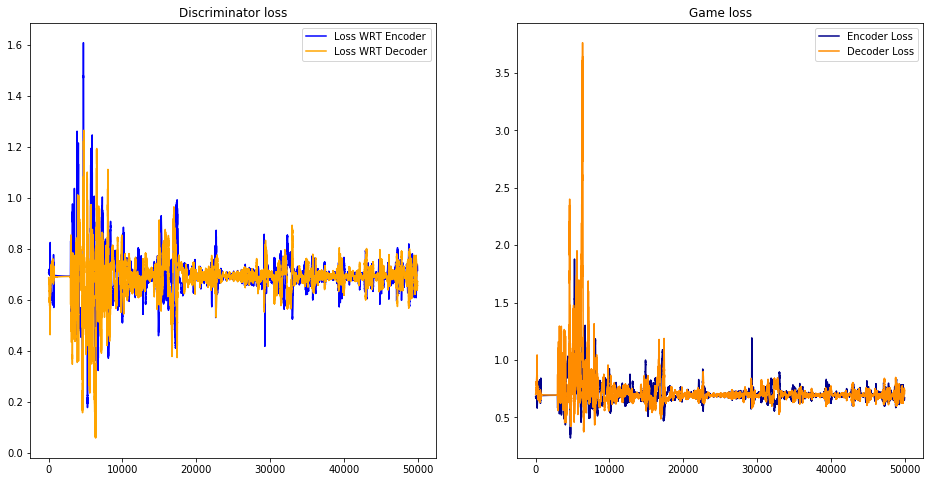

In [7]:
epochs = range(train_steps)
file_name = "ALI/%02dcylce" % (n_cycle)

lossFig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, discriminator_history[:,0], 'b', label='Loss WRT Encoder')
plt.plot(epochs, discriminator_history[:,1], 'orange', label='Loss WRT Decoder')
plt.title('Discriminator loss')
plt.legend(loc="best")
plt.subplot(1, 2, 2)
plt.plot(epochs, game_history[:,0], 'darkblue', label='Encoder Loss')
plt.plot(epochs, game_history[:,1], 'darkorange', label='Decoder Loss')
plt.title('Game loss')
plt.legend(loc="best")
plt.show()
lossFig.savefig(file_name + "Loss.png")

### Figure of merit

AE output:  (50000, 13)
50000 25000


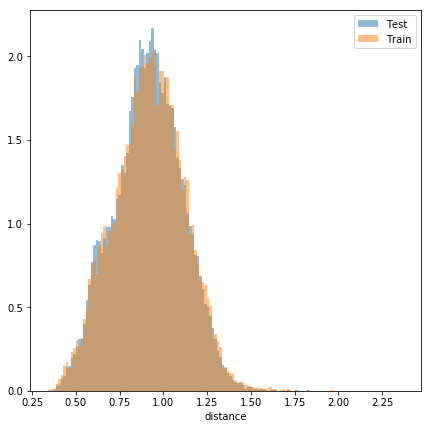

In [8]:
# on test data
encoded_imgs = encoder.predict(sample_test)
decoded_imgs = decoder.predict(encoded_imgs)

# on train data
encoded_imgs_train = encoder.predict(sample_train)
decoded_imgs_train = decoder.predict(encoded_imgs_train)

#print("compressed data:Dense(Dense( ", encoded_imgs.shape)
print("AE output: ", decoded_imgs.shape)

from numpy.linalg import norm

norm_test=[]
for i in range(sample_test.shape[0]):
    norm_test += [norm(sample_test[i,:]-decoded_imgs[i,:])]

norm_train=[]
for i in range(sample_train.shape[0]):
    norm_train += [norm(sample_train[i,:]-decoded_imgs_train[i,:])]

    
print(len(norm_test), len(norm_train))

#bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(norm_test, bins='auto', alpha=0.5, label='Test', density=True)
plt.hist(norm_train, bins, alpha=0.5, label='Train', density=True)
plt.xlabel('distance')
plt.legend(loc='upper right')
plt.savefig(file_name + "FoM.png")

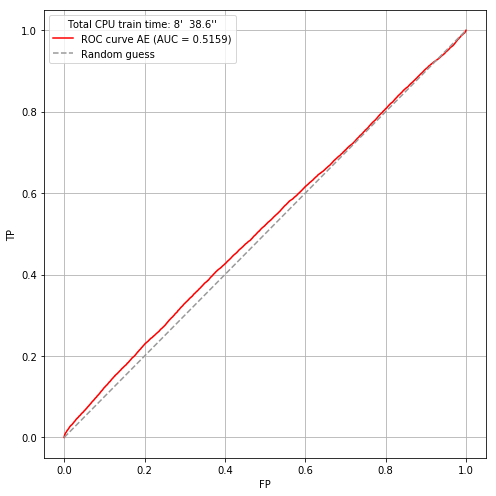

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

target = np.concatenate((np.zeros(sample_train.shape[0] + n_test_sig),np.ones(n_test_sig)))
scores = np.concatenate((norm_train,norm_test))  

train_min = int(train_time) // 60
train_sec = train_time - 60 * train_min
time_stamp = "Total CPU train time: %d'  %.1f''" % (train_min, train_sec)

plt.figure(figsize=(7, 7))
                   
fp, vp, thresholds = roc_curve(target,scores,pos_label=0)
roc_auc = auc(fp, vp)

plt.plot(fp,vp,color='red',label='ROC curve %s (AUC = %0.4f)'%('AE',roc_auc))

plt.xlabel('FP')
plt.ylabel('TP')
plt.plot([0, 1],[0, 1],
         linestyle='--',color=(0.6, 0.6, 0.6),
         label='Random guess')
#plt.plot([0, 0, 1],[0, 1, 1],color='yellow',label='Idéal')
plt.grid()
plt.legend(loc="best", title =time_stamp)
plt.tight_layout()
plt.savefig(file_name + "ROC.png")